### Load the data

In [1]:
import os
import mlflow

os.environ["MLFLOW_TRACKING_URI"] = "http://localhost:5000"
mlflow.set_experiment('Training_LSTM')

2023/10/24 22:02:39 INFO mlflow.tracking.fluent: Experiment with name 'Training_LSTM' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/327182267997851953', creation_time=1698177759778, experiment_id='327182267997851953', last_update_time=1698177759778, lifecycle_stage='active', name='Training_LSTM', tags={}>

### Create the Optuna Objective

In [2]:
import mlflow.keras
import optuna
from common import OptunaPruneCallback, mean_absolute_percentage_error_keras, create_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import numpy as np


def objective(trial, data, coin):
    with mlflow.start_run() as run:
        mlflow.keras.autolog(log_models=False)

        # Define the search space for hyperparameters
        num_layers = trial.suggest_int('num_layers', 1, 4)
        units_per_layer = [trial.suggest_int(f'units_layer_{i}', 32, 256, 32) for i in range(num_layers)]
        sequence_length = trial.suggest_int('sequence_length', 1, 10)
        learning_rate = trial.suggest_float('learning_rate', 1e-6, 1e-3)
        dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
        min_max_scaling = trial.suggest_int('min_max_scaling', 0, 1)
        layer_type = trial.suggest_categorical('layer_type', ['LSTM', 'RNN'])

        layer_class = keras.layers.LSTM if layer_type == 'LSTM' else keras.layers.SimpleRNN 

        mlflow.log_params({
            'coin': coin,
            'num_layers': num_layers,
            'units_per_layer': units_per_layer,
            'sequence_length': sequence_length,
            'learning_rate': learning_rate,
            'dropout_rate': dropout_rate,
            'min_max_scaling': min_max_scaling
        })

        if min_max_scaling == 1:
            scaler = MinMaxScaler()
            data = scaler.fit_transform(np.array(data))

        X, y = create_sequences(data, sequence_length)

        # Build and compile the LSTM model
        model = keras.Sequential()
        for units in units_per_layer[:-1]:
            model.add(layer_class(units, activation='relu', return_sequences=True, input_shape=(sequence_length, 1)))
            model.add(keras.layers.Dropout(dropout_rate))
        model.add(layer_class(units_per_layer[-1], activation='relu', input_shape=(sequence_length, 1)))
        model.add(keras.layers.Dropout(dropout_rate))
        model.add(keras.layers.Dense(1))

        optimizer = keras.optimizers.Adam(learning_rate=learning_rate, clipvalue=1.0)
        model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=[mean_absolute_percentage_error_keras])
        # Split the data into training and validation sets
        _X_train, X_val, _y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)
        X_train, X_test, y_train, y_test = train_test_split(_X_train, _y_train, test_size=0.2, shuffle=False)

        # Train the model with early stopping
        history = model.fit(
            X_train,
            y_train,
            epochs=50,
            batch_size=32,
            validation_data=(X_val, y_val), 
            verbose=0,
            callbacks=[OptunaPruneCallback(trial=trial)]
        )

        # Evaluate the model on the validation set
        loss = model.evaluate(X_val, y_val)

        return loss[1]

/home/gianfranco/Desktop/uni/price-oracle/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-10-24 22:02:40.194034: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-24 22:02:40.196530: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-24 22:02:40.243855: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-24 22:02:40.248620: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in 

### Run the optimization

In [3]:
import numpy as np

def evaluate_best_coin(coin, data, best_params):

    # Train the final model with the best hyperparameters
    # Define the search space for hyperparameters
    num_layers = best_params['num_layers']
    units_per_layer = [best_params[f'units_layer_{i}'] for i in range(num_layers)]
    sequence_length = best_params['sequence_length']
    learning_rate = best_params['learning_rate']
    dropout_rate = best_params['dropout_rate']
    min_max_scaling = best_params['min_max_scaling']
    layer_type = best_params['layer_type']

    layer_class = keras.layers.LSTM if layer_type == 'LSTM' else keras.layers.SimpleRNN 

    if min_max_scaling == 1:
        scaler = MinMaxScaler()
        data = scaler.fit_transform(np.array(data))

    X, y = create_sequences(data, sequence_length)
    _X_train, X_val, _y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)
    X_train, X_test, y_train, y_test = train_test_split(_X_train, _y_train, test_size=0.2, shuffle=False)
    # concatenate train and validation sets
    X_train = np.concatenate((X_train, X_val))
    y_train = np.concatenate((y_train, y_val))

    with mlflow.start_run(run_name=f"Training_best_model_{coin}") as run:
    
        mlflow.log_params({
            'coin': coin,
            'num_layers': num_layers,
            'units_per_layer': units_per_layer,
            'sequence_length': sequence_length,
            'learning_rate': learning_rate,
            'dropout_rate': dropout_rate,
            'min_max_scaling': min_max_scaling
        })

      # Build and compile the LSTM model
        best_model = keras.Sequential()
        for units in units_per_layer[:-1]:
            best_model.add(layer_class(units, activation='relu', return_sequences=True, input_shape=(sequence_length, 1)))
            best_model.add(keras.layers.Dropout(dropout_rate))
        best_model.add(layer_class(units_per_layer[-1], activation='relu', input_shape=(sequence_length, 1)))
        best_model.add(keras.layers.Dropout(dropout_rate))
        best_model.add(keras.layers.Dense(1))

        optimizer = keras.optimizers.Adam(learning_rate=learning_rate, clipvalue=1.0)
        best_model.compile(optimizer=optimizer, loss='mean_squared_error')

        best_model.fit(X_train, y_train, epochs=100, batch_size=32)

        from common import register_training_experiment
        preds = best_model.predict([X_test])

        if min_max_scaling == 1:
            preds = scaler.inverse_transform(preds)
            y_test = scaler.inverse_transform(y_test)

        register_training_experiment(y_test, preds, model_name = layer_class, coin = coin)

[I 2023-10-24 22:02:42,122] A new study created in RDB with name: close_NULSUSDT


11/11 [==============================] - 0s 2ms/step - loss: 1.1663e-04 - mean_absolute_percentage_error_keras: 3.9279


[I 2023-10-24 22:02:49,502] Trial 0 finished with value: 3.9278676509857178 and parameters: {'num_layers': 1, 'units_layer_0': 224, 'sequence_length': 4, 'learning_rate': 0.0006637531396710761, 'dropout_rate': 0.42571438047153776, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 0 with value: 3.9278676509857178.


11/11 [==============================] - 0s 8ms/step - loss: 0.0019 - mean_absolute_percentage_error_keras: 19.2535


[I 2023-10-24 22:03:06,431] Trial 1 finished with value: 19.253530502319336 and parameters: {'num_layers': 4, 'units_layer_0': 192, 'units_layer_1': 32, 'units_layer_2': 64, 'units_layer_3': 32, 'sequence_length': 3, 'learning_rate': 0.00047197560218177365, 'dropout_rate': 0.39527140288624724, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 0 with value: 3.9278676509857178.


11/11 [==============================] - 0s 5ms/step - loss: 8.7106e-05 - mean_absolute_percentage_error_keras: 11.4342


[I 2023-10-24 22:03:40,758] Trial 2 finished with value: 11.434209823608398 and parameters: {'num_layers': 2, 'units_layer_0': 192, 'units_layer_1': 192, 'sequence_length': 8, 'learning_rate': 0.00025515924126724173, 'dropout_rate': 0.13453499881347347, 'min_max_scaling': 1, 'layer_type': 'LSTM'}. Best is trial 0 with value: 3.9278676509857178.


11/11 [==============================] - 0s 1ms/step - loss: 8.8806e-05 - mean_absolute_percentage_error_keras: 2.8460


[I 2023-10-24 22:03:48,723] Trial 3 finished with value: 2.8460171222686768 and parameters: {'num_layers': 1, 'units_layer_0': 192, 'sequence_length': 3, 'learning_rate': 0.0004006607986815813, 'dropout_rate': 0.31334931241241915, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 3 with value: 2.8460171222686768.


11/11 [==============================] - 0s 1ms/step - loss: 2.4802e-04 - mean_absolute_percentage_error_keras: 24.0804


[I 2023-10-24 22:04:00,213] Trial 4 finished with value: 24.080350875854492 and parameters: {'num_layers': 1, 'units_layer_0': 96, 'sequence_length': 2, 'learning_rate': 0.0009209432096460072, 'dropout_rate': 0.47508578770325344, 'min_max_scaling': 1, 'layer_type': 'LSTM'}. Best is trial 3 with value: 2.8460171222686768.
2023-10-24 22:04:02.714389: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_5/simple_rnn_8/while/body/_157/sequential_5/simple_rnn_8/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-24 22:04:02.716632: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_5/simple_rnn_7/while/body/_74/sequential_5/simple_rnn_7/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-24 22:04:02.718454: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpK

11/11 [==============================] - 0s 1ms/step - loss: 1.1873e-04 - mean_absolute_percentage_error_keras: 3.9643


[I 2023-10-24 22:04:13,661] Trial 6 finished with value: 3.964327812194824 and parameters: {'num_layers': 1, 'units_layer_0': 64, 'sequence_length': 7, 'learning_rate': 0.00025613169761651435, 'dropout_rate': 0.09991667473044091, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 3 with value: 2.8460171222686768.
[I 2023-10-24 22:04:19,721] Trial 7 pruned. 
[I 2023-10-24 22:04:27,033] Trial 8 pruned. 
[I 2023-10-24 22:04:35,607] Trial 9 pruned. 
[I 2023-10-24 22:04:42,552] Trial 10 pruned. 


11/11 [==============================] - 0s 2ms/step - loss: 1.9768e-04 - mean_absolute_percentage_error_keras: 5.3849


[I 2023-10-24 22:04:55,689] Trial 11 finished with value: 5.3848700523376465 and parameters: {'num_layers': 2, 'units_layer_0': 224, 'units_layer_1': 256, 'sequence_length': 5, 'learning_rate': 0.0006623007399901401, 'dropout_rate': 0.3216974449062605, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 3 with value: 2.8460171222686768.


11/11 [==============================] - 0s 1ms/step - loss: 9.4353e-05 - mean_absolute_percentage_error_keras: 3.0292


[I 2023-10-24 22:05:02,870] Trial 12 finished with value: 3.0291748046875 and parameters: {'num_layers': 1, 'units_layer_0': 192, 'sequence_length': 4, 'learning_rate': 0.0007096873665104093, 'dropout_rate': 0.2383083427109201, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 3 with value: 2.8460171222686768.
[I 2023-10-24 22:05:08,358] Trial 13 pruned. 


11/11 [==============================] - 0s 1ms/step - loss: 7.7115e-05 - mean_absolute_percentage_error_keras: 2.6160


[I 2023-10-24 22:05:18,127] Trial 14 finished with value: 2.616048574447632 and parameters: {'num_layers': 2, 'units_layer_0': 160, 'units_layer_1': 96, 'sequence_length': 4, 'learning_rate': 0.0007711244320930647, 'dropout_rate': 0.02871888005789902, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 14 with value: 2.616048574447632.


11/11 [==============================] - 0s 1ms/step - loss: 8.0808e-05 - mean_absolute_percentage_error_keras: 2.8421


[I 2023-10-24 22:05:26,809] Trial 15 finished with value: 2.842055320739746 and parameters: {'num_layers': 2, 'units_layer_0': 160, 'units_layer_1': 96, 'sequence_length': 3, 'learning_rate': 0.0007932671909956679, 'dropout_rate': 0.01952901324922124, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 14 with value: 2.616048574447632.
2023-10-24 22:05:28.471492: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_16/simple_rnn_25/while/body/_74/sequential_16/simple_rnn_25/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-24 22:05:28.473267: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_16/simple_rnn_24/while/body/_1/sequential_16/simple_rnn_24/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-24 22:05:28.474041: W tensorflow/core/grappler/utils/graph_view.c

11/11 [==============================] - 0s 1ms/step - loss: 1.2991e-04 - mean_absolute_percentage_error_keras: 4.2562


[I 2023-10-24 22:05:35,830] Trial 16 finished with value: 4.2561821937561035 and parameters: {'num_layers': 3, 'units_layer_0': 128, 'units_layer_1': 96, 'units_layer_2': 256, 'sequence_length': 1, 'learning_rate': 0.0008039364143011373, 'dropout_rate': 0.005608721752367103, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 14 with value: 2.616048574447632.
[I 2023-10-24 22:05:39,267] Trial 17 pruned. 
[I 2023-10-24 22:05:43,020] Trial 18 pruned. 


11/11 [==============================] - 0s 2ms/step - loss: 2.0953e-04 - mean_absolute_percentage_error_keras: 6.0860


[I 2023-10-24 22:05:54,264] Trial 19 finished with value: 6.085996627807617 and parameters: {'num_layers': 3, 'units_layer_0': 128, 'units_layer_1': 160, 'units_layer_2': 96, 'sequence_length': 3, 'learning_rate': 0.000755019592639662, 'dropout_rate': 0.06417257342662729, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 14 with value: 2.616048574447632.
[I 2023-10-24 22:05:58,135] Trial 20 pruned. 


11/11 [==============================] - 0s 1ms/step - loss: 7.8017e-05 - mean_absolute_percentage_error_keras: 2.6415


[I 2023-10-24 22:06:04,837] Trial 21 finished with value: 2.6415300369262695 and parameters: {'num_layers': 1, 'units_layer_0': 224, 'sequence_length': 3, 'learning_rate': 0.0008457018994141548, 'dropout_rate': 0.19102411091707933, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 14 with value: 2.616048574447632.
2023-10-24 22:06:06.154800: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_22/simple_rnn_37/while/body/_1/sequential_22/simple_rnn_37/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-24 22:06:06.156397: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_22/simple_rnn_38/while/body/_74/sequential_22/simple_rnn_38/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-24 22:06:06.183894: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:134] 

11/11 [==============================] - 0s 1ms/step - loss: 2.0057e-04 - mean_absolute_percentage_error_keras: 5.7761


[I 2023-10-24 22:06:13,612] Trial 22 finished with value: 5.776062488555908 and parameters: {'num_layers': 2, 'units_layer_0': 256, 'units_layer_1': 64, 'sequence_length': 2, 'learning_rate': 0.0008758917554501171, 'dropout_rate': 0.17031364123912132, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 14 with value: 2.616048574447632.


11/11 [==============================] - 0s 2ms/step - loss: 1.5097e-04 - mean_absolute_percentage_error_keras: 4.3422


[I 2023-10-24 22:06:24,306] Trial 23 finished with value: 4.3422064781188965 and parameters: {'num_layers': 2, 'units_layer_0': 224, 'units_layer_1': 160, 'sequence_length': 4, 'learning_rate': 0.0008404016233552958, 'dropout_rate': 0.05010377005230146, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 14 with value: 2.616048574447632.


11/11 [==============================] - 0s 1ms/step - loss: 2.3878e-04 - mean_absolute_percentage_error_keras: 5.9491


[I 2023-10-24 22:06:30,942] Trial 24 finished with value: 5.949123382568359 and parameters: {'num_layers': 1, 'units_layer_0': 160, 'sequence_length': 3, 'learning_rate': 0.000734832575861081, 'dropout_rate': 0.08418985074525384, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 14 with value: 2.616048574447632.


11/11 [==============================] - 0s 2ms/step - loss: 1.6422e-04 - mean_absolute_percentage_error_keras: 5.0871


[I 2023-10-24 22:06:44,549] Trial 25 finished with value: 5.087057113647461 and parameters: {'num_layers': 3, 'units_layer_0': 224, 'units_layer_1': 64, 'units_layer_2': 192, 'sequence_length': 5, 'learning_rate': 0.0008709161239422236, 'dropout_rate': 0.0280333594739944, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 14 with value: 2.616048574447632.
[I 2023-10-24 22:06:48,559] Trial 26 pruned. 
2023-10-24 22:06:49.348887: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_27/simple_rnn_45/while/body/_1/sequential_27/simple_rnn_45/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-24 22:06:49.365002: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:134] tfg_optimizer{any(tfg-consolidate-attrs,tfg-toposort,tfg-shape-inference{graph-version=0},tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node sequential_27/simple_rnn_45/while/body/_1/sequential_27/s

11/11 [==============================] - 0s 1ms/step - loss: 8.4143e-05 - mean_absolute_percentage_error_keras: 2.7521


[I 2023-10-24 22:07:00,727] Trial 28 finished with value: 2.752139091491699 and parameters: {'num_layers': 2, 'units_layer_0': 192, 'units_layer_1': 192, 'sequence_length': 4, 'learning_rate': 0.0007157087225361214, 'dropout_rate': 0.05963844371241714, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 14 with value: 2.616048574447632.


11/11 [==============================] - 0s 1ms/step - loss: 7.9304e-05 - mean_absolute_percentage_error_keras: 2.7102


[I 2023-10-24 22:07:07,801] Trial 29 finished with value: 2.7101945877075195 and parameters: {'num_layers': 1, 'units_layer_0': 192, 'sequence_length': 4, 'learning_rate': 0.0006500008537847383, 'dropout_rate': 0.19723724992949054, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 14 with value: 2.616048574447632.


11/11 [==============================] - 0s 1ms/step - loss: 1.7049e-04 - mean_absolute_percentage_error_keras: 5.0678


[I 2023-10-24 22:07:15,551] Trial 30 finished with value: 5.067836761474609 and parameters: {'num_layers': 1, 'units_layer_0': 224, 'sequence_length': 5, 'learning_rate': 0.0006303640114453515, 'dropout_rate': 0.19916861636987382, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 14 with value: 2.616048574447632.


11/11 [==============================] - 0s 1ms/step - loss: 1.3991e-04 - mean_absolute_percentage_error_keras: 4.5747


[I 2023-10-24 22:07:22,450] Trial 31 finished with value: 4.574733257293701 and parameters: {'num_layers': 1, 'units_layer_0': 192, 'sequence_length': 4, 'learning_rate': 0.0007021510716571875, 'dropout_rate': 0.16533620772971933, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 14 with value: 2.616048574447632.


11/11 [==============================] - 0s 1ms/step - loss: 9.1664e-05 - mean_absolute_percentage_error_keras: 3.1057


[I 2023-10-24 22:07:28,963] Trial 32 finished with value: 3.105694055557251 and parameters: {'num_layers': 1, 'units_layer_0': 192, 'sequence_length': 4, 'learning_rate': 0.0005943667240658083, 'dropout_rate': 0.08724299137621022, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 14 with value: 2.616048574447632.


11/11 [==============================] - 0s 1ms/step - loss: 1.6101e-04 - mean_absolute_percentage_error_keras: 4.9322


[I 2023-10-24 22:07:36,184] Trial 33 finished with value: 4.93220329284668 and parameters: {'num_layers': 1, 'units_layer_0': 192, 'sequence_length': 6, 'learning_rate': 0.0006879489868458958, 'dropout_rate': 0.2635856045388097, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 14 with value: 2.616048574447632.


11/11 [==============================] - 0s 2ms/step - loss: 8.5193e-05 - mean_absolute_percentage_error_keras: 2.9600


[I 2023-10-24 22:07:47,257] Trial 34 finished with value: 2.9599647521972656 and parameters: {'num_layers': 2, 'units_layer_0': 224, 'units_layer_1': 224, 'sequence_length': 4, 'learning_rate': 0.0005675602353141949, 'dropout_rate': 0.12789010117776295, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 14 with value: 2.616048574447632.


11/11 [==============================] - 0s 1ms/step - loss: 7.5139e-05 - mean_absolute_percentage_error_keras: 2.5958


[I 2023-10-24 22:07:53,989] Trial 35 finished with value: 2.5957839488983154 and parameters: {'num_layers': 1, 'units_layer_0': 192, 'sequence_length': 3, 'learning_rate': 0.0006700827990457708, 'dropout_rate': 0.048775667044554105, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 35 with value: 2.5957839488983154.
[I 2023-10-24 22:07:58,306] Trial 36 pruned. 
2023-10-24 22:07:59.151214: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_37/simple_rnn_56/while/body/_1/sequential_37/simple_rnn_56/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-24 22:07:59.178087: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:134] tfg_optimizer{any(tfg-consolidate-attrs,tfg-toposort,tfg-shape-inference{graph-version=0},tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node sequential_37/simple_rnn_56/while/body/_1/sequential_37/simple_rnn_56/while/simple_rnn_cell/Relu

11/11 [==============================] - 0s 1ms/step - loss: 1.1665e-04 - mean_absolute_percentage_error_keras: 3.6268


[I 2023-10-24 22:08:07,702] Trial 38 finished with value: 3.6267898082733154 and parameters: {'num_layers': 1, 'units_layer_0': 160, 'sequence_length': 3, 'learning_rate': 0.0006601578670404909, 'dropout_rate': 0.11200751486613826, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 35 with value: 2.5957839488983154.
[I 2023-10-24 22:08:10,588] Trial 39 pruned. 


11/11 [==============================] - 0s 1ms/step - loss: 8.2595e-05 - mean_absolute_percentage_error_keras: 2.7396


[I 2023-10-24 22:08:18,122] Trial 40 finished with value: 2.7396159172058105 and parameters: {'num_layers': 1, 'units_layer_0': 224, 'sequence_length': 5, 'learning_rate': 0.0007360572595275139, 'dropout_rate': 0.14001043049928236, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 35 with value: 2.5957839488983154.


11/11 [==============================] - 0s 1ms/step - loss: 1.5061e-04 - mean_absolute_percentage_error_keras: 4.7092


[I 2023-10-24 22:08:25,598] Trial 41 finished with value: 4.709202289581299 and parameters: {'num_layers': 1, 'units_layer_0': 224, 'sequence_length': 5, 'learning_rate': 0.0007600482563046996, 'dropout_rate': 0.1494567177562206, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 35 with value: 2.5957839488983154.


11/11 [==============================] - 0s 2ms/step - loss: 9.8060e-05 - mean_absolute_percentage_error_keras: 3.3705


[I 2023-10-24 22:08:31,833] Trial 42 finished with value: 3.3704817295074463 and parameters: {'num_layers': 1, 'units_layer_0': 224, 'sequence_length': 3, 'learning_rate': 0.000737389077438436, 'dropout_rate': 0.11826177096680235, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 35 with value: 2.5957839488983154.


11/11 [==============================] - 0s 2ms/step - loss: 1.4879e-04 - mean_absolute_percentage_error_keras: 4.5597


[I 2023-10-24 22:08:40,574] Trial 43 finished with value: 4.55972146987915 and parameters: {'num_layers': 1, 'units_layer_0': 256, 'sequence_length': 7, 'learning_rate': 0.0006650372497981107, 'dropout_rate': 0.19217915716745337, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 35 with value: 2.5957839488983154.


11/11 [==============================] - 0s 1ms/step - loss: 2.5356e-04 - mean_absolute_percentage_error_keras: 6.6281


[I 2023-10-24 22:08:47,969] Trial 44 finished with value: 6.62810754776001 and parameters: {'num_layers': 1, 'units_layer_0': 192, 'sequence_length': 5, 'learning_rate': 0.0008250730852021109, 'dropout_rate': 0.0968916745433113, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 35 with value: 2.5957839488983154.
[I 2023-10-24 22:08:51,725] Trial 45 pruned. 
[I 2023-10-24 22:08:58,484] Trial 46 pruned. 


11/11 [==============================] - 0s 2ms/step - loss: 8.0435e-05 - mean_absolute_percentage_error_keras: 2.6773


[I 2023-10-24 22:09:04,650] Trial 47 finished with value: 2.6773476600646973 and parameters: {'num_layers': 1, 'units_layer_0': 128, 'sequence_length': 4, 'learning_rate': 0.0007451085683911802, 'dropout_rate': 0.03623869904019932, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 35 with value: 2.5957839488983154.
2023-10-24 22:09:05.585667: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_48/simple_rnn_68/while/body/_1/sequential_48/simple_rnn_68/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-24 22:09:05.603769: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:134] tfg_optimizer{any(tfg-consolidate-attrs,tfg-toposort,tfg-shape-inference{graph-version=0},tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node sequential_48/simple_rnn_68/while/body/_1/sequential_48/simple_rnn_68/while/simple_rnn_cell/Relu has an empty op name
	when importing GraphDef 

11/11 [==============================] - 0s 1ms/step - loss: 1.1953e-04 - mean_absolute_percentage_error_keras: 4.0705


[I 2023-10-24 22:09:15,914] Trial 49 finished with value: 4.070538520812988 and parameters: {'num_layers': 2, 'units_layer_0': 96, 'units_layer_1': 32, 'sequence_length': 4, 'learning_rate': 0.0008360789511021888, 'dropout_rate': 0.03322932506239577, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 35 with value: 2.5957839488983154.


Best Hyperparameters: {'num_layers': 1, 'units_layer_0': 192, 'sequence_length': 3, 'learning_rate': 0.0006700827990457708, 'dropout_rate': 0.048775667044554105, 'min_max_scaling': 0, 'layer_type': 'RNN'}
Epoch 1/100
46/46 [==============================] - 1s 2ms/step - loss: 0.0286
Epoch 2/100
46/46 [==============================] - 0s 2ms/step - loss: 0.0028
Epoch 3/100
46/46 [==============================] - 0s 2ms/step - loss: 0.0026
Epoch 4/100
46/46 [==============================] - 0s 2ms/step - loss: 0.0025
Epoch 5/100
46/46 [==============================] - 0s 2ms/step - loss: 0.0025
Epoch 6/100
46/46 [==============================] - 0s 2ms/step - loss: 0.0025
Epoch 7/100
46/46 [==============================] - 0s 2ms/step - loss: 0.0022
Epoch 8/100
46/46 [==============================] - 0s 2ms/step - loss: 0.0022
Epoch 9/100
46/46 [==============================] - 0s 2ms/step - loss: 0.0023
Epoch 10/100
46/46 [==============================] - 0s 2ms/step - loss: 0

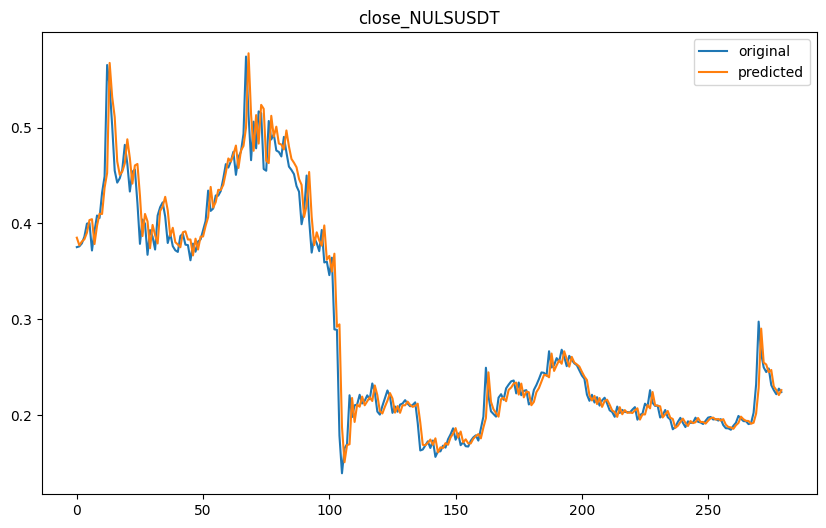

[I 2023-10-24 22:09:26,227] A new study created in RDB with name: close_VETUSDT


Metrics for 280 days: close_NULSUSDT MSE: 0.0004147426711581558, RMSE: 0.02036523192006798 MAPE: 0.042129372361657445
Metrics for 90 days: close_NULSUSDT MSE: 0.00010801255680971583, RMSE: 0.010392908967643074 MAPE: 0.026745098457028046
Metrics for 30 days: close_NULSUSDT MSE: 0.000237242936995324, RMSE: 0.015402692524209005 MAPE: 0.032038379082398746
Metrics for 7 days: close_NULSUSDT MSE: 5.851567372586475e-05, RMSE: 0.00764955382528058 MAPE: 0.027291162759788996
11/11 [==============================] - 0s 6ms/step - loss: 2.2582e-05 - mean_absolute_percentage_error_keras: 5.3040


[I 2023-10-24 22:10:00,238] Trial 0 finished with value: 5.303963661193848 and parameters: {'num_layers': 2, 'units_layer_0': 224, 'units_layer_1': 192, 'sequence_length': 9, 'learning_rate': 0.000965958448811137, 'dropout_rate': 0.16798472010135296, 'min_max_scaling': 1, 'layer_type': 'LSTM'}. Best is trial 0 with value: 5.303963661193848.


11/11 [==============================] - 0s 2ms/step - loss: 7.0564e-06 - mean_absolute_percentage_error_keras: 11.6154


[I 2023-10-24 22:10:15,683] Trial 1 finished with value: 11.615358352661133 and parameters: {'num_layers': 2, 'units_layer_0': 224, 'units_layer_1': 192, 'sequence_length': 10, 'learning_rate': 0.0007271164346049663, 'dropout_rate': 0.10710820807135224, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 0 with value: 5.303963661193848.


11/11 [==============================] - 0s 5ms/step - loss: 4.6369e-06 - mean_absolute_percentage_error_keras: 7.8985


[I 2023-10-24 22:10:52,478] Trial 2 finished with value: 7.898502349853516 and parameters: {'num_layers': 4, 'units_layer_0': 224, 'units_layer_1': 160, 'units_layer_2': 96, 'units_layer_3': 32, 'sequence_length': 6, 'learning_rate': 0.0003768171533966914, 'dropout_rate': 0.3582017780680885, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 0 with value: 5.303963661193848.


11/11 [==============================] - 0s 5ms/step - loss: 1.1703e-04 - mean_absolute_percentage_error_keras: 13.5059


[I 2023-10-24 22:11:21,432] Trial 3 finished with value: 13.505870819091797 and parameters: {'num_layers': 2, 'units_layer_0': 192, 'units_layer_1': 224, 'sequence_length': 7, 'learning_rate': 0.00010509941361924305, 'dropout_rate': 0.31077161072370135, 'min_max_scaling': 1, 'layer_type': 'LSTM'}. Best is trial 0 with value: 5.303963661193848.


11/11 [==============================] - 0s 1ms/step - loss: 2.2969e-05 - mean_absolute_percentage_error_keras: 5.2112


[I 2023-10-24 22:11:27,933] Trial 4 finished with value: 5.21117639541626 and parameters: {'num_layers': 1, 'units_layer_0': 64, 'sequence_length': 6, 'learning_rate': 0.0009091741237588458, 'dropout_rate': 0.4036191285204237, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 4 with value: 5.21117639541626.


11/11 [==============================] - 0s 3ms/step - loss: 1.0651e-05 - mean_absolute_percentage_error_keras: 15.6373


[I 2023-10-24 22:11:44,596] Trial 5 finished with value: 15.637276649475098 and parameters: {'num_layers': 2, 'units_layer_0': 160, 'units_layer_1': 192, 'sequence_length': 3, 'learning_rate': 0.000688776922804472, 'dropout_rate': 0.32737352396393626, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 4 with value: 5.21117639541626.


11/11 [==============================] - 0s 1ms/step - loss: 5.1234e-06 - mean_absolute_percentage_error_keras: 11.0637


[I 2023-10-24 22:11:51,169] Trial 6 finished with value: 11.063663482666016 and parameters: {'num_layers': 1, 'units_layer_0': 192, 'sequence_length': 3, 'learning_rate': 0.00018387576099287092, 'dropout_rate': 0.14366815404199546, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 4 with value: 5.21117639541626.


11/11 [==============================] - 0s 2ms/step - loss: 3.6627e-06 - mean_absolute_percentage_error_keras: 8.0576


[I 2023-10-24 22:12:00,703] Trial 7 finished with value: 8.057595252990723 and parameters: {'num_layers': 1, 'units_layer_0': 64, 'sequence_length': 7, 'learning_rate': 0.00010716408101359704, 'dropout_rate': 0.10079897668109822, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 4 with value: 5.21117639541626.


11/11 [==============================] - 0s 3ms/step - loss: 1.2219e-04 - mean_absolute_percentage_error_keras: 14.9127


[I 2023-10-24 22:12:25,287] Trial 8 finished with value: 14.912725448608398 and parameters: {'num_layers': 4, 'units_layer_0': 224, 'units_layer_1': 256, 'units_layer_2': 192, 'units_layer_3': 128, 'sequence_length': 8, 'learning_rate': 0.00026856356890453517, 'dropout_rate': 0.08295264222308923, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 4 with value: 5.21117639541626.


11/11 [==============================] - 0s 1ms/step - loss: 1.8202e-05 - mean_absolute_percentage_error_keras: 21.7171


[I 2023-10-24 22:12:32,239] Trial 9 finished with value: 21.71709632873535 and parameters: {'num_layers': 1, 'units_layer_0': 160, 'sequence_length': 5, 'learning_rate': 0.0005755295443050459, 'dropout_rate': 0.14135352846381277, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 4 with value: 5.21117639541626.
2023-10-24 22:12:34.028541: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_61/simple_rnn_82/while/body/_74/sequential_61/simple_rnn_82/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-24 22:12:34.030306: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_61/simple_rnn_81/while/body/_1/sequential_61/simple_rnn_81/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-24 22:12:34.031248: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' 

11/11 [==============================] - 0s 5ms/step - loss: 2.2565e-05 - mean_absolute_percentage_error_keras: 4.7296


[I 2023-10-24 22:13:04,582] Trial 11 finished with value: 4.7296319007873535 and parameters: {'num_layers': 3, 'units_layer_0': 96, 'units_layer_1': 96, 'units_layer_2': 32, 'sequence_length': 10, 'learning_rate': 0.0009915924019906065, 'dropout_rate': 0.0008444259580647762, 'min_max_scaling': 1, 'layer_type': 'LSTM'}. Best is trial 11 with value: 4.7296319007873535.


11/11 [==============================] - 0s 3ms/step - loss: 3.0696e-05 - mean_absolute_percentage_error_keras: 6.0707


[I 2023-10-24 22:13:21,600] Trial 12 finished with value: 6.070714950561523 and parameters: {'num_layers': 3, 'units_layer_0': 96, 'units_layer_1': 64, 'units_layer_2': 32, 'sequence_length': 4, 'learning_rate': 0.0008365224065188197, 'dropout_rate': 0.006454381225657789, 'min_max_scaling': 1, 'layer_type': 'LSTM'}. Best is trial 11 with value: 4.7296319007873535.


11/11 [==============================] - 0s 2ms/step - loss: 3.6010e-05 - mean_absolute_percentage_error_keras: 6.5494


[I 2023-10-24 22:13:36,824] Trial 13 finished with value: 6.549381256103516 and parameters: {'num_layers': 3, 'units_layer_0': 96, 'units_layer_1': 96, 'units_layer_2': 32, 'sequence_length': 10, 'learning_rate': 0.0008559508074439254, 'dropout_rate': 0.2489060492374716, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 11 with value: 4.7296319007873535.


11/11 [==============================] - 0s 1ms/step - loss: 1.1496e-05 - mean_absolute_percentage_error_keras: 3.1171


[I 2023-10-24 22:13:46,904] Trial 14 finished with value: 3.1171159744262695 and parameters: {'num_layers': 3, 'units_layer_0': 96, 'units_layer_1': 96, 'units_layer_2': 128, 'sequence_length': 1, 'learning_rate': 0.0005227136239564247, 'dropout_rate': 0.0016953162214821682, 'min_max_scaling': 1, 'layer_type': 'LSTM'}. Best is trial 14 with value: 3.1171159744262695.


11/11 [==============================] - 0s 2ms/step - loss: 3.6660e-05 - mean_absolute_percentage_error_keras: 7.7836


[I 2023-10-24 22:13:58,266] Trial 15 finished with value: 7.783598899841309 and parameters: {'num_layers': 3, 'units_layer_0': 128, 'units_layer_1': 96, 'units_layer_2': 128, 'sequence_length': 1, 'learning_rate': 0.0005134468307081511, 'dropout_rate': 0.003739980402861556, 'min_max_scaling': 1, 'layer_type': 'LSTM'}. Best is trial 14 with value: 3.1171159744262695.


11/11 [==============================] - 0s 3ms/step - loss: 3.4772e-05 - mean_absolute_percentage_error_keras: 6.5462


[I 2023-10-24 22:14:17,908] Trial 16 finished with value: 6.5461530685424805 and parameters: {'num_layers': 4, 'units_layer_0': 96, 'units_layer_1': 128, 'units_layer_2': 96, 'units_layer_3': 256, 'sequence_length': 2, 'learning_rate': 0.0004080829552527076, 'dropout_rate': 0.04300394273815533, 'min_max_scaling': 1, 'layer_type': 'LSTM'}. Best is trial 14 with value: 3.1171159744262695.


11/11 [==============================] - 0s 3ms/step - loss: 3.3521e-05 - mean_absolute_percentage_error_keras: 6.6097


[I 2023-10-24 22:14:36,241] Trial 17 finished with value: 6.609658718109131 and parameters: {'num_layers': 3, 'units_layer_0': 32, 'units_layer_1': 32, 'units_layer_2': 192, 'sequence_length': 4, 'learning_rate': 0.0006544275389376449, 'dropout_rate': 0.05236431125081584, 'min_max_scaling': 1, 'layer_type': 'LSTM'}. Best is trial 14 with value: 3.1171159744262695.
[I 2023-10-24 22:14:49,109] Trial 18 pruned. 


11/11 [==============================] - 0s 4ms/step - loss: 4.0866e-05 - mean_absolute_percentage_error_keras: 6.7925


[I 2023-10-24 22:15:13,242] Trial 19 finished with value: 6.792515277862549 and parameters: {'num_layers': 3, 'units_layer_0': 64, 'units_layer_1': 128, 'units_layer_2': 160, 'sequence_length': 5, 'learning_rate': 0.0006373156605121134, 'dropout_rate': 0.05026283360231726, 'min_max_scaling': 1, 'layer_type': 'LSTM'}. Best is trial 14 with value: 3.1171159744262695.
[I 2023-10-24 22:15:17,629] Trial 20 pruned. 


11/11 [==============================] - 0s 2ms/step - loss: 4.9937e-05 - mean_absolute_percentage_error_keras: 7.8125


[I 2023-10-24 22:15:33,322] Trial 21 finished with value: 7.812505722045898 and parameters: {'num_layers': 3, 'units_layer_0': 64, 'units_layer_1': 64, 'units_layer_2': 256, 'sequence_length': 6, 'learning_rate': 0.0009113225429683326, 'dropout_rate': 0.07659038994799382, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 14 with value: 3.1171159744262695.


11/11 [==============================] - 0s 1ms/step - loss: 1.2391e-05 - mean_absolute_percentage_error_keras: 3.4661


[I 2023-10-24 22:15:41,127] Trial 22 finished with value: 3.4660890102386475 and parameters: {'num_layers': 1, 'units_layer_0': 96, 'sequence_length': 9, 'learning_rate': 0.0008925802630576607, 'dropout_rate': 0.19935167277939814, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 14 with value: 3.1171159744262695.


11/11 [==============================] - 0s 3ms/step - loss: 3.3149e-05 - mean_absolute_percentage_error_keras: 6.3262


[I 2023-10-24 22:15:53,968] Trial 23 finished with value: 6.326216697692871 and parameters: {'num_layers': 2, 'units_layer_0': 96, 'units_layer_1': 160, 'sequence_length': 9, 'learning_rate': 0.0007755236455203728, 'dropout_rate': 0.18526229667695143, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 14 with value: 3.1171159744262695.
[I 2023-10-24 22:16:06,842] Trial 24 pruned. 
[I 2023-10-24 22:16:21,625] Trial 25 pruned. 


11/11 [==============================] - 0s 2ms/step - loss: 3.6436e-05 - mean_absolute_percentage_error_keras: 7.5374


[I 2023-10-24 22:16:34,384] Trial 26 finished with value: 7.5374226570129395 and parameters: {'num_layers': 2, 'units_layer_0': 160, 'units_layer_1': 64, 'sequence_length': 8, 'learning_rate': 0.0005779026914922009, 'dropout_rate': 0.053905757348073534, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 14 with value: 3.1171159744262695.
[I 2023-10-24 22:16:52,228] Trial 27 pruned. 


11/11 [==============================] - 0s 1ms/step - loss: 3.7276e-05 - mean_absolute_percentage_error_keras: 7.7266


[I 2023-10-24 22:16:59,708] Trial 28 finished with value: 7.726553916931152 and parameters: {'num_layers': 1, 'units_layer_0': 64, 'sequence_length': 7, 'learning_rate': 0.0009205162030753709, 'dropout_rate': 0.12683082779452792, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 14 with value: 3.1171159744262695.
[I 2023-10-24 22:17:05,970] Trial 29 pruned. 
[I 2023-10-24 22:17:18,368] Trial 30 pruned. 


11/11 [==============================] - 0s 1ms/step - loss: 2.2459e-05 - mean_absolute_percentage_error_keras: 4.5617


[I 2023-10-24 22:17:26,275] Trial 31 finished with value: 4.561664581298828 and parameters: {'num_layers': 1, 'units_layer_0': 64, 'sequence_length': 9, 'learning_rate': 0.000914569108702759, 'dropout_rate': 0.20667106812315597, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 14 with value: 3.1171159744262695.


11/11 [==============================] - 0s 1ms/step - loss: 2.3142e-05 - mean_absolute_percentage_error_keras: 5.7664


[I 2023-10-24 22:17:34,368] Trial 32 finished with value: 5.766422271728516 and parameters: {'num_layers': 1, 'units_layer_0': 64, 'sequence_length': 9, 'learning_rate': 0.0009065006021908998, 'dropout_rate': 0.2218087952337708, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 14 with value: 3.1171159744262695.


11/11 [==============================] - 0s 1ms/step - loss: 1.3189e-05 - mean_absolute_percentage_error_keras: 3.5717


[I 2023-10-24 22:17:42,444] Trial 33 finished with value: 3.5717127323150635 and parameters: {'num_layers': 1, 'units_layer_0': 96, 'sequence_length': 10, 'learning_rate': 0.0007344441022497676, 'dropout_rate': 0.1712925256349729, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 14 with value: 3.1171159744262695.


11/11 [==============================] - 0s 2ms/step - loss: 3.0405e-05 - mean_absolute_percentage_error_keras: 6.7408


[I 2023-10-24 22:17:52,962] Trial 34 finished with value: 6.740846633911133 and parameters: {'num_layers': 1, 'units_layer_0': 256, 'sequence_length': 9, 'learning_rate': 0.0007172359061319285, 'dropout_rate': 0.16908544986265564, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 14 with value: 3.1171159744262695.


11/11 [==============================] - 0s 1ms/step - loss: 4.8762e-06 - mean_absolute_percentage_error_keras: 10.5104


[I 2023-10-24 22:17:59,918] Trial 35 finished with value: 10.510422706604004 and parameters: {'num_layers': 1, 'units_layer_0': 32, 'sequence_length': 7, 'learning_rate': 0.00078668321683969, 'dropout_rate': 0.27221443148026914, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 14 with value: 3.1171159744262695.


11/11 [==============================] - 0s 1ms/step - loss: 1.4214e-05 - mean_absolute_percentage_error_keras: 3.6518


[I 2023-10-24 22:18:07,697] Trial 36 finished with value: 3.6518361568450928 and parameters: {'num_layers': 1, 'units_layer_0': 64, 'sequence_length': 10, 'learning_rate': 0.0007215399205243239, 'dropout_rate': 0.21186124543096585, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 14 with value: 3.1171159744262695.


11/11 [==============================] - 0s 2ms/step - loss: 1.3152e-05 - mean_absolute_percentage_error_keras: 3.5965


[I 2023-10-24 22:18:16,818] Trial 37 finished with value: 3.5964715480804443 and parameters: {'num_layers': 1, 'units_layer_0': 96, 'sequence_length': 10, 'learning_rate': 0.0006960892478339469, 'dropout_rate': 0.2734812118267879, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 14 with value: 3.1171159744262695.


11/11 [==============================] - 0s 3ms/step - loss: 2.3982e-05 - mean_absolute_percentage_error_keras: 20.8410


[I 2023-10-24 22:18:33,469] Trial 38 finished with value: 20.841007232666016 and parameters: {'num_layers': 2, 'units_layer_0': 160, 'units_layer_1': 256, 'sequence_length': 10, 'learning_rate': 0.0006778541375713097, 'dropout_rate': 0.2782210584882261, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 14 with value: 3.1171159744262695.


11/11 [==============================] - 0s 1ms/step - loss: 2.5616e-05 - mean_absolute_percentage_error_keras: 5.7476


[I 2023-10-24 22:18:41,884] Trial 39 finished with value: 5.747598648071289 and parameters: {'num_layers': 1, 'units_layer_0': 128, 'sequence_length': 8, 'learning_rate': 0.0006150822612285116, 'dropout_rate': 0.15834640338005926, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 14 with value: 3.1171159744262695.


11/11 [==============================] - 0s 2ms/step - loss: 5.8017e-06 - mean_absolute_percentage_error_keras: 11.6613


[I 2023-10-24 22:18:55,629] Trial 40 finished with value: 11.661343574523926 and parameters: {'num_layers': 2, 'units_layer_0': 192, 'units_layer_1': 224, 'sequence_length': 6, 'learning_rate': 0.0004944469723064345, 'dropout_rate': 0.18064811933725136, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 14 with value: 3.1171159744262695.


11/11 [==============================] - 0s 1ms/step - loss: 1.2668e-05 - mean_absolute_percentage_error_keras: 3.2980


[I 2023-10-24 22:19:04,070] Trial 41 finished with value: 3.2979977130889893 and parameters: {'num_layers': 1, 'units_layer_0': 96, 'sequence_length': 10, 'learning_rate': 0.0007068991220565566, 'dropout_rate': 0.20999135795826968, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 14 with value: 3.1171159744262695.


11/11 [==============================] - 0s 1ms/step - loss: 1.4680e-05 - mean_absolute_percentage_error_keras: 4.0766


[I 2023-10-24 22:19:12,402] Trial 42 finished with value: 4.0766096115112305 and parameters: {'num_layers': 1, 'units_layer_0': 96, 'sequence_length': 10, 'learning_rate': 0.0006982336335169408, 'dropout_rate': 0.13516705020702718, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 14 with value: 3.1171159744262695.


11/11 [==============================] - 0s 1ms/step - loss: 1.2023e-05 - mean_absolute_percentage_error_keras: 3.3147


[I 2023-10-24 22:19:21,166] Trial 43 finished with value: 3.3147451877593994 and parameters: {'num_layers': 1, 'units_layer_0': 96, 'sequence_length': 9, 'learning_rate': 0.0007324455921945005, 'dropout_rate': 0.23248515524677557, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 14 with value: 3.1171159744262695.


11/11 [==============================] - 0s 1ms/step - loss: 1.5080e-05 - mean_absolute_percentage_error_keras: 3.8090


[I 2023-10-24 22:19:29,457] Trial 44 finished with value: 3.8090295791625977 and parameters: {'num_layers': 1, 'units_layer_0': 128, 'sequence_length': 9, 'learning_rate': 0.000745706282971242, 'dropout_rate': 0.23252554853404278, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 14 with value: 3.1171159744262695.


11/11 [==============================] - 0s 1ms/step - loss: 1.1470e-05 - mean_absolute_percentage_error_keras: 3.2227


[I 2023-10-24 22:19:37,475] Trial 45 finished with value: 3.2226722240448 and parameters: {'num_layers': 1, 'units_layer_0': 96, 'sequence_length': 7, 'learning_rate': 0.0008668545843451006, 'dropout_rate': 0.15246793862664795, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 14 with value: 3.1171159744262695.


11/11 [==============================] - 0s 1ms/step - loss: 1.4191e-05 - mean_absolute_percentage_error_keras: 4.0126


[I 2023-10-24 22:19:44,805] Trial 46 finished with value: 4.012609004974365 and parameters: {'num_layers': 1, 'units_layer_0': 64, 'sequence_length': 7, 'learning_rate': 0.0008471956658282896, 'dropout_rate': 0.19417393104381864, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 14 with value: 3.1171159744262695.


11/11 [==============================] - 0s 1ms/step - loss: 1.5792e-05 - mean_absolute_percentage_error_keras: 4.4391


[I 2023-10-24 22:19:51,438] Trial 47 finished with value: 4.439122200012207 and parameters: {'num_layers': 1, 'units_layer_0': 96, 'sequence_length': 4, 'learning_rate': 0.000872154233967659, 'dropout_rate': 0.10590894744420006, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 14 with value: 3.1171159744262695.


11/11 [==============================] - 0s 2ms/step - loss: 5.4018e-05 - mean_absolute_percentage_error_keras: 9.6706


[I 2023-10-24 22:20:03,944] Trial 48 finished with value: 9.6705961227417 and parameters: {'num_layers': 2, 'units_layer_0': 160, 'units_layer_1': 224, 'sequence_length': 5, 'learning_rate': 0.000767601298630528, 'dropout_rate': 0.14455968552325268, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 14 with value: 3.1171159744262695.


11/11 [==============================] - 0s 3ms/step - loss: 2.0227e-05 - mean_absolute_percentage_error_keras: 4.8499


[I 2023-10-24 22:20:12,100] Trial 49 finished with value: 4.849921226501465 and parameters: {'num_layers': 1, 'units_layer_0': 128, 'sequence_length': 8, 'learning_rate': 0.0008068089041713926, 'dropout_rate': 0.2136272004365149, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 14 with value: 3.1171159744262695.


Best Hyperparameters: {'num_layers': 3, 'units_layer_0': 96, 'units_layer_1': 96, 'units_layer_2': 128, 'sequence_length': 1, 'learning_rate': 0.0005227136239564247, 'dropout_rate': 0.0016953162214821682, 'min_max_scaling': 1, 'layer_type': 'LSTM'}
Epoch 1/100
46/46 [==============================] - 4s 4ms/step - loss: 0.0440
Epoch 2/100
46/46 [==============================] - 0s 4ms/step - loss: 0.0312
Epoch 3/100
46/46 [==============================] - 0s 4ms/step - loss: 0.0213
Epoch 4/100
46/46 [==============================] - 0s 4ms/step - loss: 0.0038
Epoch 5/100
46/46 [==============================] - 0s 4ms/step - loss: 8.2595e-04
Epoch 6/100
46/46 [==============================] - 0s 4ms/step - loss: 6.8647e-04
Epoch 7/100
46/46 [==============================] - 0s 4ms/step - loss: 5.9717e-04
Epoch 8/100
46/46 [==============================] - 0s 4ms/step - loss: 5.4559e-04
Epoch 9/100
46/46 [==============================] - 0s 4ms/step - loss: 4.8973e-04
Epoch 10/10

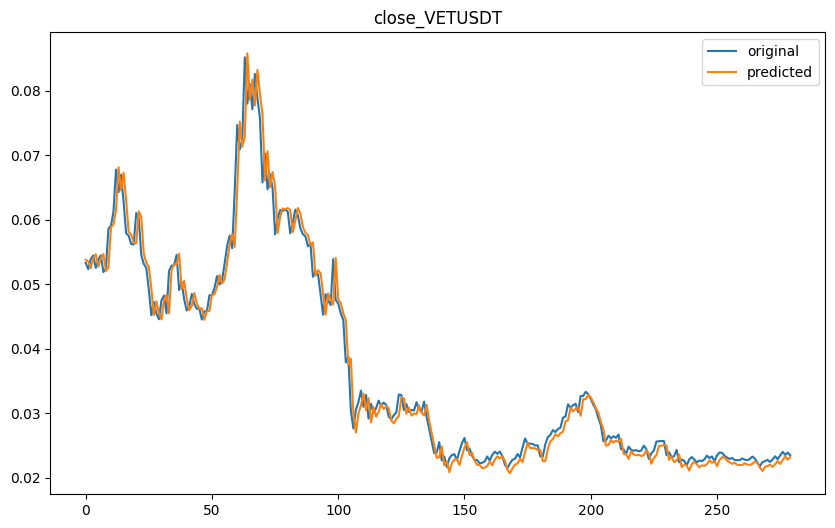

[I 2023-10-24 22:20:35,979] A new study created in RDB with name: close_IOTAUSDT


Metrics for 280 days: close_VETUSDT MSE: 6.151246458667211e-06, RMSE: 0.0024801706511180257 MAPE: 0.04308164751876588
Metrics for 90 days: close_VETUSDT MSE: 1.0521561390663353e-06, RMSE: 0.0010257466251791109 MAPE: 0.03431642749740449
Metrics for 30 days: close_VETUSDT MSE: 7.661661214412491e-07, RMSE: 0.0008753091576358887 MAPE: 0.03332350601277474
Metrics for 7 days: close_VETUSDT MSE: 9.176826585679985e-07, RMSE: 0.0009579575452847576 MAPE: 0.03494955018417
11/11 [==============================] - 0s 1ms/step - loss: 1.2635e-05 - mean_absolute_percentage_error_keras: 7.8765


[I 2023-10-24 22:20:44,171] Trial 0 finished with value: 7.876494407653809 and parameters: {'num_layers': 1, 'units_layer_0': 96, 'sequence_length': 8, 'learning_rate': 0.0009159514631188937, 'dropout_rate': 0.33713971970144196, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 0 with value: 7.876494407653809.


11/11 [==============================] - 0s 3ms/step - loss: 4.2962e-04 - mean_absolute_percentage_error_keras: 9.4653


[I 2023-10-24 22:21:04,083] Trial 1 finished with value: 9.465306282043457 and parameters: {'num_layers': 3, 'units_layer_0': 64, 'units_layer_1': 128, 'units_layer_2': 128, 'sequence_length': 4, 'learning_rate': 0.0005672618115161333, 'dropout_rate': 0.42657523628263516, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 0 with value: 7.876494407653809.


11/11 [==============================] - 0s 3ms/step - loss: 5.7157e-04 - mean_absolute_percentage_error_keras: 10.7551


[I 2023-10-24 22:21:23,671] Trial 2 finished with value: 10.755102157592773 and parameters: {'num_layers': 4, 'units_layer_0': 224, 'units_layer_1': 32, 'units_layer_2': 128, 'units_layer_3': 256, 'sequence_length': 1, 'learning_rate': 0.0008026249980615994, 'dropout_rate': 0.2461194818128693, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 0 with value: 7.876494407653809.


11/11 [==============================] - 0s 3ms/step - loss: 6.9152e-04 - mean_absolute_percentage_error_keras: 12.3455


[I 2023-10-24 22:21:41,816] Trial 3 finished with value: 12.345548629760742 and parameters: {'num_layers': 4, 'units_layer_0': 256, 'units_layer_1': 128, 'units_layer_2': 160, 'units_layer_3': 32, 'sequence_length': 4, 'learning_rate': 0.00012411959503524808, 'dropout_rate': 0.3786727475482403, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 0 with value: 7.876494407653809.


11/11 [==============================] - 0s 6ms/step - loss: 1.4215e-04 - mean_absolute_percentage_error_keras: 5.2232


[I 2023-10-24 22:22:16,444] Trial 4 finished with value: 5.223151683807373 and parameters: {'num_layers': 2, 'units_layer_0': 160, 'units_layer_1': 256, 'sequence_length': 8, 'learning_rate': 0.0009360437958373755, 'dropout_rate': 0.019811640665716, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 4 with value: 5.223151683807373.


11/11 [==============================] - 0s 2ms/step - loss: 1.1136e-04 - mean_absolute_percentage_error_keras: 4.6983


[I 2023-10-24 22:22:25,889] Trial 5 finished with value: 4.698252201080322 and parameters: {'num_layers': 1, 'units_layer_0': 192, 'sequence_length': 10, 'learning_rate': 0.00020403888885245505, 'dropout_rate': 0.062121754776152616, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 5 with value: 4.698252201080322.
[I 2023-10-24 22:22:30,773] Trial 6 pruned. 
[I 2023-10-24 22:22:39,391] Trial 7 pruned. 


11/11 [==============================] - 0s 2ms/step - loss: 2.9869e-04 - mean_absolute_percentage_error_keras: 7.9494


[I 2023-10-24 22:22:59,116] Trial 8 finished with value: 7.949376106262207 and parameters: {'num_layers': 2, 'units_layer_0': 224, 'units_layer_1': 192, 'sequence_length': 8, 'learning_rate': 0.0008953528378805777, 'dropout_rate': 0.1535433692214223, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 5 with value: 4.698252201080322.
[I 2023-10-24 22:23:02,866] Trial 9 pruned. 
[I 2023-10-24 22:23:05,717] Trial 10 pruned. 


11/11 [==============================] - 0s 3ms/step - loss: 1.0587e-04 - mean_absolute_percentage_error_keras: 4.0190


[I 2023-10-24 22:23:22,567] Trial 11 finished with value: 4.018979072570801 and parameters: {'num_layers': 1, 'units_layer_0': 160, 'sequence_length': 10, 'learning_rate': 0.0003960617769311781, 'dropout_rate': 0.0021301811004370563, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 11 with value: 4.018979072570801.


11/11 [==============================] - 0s 3ms/step - loss: 1.7220e-04 - mean_absolute_percentage_error_keras: 5.8137


[I 2023-10-24 22:23:40,162] Trial 12 finished with value: 5.813722133636475 and parameters: {'num_layers': 1, 'units_layer_0': 160, 'sequence_length': 10, 'learning_rate': 0.0003216022570681189, 'dropout_rate': 0.09363593062751982, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 11 with value: 4.018979072570801.


11/11 [==============================] - 0s 3ms/step - loss: 1.5079e-04 - mean_absolute_percentage_error_keras: 5.1422


[I 2023-10-24 22:23:55,013] Trial 13 finished with value: 5.142244338989258 and parameters: {'num_layers': 1, 'units_layer_0': 128, 'sequence_length': 10, 'learning_rate': 0.00041246813664677336, 'dropout_rate': 0.002489525803213037, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 11 with value: 4.018979072570801.


11/11 [==============================] - 0s 4ms/step - loss: 4.4615e-05 - mean_absolute_percentage_error_keras: 2.3471


[I 2023-10-24 22:24:16,595] Trial 14 finished with value: 2.3470659255981445 and parameters: {'num_layers': 3, 'units_layer_0': 192, 'units_layer_1': 256, 'units_layer_2': 256, 'sequence_length': 7, 'learning_rate': 0.0002236897927730348, 'dropout_rate': 0.08594434499580907, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 14 with value: 2.3470659255981445.


11/11 [==============================] - 0s 8ms/step - loss: 1.1559e-04 - mean_absolute_percentage_error_keras: 4.2454


[I 2023-10-24 22:25:04,614] Trial 15 finished with value: 4.245426654815674 and parameters: {'num_layers': 3, 'units_layer_0': 192, 'units_layer_1': 256, 'units_layer_2': 256, 'sequence_length': 6, 'learning_rate': 0.00046347273191534, 'dropout_rate': 0.09139016411717782, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 14 with value: 2.3470659255981445.
[I 2023-10-24 22:25:12,212] Trial 16 pruned. 
[I 2023-10-24 22:25:19,225] Trial 17 pruned. 
[I 2023-10-24 22:25:33,824] Trial 18 pruned. 


11/11 [==============================] - 0s 2ms/step - loss: 2.5919e-04 - mean_absolute_percentage_error_keras: 7.8694


[I 2023-10-24 22:25:48,559] Trial 19 finished with value: 7.869440078735352 and parameters: {'num_layers': 3, 'units_layer_0': 96, 'units_layer_1': 160, 'units_layer_2': 64, 'sequence_length': 6, 'learning_rate': 0.0005915836754470152, 'dropout_rate': 0.002009119051355826, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 14 with value: 2.3470659255981445.
[I 2023-10-24 22:25:58,535] Trial 20 pruned. 
[I 2023-10-24 22:26:42,138] Trial 21 pruned. 
[I 2023-10-24 22:27:17,987] Trial 22 pruned. 


11/11 [==============================] - 0s 6ms/step - loss: 2.9703e-04 - mean_absolute_percentage_error_keras: 6.8411


[I 2023-10-24 22:27:58,499] Trial 23 finished with value: 6.8411078453063965 and parameters: {'num_layers': 3, 'units_layer_0': 160, 'units_layer_1': 224, 'units_layer_2': 256, 'sequence_length': 5, 'learning_rate': 0.0003388040374544912, 'dropout_rate': 0.117288606696776, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 14 with value: 2.3470659255981445.


11/11 [==============================] - 0s 4ms/step - loss: 3.1792e-04 - mean_absolute_percentage_error_keras: 8.4774


[I 2023-10-24 22:28:22,046] Trial 24 finished with value: 8.477387428283691 and parameters: {'num_layers': 2, 'units_layer_0': 224, 'units_layer_1': 256, 'sequence_length': 3, 'learning_rate': 0.0005514460294996903, 'dropout_rate': 0.05465842062486353, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 14 with value: 2.3470659255981445.
[I 2023-10-24 22:28:51,609] Trial 25 pruned. 
[I 2023-10-24 22:29:09,645] Trial 26 pruned. 


11/11 [==============================] - 0s 4ms/step - loss: 1.5989e-04 - mean_absolute_percentage_error_keras: 5.0900


[I 2023-10-24 22:29:34,851] Trial 27 finished with value: 5.090033054351807 and parameters: {'num_layers': 2, 'units_layer_0': 224, 'units_layer_1': 64, 'sequence_length': 7, 'learning_rate': 0.00040568945816901443, 'dropout_rate': 0.09746893148692531, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 14 with value: 2.3470659255981445.


11/11 [==============================] - 0s 2ms/step - loss: 7.4201e-05 - mean_absolute_percentage_error_keras: 3.4980


[I 2023-10-24 22:29:50,911] Trial 28 finished with value: 3.498044729232788 and parameters: {'num_layers': 3, 'units_layer_0': 192, 'units_layer_1': 192, 'units_layer_2': 96, 'sequence_length': 5, 'learning_rate': 0.00026261995564996613, 'dropout_rate': 0.1511668192059287, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 14 with value: 2.3470659255981445.
[I 2023-10-24 22:29:53,382] Trial 29 pruned. 


11/11 [==============================] - 0s 3ms/step - loss: 4.5927e-05 - mean_absolute_percentage_error_keras: 2.4594


[I 2023-10-24 22:30:13,667] Trial 30 finished with value: 2.45937442779541 and parameters: {'num_layers': 3, 'units_layer_0': 256, 'units_layer_1': 192, 'units_layer_2': 96, 'sequence_length': 8, 'learning_rate': 0.0002828305953541142, 'dropout_rate': 0.03803776566613253, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 14 with value: 2.3470659255981445.


11/11 [==============================] - 0s 3ms/step - loss: 2.1620e-04 - mean_absolute_percentage_error_keras: 7.0741


[I 2023-10-24 22:30:35,235] Trial 31 finished with value: 7.074089527130127 and parameters: {'num_layers': 3, 'units_layer_0': 256, 'units_layer_1': 192, 'units_layer_2': 96, 'sequence_length': 8, 'learning_rate': 0.0002690857794953098, 'dropout_rate': 0.030932338128182912, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 14 with value: 2.3470659255981445.


11/11 [==============================] - 0s 3ms/step - loss: 8.3914e-05 - mean_absolute_percentage_error_keras: 3.8540


[I 2023-10-24 22:30:55,309] Trial 32 finished with value: 3.853976249694824 and parameters: {'num_layers': 3, 'units_layer_0': 256, 'units_layer_1': 160, 'units_layer_2': 96, 'sequence_length': 8, 'learning_rate': 0.0002251506042646464, 'dropout_rate': 0.0656179373780078, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 14 with value: 2.3470659255981445.


11/11 [==============================] - 0s 3ms/step - loss: 1.4781e-04 - mean_absolute_percentage_error_keras: 5.5974


[I 2023-10-24 22:31:18,435] Trial 33 finished with value: 5.597446918487549 and parameters: {'num_layers': 3, 'units_layer_0': 256, 'units_layer_1': 160, 'units_layer_2': 96, 'sequence_length': 5, 'learning_rate': 0.00021188067757581678, 'dropout_rate': 0.07470012776561258, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 14 with value: 2.3470659255981445.


11/11 [==============================] - 0s 3ms/step - loss: 6.2033e-04 - mean_absolute_percentage_error_keras: 11.4091


[I 2023-10-24 22:31:42,722] Trial 34 finished with value: 11.409132957458496 and parameters: {'num_layers': 4, 'units_layer_0': 256, 'units_layer_1': 160, 'units_layer_2': 96, 'units_layer_3': 160, 'sequence_length': 8, 'learning_rate': 0.0001276013587864215, 'dropout_rate': 0.12493152793131179, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 14 with value: 2.3470659255981445.


11/11 [==============================] - 0s 3ms/step - loss: 4.8561e-05 - mean_absolute_percentage_error_keras: 2.6788


[I 2023-10-24 22:32:01,815] Trial 35 finished with value: 2.6788136959075928 and parameters: {'num_layers': 3, 'units_layer_0': 224, 'units_layer_1': 192, 'units_layer_2': 64, 'sequence_length': 7, 'learning_rate': 0.00027640210063194177, 'dropout_rate': 0.04067101506450961, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 14 with value: 2.3470659255981445.


11/11 [==============================] - 0s 3ms/step - loss: 1.9305e-04 - mean_absolute_percentage_error_keras: 6.0595


[I 2023-10-24 22:32:19,911] Trial 36 finished with value: 6.05952787399292 and parameters: {'num_layers': 3, 'units_layer_0': 224, 'units_layer_1': 192, 'units_layer_2': 32, 'sequence_length': 7, 'learning_rate': 0.0003064531233387756, 'dropout_rate': 0.049185592327163116, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 14 with value: 2.3470659255981445.


11/11 [==============================] - 0s 3ms/step - loss: 1.3134e-04 - mean_absolute_percentage_error_keras: 4.8843


[I 2023-10-24 22:32:37,858] Trial 37 finished with value: 4.8842854499816895 and parameters: {'num_layers': 4, 'units_layer_0': 224, 'units_layer_1': 224, 'units_layer_2': 64, 'units_layer_3': 160, 'sequence_length': 4, 'learning_rate': 0.00015236713744649514, 'dropout_rate': 0.020466377167283105, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 14 with value: 2.3470659255981445.


11/11 [==============================] - 0s 2ms/step - loss: 1.0263e-04 - mean_absolute_percentage_error_keras: 4.0060


[I 2023-10-24 22:32:53,795] Trial 38 finished with value: 4.005988597869873 and parameters: {'num_layers': 3, 'units_layer_0': 224, 'units_layer_1': 128, 'units_layer_2': 64, 'sequence_length': 5, 'learning_rate': 8.305101869144526e-05, 'dropout_rate': 0.2727651837113466, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 14 with value: 2.3470659255981445.


11/11 [==============================] - 0s 3ms/step - loss: 1.2554e-04 - mean_absolute_percentage_error_keras: 4.8113


[I 2023-10-24 22:33:15,502] Trial 39 finished with value: 4.811319351196289 and parameters: {'num_layers': 4, 'units_layer_0': 192, 'units_layer_1': 192, 'units_layer_2': 128, 'units_layer_3': 96, 'sequence_length': 7, 'learning_rate': 0.0001832038855551935, 'dropout_rate': 0.11513053351989846, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 14 with value: 2.3470659255981445.


11/11 [==============================] - 0s 3ms/step - loss: 5.1284e-05 - mean_absolute_percentage_error_keras: 2.6106


[I 2023-10-24 22:33:29,398] Trial 40 finished with value: 2.610631227493286 and parameters: {'num_layers': 2, 'units_layer_0': 224, 'units_layer_1': 224, 'sequence_length': 6, 'learning_rate': 0.000244560845649126, 'dropout_rate': 0.04347164823067729, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 14 with value: 2.3470659255981445.


11/11 [==============================] - 0s 2ms/step - loss: 7.2411e-05 - mean_absolute_percentage_error_keras: 3.3322


[I 2023-10-24 22:33:43,082] Trial 41 finished with value: 3.332200765609741 and parameters: {'num_layers': 2, 'units_layer_0': 224, 'units_layer_1': 224, 'sequence_length': 6, 'learning_rate': 0.00026140356013319845, 'dropout_rate': 0.03841044923442631, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 14 with value: 2.3470659255981445.


11/11 [==============================] - 0s 2ms/step - loss: 6.7272e-05 - mean_absolute_percentage_error_keras: 3.2997


[I 2023-10-24 22:33:56,671] Trial 42 finished with value: 3.2997095584869385 and parameters: {'num_layers': 2, 'units_layer_0': 224, 'units_layer_1': 224, 'sequence_length': 6, 'learning_rate': 0.00016119295898076838, 'dropout_rate': 0.038038706954286204, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 14 with value: 2.3470659255981445.


11/11 [==============================] - 0s 3ms/step - loss: 6.7930e-05 - mean_absolute_percentage_error_keras: 3.4418


[I 2023-10-24 22:34:12,993] Trial 43 finished with value: 3.441807508468628 and parameters: {'num_layers': 2, 'units_layer_0': 256, 'units_layer_1': 224, 'sequence_length': 7, 'learning_rate': 9.153811284891926e-05, 'dropout_rate': 0.024654927561116435, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 14 with value: 2.3470659255981445.


11/11 [==============================] - 0s 3ms/step - loss: 8.1038e-05 - mean_absolute_percentage_error_keras: 3.7333


[I 2023-10-24 22:34:29,803] Trial 44 finished with value: 3.7332637310028076 and parameters: {'num_layers': 2, 'units_layer_0': 224, 'units_layer_1': 256, 'sequence_length': 8, 'learning_rate': 0.0001701110626053692, 'dropout_rate': 0.07799277627412628, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 14 with value: 2.3470659255981445.


11/11 [==============================] - 0s 4ms/step - loss: 1.6718e-04 - mean_absolute_percentage_error_keras: 6.0447


[I 2023-10-24 22:34:47,091] Trial 45 finished with value: 6.0447306632995605 and parameters: {'num_layers': 2, 'units_layer_0': 256, 'units_layer_1': 224, 'sequence_length': 9, 'learning_rate': 7.92447769790553e-05, 'dropout_rate': 0.04436867206174477, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 14 with value: 2.3470659255981445.


11/11 [==============================] - 0s 2ms/step - loss: 1.4855e-04 - mean_absolute_percentage_error_keras: 5.7333


[I 2023-10-24 22:35:01,697] Trial 46 finished with value: 5.733332633972168 and parameters: {'num_layers': 2, 'units_layer_0': 224, 'units_layer_1': 256, 'sequence_length': 6, 'learning_rate': 0.00036700612613950207, 'dropout_rate': 0.0024594473266811995, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 14 with value: 2.3470659255981445.


11/11 [==============================] - 0s 2ms/step - loss: 1.0697e-04 - mean_absolute_percentage_error_keras: 4.5005


[I 2023-10-24 22:35:15,914] Trial 47 finished with value: 4.500476837158203 and parameters: {'num_layers': 2, 'units_layer_0': 224, 'units_layer_1': 192, 'sequence_length': 7, 'learning_rate': 0.00029566321253521343, 'dropout_rate': 0.0765440708812802, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 14 with value: 2.3470659255981445.
[I 2023-10-24 22:35:20,860] Trial 48 pruned. 


11/11 [==============================] - 0s 3ms/step - loss: 2.7682e-04 - mean_absolute_percentage_error_keras: 8.3771


[I 2023-10-24 22:35:41,713] Trial 49 finished with value: 8.377141952514648 and parameters: {'num_layers': 3, 'units_layer_0': 192, 'units_layer_1': 256, 'units_layer_2': 160, 'sequence_length': 8, 'learning_rate': 0.0003620691953129441, 'dropout_rate': 0.04167481251450375, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 14 with value: 2.3470659255981445.


Best Hyperparameters: {'num_layers': 3, 'units_layer_0': 192, 'units_layer_1': 256, 'units_layer_2': 256, 'sequence_length': 7, 'learning_rate': 0.0002236897927730348, 'dropout_rate': 0.08594434499580907, 'min_max_scaling': 0, 'layer_type': 'RNN'}
Epoch 1/100
46/46 [==============================] - 2s 9ms/step - loss: 0.0838
Epoch 2/100
46/46 [==============================] - 0s 8ms/step - loss: 0.0110
Epoch 3/100
46/46 [==============================] - 0s 8ms/step - loss: 0.0100
Epoch 4/100
46/46 [==============================] - 0s 9ms/step - loss: 0.0084
Epoch 5/100
46/46 [==============================] - 0s 8ms/step - loss: 0.0083
Epoch 6/100
46/46 [==============================] - 0s 10ms/step - loss: 0.0081
Epoch 7/100
46/46 [==============================] - 0s 9ms/step - loss: 0.0067
Epoch 8/100
46/46 [==============================] - 0s 9ms/step - loss: 0.0061
Epoch 9/100
46/46 [==============================] - 0s 9ms/step - loss: 0.0071
Epoch 10/100
46/46 [===========

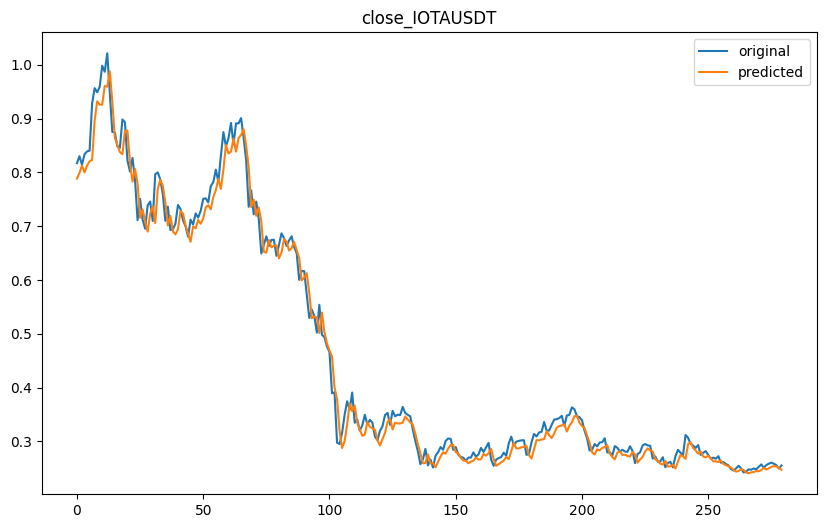

[I 2023-10-24 22:36:24,571] A new study created in RDB with name: close_ADAUSDT


Metrics for 280 days: close_IOTAUSDT MSE: 0.000641555779692539, RMSE: 0.025328951413205777 MAPE: 0.040744561616391964
Metrics for 90 days: close_IOTAUSDT MSE: 0.00014266301492771777, RMSE: 0.011944162378656687 MAPE: 0.031714242966434165
Metrics for 30 days: close_IOTAUSDT MSE: 3.3704591462488356e-05, RMSE: 0.005805565559227486 MAPE: 0.01897239473745007
Metrics for 7 days: close_IOTAUSDT MSE: 4.2326300343973224e-05, RMSE: 0.006505866609758705 MAPE: 0.022957920141954163
11/11 [==============================] - 0s 2ms/step - loss: 3.1427e-05 - mean_absolute_percentage_error_keras: 4.0422


[I 2023-10-24 22:36:35,624] Trial 0 finished with value: 4.042227268218994 and parameters: {'num_layers': 2, 'units_layer_0': 128, 'units_layer_1': 224, 'sequence_length': 4, 'learning_rate': 0.00011054905132043013, 'dropout_rate': 0.28559676029770764, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 0 with value: 4.042227268218994.


11/11 [==============================] - 0s 1ms/step - loss: 1.3388e-04 - mean_absolute_percentage_error_keras: 9.7727


[I 2023-10-24 22:36:44,588] Trial 1 finished with value: 9.77271842956543 and parameters: {'num_layers': 1, 'units_layer_0': 32, 'sequence_length': 6, 'learning_rate': 0.00010454670314528704, 'dropout_rate': 0.03968384234325695, 'min_max_scaling': 1, 'layer_type': 'LSTM'}. Best is trial 0 with value: 4.042227268218994.
2023-10-24 22:36:47.118195: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_155/simple_rnn_208/while/body/_74/sequential_155/simple_rnn_208/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-24 22:36:47.120295: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_155/simple_rnn_207/while/body/_1/sequential_155/simple_rnn_207/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-24 22:36:47.121777: W tensorflow/core/grappler/utils/graph_view.cc:849] No regis

11/11 [==============================] - 0s 2ms/step - loss: 9.6197e-04 - mean_absolute_percentage_error_keras: 9.0923


[I 2023-10-24 22:36:57,802] Trial 2 finished with value: 9.09228515625 and parameters: {'num_layers': 3, 'units_layer_0': 224, 'units_layer_1': 160, 'units_layer_2': 128, 'sequence_length': 2, 'learning_rate': 0.0007439634398232454, 'dropout_rate': 0.1678134702170176, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 0 with value: 4.042227268218994.


11/11 [==============================] - 0s 3ms/step - loss: 0.0035 - mean_absolute_percentage_error_keras: 15.4199


[I 2023-10-24 22:37:17,325] Trial 3 finished with value: 15.41989803314209 and parameters: {'num_layers': 3, 'units_layer_0': 64, 'units_layer_1': 160, 'units_layer_2': 32, 'sequence_length': 4, 'learning_rate': 0.0003716406261630279, 'dropout_rate': 0.08899858973013836, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 0 with value: 4.042227268218994.


11/11 [==============================] - 0s 3ms/step - loss: 3.0686e-04 - mean_absolute_percentage_error_keras: 4.6928


[I 2023-10-24 22:37:29,442] Trial 4 finished with value: 4.692792892456055 and parameters: {'num_layers': 2, 'units_layer_0': 224, 'units_layer_1': 224, 'sequence_length': 4, 'learning_rate': 0.000786419309854091, 'dropout_rate': 0.3137401784135121, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 0 with value: 4.042227268218994.
[I 2023-10-24 22:37:33,038] Trial 5 pruned. 
[I 2023-10-24 22:37:38,192] Trial 6 pruned. 
[I 2023-10-24 22:37:49,812] Trial 7 pruned. 
[I 2023-10-24 22:37:59,091] Trial 8 pruned. 
[I 2023-10-24 22:38:12,473] Trial 9 pruned. 
2023-10-24 22:38:15.089846: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_163/simple_rnn_213/while/body/_74/sequential_163/simple_rnn_213/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-24 22:38:15.091532: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with 

11/11 [==============================] - 0s 2ms/step - loss: 1.9971e-04 - mean_absolute_percentage_error_keras: 3.3466


[I 2023-10-24 22:38:29,231] Trial 11 finished with value: 3.346607208251953 and parameters: {'num_layers': 2, 'units_layer_0': 160, 'units_layer_1': 224, 'sequence_length': 4, 'learning_rate': 0.0006009813070677601, 'dropout_rate': 0.34163716996098537, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 11 with value: 3.346607208251953.


11/11 [==============================] - 0s 2ms/step - loss: 7.2293e-04 - mean_absolute_percentage_error_keras: 27.2021


[I 2023-10-24 22:38:40,100] Trial 12 finished with value: 27.202062606811523 and parameters: {'num_layers': 2, 'units_layer_0': 160, 'units_layer_1': 256, 'sequence_length': 3, 'learning_rate': 0.00056951262487822, 'dropout_rate': 0.3666534399218415, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 11 with value: 3.346607208251953.


11/11 [==============================] - 0s 2ms/step - loss: 0.0012 - mean_absolute_percentage_error_keras: 10.0662


[I 2023-10-24 22:38:50,197] Trial 13 finished with value: 10.06619930267334 and parameters: {'num_layers': 2, 'units_layer_0': 128, 'units_layer_1': 96, 'sequence_length': 5, 'learning_rate': 0.000529505170056042, 'dropout_rate': 0.3683081199193726, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 11 with value: 3.346607208251953.
2023-10-24 22:38:51.474430: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_167/simple_rnn_222/while/body/_1/sequential_167/simple_rnn_222/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-24 22:38:51.475990: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_167/simple_rnn_223/while/body/_74/sequential_167/simple_rnn_223/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-24 22:38:51.506704: E tensorflow/core/grappler/optimizers/t

11/11 [==============================] - 0s 2ms/step - loss: 8.6483e-05 - mean_absolute_percentage_error_keras: 8.2770


[I 2023-10-24 22:39:11,551] Trial 15 finished with value: 8.276973724365234 and parameters: {'num_layers': 3, 'units_layer_0': 192, 'units_layer_1': 96, 'units_layer_2': 128, 'sequence_length': 5, 'learning_rate': 0.00015620503515501472, 'dropout_rate': 0.32160844416637163, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 11 with value: 3.346607208251953.


11/11 [==============================] - 0s 2ms/step - loss: 2.0968e-04 - mean_absolute_percentage_error_keras: 3.1315


[I 2023-10-24 22:39:22,655] Trial 16 finished with value: 3.1314826011657715 and parameters: {'num_layers': 1, 'units_layer_0': 256, 'sequence_length': 10, 'learning_rate': 0.0004788644862060943, 'dropout_rate': 0.48615983779111116, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 16 with value: 3.1314826011657715.


11/11 [==============================] - 0s 2ms/step - loss: 3.6130e-04 - mean_absolute_percentage_error_keras: 4.4308


[I 2023-10-24 22:39:33,541] Trial 17 finished with value: 4.430751323699951 and parameters: {'num_layers': 1, 'units_layer_0': 256, 'sequence_length': 10, 'learning_rate': 0.00046859170824442716, 'dropout_rate': 0.4969461361086542, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 16 with value: 3.1314826011657715.


11/11 [==============================] - 0s 2ms/step - loss: 2.5829e-04 - mean_absolute_percentage_error_keras: 3.8123


[I 2023-10-24 22:39:44,169] Trial 18 finished with value: 3.812329053878784 and parameters: {'num_layers': 1, 'units_layer_0': 256, 'sequence_length': 10, 'learning_rate': 0.0006167565908125984, 'dropout_rate': 0.4938157238707321, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 16 with value: 3.1314826011657715.


11/11 [==============================] - 0s 1ms/step - loss: 2.4276e-04 - mean_absolute_percentage_error_keras: 3.4523


[I 2023-10-24 22:39:52,840] Trial 19 finished with value: 3.45225191116333 and parameters: {'num_layers': 1, 'units_layer_0': 192, 'sequence_length': 8, 'learning_rate': 0.000452748938769958, 'dropout_rate': 0.392944701536244, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 16 with value: 3.1314826011657715.


11/11 [==============================] - 0s 1ms/step - loss: 5.0681e-04 - mean_absolute_percentage_error_keras: 5.5291


[I 2023-10-24 22:40:01,015] Trial 20 finished with value: 5.529088497161865 and parameters: {'num_layers': 1, 'units_layer_0': 192, 'sequence_length': 6, 'learning_rate': 0.000666369993600995, 'dropout_rate': 0.42733848288072374, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 16 with value: 3.1314826011657715.


11/11 [==============================] - 0s 2ms/step - loss: 3.6775e-04 - mean_absolute_percentage_error_keras: 4.5541


[I 2023-10-24 22:40:10,298] Trial 21 finished with value: 4.554129123687744 and parameters: {'num_layers': 1, 'units_layer_0': 192, 'sequence_length': 9, 'learning_rate': 0.00046418741094613174, 'dropout_rate': 0.38367259390383457, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 16 with value: 3.1314826011657715.


11/11 [==============================] - 0s 1ms/step - loss: 3.2210e-04 - mean_absolute_percentage_error_keras: 4.0415


[I 2023-10-24 22:40:19,097] Trial 22 finished with value: 4.04148530960083 and parameters: {'num_layers': 1, 'units_layer_0': 160, 'sequence_length': 9, 'learning_rate': 0.00045795972663407303, 'dropout_rate': 0.40601692372443937, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 16 with value: 3.1314826011657715.


11/11 [==============================] - 0s 2ms/step - loss: 0.0018 - mean_absolute_percentage_error_keras: 12.8970


[I 2023-10-24 22:40:33,685] Trial 23 finished with value: 12.89699935913086 and parameters: {'num_layers': 2, 'units_layer_0': 256, 'units_layer_1': 96, 'sequence_length': 8, 'learning_rate': 0.0005639592782356792, 'dropout_rate': 0.4662811986028789, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 16 with value: 3.1314826011657715.


11/11 [==============================] - 0s 2ms/step - loss: 1.7637e-04 - mean_absolute_percentage_error_keras: 2.7962


[I 2023-10-24 22:40:43,116] Trial 24 finished with value: 2.7962210178375244 and parameters: {'num_layers': 1, 'units_layer_0': 192, 'sequence_length': 10, 'learning_rate': 0.00040392602444099223, 'dropout_rate': 0.40435062816659073, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 24 with value: 2.7962210178375244.


11/11 [==============================] - 0s 2ms/step - loss: 0.0011 - mean_absolute_percentage_error_keras: 9.9613


[I 2023-10-24 22:40:58,254] Trial 25 finished with value: 9.961342811584473 and parameters: {'num_layers': 2, 'units_layer_0': 224, 'units_layer_1': 32, 'sequence_length': 10, 'learning_rate': 0.0003826349990802486, 'dropout_rate': 0.3417259933201079, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 24 with value: 2.7962210178375244.


11/11 [==============================] - 0s 1ms/step - loss: 1.5264e-04 - mean_absolute_percentage_error_keras: 2.5381


[I 2023-10-24 22:41:06,242] Trial 26 finished with value: 2.538142681121826 and parameters: {'num_layers': 1, 'units_layer_0': 160, 'sequence_length': 7, 'learning_rate': 0.0005220578453989106, 'dropout_rate': 0.41826788411535853, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 26 with value: 2.538142681121826.


11/11 [==============================] - 0s 2ms/step - loss: 0.0011 - mean_absolute_percentage_error_keras: 9.0719


[I 2023-10-24 22:41:13,175] Trial 27 finished with value: 9.071925163269043 and parameters: {'num_layers': 1, 'units_layer_0': 96, 'sequence_length': 7, 'learning_rate': 0.0005148238573599507, 'dropout_rate': 0.4547529301387129, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 26 with value: 2.538142681121826.


11/11 [==============================] - 0s 2ms/step - loss: 0.0013 - mean_absolute_percentage_error_keras: 10.0160


[I 2023-10-24 22:41:22,799] Trial 28 finished with value: 10.015970230102539 and parameters: {'num_layers': 1, 'units_layer_0': 192, 'sequence_length': 9, 'learning_rate': 0.0002939862739124643, 'dropout_rate': 0.4767843208182328, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 26 with value: 2.538142681121826.


11/11 [==============================] - 0s 2ms/step - loss: 5.6971e-04 - mean_absolute_percentage_error_keras: 5.6068


[I 2023-10-24 22:41:33,964] Trial 29 finished with value: 5.606768608093262 and parameters: {'num_layers': 1, 'units_layer_0': 256, 'sequence_length': 10, 'learning_rate': 0.00041472920822937566, 'dropout_rate': 0.4174406840575021, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 26 with value: 2.538142681121826.


11/11 [==============================] - 0s 2ms/step - loss: 4.3545e-04 - mean_absolute_percentage_error_keras: 5.1382


[I 2023-10-24 22:41:43,389] Trial 30 finished with value: 5.138247966766357 and parameters: {'num_layers': 1, 'units_layer_0': 224, 'sequence_length': 8, 'learning_rate': 0.000679925985226979, 'dropout_rate': 0.4130462861890154, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 26 with value: 2.538142681121826.


11/11 [==============================] - 0s 2ms/step - loss: 2.4433e-04 - mean_absolute_percentage_error_keras: 3.5820


[I 2023-10-24 22:41:53,487] Trial 31 finished with value: 3.5820140838623047 and parameters: {'num_layers': 2, 'units_layer_0': 160, 'units_layer_1': 128, 'sequence_length': 3, 'learning_rate': 0.000545538729800721, 'dropout_rate': 0.34429236075957, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 26 with value: 2.538142681121826.


11/11 [==============================] - 0s 1ms/step - loss: 5.6457e-04 - mean_absolute_percentage_error_keras: 6.6692


[I 2023-10-24 22:42:00,400] Trial 32 finished with value: 6.66917085647583 and parameters: {'num_layers': 1, 'units_layer_0': 128, 'sequence_length': 6, 'learning_rate': 0.0005969338403673616, 'dropout_rate': 0.45743021191005206, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 26 with value: 2.538142681121826.


11/11 [==============================] - 0s 2ms/step - loss: 2.0524e-04 - mean_absolute_percentage_error_keras: 3.0280


[I 2023-10-24 22:42:07,568] Trial 33 finished with value: 3.0280203819274902 and parameters: {'num_layers': 1, 'units_layer_0': 160, 'sequence_length': 5, 'learning_rate': 0.0004977508630378279, 'dropout_rate': 0.38800320152019974, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 26 with value: 2.538142681121826.


11/11 [==============================] - 0s 1ms/step - loss: 7.9266e-04 - mean_absolute_percentage_error_keras: 7.2740


[I 2023-10-24 22:42:14,557] Trial 34 finished with value: 7.274031162261963 and parameters: {'num_layers': 1, 'units_layer_0': 96, 'sequence_length': 5, 'learning_rate': 0.00048708327018635953, 'dropout_rate': 0.42410189872085174, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 26 with value: 2.538142681121826.


11/11 [==============================] - 0s 1ms/step - loss: 8.0851e-04 - mean_absolute_percentage_error_keras: 7.7817


[I 2023-10-24 22:42:23,426] Trial 35 finished with value: 7.781681060791016 and parameters: {'num_layers': 1, 'units_layer_0': 192, 'sequence_length': 6, 'learning_rate': 0.0004117935884555984, 'dropout_rate': 0.39473468861999084, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 26 with value: 2.538142681121826.


11/11 [==============================] - 0s 1ms/step - loss: 1.8699e-04 - mean_absolute_percentage_error_keras: 2.8297


[I 2023-10-24 22:42:31,724] Trial 36 finished with value: 2.829697370529175 and parameters: {'num_layers': 1, 'units_layer_0': 160, 'sequence_length': 7, 'learning_rate': 0.0005235209985004783, 'dropout_rate': 0.49621945199836837, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 26 with value: 2.538142681121826.
[I 2023-10-24 22:42:42,205] Trial 37 pruned. 


11/11 [==============================] - 0s 2ms/step - loss: 4.1893e-04 - mean_absolute_percentage_error_keras: 4.7496


[I 2023-10-24 22:42:58,769] Trial 38 finished with value: 4.749574184417725 and parameters: {'num_layers': 3, 'units_layer_0': 128, 'units_layer_1': 64, 'units_layer_2': 256, 'sequence_length': 6, 'learning_rate': 0.0005233177485092124, 'dropout_rate': 0.3081736563287678, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 26 with value: 2.538142681121826.


11/11 [==============================] - 0s 4ms/step - loss: 0.0040 - mean_absolute_percentage_error_keras: 18.3805


[I 2023-10-24 22:43:13,448] Trial 39 finished with value: 18.380542755126953 and parameters: {'num_layers': 1, 'units_layer_0': 160, 'sequence_length': 7, 'learning_rate': 0.00041230522939578797, 'dropout_rate': 0.4359025947952575, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 26 with value: 2.538142681121826.


11/11 [==============================] - 0s 2ms/step - loss: 1.8852e-04 - mean_absolute_percentage_error_keras: 3.1769


[I 2023-10-24 22:43:23,893] Trial 40 finished with value: 3.176943063735962 and parameters: {'num_layers': 2, 'units_layer_0': 96, 'units_layer_1': 64, 'sequence_length': 5, 'learning_rate': 0.0006425213079786475, 'dropout_rate': 0.37365164894535413, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 26 with value: 2.538142681121826.


11/11 [==============================] - 0s 2ms/step - loss: 3.3895e-04 - mean_absolute_percentage_error_keras: 4.3681


[I 2023-10-24 22:43:34,509] Trial 41 finished with value: 4.368129730224609 and parameters: {'num_layers': 1, 'units_layer_0': 224, 'sequence_length': 9, 'learning_rate': 0.0005025925625086083, 'dropout_rate': 0.49204175271475675, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 26 with value: 2.538142681121826.


11/11 [==============================] - 0s 1ms/step - loss: 0.0020 - mean_absolute_percentage_error_keras: 13.7100


[I 2023-10-24 22:43:41,882] Trial 42 finished with value: 13.709996223449707 and parameters: {'num_layers': 1, 'units_layer_0': 32, 'sequence_length': 8, 'learning_rate': 0.0005641674279827886, 'dropout_rate': 0.4806840740231828, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 26 with value: 2.538142681121826.


11/11 [==============================] - 0s 2ms/step - loss: 0.0012 - mean_absolute_percentage_error_keras: 9.1694


[I 2023-10-24 22:43:51,359] Trial 43 finished with value: 9.169388771057129 and parameters: {'num_layers': 1, 'units_layer_0': 192, 'sequence_length': 10, 'learning_rate': 0.0004275247165041267, 'dropout_rate': 0.4999212355678091, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 26 with value: 2.538142681121826.


11/11 [==============================] - 0s 3ms/step - loss: 0.0015 - mean_absolute_percentage_error_keras: 10.5192


[I 2023-10-24 22:44:07,087] Trial 44 finished with value: 10.519221305847168 and parameters: {'num_layers': 1, 'units_layer_0': 160, 'sequence_length': 9, 'learning_rate': 0.0005031160450664944, 'dropout_rate': 0.44344366831347515, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 26 with value: 2.538142681121826.
[I 2023-10-24 22:44:14,432] Trial 45 pruned. 


11/11 [==============================] - 0s 1ms/step - loss: 8.3689e-05 - mean_absolute_percentage_error_keras: 8.5610


[I 2023-10-24 22:44:21,266] Trial 46 finished with value: 8.560968399047852 and parameters: {'num_layers': 1, 'units_layer_0': 128, 'sequence_length': 3, 'learning_rate': 0.00070649489726446, 'dropout_rate': 0.4112598483908874, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 26 with value: 2.538142681121826.


11/11 [==============================] - 0s 2ms/step - loss: 0.0014 - mean_absolute_percentage_error_keras: 10.4225


[I 2023-10-24 22:44:34,380] Trial 47 finished with value: 10.422494888305664 and parameters: {'num_layers': 2, 'units_layer_0': 160, 'units_layer_1': 192, 'sequence_length': 6, 'learning_rate': 0.0006261617718446908, 'dropout_rate': 0.43814898463412544, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 26 with value: 2.538142681121826.


11/11 [==============================] - 0s 2ms/step - loss: 0.0022 - mean_absolute_percentage_error_keras: 11.9148


[I 2023-10-24 22:44:47,388] Trial 48 finished with value: 11.914828300476074 and parameters: {'num_layers': 1, 'units_layer_0': 192, 'sequence_length': 4, 'learning_rate': 0.0005729486565680611, 'dropout_rate': 0.47310205739050204, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 26 with value: 2.538142681121826.


11/11 [==============================] - 0s 2ms/step - loss: 3.1085e-04 - mean_absolute_percentage_error_keras: 4.7191


[I 2023-10-24 22:44:59,292] Trial 49 finished with value: 4.719124794006348 and parameters: {'num_layers': 2, 'units_layer_0': 128, 'units_layer_1': 64, 'sequence_length': 8, 'learning_rate': 0.00048357845268707, 'dropout_rate': 0.39990774677143837, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 26 with value: 2.538142681121826.


Best Hyperparameters: {'num_layers': 1, 'units_layer_0': 160, 'sequence_length': 7, 'learning_rate': 0.0005220578453989106, 'dropout_rate': 0.41826788411535853, 'min_max_scaling': 0, 'layer_type': 'RNN'}
Epoch 1/100
46/46 [==============================] - 1s 2ms/step - loss: 0.1118
Epoch 2/100
46/46 [==============================] - 0s 2ms/step - loss: 0.0316
Epoch 3/100
46/46 [==============================] - 0s 2ms/step - loss: 0.0248
Epoch 4/100
46/46 [==============================] - 0s 2ms/step - loss: 0.0210
Epoch 5/100
46/46 [==============================] - 0s 2ms/step - loss: 0.0189
Epoch 6/100
46/46 [==============================] - 0s 2ms/step - loss: 0.0149
Epoch 7/100
46/46 [==============================] - 0s 2ms/step - loss: 0.0157
Epoch 8/100
46/46 [==============================] - 0s 3ms/step - loss: 0.0174
Epoch 9/100
46/46 [==============================] - 0s 2ms/step - loss: 0.0151
Epoch 10/100
46/46 [==============================] - 0s 2ms/step - loss: 0.

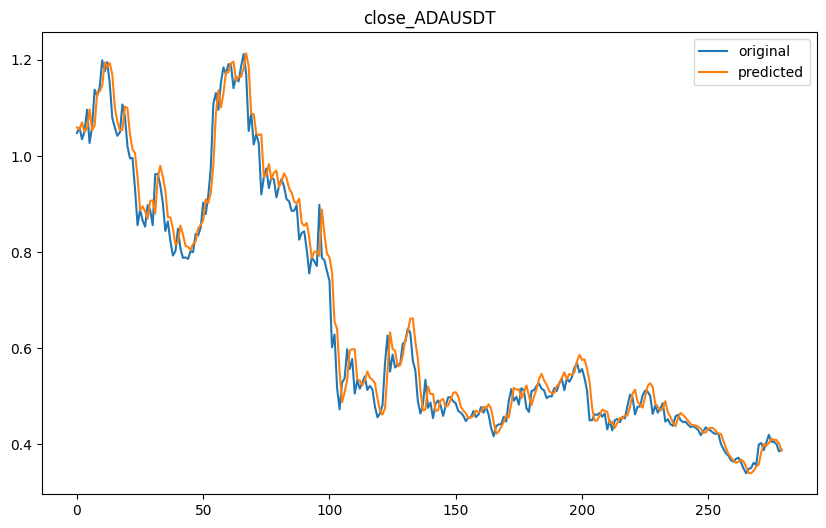

Metrics for 280 days: close_ADAUSDT MSE: 0.0014566759446195403, RMSE: 0.03816642431011242 MAPE: 0.04189345732449099
Metrics for 90 days: close_ADAUSDT MSE: 0.0003868286476709447, RMSE: 0.019667959926513597 MAPE: 0.031509372779954
Metrics for 30 days: close_ADAUSDT MSE: 0.00017015553829271838, RMSE: 0.013044368067971648 MAPE: 0.026686635867048832
Metrics for 7 days: close_ADAUSDT MSE: 0.00010843507709153751, RMSE: 0.01041321646233946 MAPE: 0.022144742716898213


[I 2023-10-24 22:45:11,976] A new study created in RDB with name: close_XRPUSDT


11/11 [==============================] - 0s 2ms/step - loss: 5.9774e-04 - mean_absolute_percentage_error_keras: 2.3915


[I 2023-10-24 22:45:21,563] Trial 0 finished with value: 2.3914883136749268 and parameters: {'num_layers': 1, 'units_layer_0': 256, 'sequence_length': 7, 'learning_rate': 0.0004265227656601267, 'dropout_rate': 0.03955239680096195, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 0 with value: 2.3914883136749268.


11/11 [==============================] - 0s 3ms/step - loss: 9.0124e-04 - mean_absolute_percentage_error_keras: 3.6578


[I 2023-10-24 22:45:40,793] Trial 1 finished with value: 3.657780170440674 and parameters: {'num_layers': 3, 'units_layer_0': 256, 'units_layer_1': 128, 'units_layer_2': 96, 'sequence_length': 2, 'learning_rate': 0.0009149070592804155, 'dropout_rate': 0.34996887393075277, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 0 with value: 2.3914883136749268.
2023-10-24 22:45:43.369128: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_206/simple_rnn_272/while/body/_157/sequential_206/simple_rnn_272/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-24 22:45:43.371366: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_206/simple_rnn_271/while/body/_74/sequential_206/simple_rnn_271/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-24 22:45:43.373453: W tensorflow/

11/11 [==============================] - 0s 1ms/step - loss: 9.4535e-04 - mean_absolute_percentage_error_keras: 3.7629


[I 2023-10-24 22:45:52,432] Trial 2 finished with value: 3.7629411220550537 and parameters: {'num_layers': 4, 'units_layer_0': 128, 'units_layer_1': 96, 'units_layer_2': 32, 'units_layer_3': 224, 'sequence_length': 1, 'learning_rate': 0.0002857028300652457, 'dropout_rate': 0.07304837600150615, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 0 with value: 2.3914883136749268.


11/11 [==============================] - 0s 2ms/step - loss: 4.4653e-04 - mean_absolute_percentage_error_keras: 5.6470


[I 2023-10-24 22:46:01,578] Trial 3 finished with value: 5.64697790145874 and parameters: {'num_layers': 1, 'units_layer_0': 64, 'sequence_length': 6, 'learning_rate': 3.2831264816900956e-05, 'dropout_rate': 0.26598595717403767, 'min_max_scaling': 1, 'layer_type': 'LSTM'}. Best is trial 0 with value: 2.3914883136749268.


11/11 [==============================] - 0s 3ms/step - loss: 3.3864e-04 - mean_absolute_percentage_error_keras: 4.8885


[I 2023-10-24 22:46:18,441] Trial 4 finished with value: 4.888455867767334 and parameters: {'num_layers': 2, 'units_layer_0': 128, 'units_layer_1': 64, 'sequence_length': 6, 'learning_rate': 0.0009390380782367594, 'dropout_rate': 0.4248043258373457, 'min_max_scaling': 1, 'layer_type': 'LSTM'}. Best is trial 0 with value: 2.3914883136749268.
[I 2023-10-24 22:46:25,556] Trial 5 pruned. 
[I 2023-10-24 22:46:40,670] Trial 6 pruned. 
[I 2023-10-24 22:46:45,296] Trial 7 pruned. 
[I 2023-10-24 22:46:52,671] Trial 8 pruned. 
[I 2023-10-24 22:46:55,880] Trial 9 pruned. 


11/11 [==============================] - 0s 1ms/step - loss: 7.9953e-04 - mean_absolute_percentage_error_keras: 3.9633


[I 2023-10-24 22:47:05,405] Trial 10 finished with value: 3.9633214473724365 and parameters: {'num_layers': 1, 'units_layer_0': 192, 'sequence_length': 9, 'learning_rate': 0.0006441368779969954, 'dropout_rate': 0.1893025302511649, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 0 with value: 2.3914883136749268.
[I 2023-10-24 22:47:14,107] Trial 11 pruned. 


11/11 [==============================] - 0s 3ms/step - loss: 0.0024 - mean_absolute_percentage_error_keras: 8.4321


[I 2023-10-24 22:47:32,283] Trial 12 finished with value: 8.432066917419434 and parameters: {'num_layers': 3, 'units_layer_0': 224, 'units_layer_1': 192, 'units_layer_2': 128, 'sequence_length': 7, 'learning_rate': 0.0009862794605232164, 'dropout_rate': 0.3225908034908454, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 0 with value: 2.3914883136749268.
[I 2023-10-24 22:47:38,002] Trial 13 pruned. 


11/11 [==============================] - 0s 2ms/step - loss: 6.5967e-04 - mean_absolute_percentage_error_keras: 2.8179


[I 2023-10-24 22:47:49,918] Trial 14 finished with value: 2.817882537841797 and parameters: {'num_layers': 2, 'units_layer_0': 256, 'units_layer_1': 256, 'sequence_length': 3, 'learning_rate': 0.0007905589914293223, 'dropout_rate': 0.23373564058722412, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 0 with value: 2.3914883136749268.


11/11 [==============================] - 0s 1ms/step - loss: 6.8622e-04 - mean_absolute_percentage_error_keras: 3.2444


[I 2023-10-24 22:47:58,786] Trial 15 finished with value: 3.244426727294922 and parameters: {'num_layers': 1, 'units_layer_0': 192, 'sequence_length': 5, 'learning_rate': 0.0007396711440514018, 'dropout_rate': 0.22687182395032388, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 0 with value: 2.3914883136749268.


11/11 [==============================] - 0s 3ms/step - loss: 9.3246e-04 - mean_absolute_percentage_error_keras: 4.2971


[I 2023-10-24 22:48:15,323] Trial 16 finished with value: 4.297133922576904 and parameters: {'num_layers': 2, 'units_layer_0': 224, 'units_layer_1': 256, 'sequence_length': 8, 'learning_rate': 0.0004966666754496468, 'dropout_rate': 0.11833822179982781, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 0 with value: 2.3914883136749268.
[I 2023-10-24 22:48:18,232] Trial 17 pruned. 


11/11 [==============================] - 0s 2ms/step - loss: 7.6235e-04 - mean_absolute_percentage_error_keras: 3.5181


[I 2023-10-24 22:48:32,122] Trial 18 finished with value: 3.518092632293701 and parameters: {'num_layers': 2, 'units_layer_0': 256, 'units_layer_1': 224, 'sequence_length': 5, 'learning_rate': 0.0006034863739156844, 'dropout_rate': 0.014906654002492636, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 0 with value: 2.3914883136749268.


11/11 [==============================] - 0s 1ms/step - loss: 7.5975e-04 - mean_absolute_percentage_error_keras: 3.1442


[I 2023-10-24 22:48:39,205] Trial 19 finished with value: 3.1442315578460693 and parameters: {'num_layers': 1, 'units_layer_0': 96, 'sequence_length': 7, 'learning_rate': 0.0008119078190392916, 'dropout_rate': 0.11329148409478039, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 0 with value: 2.3914883136749268.
[I 2023-10-24 22:48:43,480] Trial 20 pruned. 


11/11 [==============================] - 0s 1ms/step - loss: 0.0015 - mean_absolute_percentage_error_keras: 6.8357


[I 2023-10-24 22:48:50,592] Trial 21 finished with value: 6.835711479187012 and parameters: {'num_layers': 1, 'units_layer_0': 96, 'sequence_length': 7, 'learning_rate': 0.0008004554283610396, 'dropout_rate': 0.11874553895916677, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 0 with value: 2.3914883136749268.


11/11 [==============================] - 0s 2ms/step - loss: 0.0012 - mean_absolute_percentage_error_keras: 5.6577


[I 2023-10-24 22:48:58,743] Trial 22 finished with value: 5.65770959854126 and parameters: {'num_layers': 1, 'units_layer_0': 96, 'sequence_length': 7, 'learning_rate': 0.0007987270554885961, 'dropout_rate': 0.08092401835760041, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 0 with value: 2.3914883136749268.


11/11 [==============================] - 0s 2ms/step - loss: 6.1361e-04 - mean_absolute_percentage_error_keras: 2.4218


[I 2023-10-24 22:49:06,295] Trial 23 finished with value: 2.4217958450317383 and parameters: {'num_layers': 1, 'units_layer_0': 96, 'sequence_length': 8, 'learning_rate': 0.0006572901710452533, 'dropout_rate': 0.14012287890363803, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 0 with value: 2.3914883136749268.


11/11 [==============================] - 0s 4ms/step - loss: 6.0004e-04 - mean_absolute_percentage_error_keras: 2.4019


[I 2023-10-24 22:49:20,445] Trial 24 finished with value: 2.4019484519958496 and parameters: {'num_layers': 2, 'units_layer_0': 64, 'units_layer_1': 224, 'sequence_length': 10, 'learning_rate': 0.0006176994812326835, 'dropout_rate': 0.19145305735191262, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 0 with value: 2.3914883136749268.
[I 2023-10-24 22:49:23,261] Trial 25 pruned. 


11/11 [==============================] - 0s 2ms/step - loss: 0.0011 - mean_absolute_percentage_error_keras: 5.1627


[I 2023-10-24 22:49:36,379] Trial 26 finished with value: 5.1626996994018555 and parameters: {'num_layers': 2, 'units_layer_0': 64, 'units_layer_1': 224, 'sequence_length': 9, 'learning_rate': 0.0005890545216907154, 'dropout_rate': 0.039536583687995175, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 0 with value: 2.3914883136749268.


11/11 [==============================] - 0s 1ms/step - loss: 6.0054e-04 - mean_absolute_percentage_error_keras: 2.4999


[I 2023-10-24 22:49:44,376] Trial 27 finished with value: 2.499880313873291 and parameters: {'num_layers': 1, 'units_layer_0': 128, 'sequence_length': 9, 'learning_rate': 0.0006875778012659647, 'dropout_rate': 0.04437183335812722, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 0 with value: 2.3914883136749268.


11/11 [==============================] - 0s 1ms/step - loss: 7.1704e-04 - mean_absolute_percentage_error_keras: 3.1395


[I 2023-10-24 22:49:52,271] Trial 28 finished with value: 3.1394903659820557 and parameters: {'num_layers': 1, 'units_layer_0': 64, 'sequence_length': 8, 'learning_rate': 0.0005564696188743114, 'dropout_rate': 0.10166003602356942, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 0 with value: 2.3914883136749268.


11/11 [==============================] - 0s 3ms/step - loss: 7.0216e-04 - mean_absolute_percentage_error_keras: 3.0460


[I 2023-10-24 22:50:05,787] Trial 29 finished with value: 3.0460002422332764 and parameters: {'num_layers': 2, 'units_layer_0': 96, 'units_layer_1': 160, 'sequence_length': 10, 'learning_rate': 0.00042597231956075605, 'dropout_rate': 0.15002716154585471, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 0 with value: 2.3914883136749268.
[I 2023-10-24 22:50:15,907] Trial 30 pruned. 


11/11 [==============================] - 0s 1ms/step - loss: 6.1602e-04 - mean_absolute_percentage_error_keras: 2.6725


[I 2023-10-24 22:50:27,129] Trial 31 finished with value: 2.672529935836792 and parameters: {'num_layers': 1, 'units_layer_0': 128, 'sequence_length': 9, 'learning_rate': 0.000705651760549675, 'dropout_rate': 0.041885854679978185, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 0 with value: 2.3914883136749268.


11/11 [==============================] - 0s 2ms/step - loss: 6.0004e-04 - mean_absolute_percentage_error_keras: 2.4204


[I 2023-10-24 22:50:34,635] Trial 32 finished with value: 2.42037034034729 and parameters: {'num_layers': 1, 'units_layer_0': 128, 'sequence_length': 8, 'learning_rate': 0.0006657350778334004, 'dropout_rate': 0.07881411604305716, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 0 with value: 2.3914883136749268.


11/11 [==============================] - 0s 1ms/step - loss: 5.9676e-04 - mean_absolute_percentage_error_keras: 2.4005


[I 2023-10-24 22:50:42,461] Trial 33 finished with value: 2.400463342666626 and parameters: {'num_layers': 1, 'units_layer_0': 160, 'sequence_length': 8, 'learning_rate': 0.0005588745776413195, 'dropout_rate': 0.08978240071792327, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 0 with value: 2.3914883136749268.


11/11 [==============================] - 0s 1ms/step - loss: 5.9878e-04 - mean_absolute_percentage_error_keras: 2.4665


[I 2023-10-24 22:50:50,895] Trial 34 finished with value: 2.4664628505706787 and parameters: {'num_layers': 1, 'units_layer_0': 160, 'sequence_length': 6, 'learning_rate': 0.000566536364247075, 'dropout_rate': 0.07613925440607303, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 0 with value: 2.3914883136749268.


11/11 [==============================] - 0s 2ms/step - loss: 6.6700e-04 - mean_absolute_percentage_error_keras: 3.0849


[I 2023-10-24 22:51:03,580] Trial 35 finished with value: 3.0848889350891113 and parameters: {'num_layers': 2, 'units_layer_0': 160, 'units_layer_1': 32, 'sequence_length': 8, 'learning_rate': 0.000414885248556523, 'dropout_rate': 0.09225551913222575, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 0 with value: 2.3914883136749268.
[I 2023-10-24 22:51:06,167] Trial 36 pruned. 
[I 2023-10-24 22:51:15,189] Trial 37 pruned. 
[I 2023-10-24 22:51:18,904] Trial 38 pruned. 


11/11 [==============================] - 0s 2ms/step - loss: 7.2027e-04 - mean_absolute_percentage_error_keras: 3.4958


[I 2023-10-24 22:51:30,076] Trial 39 finished with value: 3.4957797527313232 and parameters: {'num_layers': 2, 'units_layer_0': 64, 'units_layer_1': 96, 'sequence_length': 8, 'learning_rate': 0.00033908452446597046, 'dropout_rate': 0.09695283133199328, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 0 with value: 2.3914883136749268.
[I 2023-10-24 22:51:36,038] Trial 40 pruned. 


11/11 [==============================] - 0s 1ms/step - loss: 6.7913e-04 - mean_absolute_percentage_error_keras: 3.1401


[I 2023-10-24 22:51:43,738] Trial 41 finished with value: 3.1401455402374268 and parameters: {'num_layers': 1, 'units_layer_0': 96, 'sequence_length': 8, 'learning_rate': 0.0005650456031051419, 'dropout_rate': 0.14096801057403902, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 0 with value: 2.3914883136749268.


11/11 [==============================] - 0s 1ms/step - loss: 6.5041e-04 - mean_absolute_percentage_error_keras: 2.7443


[I 2023-10-24 22:51:50,895] Trial 42 finished with value: 2.7442753314971924 and parameters: {'num_layers': 1, 'units_layer_0': 96, 'sequence_length': 6, 'learning_rate': 0.0006372012796911411, 'dropout_rate': 0.11724092078267305, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 0 with value: 2.3914883136749268.
[I 2023-10-24 22:51:54,282] Trial 43 pruned. 


11/11 [==============================] - 0s 1ms/step - loss: 9.4638e-04 - mean_absolute_percentage_error_keras: 4.6970


[I 2023-10-24 22:52:01,785] Trial 44 finished with value: 4.697011470794678 and parameters: {'num_layers': 1, 'units_layer_0': 128, 'sequence_length': 7, 'learning_rate': 0.0007338242265553631, 'dropout_rate': 0.1345148085533479, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 0 with value: 2.3914883136749268.
[I 2023-10-24 22:52:09,178] Trial 45 pruned. 


11/11 [==============================] - 0s 1ms/step - loss: 5.9800e-04 - mean_absolute_percentage_error_keras: 2.4772


[I 2023-10-24 22:52:17,138] Trial 46 finished with value: 2.477177619934082 and parameters: {'num_layers': 1, 'units_layer_0': 96, 'sequence_length': 9, 'learning_rate': 0.0006765870715676888, 'dropout_rate': 0.029342146346426887, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 0 with value: 2.3914883136749268.
[I 2023-10-24 22:52:24,280] Trial 47 pruned. 


11/11 [==============================] - 0s 1ms/step - loss: 0.0013 - mean_absolute_percentage_error_keras: 6.1846


[I 2023-10-24 22:52:32,369] Trial 48 finished with value: 6.184640884399414 and parameters: {'num_layers': 1, 'units_layer_0': 128, 'sequence_length': 8, 'learning_rate': 0.0005223834965552138, 'dropout_rate': 0.07983223216203861, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 0 with value: 2.3914883136749268.


11/11 [==============================] - 0s 3ms/step - loss: 0.0011 - mean_absolute_percentage_error_keras: 5.0474


[I 2023-10-24 22:52:51,473] Trial 49 finished with value: 5.047388076782227 and parameters: {'num_layers': 4, 'units_layer_0': 192, 'units_layer_1': 64, 'units_layer_2': 192, 'units_layer_3': 256, 'sequence_length': 5, 'learning_rate': 0.0007362379015735525, 'dropout_rate': 0.02229227580005705, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 0 with value: 2.3914883136749268.


Best Hyperparameters: {'num_layers': 1, 'units_layer_0': 256, 'sequence_length': 7, 'learning_rate': 0.0004265227656601267, 'dropout_rate': 0.03955239680096195, 'min_max_scaling': 0, 'layer_type': 'RNN'}
Epoch 1/100
46/46 [==============================] - 1s 3ms/step - loss: 0.0481
Epoch 2/100
46/46 [==============================] - 0s 3ms/step - loss: 0.0034
Epoch 3/100
46/46 [==============================] - 0s 3ms/step - loss: 0.0034
Epoch 4/100
46/46 [==============================] - 0s 3ms/step - loss: 0.0030
Epoch 5/100
46/46 [==============================] - 0s 3ms/step - loss: 0.0029
Epoch 6/100
46/46 [==============================] - 0s 3ms/step - loss: 0.0028
Epoch 7/100
46/46 [==============================] - 0s 3ms/step - loss: 0.0029
Epoch 8/100
46/46 [==============================] - 0s 3ms/step - loss: 0.0027
Epoch 9/100
46/46 [==============================] - 0s 3ms/step - loss: 0.0028
Epoch 10/100
46/46 [==============================] - 0s 3ms/step - loss: 0.

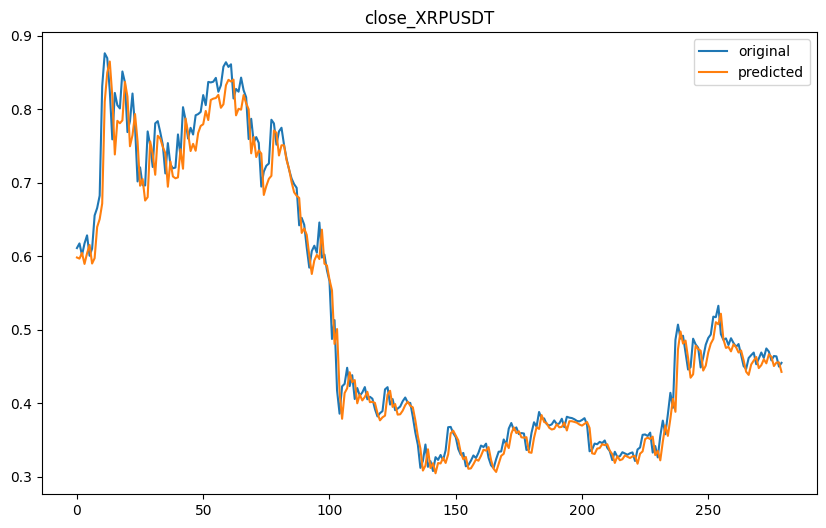

[I 2023-10-24 22:53:08,078] A new study created in RDB with name: close_ETHUSDT


Metrics for 280 days: close_XRPUSDT MSE: 0.0007263520043816769, RMSE: 0.02695091843298994 MAPE: 0.03485087751639227
Metrics for 90 days: close_XRPUSDT MSE: 0.00033835073257427, RMSE: 0.018394312506159884 MAPE: 0.030455765971947654
Metrics for 30 days: close_XRPUSDT MSE: 0.0001970907101919444, RMSE: 0.014038899892510965 MAPE: 0.023903431373697555
Metrics for 7 days: close_XRPUSDT MSE: 0.00012673663969449224, RMSE: 0.011257736881562485 MAPE: 0.021189901850515166
11/11 [==============================] - 0s 5ms/step - loss: 907735.2500 - mean_absolute_percentage_error_keras: 57.0749


[I 2023-10-24 22:53:40,844] Trial 0 finished with value: 57.074893951416016 and parameters: {'num_layers': 4, 'units_layer_0': 32, 'units_layer_1': 192, 'units_layer_2': 128, 'units_layer_3': 224, 'sequence_length': 4, 'learning_rate': 9.431114665269945e-05, 'dropout_rate': 0.38936107092967204, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 0 with value: 57.074893951416016.


11/11 [==============================] - 0s 1ms/step - loss: 1.5811e-04 - mean_absolute_percentage_error_keras: 3.0708


[I 2023-10-24 22:53:47,580] Trial 1 finished with value: 3.0708391666412354 and parameters: {'num_layers': 1, 'units_layer_0': 128, 'sequence_length': 3, 'learning_rate': 0.0005158565328313375, 'dropout_rate': 0.3396723264016169, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 1 with value: 3.0708391666412354.


11/11 [==============================] - 0s 4ms/step - loss: 57932.2617 - mean_absolute_percentage_error_keras: 14.0640


[I 2023-10-24 22:54:07,950] Trial 2 finished with value: 14.064034461975098 and parameters: {'num_layers': 3, 'units_layer_0': 256, 'units_layer_1': 64, 'units_layer_2': 256, 'sequence_length': 2, 'learning_rate': 6.744397112694211e-05, 'dropout_rate': 0.20597829478353363, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 1 with value: 3.0708391666412354.


11/11 [==============================] - 0s 5ms/step - loss: 11351.9658 - mean_absolute_percentage_error_keras: 4.8324


[I 2023-10-24 22:54:37,651] Trial 3 finished with value: 4.8324480056762695 and parameters: {'num_layers': 2, 'units_layer_0': 224, 'units_layer_1': 64, 'sequence_length': 10, 'learning_rate': 0.0009468198886900022, 'dropout_rate': 0.017917698968909712, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 1 with value: 3.0708391666412354.


11/11 [==============================] - 0s 1ms/step - loss: 347371.7500 - mean_absolute_percentage_error_keras: 35.3348


[I 2023-10-24 22:54:47,569] Trial 4 finished with value: 35.33479690551758 and parameters: {'num_layers': 2, 'units_layer_0': 32, 'units_layer_1': 32, 'sequence_length': 2, 'learning_rate': 0.0008188993842413539, 'dropout_rate': 0.46603906306987214, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 1 with value: 3.0708391666412354.
[I 2023-10-24 22:54:54,820] Trial 5 pruned. 


11/11 [==============================] - 0s 3ms/step - loss: 1.9464e-04 - mean_absolute_percentage_error_keras: 3.3203


[I 2023-10-24 22:55:13,264] Trial 6 finished with value: 3.3202929496765137 and parameters: {'num_layers': 3, 'units_layer_0': 128, 'units_layer_1': 160, 'units_layer_2': 224, 'sequence_length': 2, 'learning_rate': 0.0009010679359153821, 'dropout_rate': 0.28620982660074873, 'min_max_scaling': 1, 'layer_type': 'LSTM'}. Best is trial 1 with value: 3.0708391666412354.


11/11 [==============================] - 0s 2ms/step - loss: 13304.8760 - mean_absolute_percentage_error_keras: 6.5108


[I 2023-10-24 22:55:25,335] Trial 7 finished with value: 6.510837554931641 and parameters: {'num_layers': 3, 'units_layer_0': 96, 'units_layer_1': 96, 'units_layer_2': 160, 'sequence_length': 1, 'learning_rate': 0.0002716412485587732, 'dropout_rate': 0.1532214225743791, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 1 with value: 3.0708391666412354.


11/11 [==============================] - 0s 1ms/step - loss: 2.4104e-04 - mean_absolute_percentage_error_keras: 3.8575


[I 2023-10-24 22:55:33,239] Trial 8 finished with value: 3.8574531078338623 and parameters: {'num_layers': 1, 'units_layer_0': 160, 'sequence_length': 7, 'learning_rate': 0.0007864798609832048, 'dropout_rate': 0.37695613908897374, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 1 with value: 3.0708391666412354.
2023-10-24 22:55:36.286028: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_264/simple_rnn_343/while/body/_157/sequential_264/simple_rnn_343/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-24 22:55:36.288133: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_264/simple_rnn_342/while/body/_74/sequential_264/simple_rnn_342/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-24 22:55:36.289844: W tensorflow/core/grappler/utils/graph_view.cc:849] No r

11/11 [==============================] - 0s 1ms/step - loss: 1.1508e-04 - mean_absolute_percentage_error_keras: 2.3361


[I 2023-10-24 22:55:47,996] Trial 10 finished with value: 2.3360507488250732 and parameters: {'num_layers': 1, 'units_layer_0': 192, 'sequence_length': 7, 'learning_rate': 0.00036931350745634996, 'dropout_rate': 0.4975135651879866, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 10 with value: 2.3360507488250732.


11/11 [==============================] - 0s 2ms/step - loss: 1.2026e-04 - mean_absolute_percentage_error_keras: 2.3820


[I 2023-10-24 22:55:56,437] Trial 11 finished with value: 2.3819708824157715 and parameters: {'num_layers': 1, 'units_layer_0': 192, 'sequence_length': 7, 'learning_rate': 0.0003881122973274073, 'dropout_rate': 0.49746411138137864, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 10 with value: 2.3360507488250732.


11/11 [==============================] - 0s 2ms/step - loss: 3.1731e-04 - mean_absolute_percentage_error_keras: 4.8471


[I 2023-10-24 22:56:05,193] Trial 12 finished with value: 4.847076892852783 and parameters: {'num_layers': 1, 'units_layer_0': 224, 'sequence_length': 7, 'learning_rate': 0.00034621126836017303, 'dropout_rate': 0.4845261897751497, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 10 with value: 2.3360507488250732.


11/11 [==============================] - 0s 3ms/step - loss: 4.5773e-04 - mean_absolute_percentage_error_keras: 6.2726


[I 2023-10-24 22:56:20,253] Trial 13 finished with value: 6.272615432739258 and parameters: {'num_layers': 2, 'units_layer_0': 192, 'units_layer_1': 256, 'sequence_length': 8, 'learning_rate': 0.0003436857926453381, 'dropout_rate': 0.494211936708669, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 10 with value: 2.3360507488250732.


11/11 [==============================] - 0s 2ms/step - loss: 2.4611e-04 - mean_absolute_percentage_error_keras: 4.1493


[I 2023-10-24 22:56:29,343] Trial 14 finished with value: 4.149262428283691 and parameters: {'num_layers': 1, 'units_layer_0': 192, 'sequence_length': 9, 'learning_rate': 0.0004177472977977956, 'dropout_rate': 0.4272381855286952, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 10 with value: 2.3360507488250732.


11/11 [==============================] - 0s 2ms/step - loss: 1.0220e-04 - mean_absolute_percentage_error_keras: 2.1084


[I 2023-10-24 22:56:44,163] Trial 15 finished with value: 2.1084096431732178 and parameters: {'num_layers': 2, 'units_layer_0': 256, 'units_layer_1': 128, 'sequence_length': 6, 'learning_rate': 0.00020995597611271177, 'dropout_rate': 0.4371603475966631, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 15 with value: 2.1084096431732178.


11/11 [==============================] - 0s 2ms/step - loss: 1.3385e-04 - mean_absolute_percentage_error_keras: 2.7327


[I 2023-10-24 22:56:57,063] Trial 16 finished with value: 2.732706069946289 and parameters: {'num_layers': 2, 'units_layer_0': 256, 'units_layer_1': 128, 'sequence_length': 5, 'learning_rate': 0.00016377963145440522, 'dropout_rate': 0.42202063967832526, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 15 with value: 2.1084096431732178.
[I 2023-10-24 22:57:01,324] Trial 17 pruned. 


11/11 [==============================] - 0s 1ms/step - loss: 2.7849e-04 - mean_absolute_percentage_error_keras: 4.5157


[I 2023-10-24 22:57:10,339] Trial 18 finished with value: 4.515675067901611 and parameters: {'num_layers': 1, 'units_layer_0': 256, 'sequence_length': 6, 'learning_rate': 0.00019861845803262896, 'dropout_rate': 0.42849593956604165, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 15 with value: 2.1084096431732178.
[I 2023-10-24 22:57:15,435] Trial 19 pruned. 
[I 2023-10-24 22:57:21,152] Trial 20 pruned. 


11/11 [==============================] - 0s 2ms/step - loss: 2.6951e-04 - mean_absolute_percentage_error_keras: 4.4449


[I 2023-10-24 22:57:29,715] Trial 21 finished with value: 4.444869518280029 and parameters: {'num_layers': 1, 'units_layer_0': 192, 'sequence_length': 7, 'learning_rate': 0.00043320132925280495, 'dropout_rate': 0.49701322914551294, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 15 with value: 2.1084096431732178.


11/11 [==============================] - 0s 1ms/step - loss: 1.2090e-04 - mean_absolute_percentage_error_keras: 2.3926


[I 2023-10-24 22:57:38,094] Trial 22 finished with value: 2.3926451206207275 and parameters: {'num_layers': 1, 'units_layer_0': 160, 'sequence_length': 8, 'learning_rate': 0.00039096181846800154, 'dropout_rate': 0.4580372966285508, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 15 with value: 2.1084096431732178.


11/11 [==============================] - 0s 1ms/step - loss: 1.5006e-04 - mean_absolute_percentage_error_keras: 2.9973


[I 2023-10-24 22:57:47,220] Trial 23 finished with value: 2.9972691535949707 and parameters: {'num_layers': 1, 'units_layer_0': 256, 'sequence_length': 6, 'learning_rate': 0.00030127406161737594, 'dropout_rate': 0.4961625589421411, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 15 with value: 2.1084096431732178.
[I 2023-10-24 22:57:52,631] Trial 24 pruned. 


11/11 [==============================] - 0s 2ms/step - loss: 1.1488e-04 - mean_absolute_percentage_error_keras: 2.3219


[I 2023-10-24 22:58:01,174] Trial 25 finished with value: 2.321873426437378 and parameters: {'num_layers': 1, 'units_layer_0': 192, 'sequence_length': 7, 'learning_rate': 0.00017801699440088796, 'dropout_rate': 0.40197168610986156, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 15 with value: 2.1084096431732178.
[I 2023-10-24 22:58:05,120] Trial 26 pruned. 


11/11 [==============================] - 0s 1ms/step - loss: 4.4979e-04 - mean_absolute_percentage_error_keras: 5.9874


[I 2023-10-24 22:58:14,134] Trial 27 finished with value: 5.987431526184082 and parameters: {'num_layers': 1, 'units_layer_0': 160, 'sequence_length': 10, 'learning_rate': 0.00023314674139966865, 'dropout_rate': 0.4031397666796514, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 15 with value: 2.1084096431732178.


11/11 [==============================] - 0s 1ms/step - loss: 1.0861e-04 - mean_absolute_percentage_error_keras: 2.2657


[I 2023-10-24 22:58:22,773] Trial 28 finished with value: 2.265749216079712 and parameters: {'num_layers': 1, 'units_layer_0': 128, 'sequence_length': 9, 'learning_rate': 0.00017589822881809508, 'dropout_rate': 0.4545679482570547, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 15 with value: 2.1084096431732178.
[I 2023-10-24 22:58:29,125] Trial 29 pruned. 
[I 2023-10-24 22:58:34,093] Trial 30 pruned. 


11/11 [==============================] - 0s 1ms/step - loss: 1.5587e-04 - mean_absolute_percentage_error_keras: 3.0056


[I 2023-10-24 22:58:41,752] Trial 31 finished with value: 3.005608558654785 and parameters: {'num_layers': 1, 'units_layer_0': 128, 'sequence_length': 8, 'learning_rate': 0.00019755309410269753, 'dropout_rate': 0.4580736555068271, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 15 with value: 2.1084096431732178.


11/11 [==============================] - 0s 1ms/step - loss: 1.4515e-04 - mean_absolute_percentage_error_keras: 2.7999


[I 2023-10-24 22:58:49,151] Trial 32 finished with value: 2.7998738288879395 and parameters: {'num_layers': 1, 'units_layer_0': 160, 'sequence_length': 6, 'learning_rate': 0.00014236759003662005, 'dropout_rate': 0.45344884922130135, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 15 with value: 2.1084096431732178.


11/11 [==============================] - 0s 1ms/step - loss: 1.3911e-04 - mean_absolute_percentage_error_keras: 2.6231


[I 2023-10-24 22:58:55,834] Trial 33 finished with value: 2.623070478439331 and parameters: {'num_layers': 1, 'units_layer_0': 64, 'sequence_length': 7, 'learning_rate': 0.0002444210518817865, 'dropout_rate': 0.410489716030987, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 15 with value: 2.1084096431732178.


11/11 [==============================] - 0s 1ms/step - loss: 1.3171e-04 - mean_absolute_percentage_error_keras: 2.6787


[I 2023-10-24 22:59:05,832] Trial 34 finished with value: 2.6787242889404297 and parameters: {'num_layers': 1, 'units_layer_0': 192, 'sequence_length': 9, 'learning_rate': 0.0003214205203047107, 'dropout_rate': 0.45795269380042697, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 15 with value: 2.1084096431732178.
[I 2023-10-24 22:59:13,315] Trial 35 pruned. 
[I 2023-10-24 22:59:18,611] Trial 36 pruned. 
[I 2023-10-24 22:59:29,279] Trial 37 pruned. 


11/11 [==============================] - 0s 2ms/step - loss: 44081.8867 - mean_absolute_percentage_error_keras: 12.3510


[I 2023-10-24 22:59:39,714] Trial 38 finished with value: 12.351037979125977 and parameters: {'num_layers': 2, 'units_layer_0': 96, 'units_layer_1': 128, 'sequence_length': 5, 'learning_rate': 0.00010587578251971458, 'dropout_rate': 0.3513437296506703, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 15 with value: 2.1084096431732178.
[I 2023-10-24 22:59:49,080] Trial 39 pruned. 
[I 2023-10-24 22:59:54,845] Trial 40 pruned. 


11/11 [==============================] - 0s 1ms/step - loss: 2.3286e-04 - mean_absolute_percentage_error_keras: 4.0745


[I 2023-10-24 23:00:03,116] Trial 41 finished with value: 4.074475288391113 and parameters: {'num_layers': 1, 'units_layer_0': 192, 'sequence_length': 7, 'learning_rate': 0.0003686434153072358, 'dropout_rate': 0.47562492536778894, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 15 with value: 2.1084096431732178.


11/11 [==============================] - 0s 1ms/step - loss: 1.3439e-04 - mean_absolute_percentage_error_keras: 2.6151


[I 2023-10-24 23:00:11,317] Trial 42 finished with value: 2.6151459217071533 and parameters: {'num_layers': 1, 'units_layer_0': 192, 'sequence_length': 7, 'learning_rate': 0.00029936539407833795, 'dropout_rate': 0.47793289329620015, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 15 with value: 2.1084096431732178.


11/11 [==============================] - 0s 2ms/step - loss: 1.6721e-04 - mean_absolute_percentage_error_keras: 3.1908


[I 2023-10-24 23:00:20,557] Trial 43 finished with value: 3.1907668113708496 and parameters: {'num_layers': 1, 'units_layer_0': 224, 'sequence_length': 8, 'learning_rate': 0.00048585326883989155, 'dropout_rate': 0.49565709664386126, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 15 with value: 2.1084096431732178.


11/11 [==============================] - 0s 1ms/step - loss: 1.6924e-04 - mean_absolute_percentage_error_keras: 3.2806


[I 2023-10-24 23:00:27,983] Trial 44 finished with value: 3.28059458732605 and parameters: {'num_layers': 1, 'units_layer_0': 160, 'sequence_length': 6, 'learning_rate': 0.0005355619286199397, 'dropout_rate': 0.440603581179959, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 15 with value: 2.1084096431732178.


11/11 [==============================] - 0s 2ms/step - loss: 1.1325e-04 - mean_absolute_percentage_error_keras: 2.2495


[I 2023-10-24 23:00:36,159] Trial 45 finished with value: 2.249541997909546 and parameters: {'num_layers': 1, 'units_layer_0': 96, 'sequence_length': 9, 'learning_rate': 0.00037871730534620805, 'dropout_rate': 0.46992118464385263, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 15 with value: 2.1084096431732178.


11/11 [==============================] - 0s 1ms/step - loss: 1.6157e-04 - mean_absolute_percentage_error_keras: 3.1437


[I 2023-10-24 23:00:44,146] Trial 46 finished with value: 3.143737316131592 and parameters: {'num_layers': 1, 'units_layer_0': 96, 'sequence_length': 9, 'learning_rate': 0.00033918487890509266, 'dropout_rate': 0.4742518327003172, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 15 with value: 2.1084096431732178.
[I 2023-10-24 23:00:47,969] Trial 47 pruned. 


11/11 [==============================] - 0s 3ms/step - loss: 1.5019e-04 - mean_absolute_percentage_error_keras: 2.9825


[I 2023-10-24 23:01:02,150] Trial 48 finished with value: 2.982484817504883 and parameters: {'num_layers': 2, 'units_layer_0': 128, 'units_layer_1': 224, 'sequence_length': 9, 'learning_rate': 0.000182693498420632, 'dropout_rate': 0.377268499221619, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 15 with value: 2.1084096431732178.


11/11 [==============================] - 0s 1ms/step - loss: 1.4111e-04 - mean_absolute_percentage_error_keras: 2.6183


[I 2023-10-24 23:01:10,297] Trial 49 finished with value: 2.6183390617370605 and parameters: {'num_layers': 1, 'units_layer_0': 64, 'sequence_length': 10, 'learning_rate': 0.00037878982844483523, 'dropout_rate': 0.44186417590300686, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 15 with value: 2.1084096431732178.


Best Hyperparameters: {'num_layers': 2, 'units_layer_0': 256, 'units_layer_1': 128, 'sequence_length': 6, 'learning_rate': 0.00020995597611271177, 'dropout_rate': 0.4371603475966631, 'min_max_scaling': 1, 'layer_type': 'RNN'}
Epoch 1/100
46/46 [==============================] - 2s 5ms/step - loss: 0.0353
Epoch 2/100
46/46 [==============================] - 0s 5ms/step - loss: 0.0090
Epoch 3/100
46/46 [==============================] - 0s 5ms/step - loss: 0.0070
Epoch 4/100
46/46 [==============================] - 0s 5ms/step - loss: 0.0070
Epoch 5/100
46/46 [==============================] - 0s 5ms/step - loss: 0.0053
Epoch 6/100
46/46 [==============================] - 0s 5ms/step - loss: 0.0048
Epoch 7/100
46/46 [==============================] - 0s 5ms/step - loss: 0.0048
Epoch 8/100
46/46 [==============================] - 0s 5ms/step - loss: 0.0042
Epoch 9/100
46/46 [==============================] - 0s 5ms/step - loss: 0.0052
Epoch 10/100
46/46 [==============================] - 

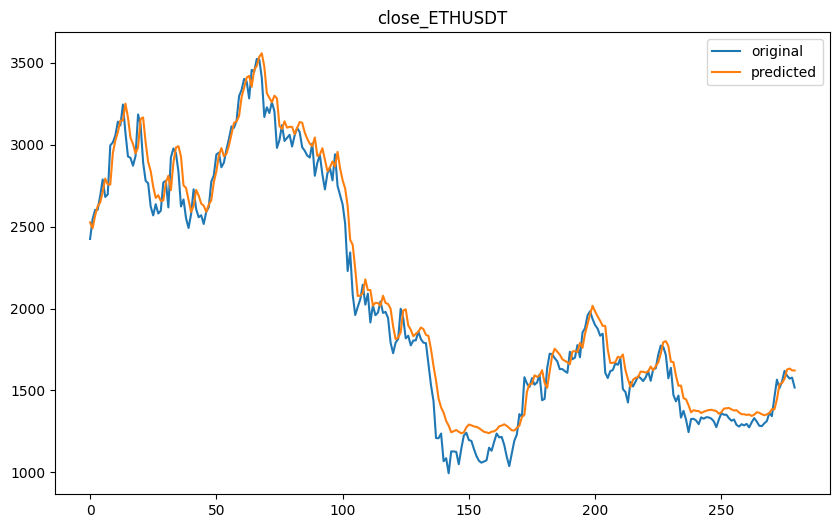

[I 2023-10-24 23:01:35,649] A new study created in RDB with name: close_TRXUSDT


Metrics for 280 days: close_ETHUSDT MSE: 14219.394664962138, RMSE: 119.24510331649739 MAPE: 0.05271285964717001
Metrics for 90 days: close_ETHUSDT MSE: 7076.743996821199, RMSE: 84.12338555253943 MAPE: 0.04513852279473384
Metrics for 30 days: close_ETHUSDT MSE: 3698.7912311365963, RMSE: 60.81768847248797 MAPE: 0.03967915729053993
Metrics for 7 days: close_ETHUSDT MSE: 2984.994046589835, RMSE: 54.63509903523407 MAPE: 0.03012257125496778
11/11 [==============================] - 0s 4ms/step - loss: 8.3719e-06 - mean_absolute_percentage_error_keras: 3.2274


[I 2023-10-24 23:02:05,670] Trial 0 finished with value: 3.227355718612671 and parameters: {'num_layers': 4, 'units_layer_0': 32, 'units_layer_1': 128, 'units_layer_2': 224, 'units_layer_3': 96, 'sequence_length': 4, 'learning_rate': 5.623513690876658e-05, 'dropout_rate': 0.21046325776659236, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 0 with value: 3.227355718612671.


11/11 [==============================] - 0s 4ms/step - loss: 9.7527e-06 - mean_absolute_percentage_error_keras: 3.7471


[I 2023-10-24 23:02:27,462] Trial 1 finished with value: 3.747148036956787 and parameters: {'num_layers': 1, 'units_layer_0': 224, 'sequence_length': 10, 'learning_rate': 0.00012872707304029612, 'dropout_rate': 0.4949189855471415, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 0 with value: 3.227355718612671.


11/11 [==============================] - 0s 1ms/step - loss: 2.4635e-04 - mean_absolute_percentage_error_keras: 3.1548


[I 2023-10-24 23:02:35,839] Trial 2 finished with value: 3.1547868251800537 and parameters: {'num_layers': 1, 'units_layer_0': 32, 'sequence_length': 4, 'learning_rate': 0.0008504859618176124, 'dropout_rate': 0.11132536833770029, 'min_max_scaling': 1, 'layer_type': 'LSTM'}. Best is trial 2 with value: 3.1547868251800537.


11/11 [==============================] - 0s 3ms/step - loss: 5.8209e-04 - mean_absolute_percentage_error_keras: 5.9324


[I 2023-10-24 23:02:55,174] Trial 3 finished with value: 5.932384014129639 and parameters: {'num_layers': 4, 'units_layer_0': 128, 'units_layer_1': 160, 'units_layer_2': 192, 'units_layer_3': 160, 'sequence_length': 6, 'learning_rate': 0.00011532059467100904, 'dropout_rate': 0.01574271584064313, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 2 with value: 3.1547868251800537.


11/11 [==============================] - 0s 2ms/step - loss: 3.8402e-06 - mean_absolute_percentage_error_keras: 2.1172


[I 2023-10-24 23:03:05,539] Trial 4 finished with value: 2.117168664932251 and parameters: {'num_layers': 2, 'units_layer_0': 64, 'units_layer_1': 32, 'sequence_length': 2, 'learning_rate': 0.0006709771389010956, 'dropout_rate': 0.09296950257143716, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 4 with value: 2.117168664932251.
[I 2023-10-24 23:03:14,956] Trial 5 pruned. 
2023-10-24 23:03:16.854156: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_312/simple_rnn_403/while/body/_74/sequential_312/simple_rnn_403/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-24 23:03:16.856272: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_312/simple_rnn_402/while/body/_1/sequential_312/simple_rnn_402/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-24 23:03:16.85

11/11 [==============================] - 0s 2ms/step - loss: 3.4967e-04 - mean_absolute_percentage_error_keras: 4.4097


[I 2023-10-24 23:03:56,086] Trial 9 finished with value: 4.40965461730957 and parameters: {'num_layers': 1, 'units_layer_0': 192, 'sequence_length': 4, 'learning_rate': 0.0008909498391541953, 'dropout_rate': 0.033487691119993945, 'min_max_scaling': 1, 'layer_type': 'LSTM'}. Best is trial 4 with value: 2.117168664932251.
2023-10-24 23:03:57.533878: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_316/simple_rnn_405/while/body/_1/sequential_316/simple_rnn_405/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-24 23:03:57.535411: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_316/simple_rnn_406/while/body/_74/sequential_316/simple_rnn_406/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-24 23:03:57.577557: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc

11/11 [==============================] - 0s 1ms/step - loss: 4.3101e-06 - mean_absolute_percentage_error_keras: 2.4835


[I 2023-10-24 23:04:03,736] Trial 10 finished with value: 2.483476400375366 and parameters: {'num_layers': 2, 'units_layer_0': 128, 'units_layer_1': 96, 'sequence_length': 1, 'learning_rate': 0.0006132602453176266, 'dropout_rate': 0.12475304269677562, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 4 with value: 2.117168664932251.
2023-10-24 23:04:05.201095: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_317/simple_rnn_407/while/body/_1/sequential_317/simple_rnn_407/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-24 23:04:05.202836: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_317/simple_rnn_408/while/body/_74/sequential_317/simple_rnn_408/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-24 23:04:05.236404: E tensorflow/core/grappler/optimizers/

11/11 [==============================] - 0s 2ms/step - loss: 2.6741e-06 - mean_absolute_percentage_error_keras: 1.7130


[I 2023-10-24 23:04:10,759] Trial 11 finished with value: 1.713009238243103 and parameters: {'num_layers': 2, 'units_layer_0': 128, 'units_layer_1': 96, 'sequence_length': 1, 'learning_rate': 0.000648965217983181, 'dropout_rate': 0.1204995621223262, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 11 with value: 1.713009238243103.
2023-10-24 23:04:11.972356: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_318/simple_rnn_409/while/body/_1/sequential_318/simple_rnn_409/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-24 23:04:11.974546: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_318/simple_rnn_410/while/body/_74/sequential_318/simple_rnn_410/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-24 23:04:12.005517: E tensorflow/core/grappler/optimizers/t

11/11 [==============================] - 0s 1ms/step - loss: 1.8834e-05 - mean_absolute_percentage_error_keras: 5.9636


[I 2023-10-24 23:04:19,139] Trial 12 finished with value: 5.96356725692749 and parameters: {'num_layers': 2, 'units_layer_0': 160, 'units_layer_1': 32, 'sequence_length': 2, 'learning_rate': 0.0006156446505230542, 'dropout_rate': 0.1375037115055692, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 11 with value: 1.713009238243103.


11/11 [==============================] - 0s 1ms/step - loss: 4.1320e-06 - mean_absolute_percentage_error_keras: 2.4115


[I 2023-10-24 23:04:29,508] Trial 13 finished with value: 2.411498785018921 and parameters: {'num_layers': 2, 'units_layer_0': 96, 'units_layer_1': 96, 'sequence_length': 3, 'learning_rate': 0.0007418463051772317, 'dropout_rate': 0.10129535277255901, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 11 with value: 1.713009238243103.
2023-10-24 23:04:30.892629: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_320/simple_rnn_413/while/body/_1/sequential_320/simple_rnn_413/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-24 23:04:30.894193: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_320/simple_rnn_414/while/body/_74/sequential_320/simple_rnn_414/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-24 23:04:30.953073: E tensorflow/core/grappler/optimizers/

11/11 [==============================] - 0s 1ms/step - loss: 1.5268e-05 - mean_absolute_percentage_error_keras: 4.9728


[I 2023-10-24 23:04:39,320] Trial 14 finished with value: 4.972830772399902 and parameters: {'num_layers': 2, 'units_layer_0': 256, 'units_layer_1': 64, 'sequence_length': 2, 'learning_rate': 0.00045405016801178217, 'dropout_rate': 0.18530034222570443, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 11 with value: 1.713009238243103.
[I 2023-10-24 23:04:44,645] Trial 15 pruned. 
2023-10-24 23:04:46.520433: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_322/simple_rnn_418/while/body/_74/sequential_322/simple_rnn_418/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-24 23:04:46.522471: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_322/simple_rnn_417/while/body/_1/sequential_322/simple_rnn_417/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-24 23:04:4

11/11 [==============================] - 0s 1ms/step - loss: 5.9624e-05 - mean_absolute_percentage_error_keras: 10.8873


[I 2023-10-24 23:04:54,142] Trial 16 finished with value: 10.887288093566895 and parameters: {'num_layers': 3, 'units_layer_0': 160, 'units_layer_1': 32, 'units_layer_2': 256, 'sequence_length': 1, 'learning_rate': 0.00044819145179790336, 'dropout_rate': 0.17460759653527594, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 11 with value: 1.713009238243103.


11/11 [==============================] - 0s 1ms/step - loss: 1.5860e-04 - mean_absolute_percentage_error_keras: 2.3575


[I 2023-10-24 23:05:01,939] Trial 17 finished with value: 2.3575053215026855 and parameters: {'num_layers': 1, 'units_layer_0': 64, 'sequence_length': 3, 'learning_rate': 0.0006600365894475272, 'dropout_rate': 0.06742140797483072, 'min_max_scaling': 1, 'layer_type': 'LSTM'}. Best is trial 11 with value: 1.713009238243103.


11/11 [==============================] - 0s 2ms/step - loss: 6.1705e-06 - mean_absolute_percentage_error_keras: 3.1015


[I 2023-10-24 23:05:13,516] Trial 18 finished with value: 3.1015021800994873 and parameters: {'num_layers': 2, 'units_layer_0': 128, 'units_layer_1': 160, 'sequence_length': 5, 'learning_rate': 0.0005319161090361832, 'dropout_rate': 0.007991105857208872, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 11 with value: 1.713009238243103.
[I 2023-10-24 23:05:21,960] Trial 19 pruned. 
2023-10-24 23:05:23.003410: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_326/simple_rnn_422/while/body/_1/sequential_326/simple_rnn_422/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-24 23:05:23.026655: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:134] tfg_optimizer{any(tfg-consolidate-attrs,tfg-toposort,tfg-shape-inference{graph-version=0},tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node sequential_326/simple_rnn_422/while/body/_1/sequential_326/simple_rnn_4

11/11 [==============================] - 0s 1ms/step - loss: 2.5600e-04 - mean_absolute_percentage_error_keras: 3.2735


[I 2023-10-24 23:05:32,034] Trial 21 finished with value: 3.273536205291748 and parameters: {'num_layers': 1, 'units_layer_0': 64, 'sequence_length': 3, 'learning_rate': 0.0006987016078592611, 'dropout_rate': 0.07060729144194826, 'min_max_scaling': 1, 'layer_type': 'LSTM'}. Best is trial 11 with value: 1.713009238243103.
[I 2023-10-24 23:05:34,978] Trial 22 pruned. 


11/11 [==============================] - 0s 2ms/step - loss: 3.5961e-04 - mean_absolute_percentage_error_keras: 4.2812


[I 2023-10-24 23:05:47,348] Trial 23 finished with value: 4.281227111816406 and parameters: {'num_layers': 2, 'units_layer_0': 64, 'units_layer_1': 224, 'sequence_length': 2, 'learning_rate': 0.0005442693682742186, 'dropout_rate': 0.06007327646703755, 'min_max_scaling': 1, 'layer_type': 'LSTM'}. Best is trial 11 with value: 1.713009238243103.
[I 2023-10-24 23:05:52,184] Trial 24 pruned. 


11/11 [==============================] - 0s 1ms/step - loss: 6.7174e-06 - mean_absolute_percentage_error_keras: 3.1202


[I 2023-10-24 23:05:59,447] Trial 25 finished with value: 3.120173692703247 and parameters: {'num_layers': 1, 'units_layer_0': 32, 'sequence_length': 3, 'learning_rate': 0.0008143341414566278, 'dropout_rate': 0.05355155962313799, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 11 with value: 1.713009238243103.
[I 2023-10-24 23:06:05,498] Trial 26 pruned. 


11/11 [==============================] - 0s 1ms/step - loss: 3.5721e-06 - mean_absolute_percentage_error_keras: 1.9968


[I 2023-10-24 23:06:13,332] Trial 27 finished with value: 1.9967628717422485 and parameters: {'num_layers': 1, 'units_layer_0': 128, 'sequence_length': 2, 'learning_rate': 0.000587277160187009, 'dropout_rate': 0.012648735660304458, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 11 with value: 1.713009238243103.
2023-10-24 23:06:14.577036: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_334/simple_rnn_423/while/body/_1/sequential_334/simple_rnn_423/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-24 23:06:14.578463: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_334/simple_rnn_424/while/body/_74/sequential_334/simple_rnn_424/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-24 23:06:14.613258: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook

11/11 [==============================] - 0s 2ms/step - loss: 2.5646e-06 - mean_absolute_percentage_error_keras: 1.6535


[I 2023-10-24 23:06:22,136] Trial 28 finished with value: 1.6535403728485107 and parameters: {'num_layers': 2, 'units_layer_0': 192, 'units_layer_1': 96, 'sequence_length': 2, 'learning_rate': 0.0005727822383435702, 'dropout_rate': 0.006951061366697042, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 28 with value: 1.6535403728485107.
2023-10-24 23:06:23.912030: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_335/simple_rnn_426/while/body/_74/sequential_335/simple_rnn_426/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-24 23:06:23.913391: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_335/simple_rnn_425/while/body/_1/sequential_335/simple_rnn_425/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-24 23:06:23.914109: W tensorflow/core/grappler/utils/g

11/11 [==============================] - 0s 2ms/step - loss: 5.4001e-06 - mean_absolute_percentage_error_keras: 2.9082


[I 2023-10-24 23:06:31,484] Trial 29 finished with value: 2.9082088470458984 and parameters: {'num_layers': 3, 'units_layer_0': 192, 'units_layer_1': 128, 'units_layer_2': 96, 'sequence_length': 1, 'learning_rate': 0.0005687438790214053, 'dropout_rate': 0.012475087586224287, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 28 with value: 1.6535403728485107.


11/11 [==============================] - 0s 1ms/step - loss: 2.5405e-06 - mean_absolute_percentage_error_keras: 1.6275


[I 2023-10-24 23:06:40,355] Trial 30 finished with value: 1.6275230646133423 and parameters: {'num_layers': 1, 'units_layer_0': 224, 'sequence_length': 4, 'learning_rate': 0.00047794686433654963, 'dropout_rate': 0.011328474684512813, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 30 with value: 1.6275230646133423.


11/11 [==============================] - 0s 1ms/step - loss: 2.4618e-06 - mean_absolute_percentage_error_keras: 1.5684


[I 2023-10-24 23:06:48,334] Trial 31 finished with value: 1.5683947801589966 and parameters: {'num_layers': 1, 'units_layer_0': 224, 'sequence_length': 4, 'learning_rate': 0.00047329671049664893, 'dropout_rate': 0.00616058861754375, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 31 with value: 1.5683947801589966.


11/11 [==============================] - 0s 1ms/step - loss: 3.8417e-06 - mean_absolute_percentage_error_keras: 2.2949


[I 2023-10-24 23:06:56,418] Trial 32 finished with value: 2.2948782444000244 and parameters: {'num_layers': 1, 'units_layer_0': 224, 'sequence_length': 4, 'learning_rate': 0.0004623028513181539, 'dropout_rate': 0.004490683109938163, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 31 with value: 1.5683947801589966.


11/11 [==============================] - 0s 1ms/step - loss: 6.1187e-06 - mean_absolute_percentage_error_keras: 3.1094


[I 2023-10-24 23:07:05,292] Trial 33 finished with value: 3.1094043254852295 and parameters: {'num_layers': 1, 'units_layer_0': 256, 'sequence_length': 5, 'learning_rate': 0.0005057825591776047, 'dropout_rate': 0.03490699434233142, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 31 with value: 1.5683947801589966.


11/11 [==============================] - 0s 1ms/step - loss: 8.6136e-06 - mean_absolute_percentage_error_keras: 3.7791


[I 2023-10-24 23:07:13,154] Trial 34 finished with value: 3.7790966033935547 and parameters: {'num_layers': 1, 'units_layer_0': 224, 'sequence_length': 4, 'learning_rate': 0.00038666163779623824, 'dropout_rate': 0.04463569798200516, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 31 with value: 1.5683947801589966.


11/11 [==============================] - 0s 2ms/step - loss: 2.3805e-06 - mean_absolute_percentage_error_keras: 1.5480


[I 2023-10-24 23:07:24,864] Trial 35 finished with value: 1.5480014085769653 and parameters: {'num_layers': 2, 'units_layer_0': 224, 'units_layer_1': 192, 'sequence_length': 4, 'learning_rate': 0.0005675035330258449, 'dropout_rate': 0.035231791517822915, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 35 with value: 1.5480014085769653.
[I 2023-10-24 23:07:34,279] Trial 36 pruned. 


11/11 [==============================] - 0s 1ms/step - loss: 4.6758e-06 - mean_absolute_percentage_error_keras: 2.5736


[I 2023-10-24 23:07:43,510] Trial 37 finished with value: 2.5735671520233154 and parameters: {'num_layers': 1, 'units_layer_0': 256, 'sequence_length': 5, 'learning_rate': 0.0005848558224149442, 'dropout_rate': 0.045183097933442995, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 35 with value: 1.5480014085769653.


11/11 [==============================] - 0s 2ms/step - loss: 2.7084e-06 - mean_absolute_percentage_error_keras: 1.7252


[I 2023-10-24 23:07:55,775] Trial 38 finished with value: 1.725205898284912 and parameters: {'num_layers': 2, 'units_layer_0': 192, 'units_layer_1': 256, 'sequence_length': 4, 'learning_rate': 0.0003883459971204226, 'dropout_rate': 0.032410411456048956, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 35 with value: 1.5480014085769653.


11/11 [==============================] - 0s 1ms/step - loss: 3.0091e-06 - mean_absolute_percentage_error_keras: 1.8129


[I 2023-10-24 23:08:04,605] Trial 39 finished with value: 1.8128504753112793 and parameters: {'num_layers': 1, 'units_layer_0': 224, 'sequence_length': 6, 'learning_rate': 0.00029008544030596176, 'dropout_rate': 0.08386458632496556, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 35 with value: 1.5480014085769653.


11/11 [==============================] - 0s 2ms/step - loss: 1.0022e-05 - mean_absolute_percentage_error_keras: 4.2547


[I 2023-10-24 23:08:17,800] Trial 40 finished with value: 4.254683971405029 and parameters: {'num_layers': 2, 'units_layer_0': 192, 'units_layer_1': 192, 'sequence_length': 7, 'learning_rate': 0.0005519962481791762, 'dropout_rate': 0.024832731858277446, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 35 with value: 1.5480014085769653.


11/11 [==============================] - 0s 2ms/step - loss: 5.7140e-06 - mean_absolute_percentage_error_keras: 3.0179


[I 2023-10-24 23:08:28,856] Trial 41 finished with value: 3.0179290771484375 and parameters: {'num_layers': 2, 'units_layer_0': 224, 'units_layer_1': 224, 'sequence_length': 3, 'learning_rate': 0.0006255968367192536, 'dropout_rate': 0.11207480017129642, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 35 with value: 1.5480014085769653.


11/11 [==============================] - 0s 2ms/step - loss: 1.5443e-05 - mean_absolute_percentage_error_keras: 5.2658


[I 2023-10-24 23:08:42,312] Trial 42 finished with value: 5.2657575607299805 and parameters: {'num_layers': 2, 'units_layer_0': 256, 'units_layer_1': 160, 'sequence_length': 4, 'learning_rate': 0.0005059290343335995, 'dropout_rate': 0.06231004201686594, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 35 with value: 1.5480014085769653.


11/11 [==============================] - 0s 2ms/step - loss: 2.4225e-06 - mean_absolute_percentage_error_keras: 1.5733


[I 2023-10-24 23:08:55,962] Trial 43 finished with value: 1.5732959508895874 and parameters: {'num_layers': 3, 'units_layer_0': 192, 'units_layer_1': 96, 'units_layer_2': 64, 'sequence_length': 4, 'learning_rate': 0.00046808562683933546, 'dropout_rate': 2.2590117033795265e-05, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 35 with value: 1.5480014085769653.


11/11 [==============================] - 0s 2ms/step - loss: 5.6101e-05 - mean_absolute_percentage_error_keras: 10.6948


[I 2023-10-24 23:09:09,768] Trial 44 finished with value: 10.69484806060791 and parameters: {'num_layers': 3, 'units_layer_0': 224, 'units_layer_1': 128, 'units_layer_2': 64, 'sequence_length': 4, 'learning_rate': 0.00045977210268001743, 'dropout_rate': 0.029072130464733167, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 35 with value: 1.5480014085769653.


11/11 [==============================] - 0s 3ms/step - loss: 2.5521e-06 - mean_absolute_percentage_error_keras: 1.6578


[I 2023-10-24 23:09:27,440] Trial 45 finished with value: 1.657776951789856 and parameters: {'num_layers': 4, 'units_layer_0': 192, 'units_layer_1': 128, 'units_layer_2': 128, 'units_layer_3': 32, 'sequence_length': 5, 'learning_rate': 0.0004228222273778644, 'dropout_rate': 0.004003125098167193, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 35 with value: 1.5480014085769653.


11/11 [==============================] - 0s 2ms/step - loss: 4.5016e-06 - mean_absolute_percentage_error_keras: 2.4967


[I 2023-10-24 23:09:43,544] Trial 46 finished with value: 2.4967193603515625 and parameters: {'num_layers': 3, 'units_layer_0': 192, 'units_layer_1': 224, 'units_layer_2': 64, 'sequence_length': 4, 'learning_rate': 0.00048660902364341686, 'dropout_rate': 0.038377938831647224, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 35 with value: 1.5480014085769653.


11/11 [==============================] - 0s 2ms/step - loss: 3.9377e-06 - mean_absolute_percentage_error_keras: 2.3401


[I 2023-10-24 23:09:56,986] Trial 47 finished with value: 2.3400635719299316 and parameters: {'num_layers': 3, 'units_layer_0': 160, 'units_layer_1': 160, 'units_layer_2': 160, 'sequence_length': 3, 'learning_rate': 0.000560064678181416, 'dropout_rate': 0.0779044604038212, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 35 with value: 1.5480014085769653.


11/11 [==============================] - 0s 2ms/step - loss: 6.0826e-06 - mean_absolute_percentage_error_keras: 3.1652


[I 2023-10-24 23:10:12,234] Trial 48 finished with value: 3.1651666164398193 and parameters: {'num_layers': 3, 'units_layer_0': 256, 'units_layer_1': 96, 'units_layer_2': 96, 'sequence_length': 5, 'learning_rate': 0.00040176298233629744, 'dropout_rate': 0.0026911356234996762, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 35 with value: 1.5480014085769653.


11/11 [==============================] - 0s 3ms/step - loss: 1.0428e-04 - mean_absolute_percentage_error_keras: 14.3791


[I 2023-10-24 23:10:32,667] Trial 49 finished with value: 14.379094123840332 and parameters: {'num_layers': 4, 'units_layer_0': 224, 'units_layer_1': 160, 'units_layer_2': 64, 'units_layer_3': 256, 'sequence_length': 6, 'learning_rate': 0.0006002951385938124, 'dropout_rate': 0.09485272486972282, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 35 with value: 1.5480014085769653.


Best Hyperparameters: {'num_layers': 2, 'units_layer_0': 224, 'units_layer_1': 192, 'sequence_length': 4, 'learning_rate': 0.0005675035330258449, 'dropout_rate': 0.035231791517822915, 'min_max_scaling': 0, 'layer_type': 'RNN'}
Epoch 1/100
46/46 [==============================] - 3s 5ms/step - loss: 9.6381e-05
Epoch 2/100
46/46 [==============================] - 0s 4ms/step - loss: 2.1392e-05
Epoch 3/100
46/46 [==============================] - 0s 4ms/step - loss: 2.2570e-05
Epoch 4/100
46/46 [==============================] - 0s 4ms/step - loss: 1.8737e-05
Epoch 5/100
46/46 [==============================] - 0s 5ms/step - loss: 1.9247e-05
Epoch 6/100
46/46 [==============================] - 0s 4ms/step - loss: 1.9053e-05
Epoch 7/100
46/46 [==============================] - 0s 4ms/step - loss: 1.8124e-05
Epoch 8/100
46/46 [==============================] - 0s 4ms/step - loss: 2.5227e-05
Epoch 9/100
46/46 [==============================] - 0s 4ms/step - loss: 1.8388e-05
Epoch 10/100
46/4

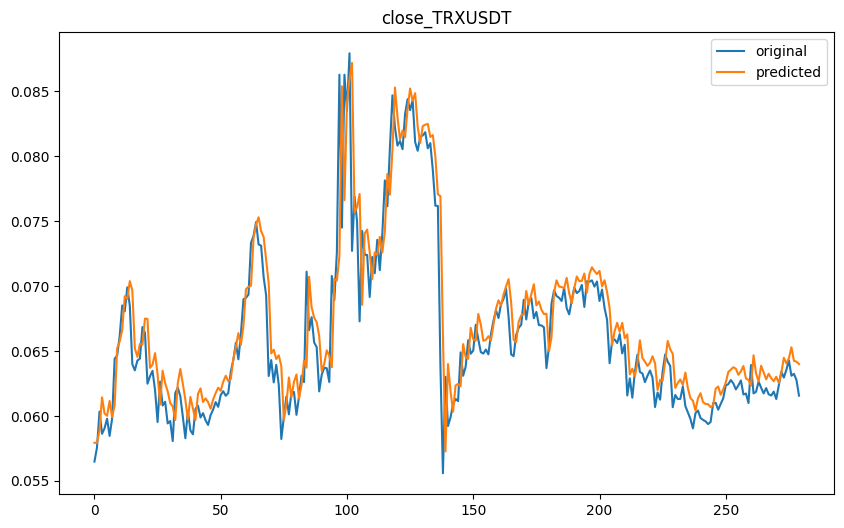

[I 2023-10-24 23:10:55,831] A new study created in RDB with name: close_ONTUSDT


Metrics for 280 days: close_TRXUSDT MSE: 7.629814481741242e-06, RMSE: 0.002762211882122956 MAPE: 0.027536539135303535
Metrics for 90 days: close_TRXUSDT MSE: 2.5459128646929108e-06, RMSE: 0.0015955916973627404 MAPE: 0.020585489054649995
Metrics for 30 days: close_TRXUSDT MSE: 1.9854368798134842e-06, RMSE: 0.0014090553146748656 MAPE: 0.019484993090181677
Metrics for 7 days: close_TRXUSDT MSE: 2.335718816380028e-06, RMSE: 0.00152830586479933 MAPE: 0.02103698101822738
11/11 [==============================] - 0s 1ms/step - loss: 1.4023e-04 - mean_absolute_percentage_error_keras: 4.8616


[I 2023-10-24 23:11:03,133] Trial 0 finished with value: 4.861624717712402 and parameters: {'num_layers': 1, 'units_layer_0': 96, 'sequence_length': 4, 'learning_rate': 0.0007614072721380393, 'dropout_rate': 0.02666867350546709, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 0 with value: 4.861624717712402.


11/11 [==============================] - 0s 2ms/step - loss: 0.0017 - mean_absolute_percentage_error_keras: 148402.9375


[I 2023-10-24 23:11:13,536] Trial 1 finished with value: 148402.9375 and parameters: {'num_layers': 1, 'units_layer_0': 96, 'sequence_length': 6, 'learning_rate': 0.0005586251131533677, 'dropout_rate': 0.24848991123469677, 'min_max_scaling': 1, 'layer_type': 'LSTM'}. Best is trial 0 with value: 4.861624717712402.


11/11 [==============================] - 0s 2ms/step - loss: 0.0307 - mean_absolute_percentage_error_keras: 91.5383


[I 2023-10-24 23:11:27,751] Trial 2 finished with value: 91.5383071899414 and parameters: {'num_layers': 3, 'units_layer_0': 192, 'units_layer_1': 256, 'units_layer_2': 192, 'sequence_length': 3, 'learning_rate': 0.000438569713339694, 'dropout_rate': 0.27147338885684497, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 0 with value: 4.861624717712402.


11/11 [==============================] - 0s 3ms/step - loss: 0.0059 - mean_absolute_percentage_error_keras: 268859.5625


[I 2023-10-24 23:11:40,676] Trial 3 finished with value: 268859.5625 and parameters: {'num_layers': 2, 'units_layer_0': 96, 'units_layer_1': 96, 'sequence_length': 3, 'learning_rate': 0.0007517185630698694, 'dropout_rate': 0.2510981100799639, 'min_max_scaling': 1, 'layer_type': 'LSTM'}. Best is trial 0 with value: 4.861624717712402.


11/11 [==============================] - 0s 2ms/step - loss: 0.0043 - mean_absolute_percentage_error_keras: 243422.0000


[I 2023-10-24 23:11:56,108] Trial 4 finished with value: 243422.0 and parameters: {'num_layers': 2, 'units_layer_0': 160, 'units_layer_1': 192, 'sequence_length': 9, 'learning_rate': 0.0001512045405206703, 'dropout_rate': 0.32890158184010226, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 0 with value: 4.861624717712402.
[I 2023-10-24 23:12:02,510] Trial 5 pruned. 


11/11 [==============================] - 0s 2ms/step - loss: 0.0021 - mean_absolute_percentage_error_keras: 181417.3281


[I 2023-10-24 23:12:18,279] Trial 6 finished with value: 181417.328125 and parameters: {'num_layers': 3, 'units_layer_0': 224, 'units_layer_1': 224, 'units_layer_2': 32, 'sequence_length': 1, 'learning_rate': 7.364718554695738e-06, 'dropout_rate': 0.2804400852335965, 'min_max_scaling': 1, 'layer_type': 'LSTM'}. Best is trial 0 with value: 4.861624717712402.


11/11 [==============================] - 0s 2ms/step - loss: 9.9331e-04 - mean_absolute_percentage_error_keras: 128947.0547


[I 2023-10-24 23:12:30,730] Trial 7 finished with value: 128947.0546875 and parameters: {'num_layers': 2, 'units_layer_0': 256, 'units_layer_1': 128, 'sequence_length': 5, 'learning_rate': 0.0004636135453074838, 'dropout_rate': 0.009085182641924927, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 0 with value: 4.861624717712402.
[I 2023-10-24 23:12:37,164] Trial 8 pruned. 


11/11 [==============================] - 0s 1ms/step - loss: 0.0141 - mean_absolute_percentage_error_keras: 61.7095


[I 2023-10-24 23:12:45,040] Trial 9 finished with value: 61.709503173828125 and parameters: {'num_layers': 1, 'units_layer_0': 160, 'sequence_length': 7, 'learning_rate': 0.0008988017710216675, 'dropout_rate': 0.4827033639954766, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 0 with value: 4.861624717712402.


11/11 [==============================] - 0s 2ms/step - loss: 0.0218 - mean_absolute_percentage_error_keras: 77.1093


[I 2023-10-24 23:12:56,498] Trial 10 finished with value: 77.10928344726562 and parameters: {'num_layers': 4, 'units_layer_0': 96, 'units_layer_1': 32, 'units_layer_2': 32, 'units_layer_3': 32, 'sequence_length': 1, 'learning_rate': 0.0007231000348018596, 'dropout_rate': 0.022234567938523332, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 0 with value: 4.861624717712402.


11/11 [==============================] - 0s 1ms/step - loss: 0.0296 - mean_absolute_percentage_error_keras: 89.7753


[I 2023-10-24 23:13:04,164] Trial 11 finished with value: 89.77534484863281 and parameters: {'num_layers': 1, 'units_layer_0': 160, 'sequence_length': 7, 'learning_rate': 0.000978624671893971, 'dropout_rate': 0.4826479442859989, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 0 with value: 4.861624717712402.


11/11 [==============================] - 0s 1ms/step - loss: 0.0336 - mean_absolute_percentage_error_keras: 95.7902


[I 2023-10-24 23:13:11,940] Trial 12 finished with value: 95.79016876220703 and parameters: {'num_layers': 1, 'units_layer_0': 128, 'sequence_length': 8, 'learning_rate': 0.0009968469089382819, 'dropout_rate': 0.4883354431596828, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 0 with value: 4.861624717712402.


11/11 [==============================] - 0s 1ms/step - loss: 8.8851e-05 - mean_absolute_percentage_error_keras: 3.1400


[I 2023-10-24 23:13:18,659] Trial 13 finished with value: 3.1400201320648193 and parameters: {'num_layers': 1, 'units_layer_0': 128, 'sequence_length': 4, 'learning_rate': 0.0008055378427836413, 'dropout_rate': 0.1192829143159304, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 13 with value: 3.1400201320648193.


11/11 [==============================] - 0s 1ms/step - loss: 8.0186e-04 - mean_absolute_percentage_error_keras: 14.2821


[I 2023-10-24 23:13:25,678] Trial 14 finished with value: 14.282108306884766 and parameters: {'num_layers': 1, 'units_layer_0': 32, 'sequence_length': 3, 'learning_rate': 0.0008063292538250911, 'dropout_rate': 0.07964083612606059, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 13 with value: 3.1400201320648193.


11/11 [==============================] - 0s 2ms/step - loss: 0.0014 - mean_absolute_percentage_error_keras: 18.8898


[I 2023-10-24 23:13:35,759] Trial 15 finished with value: 18.889808654785156 and parameters: {'num_layers': 2, 'units_layer_0': 128, 'units_layer_1': 32, 'sequence_length': 4, 'learning_rate': 0.0006257098648313658, 'dropout_rate': 0.10327015586094751, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 13 with value: 3.1400201320648193.
2023-10-24 23:13:38.371577: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_373/simple_rnn_497/while/body/_157/sequential_373/simple_rnn_497/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-24 23:13:38.373190: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_373/simple_rnn_496/while/body/_74/sequential_373/simple_rnn_496/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-24 23:13:38.374689: W tensorflow/core/grappler/utils/

11/11 [==============================] - 0s 2ms/step - loss: 0.0298 - mean_absolute_percentage_error_keras: 90.1728


[I 2023-10-24 23:13:50,211] Trial 16 finished with value: 90.17280578613281 and parameters: {'num_layers': 4, 'units_layer_0': 64, 'units_layer_1': 192, 'units_layer_2': 96, 'units_layer_3': 256, 'sequence_length': 2, 'learning_rate': 0.0008291957899282737, 'dropout_rate': 0.12508140270952028, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 13 with value: 3.1400201320648193.


11/11 [==============================] - 0s 1ms/step - loss: 2.8594e-04 - mean_absolute_percentage_error_keras: 7.5905


[I 2023-10-24 23:13:57,684] Trial 17 finished with value: 7.590494632720947 and parameters: {'num_layers': 1, 'units_layer_0': 192, 'sequence_length': 4, 'learning_rate': 0.0006342668152219277, 'dropout_rate': 0.056296391829961025, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 13 with value: 3.1400201320648193.
[I 2023-10-24 23:14:03,246] Trial 18 pruned. 


11/11 [==============================] - 0s 1ms/step - loss: 2.3568e-04 - mean_absolute_percentage_error_keras: 6.8818


[I 2023-10-24 23:14:10,888] Trial 19 finished with value: 6.881765365600586 and parameters: {'num_layers': 1, 'units_layer_0': 128, 'sequence_length': 4, 'learning_rate': 0.0008023212378902026, 'dropout_rate': 0.05623881905369549, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 13 with value: 3.1400201320648193.
2023-10-24 23:14:12.403907: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_377/simple_rnn_501/while/body/_1/sequential_377/simple_rnn_501/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-24 23:14:12.405905: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_377/simple_rnn_502/while/body/_74/sequential_377/simple_rnn_502/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-24 23:14:12.477976: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.

11/11 [==============================] - 0s 2ms/step - loss: 0.0011 - mean_absolute_percentage_error_keras: 16.5604


[I 2023-10-24 23:14:21,779] Trial 20 finished with value: 16.56040382385254 and parameters: {'num_layers': 2, 'units_layer_0': 192, 'units_layer_1': 256, 'sequence_length': 2, 'learning_rate': 0.0004020725572675608, 'dropout_rate': 0.14241969474563163, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 13 with value: 3.1400201320648193.


11/11 [==============================] - 0s 1ms/step - loss: 9.6469e-05 - mean_absolute_percentage_error_keras: 3.4240


[I 2023-10-24 23:14:28,683] Trial 21 finished with value: 3.4240360260009766 and parameters: {'num_layers': 1, 'units_layer_0': 128, 'sequence_length': 4, 'learning_rate': 0.0007983071897614636, 'dropout_rate': 0.05125188468704051, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 13 with value: 3.1400201320648193.


11/11 [==============================] - 0s 1ms/step - loss: 3.3245e-04 - mean_absolute_percentage_error_keras: 8.4818


[I 2023-10-24 23:14:35,304] Trial 22 finished with value: 8.481779098510742 and parameters: {'num_layers': 1, 'units_layer_0': 96, 'sequence_length': 5, 'learning_rate': 0.0007303948144011256, 'dropout_rate': 0.0004703508797758299, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 13 with value: 3.1400201320648193.


11/11 [==============================] - 0s 1ms/step - loss: 9.1545e-05 - mean_absolute_percentage_error_keras: 3.2651


[I 2023-10-24 23:14:42,149] Trial 23 finished with value: 3.265073299407959 and parameters: {'num_layers': 1, 'units_layer_0': 128, 'sequence_length': 4, 'learning_rate': 0.0008722410407140905, 'dropout_rate': 0.05706060596779911, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 13 with value: 3.1400201320648193.


11/11 [==============================] - 0s 1ms/step - loss: 4.1079e-04 - mean_absolute_percentage_error_keras: 9.7635


[I 2023-10-24 23:14:48,714] Trial 24 finished with value: 9.763533592224121 and parameters: {'num_layers': 1, 'units_layer_0': 128, 'sequence_length': 3, 'learning_rate': 0.0009238761625772181, 'dropout_rate': 0.09357753808485753, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 13 with value: 3.1400201320648193.
2023-10-24 23:14:50.072561: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_382/simple_rnn_507/while/body/_1/sequential_382/simple_rnn_507/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-24 23:14:50.074289: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_382/simple_rnn_508/while/body/_74/sequential_382/simple_rnn_508/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-24 23:14:50.105840: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.

11/11 [==============================] - 0s 1ms/step - loss: 0.0029 - mean_absolute_percentage_error_keras: 27.6471


[I 2023-10-24 23:14:57,222] Trial 25 finished with value: 27.647098541259766 and parameters: {'num_layers': 2, 'units_layer_0': 160, 'units_layer_1': 64, 'sequence_length': 2, 'learning_rate': 0.0008513523131796661, 'dropout_rate': 0.0666429805021548, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 13 with value: 3.1400201320648193.


11/11 [==============================] - 0s 1ms/step - loss: 3.2752e-04 - mean_absolute_percentage_error_keras: 8.6274


[I 2023-10-24 23:15:05,075] Trial 26 finished with value: 8.627375602722168 and parameters: {'num_layers': 1, 'units_layer_0': 128, 'sequence_length': 6, 'learning_rate': 0.000960395113056177, 'dropout_rate': 0.11609685509606832, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 13 with value: 3.1400201320648193.
[I 2023-10-24 23:15:12,631] Trial 27 pruned. 


11/11 [==============================] - 0s 1ms/step - loss: 1.4134e-04 - mean_absolute_percentage_error_keras: 4.9101


[I 2023-10-24 23:15:20,286] Trial 28 finished with value: 4.910139083862305 and parameters: {'num_layers': 1, 'units_layer_0': 160, 'sequence_length': 4, 'learning_rate': 0.0006455805492620898, 'dropout_rate': 0.17226653636340222, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 13 with value: 3.1400201320648193.


11/11 [==============================] - 0s 1ms/step - loss: 6.0325e-04 - mean_absolute_percentage_error_keras: 12.0437


[I 2023-10-24 23:15:27,586] Trial 29 finished with value: 12.043723106384277 and parameters: {'num_layers': 1, 'units_layer_0': 96, 'sequence_length': 7, 'learning_rate': 0.000793262417836984, 'dropout_rate': 0.036397781143563054, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 13 with value: 3.1400201320648193.


11/11 [==============================] - 0s 1ms/step - loss: 9.5482e-05 - mean_absolute_percentage_error_keras: 3.4211


[I 2023-10-24 23:15:34,653] Trial 30 finished with value: 3.4211416244506836 and parameters: {'num_layers': 1, 'units_layer_0': 224, 'sequence_length': 3, 'learning_rate': 0.0009203320392980418, 'dropout_rate': 0.09251184939149343, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 13 with value: 3.1400201320648193.


11/11 [==============================] - 0s 1ms/step - loss: 1.2935e-04 - mean_absolute_percentage_error_keras: 4.5103


[I 2023-10-24 23:15:42,574] Trial 31 finished with value: 4.510311126708984 and parameters: {'num_layers': 1, 'units_layer_0': 256, 'sequence_length': 3, 'learning_rate': 0.0009157524042665436, 'dropout_rate': 0.09164719728679016, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 13 with value: 3.1400201320648193.


11/11 [==============================] - 0s 1ms/step - loss: 6.1310e-04 - mean_absolute_percentage_error_keras: 12.3762


[I 2023-10-24 23:15:49,224] Trial 32 finished with value: 12.376199722290039 and parameters: {'num_layers': 1, 'units_layer_0': 128, 'sequence_length': 4, 'learning_rate': 0.0008532367399951423, 'dropout_rate': 0.08296443865213188, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 13 with value: 3.1400201320648193.
2023-10-24 23:15:50.116884: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_390/simple_rnn_515/while/body/_1/sequential_390/simple_rnn_515/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-24 23:15:50.133544: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:134] tfg_optimizer{any(tfg-consolidate-attrs,tfg-toposort,tfg-shape-inference{graph-version=0},tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node sequential_390/simple_rnn_515/while/body/_1/sequential_390/simple_rnn_515/while/simple_rnn_cell/Relu has an empty op name
	when importing G

11/11 [==============================] - 0s 1ms/step - loss: 1.3584e-04 - mean_absolute_percentage_error_keras: 4.7393


[I 2023-10-24 23:15:56,492] Trial 33 finished with value: 4.739283561706543 and parameters: {'num_layers': 1, 'units_layer_0': 224, 'sequence_length': 2, 'learning_rate': 0.0009568858580727493, 'dropout_rate': 0.031863636151091335, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 13 with value: 3.1400201320648193.
[I 2023-10-24 23:16:01,065] Trial 34 pruned. 


11/11 [==============================] - 0s 2ms/step - loss: 0.0010 - mean_absolute_percentage_error_keras: 15.8162


[I 2023-10-24 23:16:11,445] Trial 35 finished with value: 15.816238403320312 and parameters: {'num_layers': 2, 'units_layer_0': 96, 'units_layer_1': 224, 'sequence_length': 3, 'learning_rate': 0.00099807535664579, 'dropout_rate': 0.06627518951433903, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 13 with value: 3.1400201320648193.


11/11 [==============================] - 0s 1ms/step - loss: 1.1904e-04 - mean_absolute_percentage_error_keras: 4.1294


[I 2023-10-24 23:16:19,293] Trial 36 finished with value: 4.129426956176758 and parameters: {'num_layers': 1, 'units_layer_0': 160, 'sequence_length': 6, 'learning_rate': 0.0008900454133665798, 'dropout_rate': 0.019659196940562777, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 13 with value: 3.1400201320648193.
[I 2023-10-24 23:16:22,609] Trial 37 pruned. 
[I 2023-10-24 23:16:26,717] Trial 38 pruned. 
2023-10-24 23:16:28.233222: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_396/simple_rnn_521/while/body/_1/sequential_396/simple_rnn_521/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-24 23:16:28.234800: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_396/simple_rnn_522/while/body/_74/sequential_396/simple_rnn_522/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered ke

11/11 [==============================] - 0s 2ms/step - loss: 4.5345e-04 - mean_absolute_percentage_error_keras: 9.8214


[I 2023-10-24 23:16:46,004] Trial 40 finished with value: 9.821414947509766 and parameters: {'num_layers': 3, 'units_layer_0': 160, 'units_layer_1': 192, 'units_layer_2': 128, 'sequence_length': 5, 'learning_rate': 0.0006994404025593363, 'dropout_rate': 0.0438650683768209, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 13 with value: 3.1400201320648193.


11/11 [==============================] - 0s 1ms/step - loss: 6.6484e-04 - mean_absolute_percentage_error_keras: 12.8030


[I 2023-10-24 23:16:55,263] Trial 41 finished with value: 12.802990913391113 and parameters: {'num_layers': 1, 'units_layer_0': 224, 'sequence_length': 6, 'learning_rate': 0.0008990060942950629, 'dropout_rate': 0.021409969030593456, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 13 with value: 3.1400201320648193.


11/11 [==============================] - 0s 1ms/step - loss: 7.2683e-04 - mean_absolute_percentage_error_keras: 13.4445


[I 2023-10-24 23:17:02,281] Trial 42 finished with value: 13.444517135620117 and parameters: {'num_layers': 1, 'units_layer_0': 128, 'sequence_length': 4, 'learning_rate': 0.0008664060581703917, 'dropout_rate': 0.015215423253915516, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 13 with value: 3.1400201320648193.


11/11 [==============================] - 0s 2ms/step - loss: 2.4377e-04 - mean_absolute_percentage_error_keras: 7.1206


[I 2023-10-24 23:17:09,782] Trial 43 finished with value: 7.1205620765686035 and parameters: {'num_layers': 1, 'units_layer_0': 160, 'sequence_length': 6, 'learning_rate': 0.0009439565017478074, 'dropout_rate': 0.0760890714426074, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 13 with value: 3.1400201320648193.


11/11 [==============================] - 0s 1ms/step - loss: 5.3670e-04 - mean_absolute_percentage_error_keras: 11.4242


[I 2023-10-24 23:17:16,423] Trial 44 finished with value: 11.424246788024902 and parameters: {'num_layers': 1, 'units_layer_0': 96, 'sequence_length': 5, 'learning_rate': 0.0007515919924711239, 'dropout_rate': 0.005753227066812645, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 13 with value: 3.1400201320648193.


11/11 [==============================] - 0s 2ms/step - loss: 3.4809e-04 - mean_absolute_percentage_error_keras: 8.8589


[I 2023-10-24 23:17:26,234] Trial 45 finished with value: 8.858936309814453 and parameters: {'num_layers': 1, 'units_layer_0': 256, 'sequence_length': 8, 'learning_rate': 0.0008212173790333339, 'dropout_rate': 0.03919690548393561, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 13 with value: 3.1400201320648193.
[I 2023-10-24 23:17:30,500] Trial 46 pruned. 


11/11 [==============================] - 0s 1ms/step - loss: 2.1191e-04 - mean_absolute_percentage_error_keras: 6.2482


[I 2023-10-24 23:17:38,021] Trial 47 finished with value: 6.2481584548950195 and parameters: {'num_layers': 1, 'units_layer_0': 160, 'sequence_length': 4, 'learning_rate': 0.0009419966511642608, 'dropout_rate': 0.054449817656571864, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 13 with value: 3.1400201320648193.


11/11 [==============================] - 0s 5ms/step - loss: 0.0046 - mean_absolute_percentage_error_keras: 35.0302


[I 2023-10-24 23:17:56,665] Trial 48 finished with value: 35.03019714355469 and parameters: {'num_layers': 4, 'units_layer_0': 128, 'units_layer_1': 64, 'units_layer_2': 256, 'units_layer_3': 128, 'sequence_length': 5, 'learning_rate': 0.0009923889829015126, 'dropout_rate': 0.1003571673803723, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 13 with value: 3.1400201320648193.


11/11 [==============================] - 0s 2ms/step - loss: 3.4004e-04 - mean_absolute_percentage_error_keras: 8.7166


[I 2023-10-24 23:18:11,170] Trial 49 finished with value: 8.716551780700684 and parameters: {'num_layers': 2, 'units_layer_0': 96, 'units_layer_1': 224, 'sequence_length': 10, 'learning_rate': 0.000795586918129112, 'dropout_rate': 0.02292218965969829, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 13 with value: 3.1400201320648193.


Best Hyperparameters: {'num_layers': 1, 'units_layer_0': 128, 'sequence_length': 4, 'learning_rate': 0.0008055378427836413, 'dropout_rate': 0.1192829143159304, 'min_max_scaling': 0, 'layer_type': 'RNN'}
Epoch 1/100
46/46 [==============================] - 1s 3ms/step - loss: 0.0757
Epoch 2/100
46/46 [==============================] - 0s 2ms/step - loss: 0.0129
Epoch 3/100
46/46 [==============================] - 0s 2ms/step - loss: 0.0099
Epoch 4/100
46/46 [==============================] - 0s 2ms/step - loss: 0.0098
Epoch 5/100
46/46 [==============================] - 0s 2ms/step - loss: 0.0096
Epoch 6/100
46/46 [==============================] - 0s 2ms/step - loss: 0.0086
Epoch 7/100
46/46 [==============================] - 0s 2ms/step - loss: 0.0082
Epoch 8/100
46/46 [==============================] - 0s 2ms/step - loss: 0.0077
Epoch 9/100
46/46 [==============================] - 0s 2ms/step - loss: 0.0069
Epoch 10/100
46/46 [==============================] - 0s 2ms/step - loss: 0.0

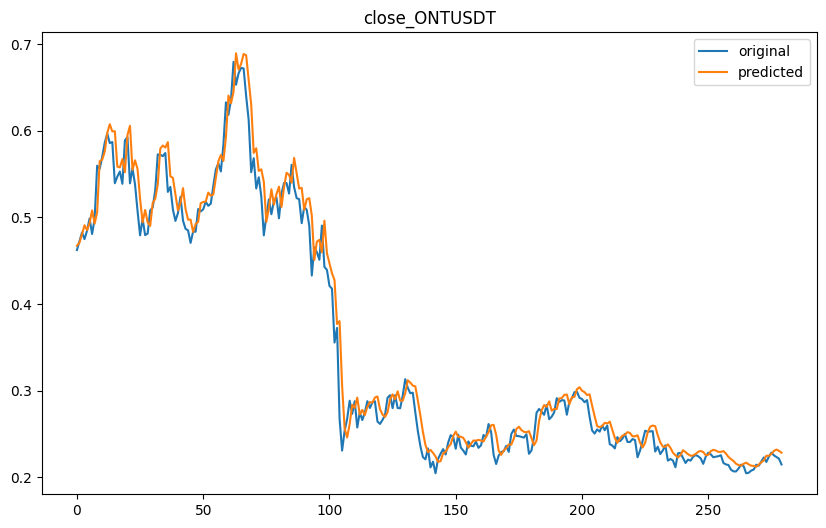

Metrics for 280 days: close_ONTUSDT MSE: 0.0004559413156618762, RMSE: 0.021352782386889917 MAPE: 0.04291247214379143


[I 2023-10-24 23:18:21,846] A new study created in RDB with name: close_BTCUSDT


Metrics for 90 days: close_ONTUSDT MSE: 0.00011318263568727211, RMSE: 0.010638732804581198 MAPE: 0.03532864378026001
Metrics for 30 days: close_ONTUSDT MSE: 5.839355209374453e-05, RMSE: 0.007641567384623689 MAPE: 0.030069448608606216
Metrics for 7 days: close_ONTUSDT MSE: 6.008556721248758e-05, RMSE: 0.007751488064396899 MAPE: 0.02998260230487566
11/11 [==============================] - 0s 3ms/step - loss: 1.1578e-04 - mean_absolute_percentage_error_keras: 2.4625


[I 2023-10-24 23:18:34,823] Trial 0 finished with value: 2.4624974727630615 and parameters: {'num_layers': 2, 'units_layer_0': 192, 'units_layer_1': 160, 'sequence_length': 7, 'learning_rate': 0.0006161834404462791, 'dropout_rate': 0.08986921002371623, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 0 with value: 2.4624974727630615.


11/11 [==============================] - 0s 1ms/step - loss: 1.4605e-04 - mean_absolute_percentage_error_keras: 2.8621


[I 2023-10-24 23:18:43,401] Trial 1 finished with value: 2.8621206283569336 and parameters: {'num_layers': 1, 'units_layer_0': 64, 'sequence_length': 9, 'learning_rate': 0.0007416533260686734, 'dropout_rate': 0.019783620447038408, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 0 with value: 2.4624974727630615.


11/11 [==============================] - 0s 1ms/step - loss: 4.7589e-04 - mean_absolute_percentage_error_keras: 5.8988


[I 2023-10-24 23:18:55,870] Trial 2 finished with value: 5.898768901824951 and parameters: {'num_layers': 2, 'units_layer_0': 32, 'units_layer_1': 160, 'sequence_length': 2, 'learning_rate': 0.00022257839816746373, 'dropout_rate': 0.2123997034501151, 'min_max_scaling': 1, 'layer_type': 'LSTM'}. Best is trial 0 with value: 2.4624974727630615.


11/11 [==============================] - 0s 2ms/step - loss: 3.5426e-04 - mean_absolute_percentage_error_keras: 4.4594


[I 2023-10-24 23:19:08,061] Trial 3 finished with value: 4.459404945373535 and parameters: {'num_layers': 1, 'units_layer_0': 128, 'sequence_length': 7, 'learning_rate': 7.809810365510626e-05, 'dropout_rate': 0.0531149775962374, 'min_max_scaling': 1, 'layer_type': 'LSTM'}. Best is trial 0 with value: 2.4624974727630615.


11/11 [==============================] - 0s 2ms/step - loss: 0.0135 - mean_absolute_percentage_error_keras: 31.2773


[I 2023-10-24 23:19:23,675] Trial 4 finished with value: 31.277313232421875 and parameters: {'num_layers': 3, 'units_layer_0': 32, 'units_layer_1': 64, 'units_layer_2': 96, 'sequence_length': 10, 'learning_rate': 9.869443279591528e-05, 'dropout_rate': 0.4729883853233721, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 0 with value: 2.4624974727630615.
[I 2023-10-24 23:19:31,881] Trial 5 pruned. 
[I 2023-10-24 23:19:38,237] Trial 6 pruned. 


11/11 [==============================] - 0s 2ms/step - loss: 4.0870e-04 - mean_absolute_percentage_error_keras: 4.9894


[I 2023-10-24 23:19:52,923] Trial 7 finished with value: 4.989412307739258 and parameters: {'num_layers': 3, 'units_layer_0': 256, 'units_layer_1': 32, 'units_layer_2': 192, 'sequence_length': 1, 'learning_rate': 0.0006266045707459074, 'dropout_rate': 0.11035465975349795, 'min_max_scaling': 1, 'layer_type': 'LSTM'}. Best is trial 0 with value: 2.4624974727630615.
[I 2023-10-24 23:20:01,773] Trial 8 pruned. 
[I 2023-10-24 23:20:05,866] Trial 9 pruned. 
[I 2023-10-24 23:20:17,567] Trial 10 pruned. 


11/11 [==============================] - 0s 3ms/step - loss: 1.2913e-04 - mean_absolute_percentage_error_keras: 2.7520


[I 2023-10-24 23:20:33,853] Trial 11 finished with value: 2.7519989013671875 and parameters: {'num_layers': 2, 'units_layer_0': 192, 'units_layer_1': 256, 'sequence_length': 8, 'learning_rate': 0.0007438143102575538, 'dropout_rate': 0.001306765234176166, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 0 with value: 2.4624974727630615.


11/11 [==============================] - 0s 3ms/step - loss: 2.8234e-04 - mean_absolute_percentage_error_keras: 4.5214


[I 2023-10-24 23:20:49,369] Trial 12 finished with value: 4.521440505981445 and parameters: {'num_layers': 2, 'units_layer_0': 192, 'units_layer_1': 256, 'sequence_length': 8, 'learning_rate': 0.0004544538819384466, 'dropout_rate': 0.013315496528138682, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 0 with value: 2.4624974727630615.


11/11 [==============================] - 0s 2ms/step - loss: 9.6083e-05 - mean_absolute_percentage_error_keras: 2.1575


[I 2023-10-24 23:21:02,171] Trial 13 finished with value: 2.1575398445129395 and parameters: {'num_layers': 2, 'units_layer_0': 192, 'units_layer_1': 192, 'sequence_length': 6, 'learning_rate': 0.0008151470542912184, 'dropout_rate': 0.08662216638138495, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 13 with value: 2.1575398445129395.


11/11 [==============================] - 0s 2ms/step - loss: 872409.8750 - mean_absolute_percentage_error_keras: 3.2613


[I 2023-10-24 23:21:13,783] Trial 14 finished with value: 3.2612509727478027 and parameters: {'num_layers': 2, 'units_layer_0': 160, 'units_layer_1': 192, 'sequence_length': 5, 'learning_rate': 0.0008572587519410269, 'dropout_rate': 0.1130342187255548, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 13 with value: 2.1575398445129395.
[I 2023-10-24 23:21:22,196] Trial 15 pruned. 


11/11 [==============================] - 0s 2ms/step - loss: 3.5767e-04 - mean_absolute_percentage_error_keras: 5.0620


[I 2023-10-24 23:21:34,777] Trial 16 finished with value: 5.061952590942383 and parameters: {'num_layers': 2, 'units_layer_0': 160, 'units_layer_1': 192, 'sequence_length': 6, 'learning_rate': 0.0008328388938934537, 'dropout_rate': 0.07582225317962522, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 13 with value: 2.1575398445129395.


11/11 [==============================] - 0s 2ms/step - loss: 665869.6875 - mean_absolute_percentage_error_keras: 2.5760


[I 2023-10-24 23:21:46,377] Trial 17 finished with value: 2.576018810272217 and parameters: {'num_layers': 2, 'units_layer_0': 224, 'units_layer_1': 96, 'sequence_length': 4, 'learning_rate': 0.0005465281431244799, 'dropout_rate': 0.16063987148289469, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 13 with value: 2.1575398445129395.


11/11 [==============================] - 0s 3ms/step - loss: 9.8835e-05 - mean_absolute_percentage_error_keras: 2.1360


[I 2023-10-24 23:22:02,526] Trial 18 finished with value: 2.135984420776367 and parameters: {'num_layers': 3, 'units_layer_0': 128, 'units_layer_1': 160, 'units_layer_2': 32, 'sequence_length': 7, 'learning_rate': 0.0006343025480936715, 'dropout_rate': 0.08014850695985155, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 18 with value: 2.135984420776367.
[I 2023-10-24 23:22:09,509] Trial 19 pruned. 


11/11 [==============================] - 0s 2ms/step - loss: 1930827.0000 - mean_absolute_percentage_error_keras: 5.0902


[I 2023-10-24 23:22:26,322] Trial 20 finished with value: 5.090243339538574 and parameters: {'num_layers': 3, 'units_layer_0': 96, 'units_layer_1': 96, 'units_layer_2': 128, 'sequence_length': 8, 'learning_rate': 0.000846503261260203, 'dropout_rate': 0.0518757004474553, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 18 with value: 2.135984420776367.


11/11 [==============================] - 0s 2ms/step - loss: 5.1434e-04 - mean_absolute_percentage_error_keras: 6.0879


[I 2023-10-24 23:22:39,272] Trial 21 finished with value: 6.087889194488525 and parameters: {'num_layers': 2, 'units_layer_0': 160, 'units_layer_1': 160, 'sequence_length': 7, 'learning_rate': 0.0006370965367349228, 'dropout_rate': 0.09197266805016707, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 18 with value: 2.135984420776367.


11/11 [==============================] - 0s 2ms/step - loss: 5.7068e-04 - mean_absolute_percentage_error_keras: 7.0234


[I 2023-10-24 23:22:55,559] Trial 22 finished with value: 7.023449897766113 and parameters: {'num_layers': 3, 'units_layer_0': 224, 'units_layer_1': 160, 'units_layer_2': 32, 'sequence_length': 6, 'learning_rate': 0.0005867171887272419, 'dropout_rate': 0.14827441858789292, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 18 with value: 2.135984420776367.


11/11 [==============================] - 0s 3ms/step - loss: 2.9508e-04 - mean_absolute_percentage_error_keras: 4.4474


[I 2023-10-24 23:23:08,878] Trial 23 finished with value: 4.447429180145264 and parameters: {'num_layers': 2, 'units_layer_0': 192, 'units_layer_1': 192, 'sequence_length': 7, 'learning_rate': 0.0006922417842601872, 'dropout_rate': 0.0802062737666777, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 18 with value: 2.135984420776367.


11/11 [==============================] - 0s 2ms/step - loss: 2.1128e-04 - mean_absolute_percentage_error_keras: 3.8684


[I 2023-10-24 23:23:26,504] Trial 24 finished with value: 3.868350028991699 and parameters: {'num_layers': 3, 'units_layer_0': 128, 'units_layer_1': 224, 'units_layer_2': 160, 'sequence_length': 5, 'learning_rate': 0.0004972389219364523, 'dropout_rate': 0.04954065479018434, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 18 with value: 2.135984420776367.


11/11 [==============================] - 0s 2ms/step - loss: 4.5285e-04 - mean_absolute_percentage_error_keras: 5.9988


[I 2023-10-24 23:23:40,469] Trial 25 finished with value: 5.998779773712158 and parameters: {'num_layers': 2, 'units_layer_0': 160, 'units_layer_1': 128, 'sequence_length': 9, 'learning_rate': 0.0007822184124262516, 'dropout_rate': 0.12350391959544188, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 18 with value: 2.135984420776367.


11/11 [==============================] - 0s 1ms/step - loss: 1.8167e-04 - mean_absolute_percentage_error_keras: 3.3266


[I 2023-10-24 23:23:49,450] Trial 26 finished with value: 3.326625347137451 and parameters: {'num_layers': 1, 'units_layer_0': 224, 'sequence_length': 6, 'learning_rate': 0.0006389760994783947, 'dropout_rate': 0.16432088867708472, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 18 with value: 2.135984420776367.


11/11 [==============================] - 0s 4ms/step - loss: 1.2025e-04 - mean_absolute_percentage_error_keras: 2.4763


[I 2023-10-24 23:24:13,134] Trial 27 finished with value: 2.476290464401245 and parameters: {'num_layers': 3, 'units_layer_0': 192, 'units_layer_1': 224, 'units_layer_2': 256, 'sequence_length': 10, 'learning_rate': 0.0008905419870524729, 'dropout_rate': 0.0875680904072525, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 18 with value: 2.135984420776367.


11/11 [==============================] - 0s 3ms/step - loss: 9.9896e-05 - mean_absolute_percentage_error_keras: 2.0715


[I 2023-10-24 23:24:33,362] Trial 28 finished with value: 2.071492910385132 and parameters: {'num_layers': 4, 'units_layer_0': 128, 'units_layer_1': 160, 'units_layer_2': 64, 'units_layer_3': 32, 'sequence_length': 8, 'learning_rate': 0.0007136232995037808, 'dropout_rate': 0.036830166503114804, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 28 with value: 2.071492910385132.


11/11 [==============================] - 0s 4ms/step - loss: 1.3239e-04 - mean_absolute_percentage_error_keras: 2.5517


[I 2023-10-24 23:24:53,708] Trial 29 finished with value: 2.5517475605010986 and parameters: {'num_layers': 4, 'units_layer_0': 64, 'units_layer_1': 96, 'units_layer_2': 64, 'units_layer_3': 32, 'sequence_length': 8, 'learning_rate': 0.0009244025548061634, 'dropout_rate': 0.035720293932522205, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 28 with value: 2.071492910385132.


11/11 [==============================] - 0s 3ms/step - loss: 6.0186e-04 - mean_absolute_percentage_error_keras: 6.9828


[I 2023-10-24 23:25:13,311] Trial 30 finished with value: 6.982839584350586 and parameters: {'num_layers': 4, 'units_layer_0': 128, 'units_layer_1': 192, 'units_layer_2': 32, 'units_layer_3': 96, 'sequence_length': 7, 'learning_rate': 0.0007692374581328862, 'dropout_rate': 0.0067804052676128206, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 28 with value: 2.071492910385132.
[I 2023-10-24 23:25:20,846] Trial 31 pruned. 


11/11 [==============================] - 0s 2ms/step - loss: 2.8020e-04 - mean_absolute_percentage_error_keras: 4.4685


[I 2023-10-24 23:25:34,751] Trial 32 finished with value: 4.468465328216553 and parameters: {'num_layers': 2, 'units_layer_0': 160, 'units_layer_1': 160, 'sequence_length': 8, 'learning_rate': 0.0007312028793103853, 'dropout_rate': 0.06997718275489853, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 28 with value: 2.071492910385132.


11/11 [==============================] - 0s 1ms/step - loss: 9.8124e-05 - mean_absolute_percentage_error_keras: 2.0311


[I 2023-10-24 23:25:43,449] Trial 33 finished with value: 2.0311331748962402 and parameters: {'num_layers': 1, 'units_layer_0': 128, 'sequence_length': 7, 'learning_rate': 0.0008041049234354058, 'dropout_rate': 0.03297050314691725, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 33 with value: 2.0311331748962402.


11/11 [==============================] - 0s 1ms/step - loss: 3.3789e-04 - mean_absolute_percentage_error_keras: 4.8137


[I 2023-10-24 23:25:51,389] Trial 34 finished with value: 4.813720226287842 and parameters: {'num_layers': 1, 'units_layer_0': 128, 'sequence_length': 7, 'learning_rate': 0.0007911078505687741, 'dropout_rate': 0.032148470343698596, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 33 with value: 2.0311331748962402.
[I 2023-10-24 23:25:56,366] Trial 35 pruned. 


11/11 [==============================] - 0s 2ms/step - loss: 1.9401e-04 - mean_absolute_percentage_error_keras: 3.5268


[I 2023-10-24 23:26:04,593] Trial 36 finished with value: 3.5267553329467773 and parameters: {'num_layers': 1, 'units_layer_0': 128, 'sequence_length': 9, 'learning_rate': 0.0007822418806583421, 'dropout_rate': 0.06133847991454073, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 33 with value: 2.0311331748962402.
[I 2023-10-24 23:26:11,056] Trial 37 pruned. 
[I 2023-10-24 23:26:25,652] Trial 38 pruned. 


11/11 [==============================] - 0s 1ms/step - loss: 9.0408e-05 - mean_absolute_percentage_error_keras: 2.0271


[I 2023-10-24 23:26:33,771] Trial 39 finished with value: 2.0270779132843018 and parameters: {'num_layers': 1, 'units_layer_0': 160, 'sequence_length': 5, 'learning_rate': 0.0006855393613458377, 'dropout_rate': 0.053966542467845824, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 39 with value: 2.0270779132843018.


11/11 [==============================] - 0s 2ms/step - loss: 1.7698e-04 - mean_absolute_percentage_error_keras: 3.1701


[I 2023-10-24 23:26:42,791] Trial 40 finished with value: 3.1701157093048096 and parameters: {'num_layers': 1, 'units_layer_0': 160, 'sequence_length': 2, 'learning_rate': 0.0006628645701573789, 'dropout_rate': 0.05817933192338438, 'min_max_scaling': 1, 'layer_type': 'LSTM'}. Best is trial 39 with value: 2.0270779132843018.


11/11 [==============================] - 0s 1ms/step - loss: 2.1060e-04 - mean_absolute_percentage_error_keras: 3.8248


[I 2023-10-24 23:26:49,903] Trial 41 finished with value: 3.8247523307800293 and parameters: {'num_layers': 1, 'units_layer_0': 160, 'sequence_length': 5, 'learning_rate': 0.0007181513771038909, 'dropout_rate': 0.09361877946744487, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 39 with value: 2.0270779132843018.


11/11 [==============================] - 0s 1ms/step - loss: 2.3938e-04 - mean_absolute_percentage_error_keras: 4.1259


[I 2023-10-24 23:26:57,461] Trial 42 finished with value: 4.125852108001709 and parameters: {'num_layers': 1, 'units_layer_0': 128, 'sequence_length': 6, 'learning_rate': 0.0006620040229327105, 'dropout_rate': 0.027233196885019684, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 39 with value: 2.0270779132843018.


11/11 [==============================] - 0s 1ms/step - loss: 2.0787e-04 - mean_absolute_percentage_error_keras: 3.6700


[I 2023-10-24 23:27:03,945] Trial 43 finished with value: 3.670037269592285 and parameters: {'num_layers': 1, 'units_layer_0': 96, 'sequence_length': 4, 'learning_rate': 0.0005980555483903972, 'dropout_rate': 0.06176881415914429, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 39 with value: 2.0270779132843018.


11/11 [==============================] - 0s 1ms/step - loss: 1.1823e-04 - mean_absolute_percentage_error_keras: 2.5773


[I 2023-10-24 23:27:11,618] Trial 44 finished with value: 2.577296018600464 and parameters: {'num_layers': 1, 'units_layer_0': 160, 'sequence_length': 7, 'learning_rate': 0.0007465308390364153, 'dropout_rate': 0.12791129176624605, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 39 with value: 2.0270779132843018.


11/11 [==============================] - 0s 2ms/step - loss: 1.5155e-04 - mean_absolute_percentage_error_keras: 2.6714


[I 2023-10-24 23:27:25,923] Trial 45 finished with value: 2.6714205741882324 and parameters: {'num_layers': 3, 'units_layer_0': 96, 'units_layer_1': 192, 'units_layer_2': 64, 'sequence_length': 3, 'learning_rate': 0.0008107415558850675, 'dropout_rate': 0.1050769968499837, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 39 with value: 2.0270779132843018.
[I 2023-10-24 23:27:32,718] Trial 46 pruned. 


11/11 [==============================] - 0s 1ms/step - loss: 9.0399e-05 - mean_absolute_percentage_error_keras: 1.8981


[I 2023-10-24 23:27:40,442] Trial 47 finished with value: 1.8981318473815918 and parameters: {'num_layers': 1, 'units_layer_0': 128, 'sequence_length': 6, 'learning_rate': 0.0007540180585432919, 'dropout_rate': 0.06950798687022877, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 47 with value: 1.8981318473815918.


11/11 [==============================] - 0s 1ms/step - loss: 426998.6875 - mean_absolute_percentage_error_keras: 1.9332


[I 2023-10-24 23:27:48,000] Trial 48 finished with value: 1.9332191944122314 and parameters: {'num_layers': 1, 'units_layer_0': 128, 'sequence_length': 7, 'learning_rate': 0.0006164439801032683, 'dropout_rate': 0.04700535514023059, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 47 with value: 1.8981318473815918.


11/11 [==============================] - 0s 2ms/step - loss: 434949.1250 - mean_absolute_percentage_error_keras: 1.8942


[I 2023-10-24 23:27:56,196] Trial 49 finished with value: 1.8942413330078125 and parameters: {'num_layers': 1, 'units_layer_0': 96, 'sequence_length': 10, 'learning_rate': 0.0007558941124776603, 'dropout_rate': 0.00034874042866381294, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 49 with value: 1.8942413330078125.


Best Hyperparameters: {'num_layers': 1, 'units_layer_0': 96, 'sequence_length': 10, 'learning_rate': 0.0007558941124776603, 'dropout_rate': 0.00034874042866381294, 'min_max_scaling': 0, 'layer_type': 'RNN'}
Epoch 1/100
46/46 [==============================] - 1s 4ms/step - loss: 134991168.0000
Epoch 2/100
46/46 [==============================] - 0s 3ms/step - loss: 2611923.7500
Epoch 3/100
46/46 [==============================] - 0s 2ms/step - loss: 2038348.1250
Epoch 4/100
46/46 [==============================] - 0s 2ms/step - loss: 2833107.7500
Epoch 5/100
46/46 [==============================] - 0s 2ms/step - loss: 1895798.5000
Epoch 6/100
46/46 [==============================] - 0s 2ms/step - loss: 2117773.7500
Epoch 7/100
46/46 [==============================] - 0s 2ms/step - loss: 1786603.5000
Epoch 8/100
46/46 [==============================] - 0s 3ms/step - loss: 1725579.6250
Epoch 9/100
46/46 [==============================] - 0s 2ms/step - loss: 3142588.0000
Epoch 10/100
46/4

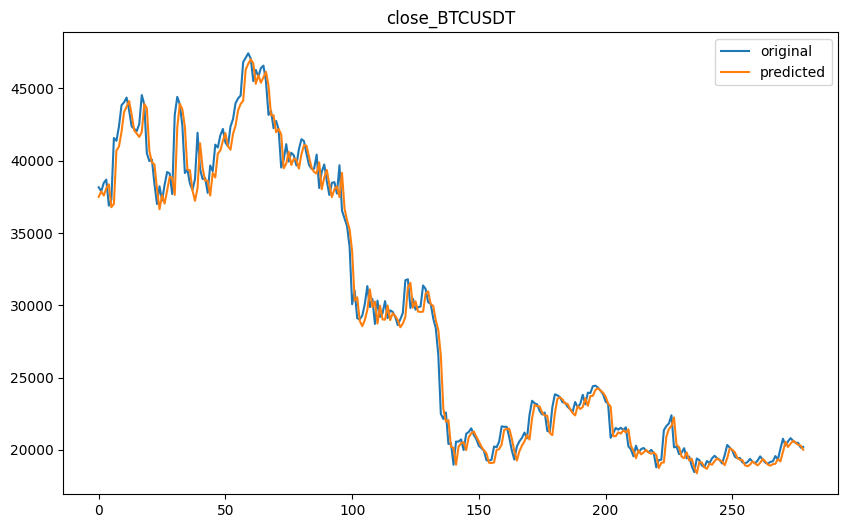

[I 2023-10-24 23:28:09,492] A new study created in RDB with name: close_NEOUSDT


Metrics for 279 days: close_BTCUSDT MSE: 1176471.5774093405, RMSE: 1084.6527450798899 MAPE: 0.02472091920203828
Metrics for 90 days: close_BTCUSDT MSE: 330933.4620338372, RMSE: 575.2681653227799 MAPE: 0.0185183696688736
Metrics for 30 days: close_BTCUSDT MSE: 105695.63537444148, RMSE: 325.10865164501774 MAPE: 0.011470671324886614
Metrics for 7 days: close_BTCUSDT MSE: 53641.203678362814, RMSE: 231.6057073527395 MAPE: 0.008700108609805962
11/11 [==============================] - 0s 2ms/step - loss: 2.6166e-05 - mean_absolute_percentage_error_keras: 17.6655


[I 2023-10-24 23:28:20,714] Trial 0 finished with value: 17.665451049804688 and parameters: {'num_layers': 2, 'units_layer_0': 128, 'units_layer_1': 64, 'sequence_length': 5, 'learning_rate': 0.0009133584305539967, 'dropout_rate': 0.31044406071013936, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 0 with value: 17.665451049804688.


11/11 [==============================] - 0s 2ms/step - loss: 8.7276e-05 - mean_absolute_percentage_error_keras: 45.6352


[I 2023-10-24 23:28:33,246] Trial 1 finished with value: 45.635162353515625 and parameters: {'num_layers': 2, 'units_layer_0': 32, 'units_layer_1': 96, 'sequence_length': 3, 'learning_rate': 0.0006612129947069148, 'dropout_rate': 0.16706777022158953, 'min_max_scaling': 1, 'layer_type': 'LSTM'}. Best is trial 0 with value: 17.665451049804688.


11/11 [==============================] - 0s 7ms/step - loss: 0.4146 - mean_absolute_percentage_error_keras: 4.3498


[I 2023-10-24 23:29:15,625] Trial 2 finished with value: 4.349783420562744 and parameters: {'num_layers': 4, 'units_layer_0': 128, 'units_layer_1': 160, 'units_layer_2': 32, 'units_layer_3': 256, 'sequence_length': 7, 'learning_rate': 0.000620462128727245, 'dropout_rate': 0.03324554099116789, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 2 with value: 4.349783420562744.


11/11 [==============================] - 0s 2ms/step - loss: 6.4838e-05 - mean_absolute_percentage_error_keras: 41.4452


[I 2023-10-24 23:29:25,078] Trial 3 finished with value: 41.44521713256836 and parameters: {'num_layers': 1, 'units_layer_0': 192, 'sequence_length': 2, 'learning_rate': 0.00044958380030177275, 'dropout_rate': 0.21006043676481523, 'min_max_scaling': 1, 'layer_type': 'LSTM'}. Best is trial 2 with value: 4.349783420562744.


11/11 [==============================] - 0s 2ms/step - loss: 4.8702e-05 - mean_absolute_percentage_error_keras: 32.6005


[I 2023-10-24 23:29:35,177] Trial 4 finished with value: 32.6004638671875 and parameters: {'num_layers': 1, 'units_layer_0': 128, 'sequence_length': 4, 'learning_rate': 0.0008477099819827518, 'dropout_rate': 0.3088037522139047, 'min_max_scaling': 1, 'layer_type': 'LSTM'}. Best is trial 2 with value: 4.349783420562744.
[I 2023-10-24 23:29:52,622] Trial 5 pruned. 
[I 2023-10-24 23:29:59,527] Trial 6 pruned. 
[I 2023-10-24 23:30:04,092] Trial 7 pruned. 
[I 2023-10-24 23:30:08,169] Trial 8 pruned. 


11/11 [==============================] - 0s 1ms/step - loss: 0.4514 - mean_absolute_percentage_error_keras: 6.2246


[I 2023-10-24 23:30:17,384] Trial 9 finished with value: 6.224573135375977 and parameters: {'num_layers': 1, 'units_layer_0': 32, 'sequence_length': 7, 'learning_rate': 0.0008855549989774432, 'dropout_rate': 0.14298417492558257, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 2 with value: 4.349783420562744.


11/11 [==============================] - 0s 5ms/step - loss: 0.2258 - mean_absolute_percentage_error_keras: 3.3543


[I 2023-10-24 23:30:46,291] Trial 10 finished with value: 3.3542778491973877 and parameters: {'num_layers': 4, 'units_layer_0': 256, 'units_layer_1': 192, 'units_layer_2': 32, 'units_layer_3': 256, 'sequence_length': 10, 'learning_rate': 0.00042537732223520494, 'dropout_rate': 0.009403198262070145, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 10 with value: 3.3542778491973877.


11/11 [==============================] - 0s 4ms/step - loss: 0.4508 - mean_absolute_percentage_error_keras: 5.9799


[I 2023-10-24 23:31:14,342] Trial 11 finished with value: 5.979886531829834 and parameters: {'num_layers': 4, 'units_layer_0': 256, 'units_layer_1': 192, 'units_layer_2': 32, 'units_layer_3': 256, 'sequence_length': 10, 'learning_rate': 0.0003743103385923949, 'dropout_rate': 0.007117726864476586, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 10 with value: 3.3542778491973877.


11/11 [==============================] - 0s 3ms/step - loss: 1.2638 - mean_absolute_percentage_error_keras: 11.4027


[I 2023-10-24 23:31:33,378] Trial 12 finished with value: 11.40274715423584 and parameters: {'num_layers': 3, 'units_layer_0': 256, 'units_layer_1': 160, 'units_layer_2': 32, 'sequence_length': 8, 'learning_rate': 0.0003320228789940767, 'dropout_rate': 0.08181945436753318, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 10 with value: 3.3542778491973877.


11/11 [==============================] - 0s 5ms/step - loss: 0.2069 - mean_absolute_percentage_error_keras: 2.8356


[I 2023-10-24 23:31:57,155] Trial 13 finished with value: 2.8356359004974365 and parameters: {'num_layers': 4, 'units_layer_0': 96, 'units_layer_1': 256, 'units_layer_2': 32, 'units_layer_3': 256, 'sequence_length': 9, 'learning_rate': 0.0002683192335049279, 'dropout_rate': 0.060800586296947345, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 13 with value: 2.8356359004974365.


11/11 [==============================] - 0s 3ms/step - loss: 0.2979 - mean_absolute_percentage_error_keras: 4.4789


[I 2023-10-24 23:32:17,927] Trial 14 finished with value: 4.47886848449707 and parameters: {'num_layers': 3, 'units_layer_0': 64, 'units_layer_1': 256, 'units_layer_2': 128, 'sequence_length': 9, 'learning_rate': 0.00022933284319142825, 'dropout_rate': 0.07906948486732497, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 13 with value: 2.8356359004974365.


11/11 [==============================] - 0s 4ms/step - loss: 0.7343 - mean_absolute_percentage_error_keras: 8.1592


[I 2023-10-24 23:32:42,548] Trial 15 finished with value: 8.159207344055176 and parameters: {'num_layers': 3, 'units_layer_0': 224, 'units_layer_1': 256, 'units_layer_2': 256, 'sequence_length': 9, 'learning_rate': 0.0002268060673185159, 'dropout_rate': 0.1866037594667266, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 13 with value: 2.8356359004974365.


11/11 [==============================] - 0s 4ms/step - loss: 0.3444 - mean_absolute_percentage_error_keras: 4.5268


[I 2023-10-24 23:33:06,896] Trial 16 finished with value: 4.526839733123779 and parameters: {'num_layers': 4, 'units_layer_0': 96, 'units_layer_1': 224, 'units_layer_2': 96, 'units_layer_3': 256, 'sequence_length': 9, 'learning_rate': 0.0004883758820151769, 'dropout_rate': 0.10462819337130037, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 13 with value: 2.8356359004974365.


11/11 [==============================] - 0s 3ms/step - loss: 0.2604 - mean_absolute_percentage_error_keras: 3.9433


[I 2023-10-24 23:33:27,764] Trial 17 finished with value: 3.9433071613311768 and parameters: {'num_layers': 3, 'units_layer_0': 64, 'units_layer_1': 192, 'units_layer_2': 224, 'sequence_length': 10, 'learning_rate': 0.00019555372028770587, 'dropout_rate': 0.008329713473668504, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 13 with value: 2.8356359004974365.


11/11 [==============================] - 0s 4ms/step - loss: 0.2035 - mean_absolute_percentage_error_keras: 2.9990


[I 2023-10-24 23:33:52,582] Trial 18 finished with value: 2.9990074634552 and parameters: {'num_layers': 4, 'units_layer_0': 224, 'units_layer_1': 224, 'units_layer_2': 64, 'units_layer_3': 192, 'sequence_length': 8, 'learning_rate': 0.00033969020863830024, 'dropout_rate': 0.06080407313947178, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 13 with value: 2.8356359004974365.


11/11 [==============================] - 0s 4ms/step - loss: 2.8265 - mean_absolute_percentage_error_keras: 17.8665


[I 2023-10-24 23:34:16,903] Trial 19 finished with value: 17.866455078125 and parameters: {'num_layers': 4, 'units_layer_0': 192, 'units_layer_1': 256, 'units_layer_2': 96, 'units_layer_3': 160, 'sequence_length': 8, 'learning_rate': 0.0003047828441948143, 'dropout_rate': 0.23859392451691833, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 13 with value: 2.8356359004974365.


11/11 [==============================] - 0s 3ms/step - loss: 0.2199 - mean_absolute_percentage_error_keras: 3.2984


[I 2023-10-24 23:34:36,760] Trial 20 finished with value: 3.2984161376953125 and parameters: {'num_layers': 3, 'units_layer_0': 224, 'units_layer_1': 224, 'units_layer_2': 64, 'sequence_length': 8, 'learning_rate': 0.000133237963234286, 'dropout_rate': 0.137345508488442, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 13 with value: 2.8356359004974365.


11/11 [==============================] - 0s 4ms/step - loss: 1.2513 - mean_absolute_percentage_error_keras: 11.3951


[I 2023-10-24 23:34:58,136] Trial 21 finished with value: 11.395100593566895 and parameters: {'num_layers': 3, 'units_layer_0': 224, 'units_layer_1': 224, 'units_layer_2': 64, 'sequence_length': 8, 'learning_rate': 0.00012593909197760795, 'dropout_rate': 0.13513431524169273, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 13 with value: 2.8356359004974365.


11/11 [==============================] - 0s 3ms/step - loss: 0.2658 - mean_absolute_percentage_error_keras: 3.8134


[I 2023-10-24 23:35:19,818] Trial 22 finished with value: 3.813436508178711 and parameters: {'num_layers': 4, 'units_layer_0': 224, 'units_layer_1': 224, 'units_layer_2': 64, 'units_layer_3': 192, 'sequence_length': 6, 'learning_rate': 0.00016226173133930278, 'dropout_rate': 0.05889706453296559, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 13 with value: 2.8356359004974365.


11/11 [==============================] - 0s 3ms/step - loss: 1.3219 - mean_absolute_percentage_error_keras: 11.8370


[I 2023-10-24 23:35:39,363] Trial 23 finished with value: 11.837019920349121 and parameters: {'num_layers': 3, 'units_layer_0': 96, 'units_layer_1': 256, 'units_layer_2': 192, 'sequence_length': 8, 'learning_rate': 0.00027130597034908136, 'dropout_rate': 0.12456278018390282, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 13 with value: 2.8356359004974365.
2023-10-24 23:35:41.719970: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_483/simple_rnn_687/while/body/_157/sequential_483/simple_rnn_687/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-24 23:35:41.721737: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_483/simple_rnn_686/while/body/_74/sequential_483/simple_rnn_686/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-24 23:35:41.722570: W tensorfl

11/11 [==============================] - 0s 2ms/step - loss: 0.1978 - mean_absolute_percentage_error_keras: 2.8999


[I 2023-10-24 23:35:50,498] Trial 24 finished with value: 2.8998589515686035 and parameters: {'num_layers': 4, 'units_layer_0': 224, 'units_layer_1': 128, 'units_layer_2': 64, 'units_layer_3': 32, 'sequence_length': 1, 'learning_rate': 0.00011218372793930843, 'dropout_rate': 0.05746705722455546, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 13 with value: 2.8356359004974365.
2023-10-24 23:35:54.021266: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_484/simple_rnn_691/while/body/_157/sequential_484/simple_rnn_691/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-24 23:35:54.023076: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_484/simple_rnn_690/while/body/_74/sequential_484/simple_rnn_690/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-24 23:35:

11/11 [==============================] - 0s 1ms/step - loss: 0.9890 - mean_absolute_percentage_error_keras: 9.8816


[I 2023-10-24 23:36:03,450] Trial 25 finished with value: 9.88161849975586 and parameters: {'num_layers': 4, 'units_layer_0': 160, 'units_layer_1': 128, 'units_layer_2': 96, 'units_layer_3': 64, 'sequence_length': 1, 'learning_rate': 0.0003440191247851388, 'dropout_rate': 0.06070163557115197, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 13 with value: 2.8356359004974365.
2023-10-24 23:36:05.822966: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_485/simple_rnn_695/while/body/_157/sequential_485/simple_rnn_695/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-24 23:36:05.824591: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_485/simple_rnn_694/while/body/_74/sequential_485/simple_rnn_694/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-24 23:36:05.

11/11 [==============================] - 0s 2ms/step - loss: 1.0044 - mean_absolute_percentage_error_keras: 9.7009


[I 2023-10-24 23:36:24,447] Trial 27 finished with value: 9.700909614562988 and parameters: {'num_layers': 4, 'units_layer_0': 256, 'units_layer_1': 96, 'units_layer_2': 64, 'units_layer_3': 192, 'sequence_length': 3, 'learning_rate': 8.04148529626164e-05, 'dropout_rate': 0.09830006696999927, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 13 with value: 2.8356359004974365.


11/11 [==============================] - 0s 2ms/step - loss: 0.4672 - mean_absolute_percentage_error_keras: 6.0775


[I 2023-10-24 23:36:39,478] Trial 28 finished with value: 6.077499866485596 and parameters: {'num_layers': 4, 'units_layer_0': 64, 'units_layer_1': 128, 'units_layer_2': 96, 'units_layer_3': 96, 'sequence_length': 3, 'learning_rate': 0.0002707314296443322, 'dropout_rate': 0.041542126750657354, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 13 with value: 2.8356359004974365.


11/11 [==============================] - 0s 2ms/step - loss: 0.2039 - mean_absolute_percentage_error_keras: 2.9212


[I 2023-10-24 23:36:51,813] Trial 29 finished with value: 2.9211862087249756 and parameters: {'num_layers': 2, 'units_layer_0': 160, 'units_layer_1': 160, 'sequence_length': 5, 'learning_rate': 0.00017248366331287551, 'dropout_rate': 0.1713549334768781, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 13 with value: 2.8356359004974365.


11/11 [==============================] - 0s 2ms/step - loss: 0.3005 - mean_absolute_percentage_error_keras: 4.1385


[I 2023-10-24 23:37:02,377] Trial 30 finished with value: 4.138474941253662 and parameters: {'num_layers': 2, 'units_layer_0': 128, 'units_layer_1': 128, 'sequence_length': 4, 'learning_rate': 0.00011630709959938136, 'dropout_rate': 0.19111185263646485, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 13 with value: 2.8356359004974365.
2023-10-24 23:37:04.034442: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_490/simple_rnn_709/while/body/_1/sequential_490/simple_rnn_709/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-24 23:37:04.036143: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_490/simple_rnn_710/while/body/_74/sequential_490/simple_rnn_710/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-24 23:37:04.078494: E tensorflow/core/grappler/optimiz

11/11 [==============================] - 0s 1ms/step - loss: 0.3929 - mean_absolute_percentage_error_keras: 5.3349


[I 2023-10-24 23:37:12,078] Trial 31 finished with value: 5.334885120391846 and parameters: {'num_layers': 2, 'units_layer_0': 224, 'units_layer_1': 160, 'sequence_length': 2, 'learning_rate': 0.00018118454939250464, 'dropout_rate': 0.08800644701932421, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 13 with value: 2.8356359004974365.


11/11 [==============================] - 0s 2ms/step - loss: 0.7881 - mean_absolute_percentage_error_keras: 8.6293


[I 2023-10-24 23:37:23,198] Trial 32 finished with value: 8.629281044006348 and parameters: {'num_layers': 2, 'units_layer_0': 160, 'units_layer_1': 192, 'sequence_length': 4, 'learning_rate': 0.00024607384597837055, 'dropout_rate': 0.15781577057732613, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 13 with value: 2.8356359004974365.


11/11 [==============================] - 0s 2ms/step - loss: 0.1932 - mean_absolute_percentage_error_keras: 2.8448


[I 2023-10-24 23:37:35,764] Trial 33 finished with value: 2.844839572906494 and parameters: {'num_layers': 2, 'units_layer_0': 192, 'units_layer_1': 160, 'sequence_length': 6, 'learning_rate': 0.00037778091746052756, 'dropout_rate': 0.05090158209880305, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 13 with value: 2.8356359004974365.


11/11 [==============================] - 0s 2ms/step - loss: 0.2679 - mean_absolute_percentage_error_keras: 4.1577


[I 2023-10-24 23:37:49,599] Trial 34 finished with value: 4.157677173614502 and parameters: {'num_layers': 2, 'units_layer_0': 192, 'units_layer_1': 160, 'sequence_length': 5, 'learning_rate': 0.00018263183360442469, 'dropout_rate': 0.03370206830627176, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 13 with value: 2.8356359004974365.
[I 2023-10-24 23:37:53,741] Trial 35 pruned. 
2023-10-24 23:37:55.034574: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_495/simple_rnn_719/while/body/_1/sequential_495/simple_rnn_719/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-24 23:37:55.036232: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_495/simple_rnn_720/while/body/_74/sequential_495/simple_rnn_720/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-24 23:37

11/11 [==============================] - 0s 2ms/step - loss: 0.1958 - mean_absolute_percentage_error_keras: 2.8060


[I 2023-10-24 23:38:03,343] Trial 36 finished with value: 2.805980682373047 and parameters: {'num_layers': 2, 'units_layer_0': 192, 'units_layer_1': 128, 'sequence_length': 2, 'learning_rate': 0.0005489519019898812, 'dropout_rate': 0.16640668701299705, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 36 with value: 2.805980682373047.
[I 2023-10-24 23:38:07,588] Trial 37 pruned. 
2023-10-24 23:38:09.528570: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_497/simple_rnn_722/while/body/_74/sequential_497/simple_rnn_722/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-24 23:38:09.530266: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_497/simple_rnn_721/while/body/_1/sequential_497/simple_rnn_721/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-24 23:38:0

11/11 [==============================] - 0s 3ms/step - loss: 0.4192 - mean_absolute_percentage_error_keras: 5.6789


[I 2023-10-24 23:38:16,976] Trial 38 finished with value: 5.678905963897705 and parameters: {'num_layers': 3, 'units_layer_0': 192, 'units_layer_1': 96, 'units_layer_2': 192, 'sequence_length': 1, 'learning_rate': 0.0004929947281652006, 'dropout_rate': 0.03614347211855695, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 36 with value: 2.805980682373047.
[I 2023-10-24 23:38:19,667] Trial 39 pruned. 
[I 2023-10-24 23:38:24,773] Trial 40 pruned. 
2023-10-24 23:38:26.206470: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_500/simple_rnn_726/while/body/_1/sequential_500/simple_rnn_726/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-24 23:38:26.208365: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_500/simple_rnn_727/while/body/_74/sequential_500/simple_rnn_727/while/simple_rnn_cell/

11/11 [==============================] - 0s 1ms/step - loss: 0.2172 - mean_absolute_percentage_error_keras: 3.1172


[I 2023-10-24 23:38:34,246] Trial 41 finished with value: 3.117227554321289 and parameters: {'num_layers': 2, 'units_layer_0': 160, 'units_layer_1': 160, 'sequence_length': 2, 'learning_rate': 0.0003005015436995823, 'dropout_rate': 0.1683894354580786, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 36 with value: 2.805980682373047.


11/11 [==============================] - 0s 2ms/step - loss: 0.4199 - mean_absolute_percentage_error_keras: 5.5809


[I 2023-10-24 23:38:44,677] Trial 42 finished with value: 5.580934524536133 and parameters: {'num_layers': 2, 'units_layer_0': 192, 'units_layer_1': 128, 'sequence_length': 3, 'learning_rate': 0.00039418395998383395, 'dropout_rate': 0.266299110201322, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 36 with value: 2.805980682373047.


11/11 [==============================] - 0s 2ms/step - loss: 0.2127 - mean_absolute_percentage_error_keras: 2.8636


[I 2023-10-24 23:38:55,475] Trial 43 finished with value: 2.863626480102539 and parameters: {'num_layers': 2, 'units_layer_0': 128, 'units_layer_1': 96, 'sequence_length': 5, 'learning_rate': 6.607626899952516e-05, 'dropout_rate': 0.11793443449109176, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 36 with value: 2.805980682373047.
[I 2023-10-24 23:38:59,089] Trial 44 pruned. 


11/11 [==============================] - 0s 2ms/step - loss: 0.2392 - mean_absolute_percentage_error_keras: 3.3923


[I 2023-10-24 23:39:10,255] Trial 45 finished with value: 3.3923158645629883 and parameters: {'num_layers': 2, 'units_layer_0': 96, 'units_layer_1': 96, 'sequence_length': 7, 'learning_rate': 7.893880394924837e-05, 'dropout_rate': 0.10653472586655924, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 36 with value: 2.805980682373047.
2023-10-24 23:39:11.939617: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_505/simple_rnn_734/while/body/_1/sequential_505/simple_rnn_734/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-24 23:39:11.983639: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:134] tfg_optimizer{any(tfg-consolidate-attrs,tfg-toposort,tfg-shape-inference{graph-version=0},tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node sequential_505/simple_rnn_734/while/body/_1/sequential_505/simple_rnn_734/while/simple_rnn_cell/Relu has an empty op nam

11/11 [==============================] - 0s 1ms/step - loss: 0.2050 - mean_absolute_percentage_error_keras: 2.9616


[I 2023-10-24 23:39:17,886] Trial 46 finished with value: 2.961559772491455 and parameters: {'num_layers': 1, 'units_layer_0': 128, 'sequence_length': 1, 'learning_rate': 0.00045837941585462593, 'dropout_rate': 0.0006060592066608889, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 36 with value: 2.805980682373047.


11/11 [==============================] - 0s 1ms/step - loss: 0.2491 - mean_absolute_percentage_error_keras: 3.2633


[I 2023-10-24 23:39:28,360] Trial 47 finished with value: 3.2632830142974854 and parameters: {'num_layers': 2, 'units_layer_0': 128, 'units_layer_1': 96, 'sequence_length': 4, 'learning_rate': 3.412867199521402e-05, 'dropout_rate': 0.07819739944846929, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 36 with value: 2.805980682373047.
[I 2023-10-24 23:39:33,022] Trial 48 pruned. 


11/11 [==============================] - 0s 2ms/step - loss: 0.2284 - mean_absolute_percentage_error_keras: 3.3341


[I 2023-10-24 23:39:44,507] Trial 49 finished with value: 3.334139347076416 and parameters: {'num_layers': 2, 'units_layer_0': 224, 'units_layer_1': 32, 'sequence_length': 5, 'learning_rate': 0.00022157397519535681, 'dropout_rate': 0.10645921583615679, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 36 with value: 2.805980682373047.


Best Hyperparameters: {'num_layers': 2, 'units_layer_0': 192, 'units_layer_1': 128, 'sequence_length': 2, 'learning_rate': 0.0005489519019898812, 'dropout_rate': 0.16640668701299705, 'min_max_scaling': 0, 'layer_type': 'RNN'}
Epoch 1/100
46/46 [==============================] - 2s 3ms/step - loss: 63.3796
Epoch 2/100
46/46 [==============================] - 0s 3ms/step - loss: 16.7566
Epoch 3/100
46/46 [==============================] - 0s 3ms/step - loss: 13.6690
Epoch 4/100
46/46 [==============================] - 0s 4ms/step - loss: 14.2273
Epoch 5/100
46/46 [==============================] - 0s 3ms/step - loss: 13.3217
Epoch 6/100
46/46 [==============================] - 0s 4ms/step - loss: 13.7060
Epoch 7/100
46/46 [==============================] - 0s 3ms/step - loss: 11.6374
Epoch 8/100
46/46 [==============================] - 0s 3ms/step - loss: 9.5328
Epoch 9/100
46/46 [==============================] - 0s 3ms/step - loss: 12.8524
Epoch 10/100
46/46 [==========================

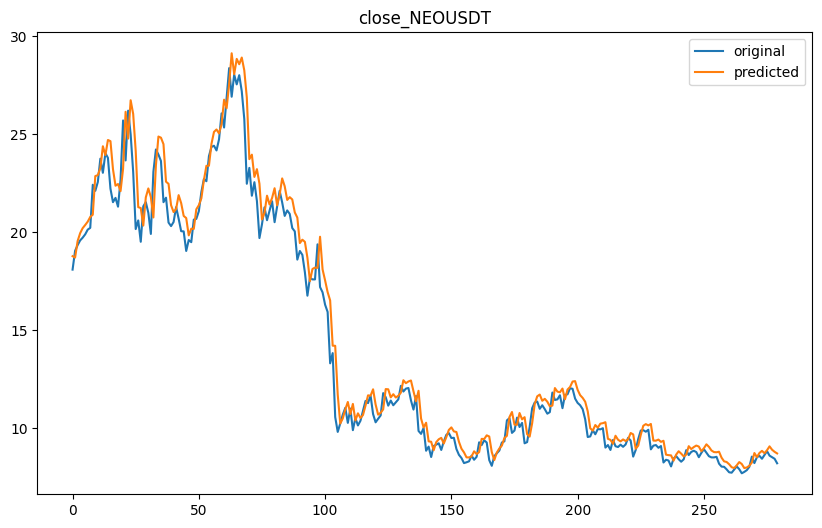

[I 2023-10-24 23:40:00,965] A new study created in RDB with name: close_XLMUSDT


Metrics for 280 days: close_NEOUSDT MSE: 0.9715276197832589, RMSE: 0.9856610065246869 MAPE: 0.04844307308175705
Metrics for 90 days: close_NEOUSDT MSE: 0.22194988404677113, RMSE: 0.4711155739802826 MAPE: 0.040866385155618315
Metrics for 30 days: close_NEOUSDT MSE: 0.1143057116390829, RMSE: 0.33809127708221476 MAPE: 0.0356031057933921
Metrics for 7 days: close_NEOUSDT MSE: 0.1315246842033186, RMSE: 0.3626633207305621 MAPE: 0.03801434886206125
11/11 [==============================] - 0s 3ms/step - loss: 7.4963e-05 - mean_absolute_percentage_error_keras: 5.2833


[I 2023-10-24 23:40:25,818] Trial 0 finished with value: 5.283327102661133 and parameters: {'num_layers': 4, 'units_layer_0': 256, 'units_layer_1': 160, 'units_layer_2': 32, 'units_layer_3': 192, 'sequence_length': 2, 'learning_rate': 0.00017069490825549326, 'dropout_rate': 0.005445010797701433, 'min_max_scaling': 1, 'layer_type': 'LSTM'}. Best is trial 0 with value: 5.283327102661133.


11/11 [==============================] - 0s 4ms/step - loss: 2.3438e-04 - mean_absolute_percentage_error_keras: 14.6629


[I 2023-10-24 23:40:50,379] Trial 1 finished with value: 14.6628999710083 and parameters: {'num_layers': 3, 'units_layer_0': 160, 'units_layer_1': 192, 'units_layer_2': 160, 'sequence_length': 3, 'learning_rate': 0.0005267215978653635, 'dropout_rate': 0.38066135609369045, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 0 with value: 5.283327102661133.


11/11 [==============================] - 0s 3ms/step - loss: 4.6401e-05 - mean_absolute_percentage_error_keras: 4.6688


[I 2023-10-24 23:41:12,389] Trial 2 finished with value: 4.6687703132629395 and parameters: {'num_layers': 4, 'units_layer_0': 192, 'units_layer_1': 32, 'units_layer_2': 128, 'units_layer_3': 32, 'sequence_length': 10, 'learning_rate': 0.0006492265205796858, 'dropout_rate': 0.34985441906000814, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 2 with value: 4.6687703132629395.


11/11 [==============================] - 0s 2ms/step - loss: 6.8984e-05 - mean_absolute_percentage_error_keras: 6.0495


[I 2023-10-24 23:41:33,155] Trial 3 finished with value: 6.049487590789795 and parameters: {'num_layers': 4, 'units_layer_0': 192, 'units_layer_1': 32, 'units_layer_2': 32, 'units_layer_3': 160, 'sequence_length': 7, 'learning_rate': 0.0005792764103858143, 'dropout_rate': 0.09347041718724253, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 2 with value: 4.6687703132629395.
2023-10-24 23:41:35.263132: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_514/simple_rnn_750/while/body/_74/sequential_514/simple_rnn_750/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-24 23:41:35.264740: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_514/simple_rnn_749/while/body/_1/sequential_514/simple_rnn_749/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-24 23:41:35.265

11/11 [==============================] - 0s 995us/step - loss: 7.1375e-04 - mean_absolute_percentage_error_keras: 22.7433


[I 2023-10-24 23:41:45,924] Trial 4 finished with value: 22.74334716796875 and parameters: {'num_layers': 3, 'units_layer_0': 64, 'units_layer_1': 192, 'units_layer_2': 64, 'sequence_length': 1, 'learning_rate': 0.00033154646677997513, 'dropout_rate': 0.4891224750937645, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 2 with value: 4.6687703132629395.


11/11 [==============================] - 0s 2ms/step - loss: 1.4451e-04 - mean_absolute_percentage_error_keras: 10.8375


[I 2023-10-24 23:41:59,989] Trial 5 finished with value: 10.837514877319336 and parameters: {'num_layers': 2, 'units_layer_0': 224, 'units_layer_1': 128, 'sequence_length': 8, 'learning_rate': 0.00047557751802672517, 'dropout_rate': 0.04285524869528984, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 2 with value: 4.6687703132629395.


11/11 [==============================] - 0s 1ms/step - loss: 2.9778e-05 - mean_absolute_percentage_error_keras: 3.3656


[I 2023-10-24 23:42:09,027] Trial 6 finished with value: 3.365570545196533 and parameters: {'num_layers': 1, 'units_layer_0': 192, 'sequence_length': 8, 'learning_rate': 0.00013204400366597586, 'dropout_rate': 0.01755504240152922, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 6 with value: 3.365570545196533.
[I 2023-10-24 23:42:14,007] Trial 7 pruned. 
[I 2023-10-24 23:42:19,726] Trial 8 pruned. 


11/11 [==============================] - 0s 2ms/step - loss: 6.7858e-05 - mean_absolute_percentage_error_keras: 5.5694


[I 2023-10-24 23:42:32,717] Trial 9 finished with value: 5.5694169998168945 and parameters: {'num_layers': 3, 'units_layer_0': 32, 'units_layer_1': 96, 'units_layer_2': 64, 'sequence_length': 4, 'learning_rate': 0.00016162400908956414, 'dropout_rate': 0.04172597958716928, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 6 with value: 3.365570545196533.


11/11 [==============================] - 0s 3ms/step - loss: 4.8281e-05 - mean_absolute_percentage_error_keras: 5.0637


[I 2023-10-24 23:42:47,071] Trial 10 finished with value: 5.063743591308594 and parameters: {'num_layers': 1, 'units_layer_0': 128, 'sequence_length': 10, 'learning_rate': 0.0009088964555561939, 'dropout_rate': 0.21001899364659257, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 6 with value: 3.365570545196533.


11/11 [==============================] - 0s 3ms/step - loss: 8.7662e-05 - mean_absolute_percentage_error_keras: 7.4325


[I 2023-10-24 23:43:03,716] Trial 11 finished with value: 7.43245267868042 and parameters: {'num_layers': 2, 'units_layer_0': 160, 'units_layer_1': 256, 'sequence_length': 10, 'learning_rate': 1.8030456397769975e-05, 'dropout_rate': 0.3114244147158294, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 6 with value: 3.365570545196533.


11/11 [==============================] - 0s 2ms/step - loss: 3.0074e-05 - mean_absolute_percentage_error_keras: 3.3798


[I 2023-10-24 23:43:13,717] Trial 12 finished with value: 3.3798024654388428 and parameters: {'num_layers': 1, 'units_layer_0': 256, 'sequence_length': 8, 'learning_rate': 0.00035644586977758664, 'dropout_rate': 0.28624253930159427, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 6 with value: 3.365570545196533.


11/11 [==============================] - 0s 2ms/step - loss: 3.1418e-05 - mean_absolute_percentage_error_keras: 3.5907


[I 2023-10-24 23:43:24,166] Trial 13 finished with value: 3.5906898975372314 and parameters: {'num_layers': 1, 'units_layer_0': 256, 'sequence_length': 8, 'learning_rate': 0.00036252117475978475, 'dropout_rate': 0.25210727560666096, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 6 with value: 3.365570545196533.


11/11 [==============================] - 0s 3ms/step - loss: 4.7082e-05 - mean_absolute_percentage_error_keras: 5.2967


[I 2023-10-24 23:43:41,117] Trial 14 finished with value: 5.296693325042725 and parameters: {'num_layers': 2, 'units_layer_0': 224, 'units_layer_1': 256, 'sequence_length': 8, 'learning_rate': 0.0002894967913318766, 'dropout_rate': 0.1268351813894334, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 6 with value: 3.365570545196533.


11/11 [==============================] - 0s 2ms/step - loss: 2.6309e-05 - mean_absolute_percentage_error_keras: 3.0566


[I 2023-10-24 23:43:51,452] Trial 15 finished with value: 3.056633234024048 and parameters: {'num_layers': 1, 'units_layer_0': 256, 'sequence_length': 6, 'learning_rate': 0.00011603532042918065, 'dropout_rate': 0.27207861379307946, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 15 with value: 3.056633234024048.
[I 2023-10-24 23:43:56,193] Trial 16 pruned. 


11/11 [==============================] - 0s 1ms/step - loss: 5.0928e-05 - mean_absolute_percentage_error_keras: 5.7610


[I 2023-10-24 23:44:03,578] Trial 17 finished with value: 5.7609663009643555 and parameters: {'num_layers': 1, 'units_layer_0': 128, 'sequence_length': 5, 'learning_rate': 0.00013358261653633418, 'dropout_rate': 0.129491459110887, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 15 with value: 3.056633234024048.
[I 2023-10-24 23:44:08,627] Trial 18 pruned. 


11/11 [==============================] - 0s 2ms/step - loss: 2.6407e-05 - mean_absolute_percentage_error_keras: 2.8091


[I 2023-10-24 23:44:19,470] Trial 19 finished with value: 2.8090994358062744 and parameters: {'num_layers': 2, 'units_layer_0': 192, 'units_layer_1': 64, 'sequence_length': 4, 'learning_rate': 9.769913349067378e-05, 'dropout_rate': 0.22929629984785566, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 19 with value: 2.8090994358062744.


11/11 [==============================] - 0s 2ms/step - loss: 3.0300e-05 - mean_absolute_percentage_error_keras: 3.4344


[I 2023-10-24 23:44:30,864] Trial 20 finished with value: 3.4343621730804443 and parameters: {'num_layers': 2, 'units_layer_0': 256, 'units_layer_1': 64, 'sequence_length': 4, 'learning_rate': 6.025626514356937e-05, 'dropout_rate': 0.30323006862111723, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 19 with value: 2.8090994358062744.


11/11 [==============================] - 0s 1ms/step - loss: 2.8026e-05 - mean_absolute_percentage_error_keras: 2.9148


[I 2023-10-24 23:44:39,797] Trial 21 finished with value: 2.9147679805755615 and parameters: {'num_layers': 1, 'units_layer_0': 192, 'sequence_length': 4, 'learning_rate': 9.825561585968142e-05, 'dropout_rate': 0.21024196283468297, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 19 with value: 2.8090994358062744.


11/11 [==============================] - 0s 1ms/step - loss: 2.4652e-05 - mean_absolute_percentage_error_keras: 2.6885


[I 2023-10-24 23:44:52,107] Trial 22 finished with value: 2.6884512901306152 and parameters: {'num_layers': 2, 'units_layer_0': 160, 'units_layer_1': 64, 'sequence_length': 3, 'learning_rate': 8.18550807488733e-05, 'dropout_rate': 0.21660071431121447, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 22 with value: 2.6884512901306152.


11/11 [==============================] - 0s 2ms/step - loss: 2.4132e-05 - mean_absolute_percentage_error_keras: 2.7680


[I 2023-10-24 23:45:02,089] Trial 23 finished with value: 2.767996072769165 and parameters: {'num_layers': 2, 'units_layer_0': 160, 'units_layer_1': 64, 'sequence_length': 3, 'learning_rate': 0.00024971642594393527, 'dropout_rate': 0.2032763522099194, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 22 with value: 2.6884512901306152.
2023-10-24 23:45:03.479221: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_534/simple_rnn_780/while/body/_1/sequential_534/simple_rnn_780/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-24 23:45:03.480895: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_534/simple_rnn_781/while/body/_74/sequential_534/simple_rnn_781/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-24 23:45:03.520456: E tensorflow/core/grappler/optimizer

11/11 [==============================] - 0s 2ms/step - loss: 2.6197e-05 - mean_absolute_percentage_error_keras: 2.7541


[I 2023-10-24 23:45:11,122] Trial 24 finished with value: 2.7541310787200928 and parameters: {'num_layers': 2, 'units_layer_0': 160, 'units_layer_1': 64, 'sequence_length': 2, 'learning_rate': 0.000259311489219718, 'dropout_rate': 0.20555603393698882, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 22 with value: 2.6884512901306152.
2023-10-24 23:45:12.397421: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_535/simple_rnn_782/while/body/_1/sequential_535/simple_rnn_782/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-24 23:45:12.398985: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_535/simple_rnn_783/while/body/_74/sequential_535/simple_rnn_783/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-24 23:45:12.431748: E tensorflow/core/grappler/optimizer

11/11 [==============================] - 0s 1ms/step - loss: 3.5150e-05 - mean_absolute_percentage_error_keras: 4.1858


[I 2023-10-24 23:45:18,613] Trial 25 finished with value: 4.185779094696045 and parameters: {'num_layers': 2, 'units_layer_0': 128, 'units_layer_1': 64, 'sequence_length': 1, 'learning_rate': 0.00023887808952278565, 'dropout_rate': 0.16217562808089064, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 22 with value: 2.6884512901306152.
2023-10-24 23:45:20.056697: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_536/simple_rnn_784/while/body/_1/sequential_536/simple_rnn_784/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-24 23:45:20.058402: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_536/simple_rnn_785/while/body/_74/sequential_536/simple_rnn_785/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-24 23:45:20.097212: E tensorflow/core/grappler/optimize

11/11 [==============================] - 0s 1ms/step - loss: 4.0135e-05 - mean_absolute_percentage_error_keras: 4.8468


[I 2023-10-24 23:45:26,660] Trial 26 finished with value: 4.846813201904297 and parameters: {'num_layers': 2, 'units_layer_0': 96, 'units_layer_1': 96, 'sequence_length': 2, 'learning_rate': 0.00025756505062574325, 'dropout_rate': 0.23085107638711871, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 22 with value: 2.6884512901306152.


11/11 [==============================] - 0s 3ms/step - loss: 4.5936e-05 - mean_absolute_percentage_error_keras: 4.5931


[I 2023-10-24 23:45:45,796] Trial 27 finished with value: 4.593142509460449 and parameters: {'num_layers': 3, 'units_layer_0': 160, 'units_layer_1': 32, 'units_layer_2': 256, 'sequence_length': 2, 'learning_rate': 0.0004216004716300116, 'dropout_rate': 0.2048952152457878, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 22 with value: 2.6884512901306152.


11/11 [==============================] - 0s 2ms/step - loss: 2.7490e-05 - mean_absolute_percentage_error_keras: 3.1611


[I 2023-10-24 23:45:55,731] Trial 28 finished with value: 3.161098003387451 and parameters: {'num_layers': 2, 'units_layer_0': 96, 'units_layer_1': 64, 'sequence_length': 3, 'learning_rate': 0.00020064018121711502, 'dropout_rate': 0.15418313513102272, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 22 with value: 2.6884512901306152.
[I 2023-10-24 23:46:04,055] Trial 29 pruned. 
2023-10-24 23:46:05.531181: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_540/simple_rnn_788/while/body/_1/sequential_540/simple_rnn_788/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-24 23:46:05.533062: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_540/simple_rnn_789/while/body/_74/sequential_540/simple_rnn_789/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-24 23:46:0

11/11 [==============================] - 0s 1ms/step - loss: 4.4998e-05 - mean_absolute_percentage_error_keras: 5.1864


[I 2023-10-24 23:46:11,460] Trial 30 finished with value: 5.186439514160156 and parameters: {'num_layers': 2, 'units_layer_0': 128, 'units_layer_1': 96, 'sequence_length': 1, 'learning_rate': 0.00017846250186174595, 'dropout_rate': 0.10211933221555708, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 22 with value: 2.6884512901306152.


11/11 [==============================] - 0s 1ms/step - loss: 3.0900e-05 - mean_absolute_percentage_error_keras: 3.4110


[I 2023-10-24 23:46:22,078] Trial 31 finished with value: 3.4109716415405273 and parameters: {'num_layers': 2, 'units_layer_0': 160, 'units_layer_1': 64, 'sequence_length': 3, 'learning_rate': 7.531440477439886e-05, 'dropout_rate': 0.23297730180284898, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 22 with value: 2.6884512901306152.
2023-10-24 23:46:23.616428: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_542/simple_rnn_792/while/body/_1/sequential_542/simple_rnn_792/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-24 23:46:23.618847: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_542/simple_rnn_793/while/body/_74/sequential_542/simple_rnn_793/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-24 23:46:23.696648: E tensorflow/core/grappler/optimize

11/11 [==============================] - 0s 1ms/step - loss: 4.9815e-05 - mean_absolute_percentage_error_keras: 4.6703


[I 2023-10-24 23:46:31,546] Trial 32 finished with value: 4.670292854309082 and parameters: {'num_layers': 2, 'units_layer_0': 160, 'units_layer_1': 64, 'sequence_length': 2, 'learning_rate': 0.00029778867389336884, 'dropout_rate': 0.20451943381595936, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 22 with value: 2.6884512901306152.


11/11 [==============================] - 0s 2ms/step - loss: 2.6825e-05 - mean_absolute_percentage_error_keras: 2.7936


[I 2023-10-24 23:46:42,490] Trial 33 finished with value: 2.7936336994171143 and parameters: {'num_layers': 2, 'units_layer_0': 192, 'units_layer_1': 32, 'sequence_length': 4, 'learning_rate': 5.007234858862153e-05, 'dropout_rate': 0.33318114625914175, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 22 with value: 2.6884512901306152.
[I 2023-10-24 23:46:47,405] Trial 34 pruned. 
2023-10-24 23:46:48.858254: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_545/simple_rnn_799/while/body/_1/sequential_545/simple_rnn_799/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-24 23:46:48.859966: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_545/simple_rnn_800/while/body/_74/sequential_545/simple_rnn_800/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-24 23:46:

11/11 [==============================] - 0s 1ms/step - loss: 1.1024e-04 - mean_absolute_percentage_error_keras: 9.6269


[I 2023-10-24 23:46:55,860] Trial 35 finished with value: 9.626896858215332 and parameters: {'num_layers': 2, 'units_layer_0': 128, 'units_layer_1': 32, 'sequence_length': 2, 'learning_rate': 0.00017238456930703363, 'dropout_rate': 0.2873305100759225, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 22 with value: 2.6884512901306152.
[I 2023-10-24 23:47:09,731] Trial 36 pruned. 


11/11 [==============================] - 0s 2ms/step - loss: 2.9751e-05 - mean_absolute_percentage_error_keras: 3.0516


[I 2023-10-24 23:47:20,904] Trial 37 finished with value: 3.051631450653076 and parameters: {'num_layers': 2, 'units_layer_0': 192, 'units_layer_1': 32, 'sequence_length': 4, 'learning_rate': 0.0002508595230347115, 'dropout_rate': 0.36739374010557385, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 22 with value: 2.6884512901306152.
2023-10-24 23:47:22.810627: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_548/simple_rnn_804/while/body/_74/sequential_548/simple_rnn_804/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-24 23:47:22.812226: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_548/simple_rnn_803/while/body/_1/sequential_548/simple_rnn_803/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-24 23:47:22.813034: W tensorflow/core/grappler/utils/gra

11/11 [==============================] - 0s 1ms/step - loss: 5.1813e-05 - mean_absolute_percentage_error_keras: 5.6319


[I 2023-10-24 23:47:30,557] Trial 38 finished with value: 5.631850719451904 and parameters: {'num_layers': 3, 'units_layer_0': 160, 'units_layer_1': 64, 'units_layer_2': 224, 'sequence_length': 1, 'learning_rate': 0.00014951292317426287, 'dropout_rate': 0.3981909540953763, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 22 with value: 2.6884512901306152.
[I 2023-10-24 23:47:35,604] Trial 39 pruned. 
2023-10-24 23:47:37.328908: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_550/simple_rnn_809/while/body/_74/sequential_550/simple_rnn_809/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-24 23:47:37.330592: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_550/simple_rnn_808/while/body/_1/sequential_550/simple_rnn_808/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernel

11/11 [==============================] - 0s 2ms/step - loss: 6.4629e-05 - mean_absolute_percentage_error_keras: 6.8107


[I 2023-10-24 23:47:51,527] Trial 41 finished with value: 6.810666084289551 and parameters: {'num_layers': 2, 'units_layer_0': 192, 'units_layer_1': 64, 'sequence_length': 4, 'learning_rate': 9.566465246634491e-05, 'dropout_rate': 0.2313673275025084, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 22 with value: 2.6884512901306152.


11/11 [==============================] - 0s 2ms/step - loss: 2.9468e-05 - mean_absolute_percentage_error_keras: 3.3316


[I 2023-10-24 23:48:01,870] Trial 42 finished with value: 3.331550359725952 and parameters: {'num_layers': 2, 'units_layer_0': 192, 'units_layer_1': 64, 'sequence_length': 3, 'learning_rate': 5.952267029849201e-05, 'dropout_rate': 0.18155593879495466, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 22 with value: 2.6884512901306152.


11/11 [==============================] - 0s 2ms/step - loss: 2.5575e-05 - mean_absolute_percentage_error_keras: 2.6067


[I 2023-10-24 23:48:13,490] Trial 43 finished with value: 2.6067357063293457 and parameters: {'num_layers': 2, 'units_layer_0': 192, 'units_layer_1': 96, 'sequence_length': 5, 'learning_rate': 0.00013084873156464548, 'dropout_rate': 0.25267006539006936, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 43 with value: 2.6067357063293457.


11/11 [==============================] - 0s 2ms/step - loss: 8.3618e-05 - mean_absolute_percentage_error_keras: 8.0283


[I 2023-10-24 23:48:24,658] Trial 44 finished with value: 8.028280258178711 and parameters: {'num_layers': 2, 'units_layer_0': 160, 'units_layer_1': 96, 'sequence_length': 5, 'learning_rate': 0.0001570895713236067, 'dropout_rate': 0.25203095637829526, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 43 with value: 2.6067357063293457.


11/11 [==============================] - 0s 2ms/step - loss: 3.3969e-05 - mean_absolute_percentage_error_keras: 3.3185


[I 2023-10-24 23:48:36,204] Trial 45 finished with value: 3.3185200691223145 and parameters: {'num_layers': 2, 'units_layer_0': 224, 'units_layer_1': 32, 'sequence_length': 5, 'learning_rate': 0.0001801180109205661, 'dropout_rate': 0.31770615568858235, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 43 with value: 2.6067357063293457.
[I 2023-10-24 23:48:42,937] Trial 46 pruned. 


11/11 [==============================] - 0s 2ms/step - loss: 1.3767e-04 - mean_absolute_percentage_error_keras: 10.1984


[I 2023-10-24 23:48:56,089] Trial 47 finished with value: 10.198372840881348 and parameters: {'num_layers': 3, 'units_layer_0': 128, 'units_layer_1': 128, 'units_layer_2': 128, 'sequence_length': 3, 'learning_rate': 4.174850105969766e-05, 'dropout_rate': 0.3207381826245517, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 43 with value: 2.6067357063293457.


11/11 [==============================] - 0s 2ms/step - loss: 2.9342e-05 - mean_absolute_percentage_error_keras: 2.9147


[I 2023-10-24 23:49:09,375] Trial 48 finished with value: 2.914747953414917 and parameters: {'num_layers': 2, 'units_layer_0': 160, 'units_layer_1': 192, 'sequence_length': 7, 'learning_rate': 3.283231881868101e-05, 'dropout_rate': 0.19301669637470825, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 43 with value: 2.6067357063293457.
2023-10-24 23:49:10.839420: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_559/simple_rnn_826/while/body/_1/sequential_559/simple_rnn_826/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-24 23:49:10.841052: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_559/simple_rnn_827/while/body/_74/sequential_559/simple_rnn_827/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-24 23:49:10.883479: E tensorflow/core/grappler/optimize

11/11 [==============================] - 0s 1ms/step - loss: 3.8527e-05 - mean_absolute_percentage_error_keras: 4.5300


[I 2023-10-24 23:49:18,699] Trial 49 finished with value: 4.529996395111084 and parameters: {'num_layers': 2, 'units_layer_0': 192, 'units_layer_1': 32, 'sequence_length': 2, 'learning_rate': 0.00011923181694103259, 'dropout_rate': 0.1665126439825833, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 43 with value: 2.6067357063293457.


Best Hyperparameters: {'num_layers': 2, 'units_layer_0': 192, 'units_layer_1': 96, 'sequence_length': 5, 'learning_rate': 0.00013084873156464548, 'dropout_rate': 0.25267006539006936, 'min_max_scaling': 0, 'layer_type': 'RNN'}
Epoch 1/100
46/46 [==============================] - 1s 4ms/step - loss: 0.0137
Epoch 2/100
46/46 [==============================] - 0s 4ms/step - loss: 0.0025
Epoch 3/100
46/46 [==============================] - 0s 4ms/step - loss: 0.0019
Epoch 4/100
46/46 [==============================] - 0s 6ms/step - loss: 0.0018
Epoch 5/100
46/46 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 6/100
46/46 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 7/100
46/46 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 8/100
46/46 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 9/100
46/46 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 10/100
46/46 [==============================] - 

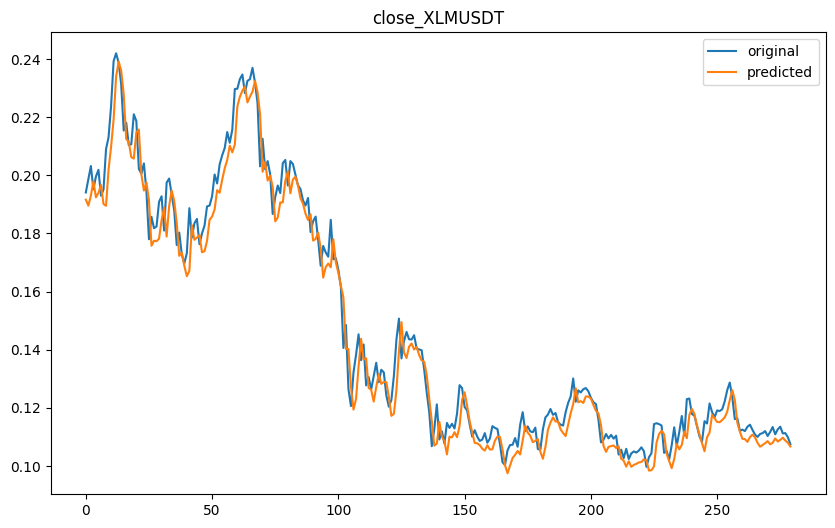

[I 2023-10-24 23:49:39,592] A new study created in RDB with name: close_ETCUSDT


Metrics for 280 days: close_XLMUSDT MSE: 4.9787521619054126e-05, RMSE: 0.007056027325560334 MAPE: 0.03805492699031716
Metrics for 90 days: close_XLMUSDT MSE: 2.4452953305600847e-05, RMSE: 0.004944992750813781 MAPE: 0.03479808735256935
Metrics for 30 days: close_XLMUSDT MSE: 1.4832752786338119e-05, RMSE: 0.0038513313005165005 MAPE: 0.02945217464494927
Metrics for 7 days: close_XLMUSDT MSE: 7.594316126610223e-06, RMSE: 0.002755778678814796 MAPE: 0.021606787563474523
11/11 [==============================] - 0s 4ms/step - loss: 3.2453 - mean_absolute_percentage_error_keras: 8.3091


[I 2023-10-24 23:50:09,772] Trial 0 finished with value: 8.309138298034668 and parameters: {'num_layers': 3, 'units_layer_0': 128, 'units_layer_1': 96, 'units_layer_2': 32, 'sequence_length': 9, 'learning_rate': 0.00024179844683489544, 'dropout_rate': 0.42904037557371233, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 0 with value: 8.309138298034668.


11/11 [==============================] - 0s 1ms/step - loss: 0.6473 - mean_absolute_percentage_error_keras: 3.0403


[I 2023-10-24 23:50:19,751] Trial 1 finished with value: 3.040344476699829 and parameters: {'num_layers': 1, 'units_layer_0': 32, 'sequence_length': 7, 'learning_rate': 0.0006640442067480948, 'dropout_rate': 0.07465971731247972, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 1 with value: 3.040344476699829.


11/11 [==============================] - 0s 3ms/step - loss: 36.7291 - mean_absolute_percentage_error_keras: 31.2830


[I 2023-10-24 23:50:42,872] Trial 2 finished with value: 31.282981872558594 and parameters: {'num_layers': 3, 'units_layer_0': 96, 'units_layer_1': 32, 'units_layer_2': 32, 'sequence_length': 8, 'learning_rate': 0.00012233788875565715, 'dropout_rate': 0.3775970646254685, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 1 with value: 3.040344476699829.


11/11 [==============================] - 0s 7ms/step - loss: 1.2954e-04 - mean_absolute_percentage_error_keras: 7.9393


[I 2023-10-24 23:51:19,014] Trial 3 finished with value: 7.9393229484558105 and parameters: {'num_layers': 2, 'units_layer_0': 192, 'units_layer_1': 224, 'sequence_length': 9, 'learning_rate': 0.00033309134622997144, 'dropout_rate': 0.27541464163651197, 'min_max_scaling': 1, 'layer_type': 'LSTM'}. Best is trial 1 with value: 3.040344476699829.


11/11 [==============================] - 0s 3ms/step - loss: 5.5945 - mean_absolute_percentage_error_keras: 11.9365


[I 2023-10-24 23:51:34,643] Trial 4 finished with value: 11.936503410339355 and parameters: {'num_layers': 1, 'units_layer_0': 160, 'sequence_length': 9, 'learning_rate': 0.0008201540658212561, 'dropout_rate': 0.2081089511214731, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 1 with value: 3.040344476699829.
[I 2023-10-24 23:51:59,622] Trial 5 pruned. 
[I 2023-10-24 23:52:21,742] Trial 6 pruned. 
[I 2023-10-24 23:52:29,390] Trial 7 pruned. 


11/11 [==============================] - 0s 3ms/step - loss: 5.4510 - mean_absolute_percentage_error_keras: 11.5802


[I 2023-10-24 23:52:50,636] Trial 8 finished with value: 11.58017635345459 and parameters: {'num_layers': 3, 'units_layer_0': 32, 'units_layer_1': 64, 'units_layer_2': 224, 'sequence_length': 3, 'learning_rate': 0.0004512266905109018, 'dropout_rate': 0.1952122171972428, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 1 with value: 3.040344476699829.


11/11 [==============================] - 0s 3ms/step - loss: 4.5099 - mean_absolute_percentage_error_keras: 10.6563


[I 2023-10-24 23:53:10,767] Trial 9 finished with value: 10.656333923339844 and parameters: {'num_layers': 4, 'units_layer_0': 128, 'units_layer_1': 192, 'units_layer_2': 256, 'units_layer_3': 96, 'sequence_length': 5, 'learning_rate': 0.00045017883163235903, 'dropout_rate': 0.1399306770954843, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 1 with value: 3.040344476699829.
2023-10-24 23:53:11.737315: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_571/simple_rnn_834/while/body/_1/sequential_571/simple_rnn_834/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-24 23:53:11.758390: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:134] tfg_optimizer{any(tfg-consolidate-attrs,tfg-toposort,tfg-shape-inference{graph-version=0},tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node sequential_571/simple_rnn_834/while/body/_1/sequential_571/simple_rnn_834/whi

11/11 [==============================] - 0s 2ms/step - loss: 5.1895e-04 - mean_absolute_percentage_error_keras: 16.6948


[I 2023-10-24 23:53:29,126] Trial 11 finished with value: 16.694835662841797 and parameters: {'num_layers': 2, 'units_layer_0': 192, 'units_layer_1': 192, 'sequence_length': 10, 'learning_rate': 0.0006261679832049237, 'dropout_rate': 0.3277703620066719, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 1 with value: 3.040344476699829.


11/11 [==============================] - 0s 7ms/step - loss: 1.5157e-04 - mean_absolute_percentage_error_keras: 9.5618


[I 2023-10-24 23:54:05,784] Trial 12 finished with value: 9.561834335327148 and parameters: {'num_layers': 2, 'units_layer_0': 224, 'units_layer_1': 256, 'sequence_length': 7, 'learning_rate': 0.0006523065637269283, 'dropout_rate': 0.0016248558758748116, 'min_max_scaling': 1, 'layer_type': 'LSTM'}. Best is trial 1 with value: 3.040344476699829.


11/11 [==============================] - 0s 3ms/step - loss: 5.1965e-05 - mean_absolute_percentage_error_keras: 4.0806


[I 2023-10-24 23:54:23,043] Trial 13 finished with value: 4.080626010894775 and parameters: {'num_layers': 1, 'units_layer_0': 192, 'sequence_length': 7, 'learning_rate': 0.00037915189450491566, 'dropout_rate': 0.3107826571723833, 'min_max_scaling': 1, 'layer_type': 'LSTM'}. Best is trial 1 with value: 3.040344476699829.


11/11 [==============================] - 0s 3ms/step - loss: 0.6608 - mean_absolute_percentage_error_keras: 3.1630


[I 2023-10-24 23:54:37,591] Trial 14 finished with value: 3.1630265712738037 and parameters: {'num_layers': 1, 'units_layer_0': 160, 'sequence_length': 7, 'learning_rate': 0.0007191199225841211, 'dropout_rate': 0.49573893495742655, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 1 with value: 3.040344476699829.


11/11 [==============================] - 0s 2ms/step - loss: 1.9714 - mean_absolute_percentage_error_keras: 6.7290


[I 2023-10-24 23:54:45,246] Trial 15 finished with value: 6.728967666625977 and parameters: {'num_layers': 1, 'units_layer_0': 96, 'sequence_length': 6, 'learning_rate': 0.0007356957674928664, 'dropout_rate': 0.4654176601333182, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 1 with value: 3.040344476699829.


11/11 [==============================] - 0s 2ms/step - loss: 1.5315 - mean_absolute_percentage_error_keras: 5.5839


[I 2023-10-24 23:54:55,805] Trial 16 finished with value: 5.583853721618652 and parameters: {'num_layers': 1, 'units_layer_0': 160, 'sequence_length': 3, 'learning_rate': 0.0008157978074080028, 'dropout_rate': 0.4992261040429735, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 1 with value: 3.040344476699829.


11/11 [==============================] - 0s 3ms/step - loss: 0.6593 - mean_absolute_percentage_error_keras: 2.9196


[I 2023-10-24 23:55:13,777] Trial 17 finished with value: 2.919628143310547 and parameters: {'num_layers': 2, 'units_layer_0': 96, 'units_layer_1': 128, 'sequence_length': 6, 'learning_rate': 0.0005396915248254833, 'dropout_rate': 0.39258212596460584, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 17 with value: 2.919628143310547.


11/11 [==============================] - 0s 2ms/step - loss: 16.2828 - mean_absolute_percentage_error_keras: 20.9834


[I 2023-10-24 23:55:24,474] Trial 18 finished with value: 20.983354568481445 and parameters: {'num_layers': 2, 'units_layer_0': 64, 'units_layer_1': 128, 'sequence_length': 4, 'learning_rate': 0.000516519154159769, 'dropout_rate': 0.387583197057181, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 17 with value: 2.919628143310547.


11/11 [==============================] - 0s 2ms/step - loss: 1.1877 - mean_absolute_percentage_error_keras: 4.7305


[I 2023-10-24 23:55:35,509] Trial 19 finished with value: 4.730457782745361 and parameters: {'num_layers': 2, 'units_layer_0': 96, 'units_layer_1': 160, 'sequence_length': 1, 'learning_rate': 0.0005258583903444098, 'dropout_rate': 0.3635155900743567, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 17 with value: 2.919628143310547.


11/11 [==============================] - 0s 3ms/step - loss: 19.0897 - mean_absolute_percentage_error_keras: 22.6001


[I 2023-10-24 23:55:51,587] Trial 20 finished with value: 22.600139617919922 and parameters: {'num_layers': 2, 'units_layer_0': 32, 'units_layer_1': 128, 'sequence_length': 6, 'learning_rate': 0.0005771445582405802, 'dropout_rate': 0.2708973601325753, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 17 with value: 2.919628143310547.


11/11 [==============================] - 0s 2ms/step - loss: 0.5601 - mean_absolute_percentage_error_keras: 2.6182


[I 2023-10-24 23:56:04,779] Trial 21 finished with value: 2.6181728839874268 and parameters: {'num_layers': 1, 'units_layer_0': 128, 'sequence_length': 8, 'learning_rate': 0.0006952609311284945, 'dropout_rate': 0.4251327456404134, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 21 with value: 2.6181728839874268.


11/11 [==============================] - 0s 2ms/step - loss: 0.7491 - mean_absolute_percentage_error_keras: 3.3064


[I 2023-10-24 23:56:17,905] Trial 22 finished with value: 3.3064277172088623 and parameters: {'num_layers': 1, 'units_layer_0': 128, 'sequence_length': 8, 'learning_rate': 0.0006705993114867008, 'dropout_rate': 0.41362265259089187, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 21 with value: 2.6181728839874268.


11/11 [==============================] - 0s 2ms/step - loss: 2.0476 - mean_absolute_percentage_error_keras: 6.9601


[I 2023-10-24 23:56:29,652] Trial 23 finished with value: 6.9601149559021 and parameters: {'num_layers': 1, 'units_layer_0': 96, 'sequence_length': 8, 'learning_rate': 0.0005873272146310984, 'dropout_rate': 0.3395558130165002, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 21 with value: 2.6181728839874268.


11/11 [==============================] - 0s 3ms/step - loss: 18.9863 - mean_absolute_percentage_error_keras: 22.5654


[I 2023-10-24 23:56:49,915] Trial 24 finished with value: 22.565378189086914 and parameters: {'num_layers': 2, 'units_layer_0': 64, 'units_layer_1': 160, 'sequence_length': 6, 'learning_rate': 0.0007750817206167067, 'dropout_rate': 0.4230896009841551, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 21 with value: 2.6181728839874268.


11/11 [==============================] - 0s 3ms/step - loss: 1.1793 - mean_absolute_percentage_error_keras: 4.3473


[I 2023-10-24 23:57:04,865] Trial 25 finished with value: 4.347281455993652 and parameters: {'num_layers': 1, 'units_layer_0': 128, 'sequence_length': 10, 'learning_rate': 0.0006796143494965777, 'dropout_rate': 0.3897084346575143, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 21 with value: 2.6181728839874268.


11/11 [==============================] - 0s 2ms/step - loss: 2.6053 - mean_absolute_percentage_error_keras: 7.4667


[I 2023-10-24 23:57:20,096] Trial 26 finished with value: 7.46665620803833 and parameters: {'num_layers': 2, 'units_layer_0': 96, 'units_layer_1': 96, 'sequence_length': 4, 'learning_rate': 0.0008341946305592889, 'dropout_rate': 0.3091564818438776, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 21 with value: 2.6181728839874268.


11/11 [==============================] - 0s 1ms/step - loss: 0.7946 - mean_absolute_percentage_error_keras: 3.0228


[I 2023-10-24 23:57:27,554] Trial 27 finished with value: 3.0228025913238525 and parameters: {'num_layers': 1, 'units_layer_0': 32, 'sequence_length': 8, 'learning_rate': 0.0005228376379094298, 'dropout_rate': 0.35300579391994197, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 21 with value: 2.6181728839874268.


11/11 [==============================] - 0s 2ms/step - loss: 1.3763 - mean_absolute_percentage_error_keras: 5.1693


[I 2023-10-24 23:57:34,940] Trial 28 finished with value: 5.169287204742432 and parameters: {'num_layers': 1, 'units_layer_0': 64, 'sequence_length': 8, 'learning_rate': 0.0005154334621609225, 'dropout_rate': 0.3535684834963228, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 21 with value: 2.6181728839874268.


11/11 [==============================] - 0s 2ms/step - loss: 3.0826 - mean_absolute_percentage_error_keras: 8.6289


[I 2023-10-24 23:57:48,178] Trial 29 finished with value: 8.628899574279785 and parameters: {'num_layers': 2, 'units_layer_0': 128, 'units_layer_1': 192, 'sequence_length': 9, 'learning_rate': 0.0004291802414237012, 'dropout_rate': 0.4096476127573709, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 21 with value: 2.6181728839874268.


11/11 [==============================] - 0s 2ms/step - loss: 1.0606 - mean_absolute_percentage_error_keras: 4.2407


[I 2023-10-24 23:57:58,294] Trial 30 finished with value: 4.240697860717773 and parameters: {'num_layers': 1, 'units_layer_0': 160, 'sequence_length': 10, 'learning_rate': 0.00032172671896237796, 'dropout_rate': 0.4447188265078054, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 21 with value: 2.6181728839874268.


11/11 [==============================] - 0s 1ms/step - loss: 0.9741 - mean_absolute_percentage_error_keras: 4.0004


[I 2023-10-24 23:58:06,049] Trial 31 finished with value: 4.000416278839111 and parameters: {'num_layers': 1, 'units_layer_0': 32, 'sequence_length': 7, 'learning_rate': 0.0005990183503736682, 'dropout_rate': 0.3643326517709358, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 21 with value: 2.6181728839874268.


11/11 [==============================] - 0s 1ms/step - loss: 0.7001 - mean_absolute_percentage_error_keras: 3.0821


[I 2023-10-24 23:58:13,427] Trial 32 finished with value: 3.0820913314819336 and parameters: {'num_layers': 1, 'units_layer_0': 32, 'sequence_length': 8, 'learning_rate': 0.0005356083297330914, 'dropout_rate': 0.39779211682895654, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 21 with value: 2.6181728839874268.


11/11 [==============================] - 0s 2ms/step - loss: 1.0918 - mean_absolute_percentage_error_keras: 4.3242


[I 2023-10-24 23:58:23,434] Trial 33 finished with value: 4.324193000793457 and parameters: {'num_layers': 1, 'units_layer_0': 64, 'sequence_length': 6, 'learning_rate': 0.0006377637369218564, 'dropout_rate': 0.4322625461213372, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 21 with value: 2.6181728839874268.


11/11 [==============================] - 0s 3ms/step - loss: 0.9009 - mean_absolute_percentage_error_keras: 3.5224


[I 2023-10-24 23:58:43,259] Trial 34 finished with value: 3.5224053859710693 and parameters: {'num_layers': 2, 'units_layer_0': 96, 'units_layer_1': 64, 'sequence_length': 9, 'learning_rate': 0.00047343633299301254, 'dropout_rate': 0.3126831198927067, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 21 with value: 2.6181728839874268.


11/11 [==============================] - 0s 2ms/step - loss: 0.5915 - mean_absolute_percentage_error_keras: 2.6925


[I 2023-10-24 23:58:53,223] Trial 35 finished with value: 2.6925394535064697 and parameters: {'num_layers': 1, 'units_layer_0': 32, 'sequence_length': 9, 'learning_rate': 0.0007108038594818235, 'dropout_rate': 0.37249829143612895, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 21 with value: 2.6181728839874268.


11/11 [==============================] - 0s 5ms/step - loss: 1.2985 - mean_absolute_percentage_error_keras: 4.2982


[I 2023-10-24 23:59:19,832] Trial 36 finished with value: 4.298182487487793 and parameters: {'num_layers': 2, 'units_layer_0': 32, 'units_layer_1': 224, 'sequence_length': 9, 'learning_rate': 0.0006981349040491578, 'dropout_rate': 0.36177783264047464, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 21 with value: 2.6181728839874268.


11/11 [==============================] - 0s 1ms/step - loss: 0.6244 - mean_absolute_percentage_error_keras: 2.6997


[I 2023-10-24 23:59:28,283] Trial 37 finished with value: 2.699676513671875 and parameters: {'num_layers': 1, 'units_layer_0': 64, 'sequence_length': 8, 'learning_rate': 0.0007460672298210648, 'dropout_rate': 0.38613992201567476, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 21 with value: 2.6181728839874268.
[I 2023-10-24 23:59:43,666] Trial 38 pruned. 


11/11 [==============================] - 0s 5ms/step - loss: 3.4690 - mean_absolute_percentage_error_keras: 8.4503


[I 2023-10-25 00:00:18,361] Trial 39 finished with value: 8.450340270996094 and parameters: {'num_layers': 4, 'units_layer_0': 128, 'units_layer_1': 64, 'units_layer_2': 96, 'units_layer_3': 32, 'sequence_length': 9, 'learning_rate': 0.0007496135578213577, 'dropout_rate': 0.39410862115338424, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 21 with value: 2.6181728839874268.


11/11 [==============================] - 0s 2ms/step - loss: 4.7028e-05 - mean_absolute_percentage_error_keras: 3.8154


[I 2023-10-25 00:00:31,963] Trial 40 finished with value: 3.81539249420166 and parameters: {'num_layers': 1, 'units_layer_0': 96, 'sequence_length': 9, 'learning_rate': 0.0008844327741017369, 'dropout_rate': 0.4269354376890993, 'min_max_scaling': 1, 'layer_type': 'LSTM'}. Best is trial 21 with value: 2.6181728839874268.


11/11 [==============================] - 0s 1ms/step - loss: 0.8897 - mean_absolute_percentage_error_keras: 3.8104


[I 2023-10-25 00:00:40,545] Trial 41 finished with value: 3.8104090690612793 and parameters: {'num_layers': 1, 'units_layer_0': 32, 'sequence_length': 8, 'learning_rate': 0.0006969128282031802, 'dropout_rate': 0.3807099476814955, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 21 with value: 2.6181728839874268.


11/11 [==============================] - 0s 1ms/step - loss: 2.0094 - mean_absolute_percentage_error_keras: 6.5868


[I 2023-10-25 00:00:48,644] Trial 42 finished with value: 6.5867743492126465 and parameters: {'num_layers': 1, 'units_layer_0': 64, 'sequence_length': 8, 'learning_rate': 0.0007726220623859016, 'dropout_rate': 0.3302701570903531, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 21 with value: 2.6181728839874268.


11/11 [==============================] - 0s 1ms/step - loss: 0.9376 - mean_absolute_percentage_error_keras: 4.1048


[I 2023-10-25 00:00:56,011] Trial 43 finished with value: 4.104781627655029 and parameters: {'num_layers': 1, 'units_layer_0': 64, 'sequence_length': 7, 'learning_rate': 0.0006308714154604023, 'dropout_rate': 0.3747898013328274, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 21 with value: 2.6181728839874268.
[I 2023-10-25 00:00:58,789] Trial 44 pruned. 


11/11 [==============================] - 0s 2ms/step - loss: 0.5497 - mean_absolute_percentage_error_keras: 2.5572


[I 2023-10-25 00:01:06,091] Trial 45 finished with value: 2.5571646690368652 and parameters: {'num_layers': 1, 'units_layer_0': 96, 'sequence_length': 7, 'learning_rate': 0.0006473261873207593, 'dropout_rate': 0.44833152825384986, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 45 with value: 2.5571646690368652.
[I 2023-10-25 00:01:11,338] Trial 46 pruned. 


11/11 [==============================] - 0s 4ms/step - loss: 1.7825 - mean_absolute_percentage_error_keras: 5.8992


[I 2023-10-25 00:01:34,309] Trial 47 finished with value: 5.899203300476074 and parameters: {'num_layers': 2, 'units_layer_0': 128, 'units_layer_1': 224, 'sequence_length': 5, 'learning_rate': 0.0007205526879325531, 'dropout_rate': 0.4421411291730201, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 45 with value: 2.5571646690368652.


11/11 [==============================] - 0s 1ms/step - loss: 2.8987e-04 - mean_absolute_percentage_error_keras: 13.5894


[I 2023-10-25 00:01:42,979] Trial 48 finished with value: 13.589365005493164 and parameters: {'num_layers': 1, 'units_layer_0': 96, 'sequence_length': 7, 'learning_rate': 0.0006067765188178981, 'dropout_rate': 0.47929380890223416, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 45 with value: 2.5571646690368652.


11/11 [==============================] - 0s 10ms/step - loss: 11.3263 - mean_absolute_percentage_error_keras: 16.7770


[I 2023-10-25 00:02:34,658] Trial 49 finished with value: 16.77703285217285 and parameters: {'num_layers': 4, 'units_layer_0': 160, 'units_layer_1': 96, 'units_layer_2': 256, 'units_layer_3': 256, 'sequence_length': 6, 'learning_rate': 0.0006478245347725496, 'dropout_rate': 0.4451290386526953, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 45 with value: 2.5571646690368652.


Best Hyperparameters: {'num_layers': 1, 'units_layer_0': 96, 'sequence_length': 7, 'learning_rate': 0.0006473261873207593, 'dropout_rate': 0.44833152825384986, 'min_max_scaling': 0, 'layer_type': 'RNN'}
Epoch 1/100
46/46 [==============================] - 1s 2ms/step - loss: 199.3861
Epoch 2/100
46/46 [==============================] - 0s 2ms/step - loss: 66.7832
Epoch 3/100
46/46 [==============================] - 0s 2ms/step - loss: 51.0357
Epoch 4/100
46/46 [==============================] - 0s 2ms/step - loss: 45.4561
Epoch 5/100
46/46 [==============================] - 0s 2ms/step - loss: 35.6185
Epoch 6/100
46/46 [==============================] - 0s 2ms/step - loss: 40.9840
Epoch 7/100
46/46 [==============================] - 0s 2ms/step - loss: 27.5937
Epoch 8/100
46/46 [==============================] - 0s 3ms/step - loss: 36.5445
Epoch 9/100
46/46 [==============================] - 0s 3ms/step - loss: 26.5934
Epoch 10/100
46/46 [==============================] - 0s 2ms/step -

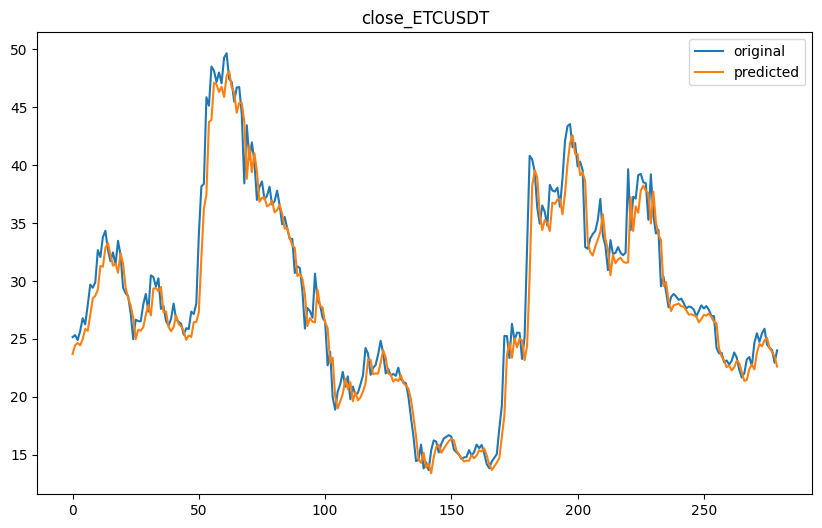

[I 2023-10-25 00:02:46,633] A new study created in RDB with name: close_LTCUSDT


Metrics for 280 days: close_ETCUSDT MSE: 3.9971497733799475, RMSE: 1.999287316365496 MAPE: 0.046689722632704087
Metrics for 90 days: close_ETCUSDT MSE: 3.2957861566744566, RMSE: 1.815430019767894 MAPE: 0.038906146259080836
Metrics for 30 days: close_ETCUSDT MSE: 0.9047582892998531, RMSE: 0.9511878307147612 MAPE: 0.030076754732357235
Metrics for 7 days: close_ETCUSDT MSE: 0.6850923381562107, RMSE: 0.8277030495027856 MAPE: 0.027689890464757394
11/11 [==============================] - 0s 2ms/step - loss: 1.2779e-04 - mean_absolute_percentage_error_keras: 5.9506


[I 2023-10-25 00:03:09,755] Trial 0 finished with value: 5.95055627822876 and parameters: {'num_layers': 3, 'units_layer_0': 64, 'units_layer_1': 64, 'units_layer_2': 32, 'sequence_length': 8, 'learning_rate': 0.0008269433697018404, 'dropout_rate': 0.09760190266338803, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 0 with value: 5.95055627822876.


11/11 [==============================] - 0s 1ms/step - loss: 13.6013 - mean_absolute_percentage_error_keras: 3.0629


[I 2023-10-25 00:03:19,384] Trial 1 finished with value: 3.062872886657715 and parameters: {'num_layers': 1, 'units_layer_0': 256, 'sequence_length': 6, 'learning_rate': 0.0002210720418646061, 'dropout_rate': 0.4408039881587929, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 1 with value: 3.062872886657715.


11/11 [==============================] - 0s 10ms/step - loss: 2.8440e-04 - mean_absolute_percentage_error_keras: 9.8689


[I 2023-10-25 00:04:19,065] Trial 2 finished with value: 9.868886947631836 and parameters: {'num_layers': 4, 'units_layer_0': 224, 'units_layer_1': 96, 'units_layer_2': 224, 'units_layer_3': 224, 'sequence_length': 8, 'learning_rate': 0.0007108813840111301, 'dropout_rate': 0.4062876569883773, 'min_max_scaling': 1, 'layer_type': 'LSTM'}. Best is trial 1 with value: 3.062872886657715.


11/11 [==============================] - 0s 2ms/step - loss: 1.3351e-04 - mean_absolute_percentage_error_keras: 5.7799


[I 2023-10-25 00:04:32,948] Trial 3 finished with value: 5.779933929443359 and parameters: {'num_layers': 1, 'units_layer_0': 128, 'sequence_length': 9, 'learning_rate': 0.000977480073416147, 'dropout_rate': 0.1377192213528336, 'min_max_scaling': 1, 'layer_type': 'LSTM'}. Best is trial 1 with value: 3.062872886657715.


11/11 [==============================] - 0s 4ms/step - loss: 119.8685 - mean_absolute_percentage_error_keras: 12.6158


[I 2023-10-25 00:04:58,323] Trial 4 finished with value: 12.615760803222656 and parameters: {'num_layers': 2, 'units_layer_0': 128, 'units_layer_1': 160, 'sequence_length': 9, 'learning_rate': 2.0554240669509434e-05, 'dropout_rate': 0.2194807693883909, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 1 with value: 3.062872886657715.
[I 2023-10-25 00:05:07,070] Trial 5 pruned. 


11/11 [==============================] - 0s 2ms/step - loss: 10.8425 - mean_absolute_percentage_error_keras: 2.7600


[I 2023-10-25 00:05:15,922] Trial 6 finished with value: 2.7599849700927734 and parameters: {'num_layers': 1, 'units_layer_0': 160, 'sequence_length': 6, 'learning_rate': 0.0008651941715314758, 'dropout_rate': 0.18526874000925753, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 6 with value: 2.7599849700927734.
2023-10-25 00:05:18.698478: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_619/simple_rnn_868/while/body/_157/sequential_619/simple_rnn_868/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-25 00:05:18.700179: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_619/simple_rnn_867/while/body/_74/sequential_619/simple_rnn_867/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-25 00:05:18.701114: W tensorflow/core/grappler/utils/graph_view.cc:849] No r

11/11 [==============================] - 0s 1ms/step - loss: 91.4213 - mean_absolute_percentage_error_keras: 10.9995


[I 2023-10-25 00:05:29,730] Trial 8 finished with value: 10.999489784240723 and parameters: {'num_layers': 2, 'units_layer_0': 128, 'units_layer_1': 192, 'sequence_length': 1, 'learning_rate': 0.0005412933940521931, 'dropout_rate': 0.3045578594968887, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 6 with value: 2.7599849700927734.


11/11 [==============================] - 0s 4ms/step - loss: 42.3263 - mean_absolute_percentage_error_keras: 7.0833


[I 2023-10-25 00:05:51,863] Trial 9 finished with value: 7.083299160003662 and parameters: {'num_layers': 4, 'units_layer_0': 160, 'units_layer_1': 64, 'units_layer_2': 256, 'units_layer_3': 160, 'sequence_length': 2, 'learning_rate': 0.0005317082738942599, 'dropout_rate': 0.02713251675907874, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 6 with value: 2.7599849700927734.


11/11 [==============================] - 0s 1ms/step - loss: 13.6060 - mean_absolute_percentage_error_keras: 3.1808


[I 2023-10-25 00:05:59,316] Trial 10 finished with value: 3.1807808876037598 and parameters: {'num_layers': 1, 'units_layer_0': 32, 'sequence_length': 4, 'learning_rate': 0.0007544155150626402, 'dropout_rate': 0.2562762076243066, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 6 with value: 2.7599849700927734.


11/11 [==============================] - 0s 1ms/step - loss: 12.9358 - mean_absolute_percentage_error_keras: 2.9995


[I 2023-10-25 00:06:09,156] Trial 11 finished with value: 2.9994566440582275 and parameters: {'num_layers': 1, 'units_layer_0': 256, 'sequence_length': 5, 'learning_rate': 0.00024293807423284258, 'dropout_rate': 0.34236982706502894, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 6 with value: 2.7599849700927734.


11/11 [==============================] - 0s 2ms/step - loss: 109.2566 - mean_absolute_percentage_error_keras: 12.1158


[I 2023-10-25 00:06:22,624] Trial 12 finished with value: 12.115753173828125 and parameters: {'num_layers': 2, 'units_layer_0': 224, 'units_layer_1': 256, 'sequence_length': 4, 'learning_rate': 0.0003224591957303682, 'dropout_rate': 0.3161493386058852, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 6 with value: 2.7599849700927734.


11/11 [==============================] - 0s 1ms/step - loss: 11.2979 - mean_absolute_percentage_error_keras: 2.7538


[I 2023-10-25 00:06:31,043] Trial 13 finished with value: 2.7537600994110107 and parameters: {'num_layers': 1, 'units_layer_0': 192, 'sequence_length': 5, 'learning_rate': 0.0002766169227115918, 'dropout_rate': 0.17653522905900712, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 13 with value: 2.7537600994110107.


11/11 [==============================] - 0s 2ms/step - loss: 75.2613 - mean_absolute_percentage_error_keras: 9.8846


[I 2023-10-25 00:06:42,450] Trial 14 finished with value: 9.88461685180664 and parameters: {'num_layers': 2, 'units_layer_0': 192, 'units_layer_1': 256, 'sequence_length': 3, 'learning_rate': 0.0006248929519887421, 'dropout_rate': 0.18103679094407954, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 13 with value: 2.7537600994110107.


11/11 [==============================] - 0s 2ms/step - loss: 27.7649 - mean_absolute_percentage_error_keras: 5.5766


[I 2023-10-25 00:06:50,605] Trial 15 finished with value: 5.576573848724365 and parameters: {'num_layers': 1, 'units_layer_0': 192, 'sequence_length': 6, 'learning_rate': 0.0008642083551989895, 'dropout_rate': 0.16066892794216692, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 13 with value: 2.7537600994110107.


11/11 [==============================] - 0s 1ms/step - loss: 18.5157 - mean_absolute_percentage_error_keras: 4.1339


[I 2023-10-25 00:06:57,434] Trial 16 finished with value: 4.1338791847229 and parameters: {'num_layers': 1, 'units_layer_0': 96, 'sequence_length': 4, 'learning_rate': 0.00037620357123359946, 'dropout_rate': 0.23444220070466226, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 13 with value: 2.7537600994110107.


11/11 [==============================] - 0s 2ms/step - loss: 11.8031 - mean_absolute_percentage_error_keras: 2.8730


[I 2023-10-25 00:07:15,355] Trial 17 finished with value: 2.872995138168335 and parameters: {'num_layers': 3, 'units_layer_0': 192, 'units_layer_1': 192, 'units_layer_2': 160, 'sequence_length': 5, 'learning_rate': 0.0006864103642888369, 'dropout_rate': 0.05953092040287988, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 13 with value: 2.7537600994110107.


11/11 [==============================] - 0s 5ms/step - loss: 24.0529 - mean_absolute_percentage_error_keras: 4.7092


[I 2023-10-25 00:07:45,014] Trial 18 finished with value: 4.7092204093933105 and parameters: {'num_layers': 2, 'units_layer_0': 224, 'units_layer_1': 32, 'sequence_length': 10, 'learning_rate': 0.0008292928260241589, 'dropout_rate': 0.00045520269107199307, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 13 with value: 2.7537600994110107.


11/11 [==============================] - 0s 1ms/step - loss: 11.9497 - mean_absolute_percentage_error_keras: 2.9836


[I 2023-10-25 00:07:52,992] Trial 19 finished with value: 2.9835681915283203 and parameters: {'num_layers': 1, 'units_layer_0': 96, 'sequence_length': 7, 'learning_rate': 0.0006260932602763513, 'dropout_rate': 0.09561991726817501, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 13 with value: 2.7537600994110107.
[I 2023-10-25 00:07:57,997] Trial 20 pruned. 


11/11 [==============================] - 0s 2ms/step - loss: 24.5940 - mean_absolute_percentage_error_keras: 5.0712


[I 2023-10-25 00:08:13,485] Trial 21 finished with value: 5.071200370788574 and parameters: {'num_layers': 3, 'units_layer_0': 192, 'units_layer_1': 160, 'units_layer_2': 160, 'sequence_length': 5, 'learning_rate': 0.0007257186205831355, 'dropout_rate': 0.1101948489163044, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 13 with value: 2.7537600994110107.


11/11 [==============================] - 0s 4ms/step - loss: 10.9416 - mean_absolute_percentage_error_keras: 2.7193


[I 2023-10-25 00:08:33,405] Trial 22 finished with value: 2.719266414642334 and parameters: {'num_layers': 3, 'units_layer_0': 192, 'units_layer_1': 224, 'units_layer_2': 160, 'sequence_length': 6, 'learning_rate': 0.0008793137591186982, 'dropout_rate': 0.05932940302618245, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 22 with value: 2.719266414642334.


11/11 [==============================] - 0s 3ms/step - loss: 10.7788 - mean_absolute_percentage_error_keras: 2.7595


[I 2023-10-25 00:08:52,473] Trial 23 finished with value: 2.7595341205596924 and parameters: {'num_layers': 3, 'units_layer_0': 160, 'units_layer_1': 224, 'units_layer_2': 192, 'sequence_length': 7, 'learning_rate': 0.0008625030345309145, 'dropout_rate': 0.1506167500329927, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 22 with value: 2.719266414642334.


11/11 [==============================] - 0s 3ms/step - loss: 56.8178 - mean_absolute_percentage_error_keras: 8.4157


[I 2023-10-25 00:09:12,338] Trial 24 finished with value: 8.41568374633789 and parameters: {'num_layers': 3, 'units_layer_0': 224, 'units_layer_1': 224, 'units_layer_2': 192, 'sequence_length': 7, 'learning_rate': 0.0009266326725427898, 'dropout_rate': 0.13154352751933307, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 22 with value: 2.719266414642334.


11/11 [==============================] - 0s 3ms/step - loss: 21.5191 - mean_absolute_percentage_error_keras: 4.7360


[I 2023-10-25 00:09:30,776] Trial 25 finished with value: 4.736042022705078 and parameters: {'num_layers': 3, 'units_layer_0': 192, 'units_layer_1': 192, 'units_layer_2': 128, 'sequence_length': 8, 'learning_rate': 0.0007831634245229016, 'dropout_rate': 0.05815831529954063, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 22 with value: 2.719266414642334.
[I 2023-10-25 00:09:40,208] Trial 26 pruned. 


11/11 [==============================] - 0s 7ms/step - loss: 98.7378 - mean_absolute_percentage_error_keras: 11.3736


[I 2023-10-25 00:10:18,174] Trial 27 finished with value: 11.373575210571289 and parameters: {'num_layers': 3, 'units_layer_0': 160, 'units_layer_1': 256, 'units_layer_2': 128, 'sequence_length': 6, 'learning_rate': 0.0008168872985473407, 'dropout_rate': 0.07454853013894405, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 22 with value: 2.719266414642334.


11/11 [==============================] - 0s 3ms/step - loss: 12.5518 - mean_absolute_percentage_error_keras: 3.1072


[I 2023-10-25 00:10:34,458] Trial 28 finished with value: 3.107175588607788 and parameters: {'num_layers': 3, 'units_layer_0': 224, 'units_layer_1': 128, 'units_layer_2': 224, 'sequence_length': 5, 'learning_rate': 0.0009186481257395703, 'dropout_rate': 0.13483215871383356, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 22 with value: 2.719266414642334.
[I 2023-10-25 00:10:44,466] Trial 29 pruned. 


11/11 [==============================] - 0s 1ms/step - loss: 10.6274 - mean_absolute_percentage_error_keras: 2.6601


[I 2023-10-25 00:10:56,165] Trial 30 finished with value: 2.66011118888855 and parameters: {'num_layers': 2, 'units_layer_0': 64, 'units_layer_1': 160, 'sequence_length': 3, 'learning_rate': 0.0008437646505412736, 'dropout_rate': 0.025032561534710313, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 30 with value: 2.66011118888855.


11/11 [==============================] - 0s 1ms/step - loss: 32.7654 - mean_absolute_percentage_error_keras: 6.0491


[I 2023-10-25 00:11:06,464] Trial 31 finished with value: 6.049070835113525 and parameters: {'num_layers': 2, 'units_layer_0': 32, 'units_layer_1': 160, 'sequence_length': 3, 'learning_rate': 0.000885288540963969, 'dropout_rate': 0.036888273065410204, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 30 with value: 2.66011118888855.
2023-10-25 00:11:08.323766: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_644/simple_rnn_918/while/body/_74/sequential_644/simple_rnn_918/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-25 00:11:08.325612: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_644/simple_rnn_917/while/body/_1/sequential_644/simple_rnn_917/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-25 00:11:08.326656: W tensorflow/core/grappler/utils/graph

11/11 [==============================] - 0s 2ms/step - loss: 29.9704 - mean_absolute_percentage_error_keras: 5.8440


[I 2023-10-25 00:11:19,048] Trial 32 finished with value: 5.8440446853637695 and parameters: {'num_layers': 3, 'units_layer_0': 64, 'units_layer_1': 192, 'units_layer_2': 256, 'sequence_length': 2, 'learning_rate': 0.000994024620944576, 'dropout_rate': 0.00352276919419095, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 30 with value: 2.66011118888855.


11/11 [==============================] - 0s 2ms/step - loss: 28.2319 - mean_absolute_percentage_error_keras: 5.5300


[I 2023-10-25 00:11:29,959] Trial 33 finished with value: 5.529959678649902 and parameters: {'num_layers': 2, 'units_layer_0': 64, 'units_layer_1': 128, 'sequence_length': 6, 'learning_rate': 0.000836271347932175, 'dropout_rate': 0.0728599806004173, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 30 with value: 2.66011118888855.


11/11 [==============================] - 0s 3ms/step - loss: 10.9941 - mean_absolute_percentage_error_keras: 2.8028


[I 2023-10-25 00:11:50,229] Trial 34 finished with value: 2.8027892112731934 and parameters: {'num_layers': 3, 'units_layer_0': 256, 'units_layer_1': 224, 'units_layer_2': 128, 'sequence_length': 8, 'learning_rate': 0.0007583789584333363, 'dropout_rate': 0.11312241646163329, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 30 with value: 2.66011118888855.


11/11 [==============================] - 0s 3ms/step - loss: 14.1469 - mean_absolute_percentage_error_keras: 3.3937


[I 2023-10-25 00:12:11,190] Trial 35 finished with value: 3.3937323093414307 and parameters: {'num_layers': 2, 'units_layer_0': 128, 'units_layer_1': 192, 'sequence_length': 4, 'learning_rate': 0.0006858034640146342, 'dropout_rate': 0.04248577520631559, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 30 with value: 2.66011118888855.
[I 2023-10-25 00:12:18,138] Trial 36 pruned. 


11/11 [==============================] - 0s 3ms/step - loss: 13.2416 - mean_absolute_percentage_error_keras: 3.2410


[I 2023-10-25 00:12:36,965] Trial 37 finished with value: 3.2410097122192383 and parameters: {'num_layers': 3, 'units_layer_0': 128, 'units_layer_1': 160, 'units_layer_2': 224, 'sequence_length': 2, 'learning_rate': 0.0008803275132302425, 'dropout_rate': 0.0862310249680553, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 30 with value: 2.66011118888855.
[I 2023-10-25 00:12:45,210] Trial 38 pruned. 
[I 2023-10-25 00:12:51,701] Trial 39 pruned. 


11/11 [==============================] - 0s 1ms/step - loss: 14.5197 - mean_absolute_percentage_error_keras: 3.5474


[I 2023-10-25 00:13:01,140] Trial 40 finished with value: 3.5473692417144775 and parameters: {'num_layers': 1, 'units_layer_0': 224, 'sequence_length': 5, 'learning_rate': 0.0007741339228694531, 'dropout_rate': 0.031051928141094726, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 30 with value: 2.66011118888855.


11/11 [==============================] - 0s 1ms/step - loss: 14.3502 - mean_absolute_percentage_error_keras: 3.4791


[I 2023-10-25 00:13:09,864] Trial 41 finished with value: 3.4790561199188232 and parameters: {'num_layers': 1, 'units_layer_0': 160, 'sequence_length': 7, 'learning_rate': 0.0008388021798145503, 'dropout_rate': 0.17917780689527465, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 30 with value: 2.66011118888855.


11/11 [==============================] - 0s 2ms/step - loss: 11.7407 - mean_absolute_percentage_error_keras: 2.9494


[I 2023-10-25 00:13:17,764] Trial 42 finished with value: 2.949429512023926 and parameters: {'num_layers': 1, 'units_layer_0': 160, 'sequence_length': 6, 'learning_rate': 0.0008736927178908255, 'dropout_rate': 0.1533543359181441, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 30 with value: 2.66011118888855.


11/11 [==============================] - 0s 1ms/step - loss: 30.1889 - mean_absolute_percentage_error_keras: 5.7786


[I 2023-10-25 00:13:25,820] Trial 43 finished with value: 5.778632640838623 and parameters: {'num_layers': 1, 'units_layer_0': 128, 'sequence_length': 8, 'learning_rate': 0.0009546741221151934, 'dropout_rate': 0.12437826512194185, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 30 with value: 2.66011118888855.


11/11 [==============================] - 0s 1ms/step - loss: 11.2305 - mean_absolute_percentage_error_keras: 2.8201


[I 2023-10-25 00:13:33,332] Trial 44 finished with value: 2.8200843334198 and parameters: {'num_layers': 1, 'units_layer_0': 160, 'sequence_length': 4, 'learning_rate': 0.0009942656620297457, 'dropout_rate': 0.2433573881361369, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 30 with value: 2.66011118888855.


11/11 [==============================] - 0s 5ms/step - loss: 15.9335 - mean_absolute_percentage_error_keras: 3.5807


[I 2023-10-25 00:13:59,049] Trial 45 finished with value: 3.580653667449951 and parameters: {'num_layers': 2, 'units_layer_0': 192, 'units_layer_1': 192, 'sequence_length': 6, 'learning_rate': 0.0007287572164376609, 'dropout_rate': 0.09296185010380022, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 30 with value: 2.66011118888855.


11/11 [==============================] - 0s 2ms/step - loss: 11.0982 - mean_absolute_percentage_error_keras: 2.7794


[I 2023-10-25 00:14:06,290] Trial 46 finished with value: 2.779388904571533 and parameters: {'num_layers': 1, 'units_layer_0': 128, 'sequence_length': 5, 'learning_rate': 0.000796648679302386, 'dropout_rate': 0.20865262499483142, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 30 with value: 2.66011118888855.


11/11 [==============================] - 0s 2ms/step - loss: 192.0938 - mean_absolute_percentage_error_keras: 16.3535


[I 2023-10-25 00:14:21,588] Trial 47 finished with value: 16.35346031188965 and parameters: {'num_layers': 3, 'units_layer_0': 160, 'units_layer_1': 160, 'units_layer_2': 96, 'sequence_length': 3, 'learning_rate': 0.0009058765845988268, 'dropout_rate': 0.17623943122470898, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 30 with value: 2.66011118888855.
2023-10-25 00:14:22.644158: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_660/simple_rnn_943/while/body/_1/sequential_660/simple_rnn_943/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-25 00:14:22.679245: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:134] tfg_optimizer{any(tfg-consolidate-attrs,tfg-toposort,tfg-shape-inference{graph-version=0},tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node sequential_660/simple_rnn_943/while/body/_1/sequential_660/simple_rnn_943/while/simple_rnn_cell/Rel

11/11 [==============================] - 0s 1ms/step - loss: 10.1906 - mean_absolute_percentage_error_keras: 2.6417


[I 2023-10-25 00:14:28,058] Trial 48 finished with value: 2.6416738033294678 and parameters: {'num_layers': 1, 'units_layer_0': 192, 'sequence_length': 1, 'learning_rate': 0.0008525053364675858, 'dropout_rate': 0.14362903176136227, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 48 with value: 2.6416738033294678.
2023-10-25 00:14:29.320649: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_661/simple_rnn_944/while/body/_1/sequential_661/simple_rnn_944/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-25 00:14:29.322689: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_661/simple_rnn_945/while/body/_74/sequential_661/simple_rnn_945/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-25 00:14:29.363299: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook

11/11 [==============================] - 0s 1ms/step - loss: 23.4118 - mean_absolute_percentage_error_keras: 4.9655


[I 2023-10-25 00:14:36,405] Trial 49 finished with value: 4.965479850769043 and parameters: {'num_layers': 2, 'units_layer_0': 224, 'units_layer_1': 64, 'sequence_length': 1, 'learning_rate': 0.0008456008918107456, 'dropout_rate': 0.1490190880723958, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 48 with value: 2.6416738033294678.


Best Hyperparameters: {'num_layers': 1, 'units_layer_0': 192, 'sequence_length': 1, 'learning_rate': 0.0008525053364675858, 'dropout_rate': 0.14362903176136227, 'min_max_scaling': 0, 'layer_type': 'RNN'}
Epoch 1/100
46/46 [==============================] - 1s 2ms/step - loss: 2225.0674
Epoch 2/100
46/46 [==============================] - 0s 2ms/step - loss: 130.6971
Epoch 3/100
46/46 [==============================] - 0s 2ms/step - loss: 106.5748
Epoch 4/100
46/46 [==============================] - 0s 2ms/step - loss: 107.0039
Epoch 5/100
46/46 [==============================] - 0s 2ms/step - loss: 108.0811
Epoch 6/100
46/46 [==============================] - 0s 2ms/step - loss: 107.5163
Epoch 7/100
46/46 [==============================] - 0s 2ms/step - loss: 108.0872
Epoch 8/100
46/46 [==============================] - 0s 2ms/step - loss: 95.4180
Epoch 9/100
46/46 [==============================] - 0s 1ms/step - loss: 93.2954
Epoch 10/100
46/46 [==============================] - 0s 2m

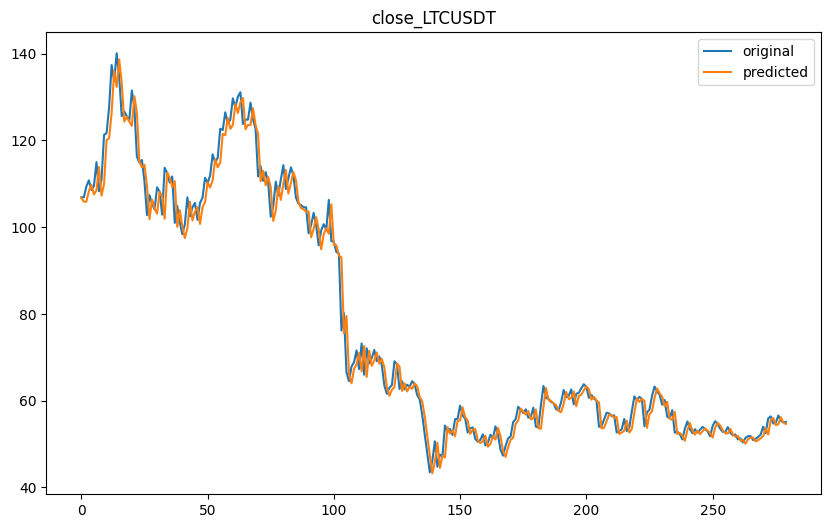

[I 2023-10-25 00:14:46,131] A new study created in RDB with name: close_QTUMUSDT


Metrics for 280 days: close_LTCUSDT MSE: 13.042404340025955, RMSE: 3.6114269119042066 MAPE: 0.03335339496716383
Metrics for 90 days: close_LTCUSDT MSE: 3.6551764416765957, RMSE: 1.911851574175306 MAPE: 0.025321839828696655
Metrics for 30 days: close_LTCUSDT MSE: 1.5596483769962939, RMSE: 1.2488588298908303 MAPE: 0.018086333821202397
Metrics for 7 days: close_LTCUSDT MSE: 1.1034610723604525, RMSE: 1.0504575538118865 MAPE: 0.015475585439693058
11/11 [==============================] - 0s 3ms/step - loss: 7.0996e-05 - mean_absolute_percentage_error_keras: 13.8318


[I 2023-10-25 00:15:08,044] Trial 0 finished with value: 13.831841468811035 and parameters: {'num_layers': 4, 'units_layer_0': 224, 'units_layer_1': 256, 'units_layer_2': 192, 'units_layer_3': 64, 'sequence_length': 6, 'learning_rate': 0.000720660006612707, 'dropout_rate': 0.40574888085143607, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 0 with value: 13.831841468811035.


11/11 [==============================] - 0s 6ms/step - loss: 4.5581e-05 - mean_absolute_percentage_error_keras: 8.9683


[I 2023-10-25 00:15:39,409] Trial 1 finished with value: 8.968282699584961 and parameters: {'num_layers': 2, 'units_layer_0': 224, 'units_layer_1': 128, 'sequence_length': 8, 'learning_rate': 0.00043290284767824236, 'dropout_rate': 0.1736649033089277, 'min_max_scaling': 1, 'layer_type': 'LSTM'}. Best is trial 1 with value: 8.968282699584961.


11/11 [==============================] - 0s 2ms/step - loss: 0.0401 - mean_absolute_percentage_error_keras: 5.7339


[I 2023-10-25 00:15:55,063] Trial 2 finished with value: 5.733920097351074 and parameters: {'num_layers': 2, 'units_layer_0': 32, 'units_layer_1': 64, 'sequence_length': 7, 'learning_rate': 0.000399239933826214, 'dropout_rate': 0.40116522683531697, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 2 with value: 5.733920097351074.


11/11 [==============================] - 0s 4ms/step - loss: 0.0179 - mean_absolute_percentage_error_keras: 3.5649


[I 2023-10-25 00:16:17,661] Trial 3 finished with value: 3.5649261474609375 and parameters: {'num_layers': 2, 'units_layer_0': 128, 'units_layer_1': 224, 'sequence_length': 5, 'learning_rate': 0.0009635369131207783, 'dropout_rate': 0.09609887901872904, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 3 with value: 3.5649261474609375.


11/11 [==============================] - 0s 13ms/step - loss: 0.0500 - mean_absolute_percentage_error_keras: 6.2534


[I 2023-10-25 00:17:32,888] Trial 4 finished with value: 6.253428936004639 and parameters: {'num_layers': 4, 'units_layer_0': 256, 'units_layer_1': 160, 'units_layer_2': 224, 'units_layer_3': 192, 'sequence_length': 10, 'learning_rate': 0.00011192847778353367, 'dropout_rate': 0.3887543321173056, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 3 with value: 3.5649261474609375.


11/11 [==============================] - 0s 1ms/step - loss: 1.8600e-05 - mean_absolute_percentage_error_keras: 5.0699


[I 2023-10-25 00:17:42,230] Trial 5 finished with value: 5.069902420043945 and parameters: {'num_layers': 1, 'units_layer_0': 96, 'sequence_length': 10, 'learning_rate': 0.00031492425328022054, 'dropout_rate': 0.043333701690148885, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 3 with value: 3.5649261474609375.
2023-10-25 00:17:43.870377: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_669/simple_rnn_952/while/body/_1/sequential_669/simple_rnn_952/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-25 00:17:43.872703: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_669/simple_rnn_953/while/body/_74/sequential_669/simple_rnn_953/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-25 00:17:43.935627: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.

11/11 [==============================] - 0s 1ms/step - loss: 0.0112 - mean_absolute_percentage_error_keras: 2.6950


[I 2023-10-25 00:17:51,600] Trial 6 finished with value: 2.695005178451538 and parameters: {'num_layers': 2, 'units_layer_0': 224, 'units_layer_1': 160, 'sequence_length': 1, 'learning_rate': 0.0004193773698300019, 'dropout_rate': 0.21781901495865658, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 6 with value: 2.695005178451538.


11/11 [==============================] - 0s 3ms/step - loss: 0.0121 - mean_absolute_percentage_error_keras: 2.8620


[I 2023-10-25 00:18:09,077] Trial 7 finished with value: 2.8619649410247803 and parameters: {'num_layers': 2, 'units_layer_0': 256, 'units_layer_1': 192, 'sequence_length': 10, 'learning_rate': 0.0008483423182038503, 'dropout_rate': 0.18193221270287974, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 6 with value: 2.695005178451538.
[I 2023-10-25 00:18:15,195] Trial 8 pruned. 


11/11 [==============================] - 0s 5ms/step - loss: 0.0273 - mean_absolute_percentage_error_keras: 4.7925


[I 2023-10-25 00:18:40,130] Trial 9 finished with value: 4.792452335357666 and parameters: {'num_layers': 2, 'units_layer_0': 192, 'units_layer_1': 96, 'sequence_length': 8, 'learning_rate': 0.0008884329561233595, 'dropout_rate': 0.43249353776537725, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 6 with value: 2.695005178451538.
2023-10-25 00:18:42.091473: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_673/simple_rnn_957/while/body/_74/sequential_673/simple_rnn_957/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-25 00:18:42.093205: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_673/simple_rnn_956/while/body/_1/sequential_673/simple_rnn_956/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-25 00:18:42.093977: W tensorflow/core/grappler/utils/graph

11/11 [==============================] - 0s 1ms/step - loss: 0.0453 - mean_absolute_percentage_error_keras: 7.1417


[I 2023-10-25 00:18:50,349] Trial 10 finished with value: 7.141737937927246 and parameters: {'num_layers': 3, 'units_layer_0': 160, 'units_layer_1': 32, 'units_layer_2': 32, 'sequence_length': 1, 'learning_rate': 0.00017658264788943592, 'dropout_rate': 0.2784529861609491, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 6 with value: 2.695005178451538.
2023-10-25 00:18:52.733573: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_674/simple_rnn_960/while/body/_74/sequential_674/simple_rnn_960/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-25 00:18:52.735667: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_674/simple_rnn_959/while/body/_1/sequential_674/simple_rnn_959/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-25 00:18:52.737096: W tensorflow/core

11/11 [==============================] - 0s 1ms/step - loss: 0.0128 - mean_absolute_percentage_error_keras: 3.1300


[I 2023-10-25 00:19:01,200] Trial 11 finished with value: 3.1300230026245117 and parameters: {'num_layers': 3, 'units_layer_0': 192, 'units_layer_1': 192, 'units_layer_2': 64, 'sequence_length': 1, 'learning_rate': 0.0006061297609261225, 'dropout_rate': 0.1873747490717206, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 6 with value: 2.695005178451538.


11/11 [==============================] - 0s 1ms/step - loss: 0.0113 - mean_absolute_percentage_error_keras: 2.7002


[I 2023-10-25 00:19:09,479] Trial 12 finished with value: 2.7001757621765137 and parameters: {'num_layers': 1, 'units_layer_0': 256, 'sequence_length': 3, 'learning_rate': 0.0007653894126537499, 'dropout_rate': 0.18259176759864126, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 6 with value: 2.695005178451538.


11/11 [==============================] - 0s 1ms/step - loss: 0.0113 - mean_absolute_percentage_error_keras: 2.7004


[I 2023-10-25 00:19:16,872] Trial 13 finished with value: 2.7004377841949463 and parameters: {'num_layers': 1, 'units_layer_0': 192, 'sequence_length': 3, 'learning_rate': 0.0007274927852847414, 'dropout_rate': 0.005069839483142602, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 6 with value: 2.695005178451538.


11/11 [==============================] - 0s 1ms/step - loss: 0.0122 - mean_absolute_percentage_error_keras: 2.9008


[I 2023-10-25 00:19:24,144] Trial 14 finished with value: 2.900817632675171 and parameters: {'num_layers': 1, 'units_layer_0': 224, 'sequence_length': 3, 'learning_rate': 0.0005589306327112806, 'dropout_rate': 0.22533832270018161, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 6 with value: 2.695005178451538.


11/11 [==============================] - 0s 2ms/step - loss: 0.0793 - mean_absolute_percentage_error_keras: 10.1125


[I 2023-10-25 00:19:36,431] Trial 15 finished with value: 10.112478256225586 and parameters: {'num_layers': 3, 'units_layer_0': 96, 'units_layer_1': 128, 'units_layer_2': 128, 'sequence_length': 3, 'learning_rate': 0.0002773728772411968, 'dropout_rate': 0.123429769893445, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 6 with value: 2.695005178451538.
2023-10-25 00:19:37.412091: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_679/simple_rnn_968/while/body/_1/sequential_679/simple_rnn_968/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-25 00:19:37.431500: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:134] tfg_optimizer{any(tfg-consolidate-attrs,tfg-toposort,tfg-shape-inference{graph-version=0},tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node sequential_679/simple_rnn_968/while/body/_1/sequential_679/simple_rnn_968/while/simple_rnn_cell/Relu

11/11 [==============================] - 0s 1ms/step - loss: 0.0157 - mean_absolute_percentage_error_keras: 3.5467


[I 2023-10-25 00:19:43,163] Trial 16 finished with value: 3.5467429161071777 and parameters: {'num_layers': 1, 'units_layer_0': 160, 'sequence_length': 2, 'learning_rate': 0.0004625087294364247, 'dropout_rate': 0.4997044063153727, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 6 with value: 2.695005178451538.
[I 2023-10-25 00:19:46,569] Trial 17 pruned. 
2023-10-25 00:19:48.120172: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_681/simple_rnn_970/while/body/_1/sequential_681/simple_rnn_970/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-25 00:19:48.122379: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_681/simple_rnn_971/while/body/_74/sequential_681/simple_rnn_971/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-25 00:19:48.202717: E tensorflow/

11/11 [==============================] - 0s 2ms/step - loss: 0.0131 - mean_absolute_percentage_error_keras: 2.9935


[I 2023-10-25 00:19:58,022] Trial 18 finished with value: 2.9934890270233154 and parameters: {'num_layers': 2, 'units_layer_0': 224, 'units_layer_1': 256, 'sequence_length': 2, 'learning_rate': 0.0006925285023857522, 'dropout_rate': 0.3177003540658008, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 6 with value: 2.695005178451538.
[I 2023-10-25 00:20:03,701] Trial 19 pruned. 
2023-10-25 00:20:04.729423: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_683/simple_rnn_975/while/body/_1/sequential_683/simple_rnn_975/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-25 00:20:04.750961: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:134] tfg_optimizer{any(tfg-consolidate-attrs,tfg-toposort,tfg-shape-inference{graph-version=0},tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node sequential_683/simple_rnn_975/while/body/_1/sequential_683/simple_rnn_975/

11/11 [==============================] - 0s 1ms/step - loss: 0.0112 - mean_absolute_percentage_error_keras: 2.7027


[I 2023-10-25 00:20:12,998] Trial 21 finished with value: 2.702706813812256 and parameters: {'num_layers': 1, 'units_layer_0': 192, 'sequence_length': 3, 'learning_rate': 0.0007463097882260553, 'dropout_rate': 0.005511175167146146, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 6 with value: 2.695005178451538.
2023-10-25 00:20:14.029389: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_685/simple_rnn_977/while/body/_1/sequential_685/simple_rnn_977/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-25 00:20:14.049491: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:134] tfg_optimizer{any(tfg-consolidate-attrs,tfg-toposort,tfg-shape-inference{graph-version=0},tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node sequential_685/simple_rnn_977/while/body/_1/sequential_685/simple_rnn_977/while/simple_rnn_cell/Relu has an empty op name
	when importing Gra

11/11 [==============================] - 0s 1ms/step - loss: 0.0180 - mean_absolute_percentage_error_keras: 3.9570


[I 2023-10-25 00:20:19,804] Trial 22 finished with value: 3.956967830657959 and parameters: {'num_layers': 1, 'units_layer_0': 192, 'sequence_length': 2, 'learning_rate': 0.0008044270144870917, 'dropout_rate': 0.0700348185917979, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 6 with value: 2.695005178451538.


11/11 [==============================] - 0s 2ms/step - loss: 0.0120 - mean_absolute_percentage_error_keras: 2.8532


[I 2023-10-25 00:20:30,866] Trial 23 finished with value: 2.8531711101531982 and parameters: {'num_layers': 2, 'units_layer_0': 224, 'units_layer_1': 96, 'sequence_length': 4, 'learning_rate': 0.0006509780592650587, 'dropout_rate': 0.031244713416104804, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 6 with value: 2.695005178451538.
2023-10-25 00:20:31.851442: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_687/simple_rnn_980/while/body/_1/sequential_687/simple_rnn_980/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-25 00:20:31.870953: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:134] tfg_optimizer{any(tfg-consolidate-attrs,tfg-toposort,tfg-shape-inference{graph-version=0},tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node sequential_687/simple_rnn_980/while/body/_1/sequential_687/simple_rnn_980/while/simple_rnn_cell/Relu has an empty op na

11/11 [==============================] - 0s 1ms/step - loss: 0.0735 - mean_absolute_percentage_error_keras: 10.0160


[I 2023-10-25 00:20:38,276] Trial 24 finished with value: 10.016048431396484 and parameters: {'num_layers': 1, 'units_layer_0': 160, 'sequence_length': 2, 'learning_rate': 0.0007599915494086463, 'dropout_rate': 0.074025305752346, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 6 with value: 2.695005178451538.


11/11 [==============================] - 0s 2ms/step - loss: 0.0156 - mean_absolute_percentage_error_keras: 3.6483


[I 2023-10-25 00:20:52,489] Trial 25 finished with value: 3.648326873779297 and parameters: {'num_layers': 2, 'units_layer_0': 256, 'units_layer_1': 192, 'sequence_length': 5, 'learning_rate': 0.0006413728616328916, 'dropout_rate': 0.13503671146713653, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 6 with value: 2.695005178451538.


11/11 [==============================] - 0s 1ms/step - loss: 0.0216 - mean_absolute_percentage_error_keras: 4.7042


[I 2023-10-25 00:20:59,778] Trial 26 finished with value: 4.70419979095459 and parameters: {'num_layers': 1, 'units_layer_0': 192, 'sequence_length': 3, 'learning_rate': 0.0005283083575102677, 'dropout_rate': 0.0037436274516075563, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 6 with value: 2.695005178451538.
2023-10-25 00:21:00.803034: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_690/simple_rnn_984/while/body/_1/sequential_690/simple_rnn_984/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-25 00:21:00.834677: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:134] tfg_optimizer{any(tfg-consolidate-attrs,tfg-toposort,tfg-shape-inference{graph-version=0},tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node sequential_690/simple_rnn_984/while/body/_1/sequential_690/simple_rnn_984/while/simple_rnn_cell/Relu has an empty op name
	when importing Gra

11/11 [==============================] - 0s 1ms/step - loss: 0.0161 - mean_absolute_percentage_error_keras: 3.6940


[I 2023-10-25 00:21:06,384] Trial 27 finished with value: 3.6939570903778076 and parameters: {'num_layers': 1, 'units_layer_0': 224, 'sequence_length': 1, 'learning_rate': 0.0009941603732920188, 'dropout_rate': 0.09402335003910331, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 6 with value: 2.695005178451538.


11/11 [==============================] - 0s 2ms/step - loss: 0.0325 - mean_absolute_percentage_error_keras: 5.9411


[I 2023-10-25 00:21:17,992] Trial 28 finished with value: 5.941074371337891 and parameters: {'num_layers': 2, 'units_layer_0': 256, 'units_layer_1': 32, 'sequence_length': 4, 'learning_rate': 0.0006839429849749689, 'dropout_rate': 0.2190632475227494, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 6 with value: 2.695005178451538.
2023-10-25 00:21:20.199187: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_692/simple_rnn_989/while/body/_157/sequential_692/simple_rnn_989/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-25 00:21:20.200738: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_692/simple_rnn_988/while/body/_74/sequential_692/simple_rnn_988/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-25 00:21:20.201636: W tensorflow/core/grappler/utils/grap

11/11 [==============================] - 0s 3ms/step - loss: 0.0113 - mean_absolute_percentage_error_keras: 2.6990


[I 2023-10-25 00:21:43,352] Trial 30 finished with value: 2.698982000350952 and parameters: {'num_layers': 3, 'units_layer_0': 192, 'units_layer_1': 224, 'units_layer_2': 96, 'sequence_length': 5, 'learning_rate': 0.0004942733447105142, 'dropout_rate': 0.2056679274037439, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 6 with value: 2.695005178451538.


11/11 [==============================] - 0s 2ms/step - loss: 0.0355 - mean_absolute_percentage_error_keras: 6.1772


[I 2023-10-25 00:22:00,395] Trial 31 finished with value: 6.177219390869141 and parameters: {'num_layers': 3, 'units_layer_0': 192, 'units_layer_1': 224, 'units_layer_2': 96, 'sequence_length': 5, 'learning_rate': 0.0004801266344438441, 'dropout_rate': 0.21624096080711666, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 6 with value: 2.695005178451538.


11/11 [==============================] - 0s 3ms/step - loss: 0.0429 - mean_absolute_percentage_error_keras: 7.2771


[I 2023-10-25 00:22:21,913] Trial 32 finished with value: 7.277109146118164 and parameters: {'num_layers': 4, 'units_layer_0': 224, 'units_layer_1': 224, 'units_layer_2': 160, 'units_layer_3': 32, 'sequence_length': 6, 'learning_rate': 0.0005760452008938843, 'dropout_rate': 0.17126020042179468, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 6 with value: 2.695005178451538.


11/11 [==============================] - 0s 2ms/step - loss: 0.0189 - mean_absolute_percentage_error_keras: 4.0931


[I 2023-10-25 00:22:37,781] Trial 33 finished with value: 4.093103408813477 and parameters: {'num_layers': 3, 'units_layer_0': 160, 'units_layer_1': 160, 'units_layer_2': 32, 'sequence_length': 7, 'learning_rate': 0.00041293369440158613, 'dropout_rate': 0.1980972305598379, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 6 with value: 2.695005178451538.


11/11 [==============================] - 0s 3ms/step - loss: 0.0834 - mean_absolute_percentage_error_keras: 10.6793


[I 2023-10-25 00:22:59,902] Trial 34 finished with value: 10.679301261901855 and parameters: {'num_layers': 2, 'units_layer_0': 224, 'units_layer_1': 192, 'sequence_length': 3, 'learning_rate': 0.0004961073931150394, 'dropout_rate': 0.25244576043680433, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 6 with value: 2.695005178451538.
[I 2023-10-25 00:23:11,475] Trial 35 pruned. 


11/11 [==============================] - 0s 2ms/step - loss: 0.0128 - mean_absolute_percentage_error_keras: 3.0050


[I 2023-10-25 00:23:24,508] Trial 36 finished with value: 3.0049543380737305 and parameters: {'num_layers': 2, 'units_layer_0': 192, 'units_layer_1': 224, 'sequence_length': 5, 'learning_rate': 0.00040877869334472267, 'dropout_rate': 0.10403470972054973, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 6 with value: 2.695005178451538.
[I 2023-10-25 00:23:32,214] Trial 37 pruned. 


11/11 [==============================] - 0s 3ms/step - loss: 0.0276 - mean_absolute_percentage_error_keras: 4.8387


[I 2023-10-25 00:23:55,938] Trial 38 finished with value: 4.838712215423584 and parameters: {'num_layers': 2, 'units_layer_0': 224, 'units_layer_1': 160, 'sequence_length': 4, 'learning_rate': 0.0005371690425612828, 'dropout_rate': 0.2000782991978006, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 6 with value: 2.695005178451538.


11/11 [==============================] - 0s 2ms/step - loss: 0.0159 - mean_absolute_percentage_error_keras: 3.6727


[I 2023-10-25 00:24:04,736] Trial 39 finished with value: 3.6727278232574463 and parameters: {'num_layers': 1, 'units_layer_0': 160, 'sequence_length': 7, 'learning_rate': 0.0008025349480032716, 'dropout_rate': 0.12077559485993408, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 6 with value: 2.695005178451538.
[I 2023-10-25 00:24:15,812] Trial 40 pruned. 


11/11 [==============================] - 0s 1ms/step - loss: 0.0232 - mean_absolute_percentage_error_keras: 4.9525


[I 2023-10-25 00:24:23,304] Trial 41 finished with value: 4.952517986297607 and parameters: {'num_layers': 1, 'units_layer_0': 192, 'sequence_length': 3, 'learning_rate': 0.000747851515275094, 'dropout_rate': 0.021085901184358657, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 6 with value: 2.695005178451538.


11/11 [==============================] - 0s 1ms/step - loss: 0.0309 - mean_absolute_percentage_error_keras: 5.9966


[I 2023-10-25 00:24:30,459] Trial 42 finished with value: 5.996591567993164 and parameters: {'num_layers': 1, 'units_layer_0': 192, 'sequence_length': 3, 'learning_rate': 0.000702953153526366, 'dropout_rate': 0.05276161129347755, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 6 with value: 2.695005178451538.
2023-10-25 00:24:31.278889: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_706/simple_rnn_1013/while/body/_1/sequential_706/simple_rnn_1013/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-25 00:24:31.295833: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:134] tfg_optimizer{any(tfg-consolidate-attrs,tfg-toposort,tfg-shape-inference{graph-version=0},tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node sequential_706/simple_rnn_1013/while/body/_1/sequential_706/simple_rnn_1013/while/simple_rnn_cell/Relu has an empty op name
	when importing G

11/11 [==============================] - 0s 1ms/step - loss: 0.0204 - mean_absolute_percentage_error_keras: 4.4045


[I 2023-10-25 00:24:37,710] Trial 43 finished with value: 4.404459476470947 and parameters: {'num_layers': 1, 'units_layer_0': 256, 'sequence_length': 2, 'learning_rate': 0.0007971909008175276, 'dropout_rate': 0.016008376451873745, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 6 with value: 2.695005178451538.
2023-10-25 00:24:38.605065: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_707/simple_rnn_1014/while/body/_1/sequential_707/simple_rnn_1014/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-25 00:24:38.621690: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:134] tfg_optimizer{any(tfg-consolidate-attrs,tfg-toposort,tfg-shape-inference{graph-version=0},tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node sequential_707/simple_rnn_1014/while/body/_1/sequential_707/simple_rnn_1014/while/simple_rnn_cell/Relu has an empty op name
	when importing

11/11 [==============================] - 0s 1ms/step - loss: 0.0140 - mean_absolute_percentage_error_keras: 3.3133


[I 2023-10-25 00:24:44,573] Trial 44 finished with value: 3.3132598400115967 and parameters: {'num_layers': 1, 'units_layer_0': 224, 'sequence_length': 1, 'learning_rate': 0.0008647761364476888, 'dropout_rate': 0.05419795140423578, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 6 with value: 2.695005178451538.


11/11 [==============================] - 0s 1ms/step - loss: 0.0133 - mean_absolute_percentage_error_keras: 3.1489


[I 2023-10-25 00:24:53,399] Trial 45 finished with value: 3.1489460468292236 and parameters: {'num_layers': 1, 'units_layer_0': 192, 'sequence_length': 5, 'learning_rate': 0.0006031403955863919, 'dropout_rate': 0.0003847701707044987, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 6 with value: 2.695005178451538.


11/11 [==============================] - 0s 2ms/step - loss: 0.0180 - mean_absolute_percentage_error_keras: 3.9946


[I 2023-10-25 00:25:04,374] Trial 46 finished with value: 3.9946208000183105 and parameters: {'num_layers': 2, 'units_layer_0': 160, 'units_layer_1': 64, 'sequence_length': 4, 'learning_rate': 0.00036108776775286785, 'dropout_rate': 0.06938446780693197, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 6 with value: 2.695005178451538.


11/11 [==============================] - 0s 2ms/step - loss: 0.0164 - mean_absolute_percentage_error_keras: 3.7646


[I 2023-10-25 00:25:11,304] Trial 47 finished with value: 3.7645883560180664 and parameters: {'num_layers': 1, 'units_layer_0': 128, 'sequence_length': 3, 'learning_rate': 0.0009206245921359856, 'dropout_rate': 0.03493902347568828, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 6 with value: 2.695005178451538.
[I 2023-10-25 00:25:27,089] Trial 48 pruned. 
2023-10-25 00:25:29.014995: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_712/simple_rnn_1020/while/body/_74/sequential_712/simple_rnn_1020/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-25 00:25:29.016640: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_712/simple_rnn_1019/while/body/_1/sequential_712/simple_rnn_1019/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-25 00:25:29.017443: W tensor

Best Hyperparameters: {'num_layers': 2, 'units_layer_0': 224, 'units_layer_1': 160, 'sequence_length': 1, 'learning_rate': 0.0004193773698300019, 'dropout_rate': 0.21781901495865658, 'min_max_scaling': 0, 'layer_type': 'RNN'}
Epoch 1/100
46/46 [==============================] - 1s 3ms/step - loss: 9.5250
Epoch 2/100
46/46 [==============================] - 0s 3ms/step - loss: 0.8331
Epoch 3/100
46/46 [==============================] - 0s 2ms/step - loss: 0.6288
Epoch 4/100
46/46 [==============================] - 0s 2ms/step - loss: 0.7511
Epoch 5/100
46/46 [==============================] - 0s 3ms/step - loss: 0.8326
Epoch 6/100
46/46 [==============================] - 0s 3ms/step - loss: 0.6417
Epoch 7/100
46/46 [==============================] - 0s 3ms/step - loss: 0.7060
Epoch 8/100
46/46 [==============================] - 0s 3ms/step - loss: 0.7282
Epoch 9/100
46/46 [==============================] - 0s 3ms/step - loss: 0.6856
Epoch 10/100
46/46 [==============================] - 

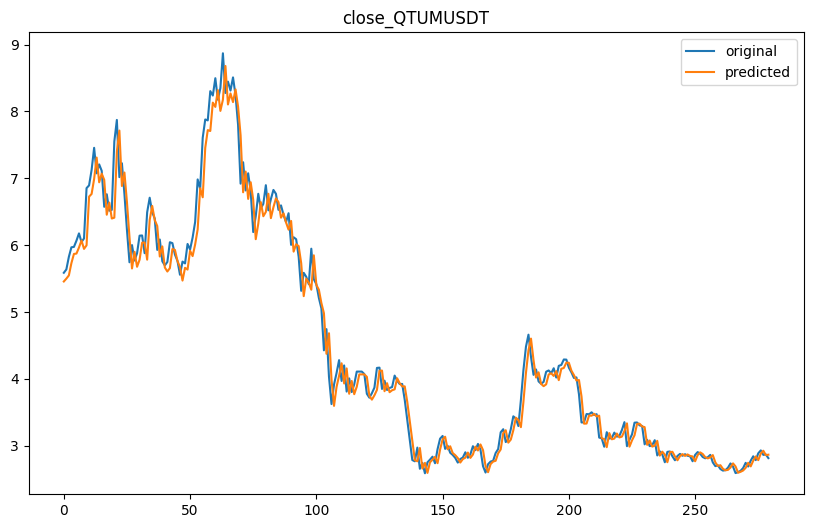

[I 2023-10-25 00:25:46,644] A new study created in RDB with name: close_ICXUSDT


Metrics for 280 days: close_QTUMUSDT MSE: 0.06146575486758888, RMSE: 0.24792288088756326 MAPE: 0.03686783110576012
Metrics for 90 days: close_QTUMUSDT MSE: 0.011633406508930206, RMSE: 0.10785827047069782 MAPE: 0.024303401458304747
Metrics for 30 days: close_QTUMUSDT MSE: 0.003193569501476547, RMSE: 0.0565116757978079 MAPE: 0.01744421305194225
Metrics for 7 days: close_QTUMUSDT MSE: 0.0037981918925647116, RMSE: 0.06162947259684048 MAPE: 0.0196146976504644
11/11 [==============================] - 0s 8ms/step - loss: 0.0013 - mean_absolute_percentage_error_keras: 12.0811


[I 2023-10-25 00:26:36,174] Trial 0 finished with value: 12.0810546875 and parameters: {'num_layers': 4, 'units_layer_0': 96, 'units_layer_1': 160, 'units_layer_2': 160, 'units_layer_3': 96, 'sequence_length': 10, 'learning_rate': 0.000487493228897586, 'dropout_rate': 0.4382313909547334, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 0 with value: 12.0810546875.


11/11 [==============================] - 0s 3ms/step - loss: 7.9624e-04 - mean_absolute_percentage_error_keras: 10.9057


[I 2023-10-25 00:26:54,696] Trial 1 finished with value: 10.905665397644043 and parameters: {'num_layers': 2, 'units_layer_0': 96, 'units_layer_1': 64, 'sequence_length': 8, 'learning_rate': 3.9991806382023476e-05, 'dropout_rate': 0.07715212607140726, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 1 with value: 10.905665397644043.


11/11 [==============================] - 0s 2ms/step - loss: 3.4383e-05 - mean_absolute_percentage_error_keras: 16.3137


[I 2023-10-25 00:27:04,242] Trial 2 finished with value: 16.31370735168457 and parameters: {'num_layers': 1, 'units_layer_0': 64, 'sequence_length': 6, 'learning_rate': 0.0007609872265047295, 'dropout_rate': 0.05593519621081772, 'min_max_scaling': 1, 'layer_type': 'LSTM'}. Best is trial 1 with value: 10.905665397644043.


11/11 [==============================] - 0s 6ms/step - loss: 8.4427e-04 - mean_absolute_percentage_error_keras: 8.9188


[I 2023-10-25 00:27:41,347] Trial 3 finished with value: 8.918831825256348 and parameters: {'num_layers': 4, 'units_layer_0': 64, 'units_layer_1': 128, 'units_layer_2': 96, 'units_layer_3': 32, 'sequence_length': 9, 'learning_rate': 0.0009561722151526324, 'dropout_rate': 0.2556163098966705, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 3 with value: 8.918831825256348.


11/11 [==============================] - 0s 2ms/step - loss: 7.2028e-05 - mean_absolute_percentage_error_keras: 22.3758


[I 2023-10-25 00:27:52,292] Trial 4 finished with value: 22.37584114074707 and parameters: {'num_layers': 2, 'units_layer_0': 192, 'units_layer_1': 32, 'sequence_length': 4, 'learning_rate': 1.4607739158340903e-05, 'dropout_rate': 0.47434224777623024, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 3 with value: 8.918831825256348.


11/11 [==============================] - 0s 4ms/step - loss: 3.7140e-04 - mean_absolute_percentage_error_keras: 5.6900


[I 2023-10-25 00:28:12,500] Trial 5 finished with value: 5.690005779266357 and parameters: {'num_layers': 2, 'units_layer_0': 224, 'units_layer_1': 192, 'sequence_length': 3, 'learning_rate': 0.00027798101729035145, 'dropout_rate': 0.33281520731926956, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 5 with value: 5.690005779266357.


11/11 [==============================] - 0s 3ms/step - loss: 3.4624e-04 - mean_absolute_percentage_error_keras: 5.9217


[I 2023-10-25 00:28:29,235] Trial 6 finished with value: 5.921743392944336 and parameters: {'num_layers': 1, 'units_layer_0': 224, 'sequence_length': 6, 'learning_rate': 0.000857212048907803, 'dropout_rate': 0.38808643851311564, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 5 with value: 5.690005779266357.


11/11 [==============================] - 0s 2ms/step - loss: 2.9336e-04 - mean_absolute_percentage_error_keras: 6.0973


[I 2023-10-25 00:28:42,745] Trial 7 finished with value: 6.097261905670166 and parameters: {'num_layers': 2, 'units_layer_0': 192, 'units_layer_1': 64, 'sequence_length': 9, 'learning_rate': 0.0009327758454718316, 'dropout_rate': 0.08885965367832604, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 5 with value: 5.690005779266357.
[I 2023-10-25 00:28:50,535] Trial 8 pruned. 
[I 2023-10-25 00:28:58,323] Trial 9 pruned. 
[I 2023-10-25 00:29:04,408] Trial 10 pruned. 


11/11 [==============================] - 0s 3ms/step - loss: 2.9794e-04 - mean_absolute_percentage_error_keras: 5.1251


[I 2023-10-25 00:29:20,276] Trial 11 finished with value: 5.125086307525635 and parameters: {'num_layers': 1, 'units_layer_0': 256, 'sequence_length': 4, 'learning_rate': 0.0003323182385931442, 'dropout_rate': 0.3527886271775221, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 11 with value: 5.125086307525635.


11/11 [==============================] - 0s 2ms/step - loss: 2.9369e-04 - mean_absolute_percentage_error_keras: 5.0191


[I 2023-10-25 00:29:34,063] Trial 12 finished with value: 5.019111633300781 and parameters: {'num_layers': 1, 'units_layer_0': 256, 'sequence_length': 3, 'learning_rate': 0.0002802981903721073, 'dropout_rate': 0.2999887858644378, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 12 with value: 5.019111633300781.
[I 2023-10-25 00:29:38,509] Trial 13 pruned. 


11/11 [==============================] - 0s 2ms/step - loss: 4.6871e-04 - mean_absolute_percentage_error_keras: 7.6565


[I 2023-10-25 00:29:50,373] Trial 14 finished with value: 7.6565470695495605 and parameters: {'num_layers': 1, 'units_layer_0': 160, 'sequence_length': 4, 'learning_rate': 0.0004973965763357782, 'dropout_rate': 0.49509948354496913, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 12 with value: 5.019111633300781.
[I 2023-10-25 00:30:00,137] Trial 15 pruned. 
[I 2023-10-25 00:30:03,495] Trial 16 pruned. 
[I 2023-10-25 00:30:07,114] Trial 17 pruned. 
2023-10-25 00:30:09.144329: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_732/simple_rnn_1037/while/body/_74/sequential_732/simple_rnn_1037/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-25 00:30:09.145820: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_732/simple_rnn_1036/while/body/_1/sequential_732/simple_rnn_1036/while/simple_

11/11 [==============================] - 0s 2ms/step - loss: 4.1998e-04 - mean_absolute_percentage_error_keras: 6.6605


[I 2023-10-25 00:30:19,940] Trial 18 finished with value: 6.660462379455566 and parameters: {'num_layers': 3, 'units_layer_0': 32, 'units_layer_1': 256, 'units_layer_2': 256, 'sequence_length': 2, 'learning_rate': 0.0006152497962094803, 'dropout_rate': 0.2604608244728822, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 12 with value: 5.019111633300781.


11/11 [==============================] - 0s 4ms/step - loss: 3.7064e-04 - mean_absolute_percentage_error_keras: 5.4482


[I 2023-10-25 00:30:47,953] Trial 19 finished with value: 5.448245048522949 and parameters: {'num_layers': 2, 'units_layer_0': 256, 'units_layer_1': 160, 'sequence_length': 5, 'learning_rate': 0.0003905194460564839, 'dropout_rate': 0.16354793378564852, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 12 with value: 5.019111633300781.
[I 2023-10-25 00:30:52,643] Trial 20 pruned. 


11/11 [==============================] - 0s 4ms/step - loss: 3.4848e-04 - mean_absolute_percentage_error_keras: 5.5655


[I 2023-10-25 00:31:19,575] Trial 21 finished with value: 5.565515995025635 and parameters: {'num_layers': 2, 'units_layer_0': 256, 'units_layer_1': 160, 'sequence_length': 5, 'learning_rate': 0.000430063043717781, 'dropout_rate': 0.18849566847319227, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 12 with value: 5.019111633300781.


11/11 [==============================] - 0s 4ms/step - loss: 3.9374e-04 - mean_absolute_percentage_error_keras: 6.0033


[I 2023-10-25 00:31:44,499] Trial 22 finished with value: 6.003343105316162 and parameters: {'num_layers': 2, 'units_layer_0': 256, 'units_layer_1': 128, 'sequence_length': 5, 'learning_rate': 0.00046081751551096245, 'dropout_rate': 0.27805568748579323, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 12 with value: 5.019111633300781.


11/11 [==============================] - 0s 4ms/step - loss: 4.8306e-04 - mean_absolute_percentage_error_keras: 8.3255


[I 2023-10-25 00:32:02,634] Trial 23 finished with value: 8.32546615600586 and parameters: {'num_layers': 1, 'units_layer_0': 224, 'sequence_length': 7, 'learning_rate': 0.00039020740111115823, 'dropout_rate': 0.13004775737596744, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 12 with value: 5.019111633300781.


11/11 [==============================] - 0s 4ms/step - loss: 3.1310e-04 - mean_absolute_percentage_error_keras: 5.3554


[I 2023-10-25 00:32:26,413] Trial 24 finished with value: 5.355352401733398 and parameters: {'num_layers': 2, 'units_layer_0': 192, 'units_layer_1': 192, 'sequence_length': 4, 'learning_rate': 0.0005572354010016134, 'dropout_rate': 0.13906401982125743, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 12 with value: 5.019111633300781.


11/11 [==============================] - 0s 2ms/step - loss: 4.0797e-04 - mean_absolute_percentage_error_keras: 8.1257


[I 2023-10-25 00:32:36,393] Trial 25 finished with value: 8.125722885131836 and parameters: {'num_layers': 1, 'units_layer_0': 192, 'sequence_length': 2, 'learning_rate': 0.000560434751856583, 'dropout_rate': 0.2359851792497463, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 12 with value: 5.019111633300781.


11/11 [==============================] - 0s 2ms/step - loss: 4.1094e-04 - mean_absolute_percentage_error_keras: 7.8255


[I 2023-10-25 00:32:50,899] Trial 26 finished with value: 7.82546854019165 and parameters: {'num_layers': 3, 'units_layer_0': 128, 'units_layer_1': 224, 'units_layer_2': 96, 'sequence_length': 4, 'learning_rate': 0.0005561852460932776, 'dropout_rate': 0.0372086213322137, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 12 with value: 5.019111633300781.


11/11 [==============================] - 0s 3ms/step - loss: 3.0273e-04 - mean_absolute_percentage_error_keras: 4.9467


[I 2023-10-25 00:33:08,930] Trial 27 finished with value: 4.946667194366455 and parameters: {'num_layers': 2, 'units_layer_0': 160, 'units_layer_1': 192, 'sequence_length': 3, 'learning_rate': 0.0002611073794103491, 'dropout_rate': 0.2830209186820739, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 27 with value: 4.946667194366455.
[I 2023-10-25 00:33:12,464] Trial 28 pruned. 
[I 2023-10-25 00:33:15,342] Trial 29 pruned. 
[I 2023-10-25 00:33:22,156] Trial 30 pruned. 


11/11 [==============================] - 0s 4ms/step - loss: 4.5258e-04 - mean_absolute_percentage_error_keras: 7.5861


[I 2023-10-25 00:33:43,890] Trial 31 finished with value: 7.586093902587891 and parameters: {'num_layers': 2, 'units_layer_0': 192, 'units_layer_1': 192, 'sequence_length': 4, 'learning_rate': 0.00033442482169266323, 'dropout_rate': 0.23369585643920687, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 27 with value: 4.946667194366455.


11/11 [==============================] - 0s 3ms/step - loss: 3.7133e-04 - mean_absolute_percentage_error_keras: 5.7978


[I 2023-10-25 00:34:01,965] Trial 32 finished with value: 5.797782897949219 and parameters: {'num_layers': 2, 'units_layer_0': 160, 'units_layer_1': 192, 'sequence_length': 3, 'learning_rate': 0.0004508837904038993, 'dropout_rate': 0.29326397478251465, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 27 with value: 4.946667194366455.


11/11 [==============================] - 0s 5ms/step - loss: 5.0421e-04 - mean_absolute_percentage_error_keras: 6.7075


[I 2023-10-25 00:34:33,211] Trial 33 finished with value: 6.707529067993164 and parameters: {'num_layers': 3, 'units_layer_0': 224, 'units_layer_1': 192, 'units_layer_2': 192, 'sequence_length': 4, 'learning_rate': 0.0003531442136852621, 'dropout_rate': 0.2728825831394972, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 27 with value: 4.946667194366455.
[I 2023-10-25 00:34:42,175] Trial 34 pruned. 
[I 2023-10-25 00:34:45,619] Trial 35 pruned. 
[I 2023-10-25 00:34:51,503] Trial 36 pruned. 
[I 2023-10-25 00:34:58,009] Trial 37 pruned. 


11/11 [==============================] - 0s 2ms/step - loss: 1.5536e-04 - mean_absolute_percentage_error_keras: 3.4961


[I 2023-10-25 00:35:06,614] Trial 38 finished with value: 3.4960920810699463 and parameters: {'num_layers': 1, 'units_layer_0': 128, 'sequence_length': 10, 'learning_rate': 0.0005034333550412576, 'dropout_rate': 0.1216532104039693, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 38 with value: 3.4960920810699463.


11/11 [==============================] - 0s 2ms/step - loss: 2.3428e-04 - mean_absolute_percentage_error_keras: 5.0611


[I 2023-10-25 00:35:14,667] Trial 39 finished with value: 5.06107759475708 and parameters: {'num_layers': 1, 'units_layer_0': 64, 'sequence_length': 10, 'learning_rate': 0.0002787733694820512, 'dropout_rate': 0.25896249211504513, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 38 with value: 3.4960920810699463.
[I 2023-10-25 00:35:17,664] Trial 40 pruned. 


11/11 [==============================] - 0s 1ms/step - loss: 3.9125e-04 - mean_absolute_percentage_error_keras: 8.1818


[I 2023-10-25 00:35:26,341] Trial 41 finished with value: 8.181819915771484 and parameters: {'num_layers': 1, 'units_layer_0': 32, 'sequence_length': 10, 'learning_rate': 0.000276993243095005, 'dropout_rate': 0.29468662826156466, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 38 with value: 3.4960920810699463.


11/11 [==============================] - 0s 1ms/step - loss: 3.0988e-04 - mean_absolute_percentage_error_keras: 6.6502


[I 2023-10-25 00:35:34,650] Trial 42 finished with value: 6.650200843811035 and parameters: {'num_layers': 1, 'units_layer_0': 64, 'sequence_length': 9, 'learning_rate': 0.0002082295295460217, 'dropout_rate': 0.3311127475348648, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 38 with value: 3.4960920810699463.


11/11 [==============================] - 0s 1ms/step - loss: 1.9067e-04 - mean_absolute_percentage_error_keras: 3.9336


[I 2023-10-25 00:35:42,797] Trial 43 finished with value: 3.933614730834961 and parameters: {'num_layers': 1, 'units_layer_0': 96, 'sequence_length': 8, 'learning_rate': 0.00034273773551881444, 'dropout_rate': 0.27403412593602827, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 38 with value: 3.4960920810699463.


11/11 [==============================] - 0s 2ms/step - loss: 1.8014e-04 - mean_absolute_percentage_error_keras: 3.8332


[I 2023-10-25 00:35:50,519] Trial 44 finished with value: 3.833242893218994 and parameters: {'num_layers': 1, 'units_layer_0': 96, 'sequence_length': 8, 'learning_rate': 0.00029648530351205965, 'dropout_rate': 0.2659506701790285, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 38 with value: 3.4960920810699463.


11/11 [==============================] - 0s 2ms/step - loss: 1.6529e-04 - mean_absolute_percentage_error_keras: 3.9199


[I 2023-10-25 00:35:58,389] Trial 45 finished with value: 3.9198689460754395 and parameters: {'num_layers': 1, 'units_layer_0': 96, 'sequence_length': 8, 'learning_rate': 0.0003615333323935162, 'dropout_rate': 0.27844306118955525, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 38 with value: 3.4960920810699463.


11/11 [==============================] - 0s 1ms/step - loss: 1.8517e-04 - mean_absolute_percentage_error_keras: 3.7137


[I 2023-10-25 00:36:06,409] Trial 46 finished with value: 3.7136712074279785 and parameters: {'num_layers': 1, 'units_layer_0': 96, 'sequence_length': 8, 'learning_rate': 0.00035653572247442865, 'dropout_rate': 0.22180165956985437, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 38 with value: 3.4960920810699463.


11/11 [==============================] - 0s 2ms/step - loss: 1.6790e-04 - mean_absolute_percentage_error_keras: 3.5439


[I 2023-10-25 00:36:13,899] Trial 47 finished with value: 3.5438785552978516 and parameters: {'num_layers': 1, 'units_layer_0': 96, 'sequence_length': 8, 'learning_rate': 0.0004889961723432617, 'dropout_rate': 0.22029761163763695, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 38 with value: 3.4960920810699463.
[I 2023-10-25 00:36:16,915] Trial 48 pruned. 


11/11 [==============================] - 0s 1ms/step - loss: 1.7261e-04 - mean_absolute_percentage_error_keras: 3.6161


[I 2023-10-25 00:36:25,181] Trial 49 finished with value: 3.61614727973938 and parameters: {'num_layers': 1, 'units_layer_0': 128, 'sequence_length': 8, 'learning_rate': 0.00048425128186369986, 'dropout_rate': 0.1881359388568152, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 38 with value: 3.4960920810699463.


Best Hyperparameters: {'num_layers': 1, 'units_layer_0': 128, 'sequence_length': 10, 'learning_rate': 0.0005034333550412576, 'dropout_rate': 0.1216532104039693, 'min_max_scaling': 0, 'layer_type': 'RNN'}
Epoch 1/100
46/46 [==============================] - 1s 3ms/step - loss: 0.1367
Epoch 2/100
46/46 [==============================] - 0s 3ms/step - loss: 0.0166
Epoch 3/100
46/46 [==============================] - 0s 3ms/step - loss: 0.0139
Epoch 4/100
46/46 [==============================] - 0s 3ms/step - loss: 0.0132
Epoch 5/100
46/46 [==============================] - 0s 3ms/step - loss: 0.0107
Epoch 6/100
46/46 [==============================] - 0s 3ms/step - loss: 0.0120
Epoch 7/100
46/46 [==============================] - 0s 3ms/step - loss: 0.0122
Epoch 8/100
46/46 [==============================] - 0s 4ms/step - loss: 0.0115
Epoch 9/100
46/46 [==============================] - 0s 3ms/step - loss: 0.0104
Epoch 10/100
46/46 [==============================] - 0s 3ms/step - loss: 0.

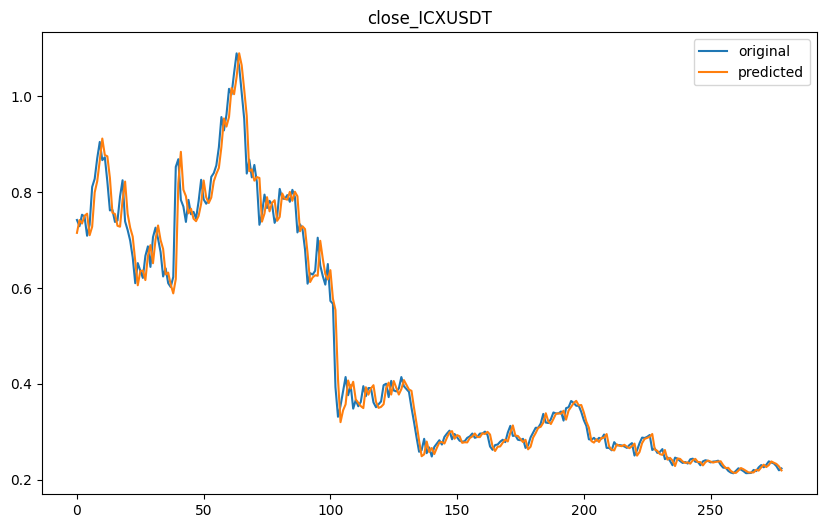

Metrics for 279 days: close_ICXUSDT MSE: 0.0010761355768566488, RMSE: 0.03280450543533081 MAPE: 0.0411886717708797
Metrics for 90 days: close_ICXUSDT MSE: 9.147386330687663e-05, RMSE: 0.009564196950443703 MAPE: 0.02535861027793895
Metrics for 30 days: close_ICXUSDT MSE: 1.910126151693588e-05, RMSE: 0.004370499000907777 MAPE: 0.01687356013137298


[I 2023-10-25 00:36:39,512] A new study created in RDB with name: close_EOSUSDT


Metrics for 7 days: close_ICXUSDT MSE: 2.7733532886947602e-05, RMSE: 0.0052662636552823295 MAPE: 0.02066680251817624
11/11 [==============================] - 0s 4ms/step - loss: 0.0134 - mean_absolute_percentage_error_keras: 376507.3438


[I 2023-10-25 00:37:08,668] Trial 0 finished with value: 376507.34375 and parameters: {'num_layers': 4, 'units_layer_0': 192, 'units_layer_1': 96, 'units_layer_2': 32, 'units_layer_3': 32, 'sequence_length': 5, 'learning_rate': 1.2844776980305835e-05, 'dropout_rate': 0.06821760459707304, 'min_max_scaling': 1, 'layer_type': 'LSTM'}. Best is trial 0 with value: 376507.34375.


11/11 [==============================] - 0s 2ms/step - loss: 0.0043 - mean_absolute_percentage_error_keras: 6.8809


[I 2023-10-25 00:37:24,092] Trial 1 finished with value: 6.880867958068848 and parameters: {'num_layers': 3, 'units_layer_0': 64, 'units_layer_1': 96, 'units_layer_2': 128, 'sequence_length': 8, 'learning_rate': 3.6996351991049795e-05, 'dropout_rate': 0.0355953658619404, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 1 with value: 6.880867958068848.


11/11 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_absolute_percentage_error_keras: 6.2757


[I 2023-10-25 00:37:39,111] Trial 2 finished with value: 6.275720596313477 and parameters: {'num_layers': 2, 'units_layer_0': 224, 'units_layer_1': 64, 'sequence_length': 9, 'learning_rate': 0.0009302030794121833, 'dropout_rate': 0.04657746304918026, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 2 with value: 6.275720596313477.


11/11 [==============================] - 0s 4ms/step - loss: 0.1406 - mean_absolute_percentage_error_keras: 46.2531


[I 2023-10-25 00:38:01,462] Trial 3 finished with value: 46.25311279296875 and parameters: {'num_layers': 2, 'units_layer_0': 224, 'units_layer_1': 224, 'sequence_length': 3, 'learning_rate': 0.00015493000588658333, 'dropout_rate': 0.03994679107491317, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 2 with value: 6.275720596313477.


11/11 [==============================] - 0s 4ms/step - loss: 0.0169 - mean_absolute_percentage_error_keras: 420262.0000


[I 2023-10-25 00:38:26,369] Trial 4 finished with value: 420262.0 and parameters: {'num_layers': 3, 'units_layer_0': 32, 'units_layer_1': 192, 'units_layer_2': 256, 'sequence_length': 3, 'learning_rate': 1.786174354201029e-05, 'dropout_rate': 0.3296548322680154, 'min_max_scaling': 1, 'layer_type': 'LSTM'}. Best is trial 2 with value: 6.275720596313477.


11/11 [==============================] - 0s 5ms/step - loss: 0.3359 - mean_absolute_percentage_error_keras: 71.9837


[I 2023-10-25 00:39:52,668] Trial 5 finished with value: 71.98367309570312 and parameters: {'num_layers': 4, 'units_layer_0': 160, 'units_layer_1': 64, 'units_layer_2': 256, 'units_layer_3': 160, 'sequence_length': 7, 'learning_rate': 0.00029316778738388953, 'dropout_rate': 0.4720531943958684, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 2 with value: 6.275720596313477.


11/11 [==============================] - 0s 3ms/step - loss: 0.1543 - mean_absolute_percentage_error_keras: 47.2212


[I 2023-10-25 00:40:10,525] Trial 6 finished with value: 47.22119140625 and parameters: {'num_layers': 4, 'units_layer_0': 64, 'units_layer_1': 128, 'units_layer_2': 160, 'units_layer_3': 96, 'sequence_length': 7, 'learning_rate': 0.0004011460419700242, 'dropout_rate': 0.43314167059338315, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 2 with value: 6.275720596313477.


11/11 [==============================] - 0s 2ms/step - loss: 0.0076 - mean_absolute_percentage_error_keras: 10.0504


[I 2023-10-25 00:40:24,584] Trial 7 finished with value: 10.050421714782715 and parameters: {'num_layers': 2, 'units_layer_0': 224, 'units_layer_1': 192, 'sequence_length': 6, 'learning_rate': 0.000760767318344178, 'dropout_rate': 0.36394160462977293, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 2 with value: 6.275720596313477.


11/11 [==============================] - 0s 2ms/step - loss: 0.0028 - mean_absolute_percentage_error_keras: 5.7071


[I 2023-10-25 00:40:38,545] Trial 8 finished with value: 5.707076072692871 and parameters: {'num_layers': 3, 'units_layer_0': 96, 'units_layer_1': 256, 'units_layer_2': 160, 'sequence_length': 3, 'learning_rate': 0.0006533470782424297, 'dropout_rate': 0.032616187628056625, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 8 with value: 5.707076072692871.
[I 2023-10-25 00:40:41,835] Trial 9 pruned. 
2023-10-25 00:40:42.897485: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_775/simple_rnn_1069/while/body/_1/sequential_775/simple_rnn_1069/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-25 00:40:42.916698: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:134] tfg_optimizer{any(tfg-consolidate-attrs,tfg-toposort,tfg-shape-inference{graph-version=0},tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Node sequential_775/simple_rnn_1069/while/body/_1/sequent

11/11 [==============================] - 0s 2ms/step - loss: 0.0133 - mean_absolute_percentage_error_keras: 13.8779


[I 2023-10-25 00:40:57,896] Trial 11 finished with value: 13.877861022949219 and parameters: {'num_layers': 2, 'units_layer_0': 128, 'units_layer_1': 32, 'sequence_length': 10, 'learning_rate': 0.0009592894113973173, 'dropout_rate': 0.14943046912737107, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 8 with value: 5.707076072692871.


11/11 [==============================] - 0s 4ms/step - loss: 0.0039 - mean_absolute_percentage_error_keras: 6.6599


[I 2023-10-25 00:41:23,435] Trial 12 finished with value: 6.659875869750977 and parameters: {'num_layers': 3, 'units_layer_0': 256, 'units_layer_1': 256, 'units_layer_2': 160, 'sequence_length': 10, 'learning_rate': 0.0006331320640928109, 'dropout_rate': 0.008041837431383585, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 8 with value: 5.707076072692871.
2023-10-25 00:41:24.976784: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_778/simple_rnn_1075/while/body/_1/sequential_778/simple_rnn_1075/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-25 00:41:24.978814: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_778/simple_rnn_1076/while/body/_74/sequential_778/simple_rnn_1076/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-25 00:41:25.029395: E tensorf

11/11 [==============================] - 0s 1ms/step - loss: 0.0150 - mean_absolute_percentage_error_keras: 14.5272


[I 2023-10-25 00:41:31,836] Trial 13 finished with value: 14.527153015136719 and parameters: {'num_layers': 2, 'units_layer_0': 160, 'units_layer_1': 160, 'sequence_length': 1, 'learning_rate': 0.0007594509623952819, 'dropout_rate': 0.13501926420288612, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 8 with value: 5.707076072692871.
[I 2023-10-25 00:41:42,462] Trial 14 pruned. 


11/11 [==============================] - 0s 1ms/step - loss: 0.0048 - mean_absolute_percentage_error_keras: 7.7054


[I 2023-10-25 00:41:50,959] Trial 15 finished with value: 7.705447196960449 and parameters: {'num_layers': 1, 'units_layer_0': 256, 'sequence_length': 3, 'learning_rate': 0.0008003573018844877, 'dropout_rate': 0.10126940635193854, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 8 with value: 5.707076072692871.


11/11 [==============================] - 0s 3ms/step - loss: 0.0229 - mean_absolute_percentage_error_keras: 17.8723


[I 2023-10-25 00:42:08,568] Trial 16 finished with value: 17.872276306152344 and parameters: {'num_layers': 3, 'units_layer_0': 192, 'units_layer_1': 256, 'units_layer_2': 192, 'sequence_length': 5, 'learning_rate': 0.0006339661626853842, 'dropout_rate': 0.2630796834937483, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 8 with value: 5.707076072692871.
2023-10-25 00:42:10.418555: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_782/simple_rnn_1084/while/body/_1/sequential_782/simple_rnn_1084/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-25 00:42:10.420622: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_782/simple_rnn_1085/while/body/_74/sequential_782/simple_rnn_1085/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-25 00:42:10.501469: E tensorflo

11/11 [==============================] - 0s 2ms/step - loss: 0.0044 - mean_absolute_percentage_error_keras: 7.3299


[I 2023-10-25 00:42:26,643] Trial 18 finished with value: 7.329890727996826 and parameters: {'num_layers': 2, 'units_layer_0': 192, 'units_layer_1': 64, 'sequence_length': 8, 'learning_rate': 0.0009974713884199223, 'dropout_rate': 0.0010291294288760633, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 8 with value: 5.707076072692871.


11/11 [==============================] - 0s 2ms/step - loss: 0.0105 - mean_absolute_percentage_error_keras: 12.0411


[I 2023-10-25 00:42:40,039] Trial 19 finished with value: 12.041111946105957 and parameters: {'num_layers': 3, 'units_layer_0': 96, 'units_layer_1': 160, 'units_layer_2': 32, 'sequence_length': 4, 'learning_rate': 0.0008159353859515084, 'dropout_rate': 0.12232568654427994, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 8 with value: 5.707076072692871.
[I 2023-10-25 00:42:46,583] Trial 20 pruned. 


11/11 [==============================] - 0s 4ms/step - loss: 0.0026 - mean_absolute_percentage_error_keras: 5.2241


[I 2023-10-25 00:43:12,558] Trial 21 finished with value: 5.224063873291016 and parameters: {'num_layers': 3, 'units_layer_0': 256, 'units_layer_1': 256, 'units_layer_2': 192, 'sequence_length': 10, 'learning_rate': 0.0006110383208038686, 'dropout_rate': 0.0007074935533323209, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 21 with value: 5.224063873291016.


11/11 [==============================] - 0s 3ms/step - loss: 0.0025 - mean_absolute_percentage_error_keras: 4.9271


[I 2023-10-25 00:43:36,031] Trial 22 finished with value: 4.927128791809082 and parameters: {'num_layers': 3, 'units_layer_0': 224, 'units_layer_1': 224, 'units_layer_2': 192, 'sequence_length': 9, 'learning_rate': 0.0005365549400852366, 'dropout_rate': 0.048491242568556484, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 22 with value: 4.927128791809082.


11/11 [==============================] - 0s 4ms/step - loss: 0.0039 - mean_absolute_percentage_error_keras: 6.6013


[I 2023-10-25 00:44:00,219] Trial 23 finished with value: 6.601297855377197 and parameters: {'num_layers': 3, 'units_layer_0': 256, 'units_layer_1': 256, 'units_layer_2': 192, 'sequence_length': 9, 'learning_rate': 0.0005283939724136195, 'dropout_rate': 0.08512520195115572, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 22 with value: 4.927128791809082.


11/11 [==============================] - 0s 4ms/step - loss: 0.0108 - mean_absolute_percentage_error_keras: 11.9799


[I 2023-10-25 00:44:23,360] Trial 24 finished with value: 11.979850769042969 and parameters: {'num_layers': 3, 'units_layer_0': 224, 'units_layer_1': 224, 'units_layer_2': 192, 'sequence_length': 10, 'learning_rate': 0.0004241693190528071, 'dropout_rate': 0.05743260298470658, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 22 with value: 4.927128791809082.


11/11 [==============================] - 0s 4ms/step - loss: 0.0034 - mean_absolute_percentage_error_keras: 6.1081


[I 2023-10-25 00:44:52,621] Trial 25 finished with value: 6.108119487762451 and parameters: {'num_layers': 4, 'units_layer_0': 256, 'units_layer_1': 224, 'units_layer_2': 224, 'units_layer_3': 256, 'sequence_length': 8, 'learning_rate': 0.0005852480229581518, 'dropout_rate': 0.0025524048362642084, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 22 with value: 4.927128791809082.


11/11 [==============================] - 0s 3ms/step - loss: 0.0050 - mean_absolute_percentage_error_keras: 8.1549


[I 2023-10-25 00:45:13,972] Trial 26 finished with value: 8.154912948608398 and parameters: {'num_layers': 3, 'units_layer_0': 160, 'units_layer_1': 256, 'units_layer_2': 224, 'sequence_length': 7, 'learning_rate': 0.0007120878674995886, 'dropout_rate': 0.11364202634723992, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 22 with value: 4.927128791809082.
[I 2023-10-25 00:45:25,942] Trial 27 pruned. 


11/11 [==============================] - 0s 4ms/step - loss: 0.0072 - mean_absolute_percentage_error_keras: 9.8537


[I 2023-10-25 00:45:53,586] Trial 28 finished with value: 9.853734016418457 and parameters: {'num_layers': 4, 'units_layer_0': 192, 'units_layer_1': 256, 'units_layer_2': 160, 'units_layer_3': 160, 'sequence_length': 10, 'learning_rate': 0.00046942701241295355, 'dropout_rate': 0.09777598687113287, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 22 with value: 4.927128791809082.
[I 2023-10-25 00:46:07,882] Trial 29 pruned. 
2023-10-25 00:46:09.924284: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_795/simple_rnn_1119/while/body/_74/sequential_795/simple_rnn_1119/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-25 00:46:09.926183: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_795/simple_rnn_1118/while/body/_1/sequential_795/simple_rnn_1118/while/simple_rnn_cell/Relu}}
	.  Regist

11/11 [==============================] - 0s 2ms/step - loss: 0.0020 - mean_absolute_percentage_error_keras: 3.8838


[I 2023-10-25 00:46:21,639] Trial 30 finished with value: 3.88376784324646 and parameters: {'num_layers': 3, 'units_layer_0': 256, 'units_layer_1': 192, 'units_layer_2': 192, 'sequence_length': 2, 'learning_rate': 0.0005590356679693676, 'dropout_rate': 0.03383791659672521, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 30 with value: 3.88376784324646.
2023-10-25 00:46:23.606029: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_796/simple_rnn_1122/while/body/_74/sequential_796/simple_rnn_1122/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-25 00:46:23.607875: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_796/simple_rnn_1121/while/body/_1/sequential_796/simple_rnn_1121/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-25 00:46:23.608783: W tensorflow

11/11 [==============================] - 0s 2ms/step - loss: 0.0072 - mean_absolute_percentage_error_keras: 9.8896


[I 2023-10-25 00:46:34,894] Trial 31 finished with value: 9.889595031738281 and parameters: {'num_layers': 3, 'units_layer_0': 256, 'units_layer_1': 192, 'units_layer_2': 192, 'sequence_length': 2, 'learning_rate': 0.0005749641279831404, 'dropout_rate': 0.04000771340314064, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 30 with value: 3.88376784324646.
2023-10-25 00:46:36.926238: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_797/simple_rnn_1125/while/body/_74/sequential_797/simple_rnn_1125/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-25 00:46:36.927869: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_797/simple_rnn_1124/while/body/_1/sequential_797/simple_rnn_1124/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-25 00:46:36.929080: W tensorflo

11/11 [==============================] - 0s 2ms/step - loss: 0.0049 - mean_absolute_percentage_error_keras: 7.8999


[I 2023-10-25 00:46:48,415] Trial 32 finished with value: 7.8999176025390625 and parameters: {'num_layers': 3, 'units_layer_0': 256, 'units_layer_1': 224, 'units_layer_2': 192, 'sequence_length': 2, 'learning_rate': 0.0004884493868704732, 'dropout_rate': 0.03575714529833735, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 30 with value: 3.88376784324646.


11/11 [==============================] - 0s 3ms/step - loss: 0.0012 - mean_absolute_percentage_error_keras: 2.8864


[I 2023-10-25 00:47:06,958] Trial 33 finished with value: 2.8863861560821533 and parameters: {'num_layers': 3, 'units_layer_0': 224, 'units_layer_1': 256, 'units_layer_2': 160, 'sequence_length': 5, 'learning_rate': 0.0006501405289778843, 'dropout_rate': 0.060764528552394136, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 33 with value: 2.8863861560821533.


11/11 [==============================] - 0s 3ms/step - loss: 0.0092 - mean_absolute_percentage_error_keras: 10.7505


[I 2023-10-25 00:47:25,260] Trial 34 finished with value: 10.750473976135254 and parameters: {'num_layers': 3, 'units_layer_0': 224, 'units_layer_1': 192, 'units_layer_2': 224, 'sequence_length': 5, 'learning_rate': 0.0005463377822899176, 'dropout_rate': 0.06887076262145875, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 33 with value: 2.8863861560821533.


11/11 [==============================] - 0s 3ms/step - loss: 0.0221 - mean_absolute_percentage_error_keras: 17.6269


[I 2023-10-25 00:47:45,083] Trial 35 finished with value: 17.626924514770508 and parameters: {'num_layers': 3, 'units_layer_0': 192, 'units_layer_1': 224, 'units_layer_2': 128, 'sequence_length': 8, 'learning_rate': 0.0006224833841639167, 'dropout_rate': 0.08082535226326112, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 33 with value: 2.8863861560821533.
[I 2023-10-25 00:47:58,600] Trial 36 pruned. 


11/11 [==============================] - 0s 3ms/step - loss: 0.0070 - mean_absolute_percentage_error_keras: 9.4968


[I 2023-10-25 00:48:17,787] Trial 37 finished with value: 9.496819496154785 and parameters: {'num_layers': 2, 'units_layer_0': 256, 'units_layer_1': 256, 'sequence_length': 9, 'learning_rate': 0.0003620755976182343, 'dropout_rate': 0.12053867924481967, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 33 with value: 2.8863861560821533.


11/11 [==============================] - 0s 3ms/step - loss: 0.0023 - mean_absolute_percentage_error_keras: 4.5819


[I 2023-10-25 00:48:39,385] Trial 38 finished with value: 4.581855773925781 and parameters: {'num_layers': 3, 'units_layer_0': 224, 'units_layer_1': 224, 'units_layer_2': 160, 'sequence_length': 8, 'learning_rate': 0.0006834391559840423, 'dropout_rate': 0.028108445738155848, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 33 with value: 2.8863861560821533.
[I 2023-10-25 00:48:53,350] Trial 39 pruned. 


11/11 [==============================] - 0s 4ms/step - loss: 0.0024 - mean_absolute_percentage_error_keras: 5.1832


[I 2023-10-25 00:49:18,068] Trial 40 finished with value: 5.183161735534668 and parameters: {'num_layers': 4, 'units_layer_0': 224, 'units_layer_1': 224, 'units_layer_2': 96, 'units_layer_3': 192, 'sequence_length': 8, 'learning_rate': 0.0005466990076072222, 'dropout_rate': 0.025697006346973264, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 33 with value: 2.8863861560821533.


11/11 [==============================] - 0s 5ms/step - loss: 0.0101 - mean_absolute_percentage_error_keras: 11.5647


[I 2023-10-25 00:49:43,239] Trial 41 finished with value: 11.564656257629395 and parameters: {'num_layers': 4, 'units_layer_0': 224, 'units_layer_1': 224, 'units_layer_2': 96, 'units_layer_3': 192, 'sequence_length': 8, 'learning_rate': 0.0005549037148336839, 'dropout_rate': 0.025949279855696658, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 33 with value: 2.8863861560821533.


11/11 [==============================] - 0s 3ms/step - loss: 0.0056 - mean_absolute_percentage_error_keras: 8.6004


[I 2023-10-25 00:50:06,934] Trial 42 finished with value: 8.600377082824707 and parameters: {'num_layers': 4, 'units_layer_0': 224, 'units_layer_1': 224, 'units_layer_2': 64, 'units_layer_3': 224, 'sequence_length': 7, 'learning_rate': 0.0005148097835470604, 'dropout_rate': 0.04884390596121324, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 33 with value: 2.8863861560821533.


11/11 [==============================] - 0s 2ms/step - loss: 0.0029 - mean_absolute_percentage_error_keras: 5.8100


[I 2023-10-25 00:50:25,246] Trial 43 finished with value: 5.810049057006836 and parameters: {'num_layers': 3, 'units_layer_0': 224, 'units_layer_1': 192, 'units_layer_2': 160, 'sequence_length': 6, 'learning_rate': 0.0006619888637644525, 'dropout_rate': 0.02818029024788932, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 33 with value: 2.8863861560821533.


11/11 [==============================] - 0s 4ms/step - loss: 0.0060 - mean_absolute_percentage_error_keras: 8.8535


[I 2023-10-25 00:50:48,305] Trial 44 finished with value: 8.85353946685791 and parameters: {'num_layers': 4, 'units_layer_0': 192, 'units_layer_1': 224, 'units_layer_2': 128, 'units_layer_3': 96, 'sequence_length': 8, 'learning_rate': 0.0006069122196622539, 'dropout_rate': 0.09113626862787705, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 33 with value: 2.8863861560821533.


11/11 [==============================] - 0s 3ms/step - loss: 0.0068 - mean_absolute_percentage_error_keras: 9.4584


[I 2023-10-25 00:51:09,173] Trial 45 finished with value: 9.458382606506348 and parameters: {'num_layers': 3, 'units_layer_0': 160, 'units_layer_1': 192, 'units_layer_2': 160, 'sequence_length': 9, 'learning_rate': 0.0005046660513901904, 'dropout_rate': 0.07242018778353691, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 33 with value: 2.8863861560821533.


11/11 [==============================] - 0s 3ms/step - loss: 0.0017 - mean_absolute_percentage_error_keras: 4.1389


[I 2023-10-25 00:51:27,748] Trial 46 finished with value: 4.138879776000977 and parameters: {'num_layers': 3, 'units_layer_0': 224, 'units_layer_1': 160, 'units_layer_2': 64, 'sequence_length': 7, 'learning_rate': 0.0005614459097464543, 'dropout_rate': 0.02400639777136807, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 33 with value: 2.8863861560821533.
[I 2023-10-25 00:51:38,177] Trial 47 pruned. 
[I 2023-10-25 00:51:43,951] Trial 48 pruned. 


11/11 [==============================] - 0s 3ms/step - loss: 0.0024 - mean_absolute_percentage_error_keras: 4.8197


[I 2023-10-25 00:51:58,795] Trial 49 finished with value: 4.819701671600342 and parameters: {'num_layers': 3, 'units_layer_0': 256, 'units_layer_1': 96, 'units_layer_2': 160, 'sequence_length': 4, 'learning_rate': 0.00041378005627849595, 'dropout_rate': 0.023375003879876587, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 33 with value: 2.8863861560821533.


Best Hyperparameters: {'num_layers': 3, 'units_layer_0': 224, 'units_layer_1': 256, 'units_layer_2': 160, 'sequence_length': 5, 'learning_rate': 0.0006501405289778843, 'dropout_rate': 0.060764528552394136, 'min_max_scaling': 0, 'layer_type': 'RNN'}
Epoch 1/100
46/46 [==============================] - 4s 7ms/step - loss: 0.7266
Epoch 2/100
46/46 [==============================] - 0s 6ms/step - loss: 0.2312
Epoch 3/100
46/46 [==============================] - 0s 7ms/step - loss: 0.2148
Epoch 4/100
46/46 [==============================] - 0s 7ms/step - loss: 0.2119
Epoch 5/100
46/46 [==============================] - 0s 7ms/step - loss: 0.1790
Epoch 6/100
46/46 [==============================] - 0s 6ms/step - loss: 0.1522
Epoch 7/100
46/46 [==============================] - 0s 7ms/step - loss: 0.1582
Epoch 8/100
46/46 [==============================] - 0s 6ms/step - loss: 0.1611
Epoch 9/100
46/46 [==============================] - 0s 7ms/step - loss: 0.1885
Epoch 10/100
46/46 [===========

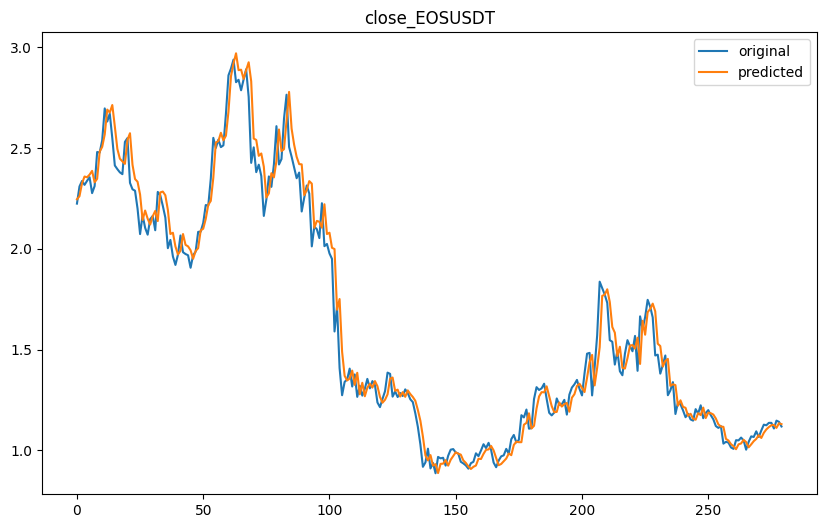

[I 2023-10-25 00:52:35,861] A new study created in RDB with name: close_BNBUSDT


Metrics for 280 days: close_EOSUSDT MSE: 0.009053635192517348, RMSE: 0.09515059218164304 MAPE: 0.04085992879507328
Metrics for 90 days: close_EOSUSDT MSE: 0.006635999786961003, RMSE: 0.08146164611006215 MAPE: 0.04025638030505354
Metrics for 30 days: close_EOSUSDT MSE: 0.0008293586736808844, RMSE: 0.028798588050126424 MAPE: 0.02193717648036725
Metrics for 7 days: close_EOSUSDT MSE: 0.00039868594339008726, RMSE: 0.01996712155995669 MAPE: 0.015858792060435115
11/11 [==============================] - 0s 2ms/step - loss: 182.4733 - mean_absolute_percentage_error_keras: 4.0794


[I 2023-10-25 00:52:48,835] Trial 0 finished with value: 4.079384803771973 and parameters: {'num_layers': 1, 'units_layer_0': 96, 'sequence_length': 9, 'learning_rate': 0.0005375282976244623, 'dropout_rate': 0.46046835207473835, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 0 with value: 4.079384803771973.


11/11 [==============================] - 0s 2ms/step - loss: 408.4612 - mean_absolute_percentage_error_keras: 6.8754


[I 2023-10-25 00:53:04,013] Trial 1 finished with value: 6.8753509521484375 and parameters: {'num_layers': 4, 'units_layer_0': 32, 'units_layer_1': 128, 'units_layer_2': 128, 'units_layer_3': 160, 'sequence_length': 3, 'learning_rate': 0.0007399610584374984, 'dropout_rate': 0.039653830266501044, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 0 with value: 4.079384803771973.


11/11 [==============================] - 0s 3ms/step - loss: 10255.5615 - mean_absolute_percentage_error_keras: 36.1028


[I 2023-10-25 00:53:22,031] Trial 2 finished with value: 36.10283660888672 and parameters: {'num_layers': 2, 'units_layer_0': 128, 'units_layer_1': 224, 'sequence_length': 3, 'learning_rate': 0.00038716398885289566, 'dropout_rate': 0.47863900017261113, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 0 with value: 4.079384803771973.


11/11 [==============================] - 0s 4ms/step - loss: 843.3034 - mean_absolute_percentage_error_keras: 9.6594


[I 2023-10-25 00:53:52,989] Trial 3 finished with value: 9.65938663482666 and parameters: {'num_layers': 4, 'units_layer_0': 128, 'units_layer_1': 64, 'units_layer_2': 224, 'units_layer_3': 192, 'sequence_length': 3, 'learning_rate': 0.0005108968369926421, 'dropout_rate': 0.07759601787109599, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 0 with value: 4.079384803771973.
2023-10-25 00:53:54.536095: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_820/simple_rnn_1179/while/body/_1/sequential_820/simple_rnn_1179/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-25 00:53:54.537644: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_820/simple_rnn_1180/while/body/_74/sequential_820/simple_rnn_1180/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-25 00:53:54

11/11 [==============================] - 0s 2ms/step - loss: 207.2385 - mean_absolute_percentage_error_keras: 4.6111


[I 2023-10-25 00:54:03,529] Trial 4 finished with value: 4.611087799072266 and parameters: {'num_layers': 2, 'units_layer_0': 224, 'units_layer_1': 224, 'sequence_length': 2, 'learning_rate': 0.00041715299187837306, 'dropout_rate': 0.07252777581460529, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 0 with value: 4.079384803771973.
[I 2023-10-25 00:54:09,553] Trial 5 pruned. 
[I 2023-10-25 00:54:18,169] Trial 6 pruned. 
2023-10-25 00:54:20.862075: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_823/simple_rnn_1187/while/body/_157/sequential_823/simple_rnn_1187/while/simple_rnn_cell/Relu}}
	.  Registered:  <no registered kernels>

2023-10-25 00:54:20.863676: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered '' OpKernel for CPU devices compatible with node {{node sequential_823/simple_rnn_1186/while/body/_74/sequential_823/simple_rnn_1186/while/simple_rnn_cell/Relu}}
	.  Registe

11/11 [==============================] - 0s 1ms/step - loss: 64.3766 - mean_absolute_percentage_error_keras: 1.8568


[I 2023-10-25 00:55:02,366] Trial 11 finished with value: 1.8568134307861328 and parameters: {'num_layers': 1, 'units_layer_0': 192, 'sequence_length': 7, 'learning_rate': 0.0003709012874341882, 'dropout_rate': 0.1331483763731589, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 11 with value: 1.8568134307861328.


11/11 [==============================] - 0s 2ms/step - loss: 99.9407 - mean_absolute_percentage_error_keras: 2.8077


[I 2023-10-25 00:55:12,227] Trial 12 finished with value: 2.807690382003784 and parameters: {'num_layers': 1, 'units_layer_0': 192, 'sequence_length': 8, 'learning_rate': 0.000293335252722055, 'dropout_rate': 0.1345793575457318, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 11 with value: 1.8568134307861328.


11/11 [==============================] - 0s 2ms/step - loss: 60.6740 - mean_absolute_percentage_error_keras: 1.7451


[I 2023-10-25 00:55:21,122] Trial 13 finished with value: 1.745076060295105 and parameters: {'num_layers': 1, 'units_layer_0': 192, 'sequence_length': 7, 'learning_rate': 0.00027793099038500547, 'dropout_rate': 0.14546099222335176, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 13 with value: 1.745076060295105.


11/11 [==============================] - 0s 2ms/step - loss: 381.5714 - mean_absolute_percentage_error_keras: 6.5827


[I 2023-10-25 00:55:33,602] Trial 14 finished with value: 6.582679748535156 and parameters: {'num_layers': 2, 'units_layer_0': 192, 'units_layer_1': 32, 'sequence_length': 6, 'learning_rate': 0.0002669928969880385, 'dropout_rate': 0.1545426716003125, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 13 with value: 1.745076060295105.


11/11 [==============================] - 0s 1ms/step - loss: 61.4412 - mean_absolute_percentage_error_keras: 1.7715


[I 2023-10-25 00:55:41,417] Trial 15 finished with value: 1.7714858055114746 and parameters: {'num_layers': 1, 'units_layer_0': 160, 'sequence_length': 6, 'learning_rate': 0.00023620666380278843, 'dropout_rate': 0.003803777210174164, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 13 with value: 1.745076060295105.


11/11 [==============================] - 0s 2ms/step - loss: 59.4421 - mean_absolute_percentage_error_keras: 1.7459


[I 2023-10-25 00:55:55,615] Trial 16 finished with value: 1.7458585500717163 and parameters: {'num_layers': 3, 'units_layer_0': 160, 'units_layer_1': 128, 'units_layer_2': 32, 'sequence_length': 5, 'learning_rate': 0.00020709608705557633, 'dropout_rate': 0.003471865422266518, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 13 with value: 1.745076060295105.
[I 2023-10-25 00:56:01,003] Trial 17 pruned. 


11/11 [==============================] - 0s 2ms/step - loss: 374.0651 - mean_absolute_percentage_error_keras: 6.5430


[I 2023-10-25 00:56:20,418] Trial 18 finished with value: 6.542976379394531 and parameters: {'num_layers': 3, 'units_layer_0': 256, 'units_layer_1': 96, 'units_layer_2': 32, 'sequence_length': 7, 'learning_rate': 0.00019110976621338296, 'dropout_rate': 0.0825640140868454, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 13 with value: 1.745076060295105.


11/11 [==============================] - 0s 2ms/step - loss: 498.9140 - mean_absolute_percentage_error_keras: 7.6792


[I 2023-10-25 00:56:32,837] Trial 19 finished with value: 7.679160118103027 and parameters: {'num_layers': 2, 'units_layer_0': 224, 'units_layer_1': 160, 'sequence_length': 4, 'learning_rate': 0.00011062833509363696, 'dropout_rate': 0.18932971406706933, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 13 with value: 1.745076060295105.
[I 2023-10-25 00:56:38,930] Trial 20 pruned. 


11/11 [==============================] - 0s 1ms/step - loss: 64.3460 - mean_absolute_percentage_error_keras: 1.8316


[I 2023-10-25 00:56:46,634] Trial 21 finished with value: 1.8315532207489014 and parameters: {'num_layers': 1, 'units_layer_0': 160, 'sequence_length': 6, 'learning_rate': 0.00022313370455757025, 'dropout_rate': 0.007258885631077905, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 13 with value: 1.745076060295105.


11/11 [==============================] - 0s 2ms/step - loss: 110.1603 - mean_absolute_percentage_error_keras: 3.0294


[I 2023-10-25 00:56:57,858] Trial 22 finished with value: 3.029399871826172 and parameters: {'num_layers': 2, 'units_layer_0': 192, 'units_layer_1': 32, 'sequence_length': 5, 'learning_rate': 0.00022901053167517337, 'dropout_rate': 0.03115413715824529, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 13 with value: 1.745076060295105.


11/11 [==============================] - 0s 1ms/step - loss: 65.0164 - mean_absolute_percentage_error_keras: 1.8935


[I 2023-10-25 00:57:05,535] Trial 23 finished with value: 1.8935308456420898 and parameters: {'num_layers': 1, 'units_layer_0': 128, 'sequence_length': 6, 'learning_rate': 0.00029046759138225185, 'dropout_rate': 0.07080660455325981, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 13 with value: 1.745076060295105.


11/11 [==============================] - 0s 2ms/step - loss: 87.6648 - mean_absolute_percentage_error_keras: 2.5511


[I 2023-10-25 00:57:21,544] Trial 24 finished with value: 2.5511491298675537 and parameters: {'num_layers': 3, 'units_layer_0': 160, 'units_layer_1': 192, 'units_layer_2': 64, 'sequence_length': 4, 'learning_rate': 0.0001821912521067568, 'dropout_rate': 0.03983066976373728, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 13 with value: 1.745076060295105.


11/11 [==============================] - 0s 2ms/step - loss: 232.5407 - mean_absolute_percentage_error_keras: 4.9878


[I 2023-10-25 00:57:33,477] Trial 25 finished with value: 4.987751007080078 and parameters: {'num_layers': 2, 'units_layer_0': 64, 'units_layer_1': 96, 'sequence_length': 8, 'learning_rate': 0.0004357195383338626, 'dropout_rate': 0.0013102633356500038, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 13 with value: 1.745076060295105.


11/11 [==============================] - 0s 2ms/step - loss: 94.5356 - mean_absolute_percentage_error_keras: 2.6771


[I 2023-10-25 00:57:42,306] Trial 26 finished with value: 2.67707896232605 and parameters: {'num_layers': 1, 'units_layer_0': 192, 'sequence_length': 8, 'learning_rate': 8.510558247759581e-05, 'dropout_rate': 0.11964010990278978, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 13 with value: 1.745076060295105.


11/11 [==============================] - 0s 2ms/step - loss: 91.0511 - mean_absolute_percentage_error_keras: 2.6181


[I 2023-10-25 00:57:52,667] Trial 27 finished with value: 2.6181397438049316 and parameters: {'num_layers': 2, 'units_layer_0': 128, 'units_layer_1': 160, 'sequence_length': 4, 'learning_rate': 0.0003371752917859022, 'dropout_rate': 0.0957155726168557, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 13 with value: 1.745076060295105.


11/11 [==============================] - 0s 3ms/step - loss: 123.3576 - mean_absolute_percentage_error_keras: 3.2851


[I 2023-10-25 00:58:12,451] Trial 28 finished with value: 3.285109281539917 and parameters: {'num_layers': 3, 'units_layer_0': 224, 'units_layer_1': 256, 'units_layer_2': 96, 'sequence_length': 7, 'learning_rate': 0.0002171639724469045, 'dropout_rate': 0.047272147278260804, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 13 with value: 1.745076060295105.
[I 2023-10-25 00:58:18,229] Trial 29 pruned. 


11/11 [==============================] - 0s 1ms/step - loss: 110.5110 - mean_absolute_percentage_error_keras: 2.9493


[I 2023-10-25 00:58:26,585] Trial 30 finished with value: 2.949310064315796 and parameters: {'num_layers': 1, 'units_layer_0': 64, 'sequence_length': 5, 'learning_rate': 0.00016218298424632385, 'dropout_rate': 0.15862954087450595, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 13 with value: 1.745076060295105.


11/11 [==============================] - 0s 1ms/step - loss: 113.6433 - mean_absolute_percentage_error_keras: 3.0671


[I 2023-10-25 00:58:34,876] Trial 31 finished with value: 3.0671331882476807 and parameters: {'num_layers': 1, 'units_layer_0': 160, 'sequence_length': 6, 'learning_rate': 0.00022665097575036338, 'dropout_rate': 0.0015936956806364973, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 13 with value: 1.745076060295105.


11/11 [==============================] - 0s 1ms/step - loss: 63.8615 - mean_absolute_percentage_error_keras: 1.8633


[I 2023-10-25 00:58:43,049] Trial 32 finished with value: 1.8633396625518799 and parameters: {'num_layers': 1, 'units_layer_0': 160, 'sequence_length': 6, 'learning_rate': 0.00027150666306272075, 'dropout_rate': 0.025118401250369293, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 13 with value: 1.745076060295105.


11/11 [==============================] - 0s 1ms/step - loss: 62.3648 - mean_absolute_percentage_error_keras: 1.8027


[I 2023-10-25 00:58:50,928] Trial 33 finished with value: 1.802687644958496 and parameters: {'num_layers': 1, 'units_layer_0': 128, 'sequence_length': 6, 'learning_rate': 0.00033821105021281854, 'dropout_rate': 0.0562097406577961, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 13 with value: 1.745076060295105.


11/11 [==============================] - 0s 2ms/step - loss: 87.3513 - mean_absolute_percentage_error_keras: 2.5480


[I 2023-10-25 00:59:02,600] Trial 34 finished with value: 2.548034191131592 and parameters: {'num_layers': 2, 'units_layer_0': 128, 'units_layer_1': 64, 'sequence_length': 7, 'learning_rate': 0.0003443779074748165, 'dropout_rate': 0.05546565182094293, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 13 with value: 1.745076060295105.


11/11 [==============================] - 0s 2ms/step - loss: 74.2298 - mean_absolute_percentage_error_keras: 2.3808


[I 2023-10-25 00:59:12,410] Trial 35 finished with value: 2.380810260772705 and parameters: {'num_layers': 1, 'units_layer_0': 128, 'sequence_length': 4, 'learning_rate': 0.00039648596922293197, 'dropout_rate': 0.09584281560636568, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 13 with value: 1.745076060295105.


11/11 [==============================] - 0s 1ms/step - loss: 66.0976 - mean_absolute_percentage_error_keras: 1.9375


[I 2023-10-25 00:59:21,685] Trial 36 finished with value: 1.9375345706939697 and parameters: {'num_layers': 1, 'units_layer_0': 192, 'sequence_length': 8, 'learning_rate': 0.00044999411910981197, 'dropout_rate': 0.07195044482201157, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 13 with value: 1.745076060295105.


11/11 [==============================] - 0s 2ms/step - loss: 65.6996 - mean_absolute_percentage_error_keras: 1.8953


[I 2023-10-25 00:59:34,662] Trial 37 finished with value: 1.8953473567962646 and parameters: {'num_layers': 2, 'units_layer_0': 128, 'units_layer_1': 192, 'sequence_length': 5, 'learning_rate': 0.00038423577276447044, 'dropout_rate': 0.04089915507634578, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 13 with value: 1.745076060295105.
[I 2023-10-25 00:59:43,967] Trial 38 pruned. 


11/11 [==============================] - 0s 1ms/step - loss: 68.3578 - mean_absolute_percentage_error_keras: 1.8496


[I 2023-10-25 00:59:51,206] Trial 39 finished with value: 1.8496191501617432 and parameters: {'num_layers': 1, 'units_layer_0': 64, 'sequence_length': 7, 'learning_rate': 0.00014711782581215273, 'dropout_rate': 0.09634434166726547, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 13 with value: 1.745076060295105.


11/11 [==============================] - 0s 2ms/step - loss: 1.8872e-04 - mean_absolute_percentage_error_keras: 2.3672


[I 2023-10-25 01:00:14,267] Trial 40 finished with value: 2.367241144180298 and parameters: {'num_layers': 3, 'units_layer_0': 224, 'units_layer_1': 96, 'units_layer_2': 192, 'sequence_length': 3, 'learning_rate': 0.0003163895676494828, 'dropout_rate': 0.06398323950571064, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 13 with value: 1.745076060295105.


11/11 [==============================] - 0s 1ms/step - loss: 100.9043 - mean_absolute_percentage_error_keras: 2.8134


[I 2023-10-25 01:00:22,278] Trial 41 finished with value: 2.813401460647583 and parameters: {'num_layers': 1, 'units_layer_0': 160, 'sequence_length': 6, 'learning_rate': 0.0002450957984745853, 'dropout_rate': 0.019040705637253776, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 13 with value: 1.745076060295105.


11/11 [==============================] - 0s 1ms/step - loss: 63.1728 - mean_absolute_percentage_error_keras: 1.7760


[I 2023-10-25 01:00:30,098] Trial 42 finished with value: 1.7759535312652588 and parameters: {'num_layers': 1, 'units_layer_0': 160, 'sequence_length': 6, 'learning_rate': 0.00021357113805358757, 'dropout_rate': 0.0010865462123665019, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 13 with value: 1.745076060295105.


11/11 [==============================] - 0s 1ms/step - loss: 282.4809 - mean_absolute_percentage_error_keras: 5.5882


[I 2023-10-25 01:00:38,504] Trial 43 finished with value: 5.588200569152832 and parameters: {'num_layers': 1, 'units_layer_0': 192, 'sequence_length': 5, 'learning_rate': 0.0002736530314634216, 'dropout_rate': 0.029147267434152656, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 13 with value: 1.745076060295105.


11/11 [==============================] - 0s 2ms/step - loss: 142.6885 - mean_absolute_percentage_error_keras: 3.5432


[I 2023-10-25 01:00:47,154] Trial 44 finished with value: 3.5431673526763916 and parameters: {'num_layers': 1, 'units_layer_0': 128, 'sequence_length': 7, 'learning_rate': 0.0001620689483512269, 'dropout_rate': 0.06483057104822684, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 13 with value: 1.745076060295105.


11/11 [==============================] - 0s 2ms/step - loss: 111.2526 - mean_absolute_percentage_error_keras: 3.1091


[I 2023-10-25 01:01:00,022] Trial 45 finished with value: 3.1090564727783203 and parameters: {'num_layers': 1, 'units_layer_0': 160, 'sequence_length': 5, 'learning_rate': 0.0003690312084642953, 'dropout_rate': 0.022335798572903534, 'min_max_scaling': 0, 'layer_type': 'LSTM'}. Best is trial 13 with value: 1.745076060295105.


11/11 [==============================] - 0s 4ms/step - loss: 160.6455 - mean_absolute_percentage_error_keras: 3.8995


[I 2023-10-25 01:01:20,132] Trial 46 finished with value: 3.8995063304901123 and parameters: {'num_layers': 4, 'units_layer_0': 192, 'units_layer_1': 32, 'units_layer_2': 64, 'units_layer_3': 32, 'sequence_length': 8, 'learning_rate': 0.0003032868363820372, 'dropout_rate': 0.05156696321051719, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 13 with value: 1.745076060295105.


11/11 [==============================] - 0s 1ms/step - loss: 78.3074 - mean_absolute_percentage_error_keras: 2.0249


[I 2023-10-25 01:01:27,825] Trial 47 finished with value: 2.024928092956543 and parameters: {'num_layers': 1, 'units_layer_0': 96, 'sequence_length': 6, 'learning_rate': 6.965689222637709e-05, 'dropout_rate': 0.08708667278062165, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 13 with value: 1.745076060295105.


11/11 [==============================] - 0s 2ms/step - loss: 496.3982 - mean_absolute_percentage_error_keras: 7.6526


[I 2023-10-25 01:01:41,010] Trial 48 finished with value: 7.652621269226074 and parameters: {'num_layers': 2, 'units_layer_0': 128, 'units_layer_1': 128, 'sequence_length': 10, 'learning_rate': 0.0005539430612156814, 'dropout_rate': 0.001455160710074736, 'min_max_scaling': 0, 'layer_type': 'RNN'}. Best is trial 13 with value: 1.745076060295105.


11/11 [==============================] - 0s 2ms/step - loss: 7.9065e-04 - mean_absolute_percentage_error_keras: 6.8271


[I 2023-10-25 01:01:58,245] Trial 49 finished with value: 6.827139854431152 and parameters: {'num_layers': 3, 'units_layer_0': 192, 'units_layer_1': 192, 'units_layer_2': 160, 'sequence_length': 4, 'learning_rate': 0.00013233533021516454, 'dropout_rate': 0.04684092228470758, 'min_max_scaling': 1, 'layer_type': 'RNN'}. Best is trial 13 with value: 1.745076060295105.


Best Hyperparameters: {'num_layers': 1, 'units_layer_0': 192, 'sequence_length': 7, 'learning_rate': 0.00027793099038500547, 'dropout_rate': 0.14546099222335176, 'min_max_scaling': 0, 'layer_type': 'RNN'}
Epoch 1/100
46/46 [==============================] - 1s 3ms/step - loss: 13844.6084
Epoch 2/100
46/46 [==============================] - 0s 3ms/step - loss: 733.2538
Epoch 3/100
46/46 [==============================] - 0s 3ms/step - loss: 761.7458
Epoch 4/100
46/46 [==============================] - 0s 3ms/step - loss: 690.0120
Epoch 5/100
46/46 [==============================] - 0s 4ms/step - loss: 672.3982
Epoch 6/100
46/46 [==============================] - 0s 3ms/step - loss: 600.2582
Epoch 7/100
46/46 [==============================] - 0s 3ms/step - loss: 673.3691
Epoch 8/100
46/46 [==============================] - 0s 4ms/step - loss: 641.8491
Epoch 9/100
46/46 [==============================] - 0s 3ms/step - loss: 522.9637
Epoch 10/100
46/46 [==============================] - 0

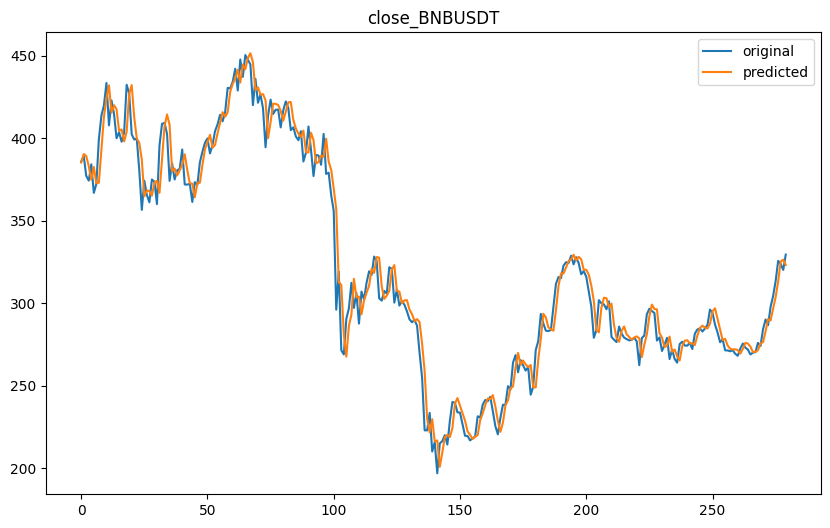

Metrics for 280 days: close_BNBUSDT MSE: 131.45870716842313, RMSE: 11.465544346799376 MAPE: 0.026237853865211973
Metrics for 90 days: close_BNBUSDT MSE: 51.792013288932075, RMSE: 7.196666817974282 MAPE: 0.018761057055119063
Metrics for 30 days: close_BNBUSDT MSE: 32.7510873160747, RMSE: 5.72285656958784 MAPE: 0.016141567054292715
Metrics for 7 days: close_BNBUSDT MSE: 64.98915840627349, RMSE: 8.061585353159359 MAPE: 0.023538770815558257


In [4]:
import numpy as np
from common import get_dataframe

# Normalize the data to the range [0, 1] to help the LSTM model converge faster

df = get_dataframe()

for coin in df.iloc[:, 1:]:
    data = np.array(df[coin]).reshape(-1, 1)

    # Create an Optuna study
    study_name = coin  # Unique identifier of the study.
    storage_name = "sqlite:///training.db"
    pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=10)
    study = optuna.create_study(study_name=coin, direction='minimize', storage=storage_name, pruner=pruner)

    # Start the optimization process
    study.optimize(lambda trial: objective(trial, data, coin), n_trials=50)

    # Get the best hyperparameters
    try:
        best_params = study.best_params
        print("Best Hyperparameters:", best_params)
        evaluate_best_coin(coin, data, best_params)
    except ValueError:
        print("No best hyperparameters found")